# Gensim Tutorial on Online Non-Negative Matrix Factorization

This notebooks explains basic ideas behind the open source NMF implementation in [Gensim](https://github.com/RaRe-Technologies/gensim), including code examples for applying NMF to text processing.

## What's in this tutorial?

1. [Introduction: Why NMF?](#1.-Introduction-to-NMF)
2. [Code example on 20 Newsgroups](#2.-Code-example:-NMF-on-20-Newsgroups)
3. [Benchmarks against Sklearn's NMF and Gensim's LDA](#3.-Benchmarks)
4. [Large-scale NMF training on the English Wikipedia (sparse text vectors)](#4.-NMF-on-English-Wikipedia)
5. [NMF on face decomposition (dense image vectors)](#5.-And-now-for-something-completely-different:-Face-decomposition-from-images)

# 1. Introduction to NMF

## What's in a name?

Gensim's Online Non-Negative Matrix Factorization (NMF, NNMF, ONMF) implementation is based on [Renbo Zhao, Vincent Y. F. Tan: Online Nonnegative Matrix Factorization with Outliers, 2016](https://arxiv.org/abs/1604.02634) and is optimized for extremely large, sparse, streamed inputs. Such inputs happen in NLP with **unsupervised training** on massive text corpora.

* Why **Online**? Because corpora and datasets in modern ML can be very large, and RAM is limited. Unlike batch algorithms, online algorithms learn iteratively, streaming through the available training examples, without loading the entire dataset into RAM or requiring random-access to the data examples.

* Why **Non-Negative**? Because non-negativity leads to more interpretable, sparse "human-friendly" topics. This is in contrast to e.g. SVD (another popular matrix factorization method with [super-efficient implementation in Gensim](https://radimrehurek.com/gensim/models/lsimodel.html)), which produces dense negative factors and thus harder-to-interpret topics.

* **Matrix factorizations** are the corner stone of modern machine learning. They can be used either directly (recommendation systems, bi-clustering, image compression, topic modeling…) or as internal routines in more complex deep learning algorithms.

## How ONNMF works

Terminology:
- `corpus` is a stream of input documents = training examples
- `batch` is a chunk of input corpus, a word-document matrix mini-batch that fits in RAM
- `W` is a word-topic matrix (to be learned; stored in the resulting model)
- `h` is a topic-document matrix (to be learned; not stored, but rather inferred for documents on-the-fly)
- `A`, `B` - matrices that accumulate information from consecutive chunks. `A = h.dot(ht)`, `B = v.dot(ht)`.

The idea behind the algorithm is as follows:

```
    Initialize W, A and B matrices

    for batch in input corpus batches:
        infer h:
            do coordinate gradient descent step to find h that minimizes ||batch - Wh|| in L2 norm

            bound h so that it is non-negative

        update A and B:
            A = h.dot(ht)
            B = batch.dot(ht)

        update W:
            do gradient descent step to find W that minimizes ||0.5*trace(WtWA) - trace(WtB)|| in L2 norm
```

# 2. Code example: NMF on 20 Newsgroups

## Preprocessing

Let's import the models we'll be using throughout this tutorial (`numpy==1.14.2`, `matplotlib==3.0.2`, `pandas==0.24.1`, `sklearn==0.19.1`, `gensim==3.7.1`) and set up logging at INFO level.

Gensim uses logging generously to inform users what's going on. Eyeballing the logs is a good sanity check, to make sure everything is working as expected.

Only `numpy` and `gensim` are actually needed to train and use NMF. The other imports are used only to make our life a little easier in this tutorial.

In [1]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

import gensim.downloader
from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### Dataset preparation

Let's load the notorious [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/) from Gensim's [repository of pre-trained models and corpora](https://github.com/RaRe-Technologies/gensim-data):

In [2]:
newsgroups = gensim.downloader.load('20-newsgroups')

categories = [
    'alt.atheism',
    'comp.graphics',
    'rec.motorcycles',
    'talk.politics.mideast',
    'sci.space'
]

categories = {name: idx for idx, name in enumerate(categories)}

[==================================================] 100.1% 13.8/13.8MB downloaded


2019-02-11 20:13:50,511 : INFO : 20-newsgroups downloaded


Create a train/test split:

In [3]:
random_state = RandomState(42)

trainset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc in newsgroups
    if doc['topic'] in categories and doc['set'] == 'train'
])
random_state.shuffle(trainset)

testset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc in newsgroups
    if doc['topic'] in categories and doc['set'] == 'test'
])
random_state.shuffle(testset)

We'll use very [simple preprocessing with stemming](https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string) to tokenize each document. YMMV; in your application, use whatever preprocessing makes sense in your domain. Correctly preparing the input has [major impact](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out) on any subsequent ML training.

In [4]:
train_documents = [preprocess_string(doc['data']) for doc in trainset]
test_documents = [preprocess_string(doc['data']) for doc in testset]

### Dictionary compilation

Let's create a mapping between tokens and their ids. Another option would be a [HashDictionary](https://radimrehurek.com/gensim/corpora/hashdictionary.html), saving ourselves one pass over the training documents.

In [5]:
dictionary = Dictionary(train_documents)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)  # filter out too in/frequent tokens

2019-02-16 08:29:34,428 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-02-16 08:29:34,886 : INFO : built Dictionary(25279 unique tokens: ['actual', 'assum', 'babbl', 'batka', 'batkaj']...) from 2819 documents (total 435328 corpus positions)
2019-02-16 08:29:34,923 : INFO : discarding 18198 tokens: [('batka', 1), ('batkaj', 1), ('beatl', 1), ('ccmail', 3), ('dayton', 4), ('edu', 1785), ('inhibit', 1), ('jbatka', 1), ('line', 2748), ('organ', 2602)]...
2019-02-16 08:29:34,923 : INFO : keeping 7081 tokens which were in no less than 5 and no more than 1409 (=50.0%) documents
2019-02-16 08:29:34,935 : INFO : resulting dictionary: Dictionary(7081 unique tokens: ['actual', 'assum', 'babbl', 'burster', 'caus']...)


### Create training corpus

Let's vectorize the training corpus into the bag-of-words format:

In [6]:
train_corpus = [
    dictionary.doc2bow(document)
    for document
    in train_documents
]

test_corpus = [
    dictionary.doc2bow(document)
    for document
    in test_documents
]

Here we simply stored the bag-of-words vectors into a `list`, but Gensim accepts [any iterable](https://radimrehurek.com/gensim/tut1.html#corpus-streaming-one-document-at-a-time) as input, including streamed ones. To learn more about memory-efficient input iterables, see our [Data Streaming in Python: Generators, Iterators, Iterables](https://rare-technologies.com/data-streaming-in-python-generators-iterators-iterables/) tutorial.

## NMF Model Training

The API works in the same way as other Gensim models, such as [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) or [LsiModel](https://radimrehurek.com/gensim/models/lsimodel.html).

Notable model parameters:

- `kappa` float, optional

    Gradient descent step size.
    Larger value makes the model train faster, but could lead to non-convergence if set too large.
    
- `w_max_iter` int, optional

    Maximum number of iterations to train W per each batch.
    
- `w_stop_condition` float, optional

    If the error difference gets smaller than this, training of ``W`` stops for the current batch.
    
- `h_r_max_iter` int, optional

    Maximum number of iterations to train h per each batch.
    
- `h_r_stop_condition` float, optional

    If the error difference gets smaller than this, training of ``h`` stops for the current batch.

Learn an NMF model with 5 topics:

In [7]:
%%time

nmf = GensimNmf(
    corpus=train_corpus,
    num_topics=5,
    id2word=dictionary,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
    kappa=1,
)

2019-02-16 08:30:17,916 : INFO : Loss: 0.027125916588366036
2019-02-16 08:30:18,085 : INFO : Loss: 0.02062421455824377


CPU times: user 573 ms, sys: 29.3 ms, total: 603 ms
Wall time: 587 ms


### View the learned topics

In [8]:
nmf.show_topics()

[(0,
  '0.014*"god" + 0.011*"atheist" + 0.008*"believ" + 0.008*"exist" + 0.007*"peopl" + 0.007*"atheism" + 0.006*"religion" + 0.006*"christian" + 0.006*"israel" + 0.006*"jesu"'),
 (1,
  '0.028*"space" + 0.017*"launch" + 0.012*"satellit" + 0.009*"nasa" + 0.008*"orbit" + 0.007*"year" + 0.006*"mission" + 0.006*"new" + 0.005*"commerci" + 0.005*"data"'),
 (2,
  '0.016*"armenian" + 0.015*"peopl" + 0.014*"said" + 0.013*"know" + 0.008*"went" + 0.008*"sai" + 0.007*"like" + 0.007*"apart" + 0.007*"come" + 0.007*"azerbaijani"'),
 (3,
  '0.079*"jpeg" + 0.033*"file" + 0.033*"gif" + 0.027*"imag" + 0.025*"color" + 0.017*"format" + 0.015*"qualiti" + 0.014*"convert" + 0.014*"compress" + 0.013*"version"'),
 (4,
  '0.032*"imag" + 0.015*"graphic" + 0.012*"data" + 0.011*"file" + 0.010*"pub" + 0.010*"ftp" + 0.010*"avail" + 0.009*"program" + 0.009*"format" + 0.008*"packag"')]

### Evaluation measure: Coherence

[Topic coherence](http://qpleple.com/topic-coherence-to-evaluate-topic-models/) measures how often do most frequent tokens from each topic co-occur in one document.

In [9]:
CoherenceModel(
    model=nmf,
    corpus=test_corpus,
    coherence='u_mass'
).get_coherence()

2019-02-16 08:30:23,020 : INFO : CorpusAccumulator accumulated stats from 1000 documents


-1.697305478640499

### Evaluation measure: Perplexity

[Perplexity](http://qpleple.com/perplexity-to-evaluate-topic-models/) reflects how (im)probable it is for the model to observe a particular set of documents. Lower is better.

In [10]:
np.exp(-nmf.log_perplexity(test_corpus))

2458.4709745445807

## Topic inference on new documents

With the NMF model trained, let's fetch one news document not seen during training, and infer its topic vector.

In [11]:
print(testset[0]['data'])
print('=' * 100)
print("Topics: {}".format(nmf[test_corpus[0]]))

From: spl@ivem.ucsd.edu (Steve Lamont)
Subject: Re: RGB to HVS, and back
Organization: University of Calif., San Diego/Microscopy and Imaging Resource
Lines: 18
Distribution: world
NNTP-Posting-Host: ivem.ucsd.edu

In article <ltu4buINNe7j@caspian.usc.edu> zyeh@caspian.usc.edu (zhenghao yeh) writes:
>|> See Foley, van Dam, Feiner, and Hughes, _Computer Graphics: Principles
>|> and Practice, Second Edition_.
>|> 
>|> [If people would *read* this book, 75 percent of the questions in this
>|> froup would disappear overnight...]
>|> 
>	Not really. I think it is less than 10%.

Nah... I figure most people would be so busy reading that they wouldn't
have *time* to post. :-) :-) :-)

							spl
-- 
Steve Lamont, SciViGuy -- (619) 534-7968 -- spl@szechuan.ucsd.edu
San Diego Microscopy and Imaging Resource/UC San Diego/La Jolla, CA 92093-0608
"Until I meet you, then, in Upper Hell
Convulsed, foaming immortal blood: farewell" - J. Berryman, "A Professor's Song"

Topics: [(0, 0.4323836161098359),

## Word topic inference

Similarly, we can inspect the topic distribution assigned to a vocabulary term:

In [12]:
word = dictionary[0]
print("Word: {}".format(word))
print("Topics: {}".format(nmf.get_term_topics(word)))

Word: actual
Topics: [(0, 0.4780870816498957), (1, 0.13675765606590706), (2, 0.06286064951972149), (3, 0.21524708748673824), (4, 0.10704752527773737)]


### Internal NMF state

Density is a fraction of non-zero elements in a matrix.

In [13]:
def density(matrix):
    return (matrix > 0).mean()

Term-topic matrix of shape `(words, topics)`.

In [14]:
print("Density: {}".format(density(nmf._W)))

Density: 0.6128795367885892


Topic-document matrix for the last batch of shape `(topics, batch)`

In [15]:
print("Density: {}".format(density(nmf._h)))

Density: 0.8336996336996337


Residuals matrix of the last batch of shape `(words, batch)`

# 3. Benchmarks

## Gensim NMF vs Sklearn NMF vs Gensim LDA

We'll run these three unsupervised models on the [20newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) dataset.

20 Newsgroups also contains labels for each document, which will allow us to evaluate the trained models on an "upstream" classification task, using the unsupervised document topics as input features.

### Metrics

- `train time` - time to train a model.
- `perplexity` - perplexity score.
- `coherence` - coherence score (not defined for sklearn NMF).
- `l2_norm` - L2 norm of `v - Wh`.
- `f1` - [F1 score](https://en.wikipedia.org/wiki/F1_score) on the task of news topic classification.

In [16]:
fixed_params = dict(
    corpus=train_corpus,
    chunksize=1000,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
)

In [17]:
def get_execution_time(func):
    start = time.time()
    result = func()
    
    elapsed_time = pd.to_timedelta(time.time() - start, unit='s').round('s')

    return elapsed_time, result


def get_tm_f1(model, train_corpus, X_test, y_train, y_test):
    X_train = np.zeros((len(train_corpus), model.num_topics))
    for bow_id, bow in enumerate(train_corpus):
        for topic_id, factor in model.get_document_topics(bow):
            X_train[bow_id, topic_id] = factor

    log_reg = LogisticRegressionCV(multi_class='multinomial')
    log_reg.fit(X_train, y_train)

    pred_labels = log_reg.predict(X_test)

    return f1_score(y_test, pred_labels, average='micro')


def get_sklearn_f1(model, train_corpus, X_test, y_train, y_test):
    X_train = model.transform(train_corpus.T)

    log_reg = LogisticRegressionCV(multi_class='multinomial')
    log_reg.fit(X_train, y_train)

    pred_labels = log_reg.predict(X_test)

    return f1_score(y_test, pred_labels, average='micro')


def get_tm_metrics(model, train_corpus, test_corpus, dense_corpus, y_train, y_test):
    W = model.get_topics().T
    H = np.zeros((model.num_topics, len(test_corpus)))
    for bow_id, bow in enumerate(test_corpus):
        for topic_id, factor in model.get_document_topics(bow):
            H[topic_id, bow_id] = factor

    pred_factors = W.dot(H)
    
    l2_norm = get_tm_l2_norm(pred_factors, dense_corpus)
    
    pred_factors /= pred_factors.sum(axis=0)

    perplexity = get_tm_perplexity(pred_factors, dense_corpus)

    f1 = get_tm_f1(model, train_corpus, H.T, y_train, y_test)

    model.normalize = True

    coherence = CoherenceModel(
        model=model,
        corpus=test_corpus,
        coherence='u_mass'
    ).get_coherence()
    
    topics = model.show_topics(5)

    model.normalize = False

    return dict(
        perplexity=perplexity,
        coherence=coherence,
        l2_norm=l2_norm,
        f1=f1,
        topics=topics,
    )


def get_tm_perplexity(pred_factors, dense_corpus):
    return np.exp(-(np.log(pred_factors, where=pred_factors > 0) * dense_corpus).sum() / dense_corpus.sum())


def get_tm_l2_norm(pred_factors, dense_corpus):
    return np.linalg.norm(dense_corpus - pred_factors)


def get_sklearn_topics(model, id2word, top_n=5):
    topic_probas = model.components_.T
    topic_probas = topic_probas / topic_probas.sum(axis=0)
    
    sparsity = np.zeros(topic_probas.shape[1])

    for row in topic_probas:
        sparsity += (row == 0)

    sparsity /= topic_probas.shape[1]
    
    topic_probas = topic_probas[:, sparsity.argsort()[::-1]][:, :top_n]
    
    token_indices = topic_probas.argsort(axis=0)[:-11:-1, :]
    topic_probas.sort(axis=0)
    topic_probas = topic_probas[:-11:-1, :]
    
    topics = []
    
    for topic_idx in range(topic_probas.shape[1]):
        tokens = [
            id2word[token_idx]
            for token_idx
            in token_indices[:, topic_idx]
        ]
        topic = (
            '{}*"{}"'.format(round(proba, 3), token)
            for proba, token
            in zip(topic_probas[:, topic_idx], tokens)
        )
        topic = " + ".join(topic)
        topics.append((topic_idx, topic))
    
    return topics


def get_sklearn_metrics(model, train_corpus, test_corpus, y_train, y_test, dictionary):
    W = model.components_.T
    H = model.transform((test_corpus).T).T
    pred_factors = W.dot(H)
    
    l2_norm = np.linalg.norm(test_corpus - pred_factors)
    
    pred_factors /= pred_factors.sum(axis=0)
    
    perplexity = np.exp(
        -(np.log(pred_factors, where=pred_factors > 0) * test_corpus).sum()
        / test_corpus.sum()
    )

    f1 = get_sklearn_f1(model, train_corpus, H.T, y_train, y_test)
    
    topics = get_sklearn_topics(model, dictionary, top_n=5)

    return dict(
        perplexity=perplexity,
        l2_norm=l2_norm,
        f1=f1,
        topics=topics,
    )

### Run the models

In [21]:
tm_metrics = pd.DataFrame(columns=['model', 'train_time', 'perplexity', 'coherence', 'l2_norm', 'f1', 'topics'])

train_dense_corpus = matutils.corpus2dense(train_corpus, len(dictionary))
test_dense_corpus = matutils.corpus2dense(test_corpus, len(dictionary))

trainset_target = [doc['target'] for doc in trainset]
testset_target = [doc['target'] for doc in testset]

# LDA metrics
row = {}
row['model'] = 'lda'
row['train_time'], lda = get_execution_time(
    lambda: LdaModel(**fixed_params)
)
row.update(get_tm_metrics(
    lda, train_corpus, test_corpus, test_dense_corpus, trainset_target, testset_target,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

# Sklearn NMF metrics
row = {}
row['model'] = 'sklearn_nmf'
sklearn_nmf = SklearnNmf(n_components=5, random_state=42)
row['train_time'], sklearn_nmf = get_execution_time(
    lambda: sklearn_nmf.fit((train_dense_corpus).T)
)
row.update(get_sklearn_metrics(
    sklearn_nmf, train_dense_corpus, test_dense_corpus, trainset_target, testset_target, dictionary
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

row = {}
row['model'] = 'gensim_nmf'
row['train_time'], gensim_nmf = get_execution_time(
    lambda: GensimNmf(
        normalize=False,
        **fixed_params
    )
)
row.update(get_tm_metrics(
    gensim_nmf, train_corpus, test_corpus, test_dense_corpus, trainset_target, testset_target,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)
tm_metrics.replace(np.nan, '-', inplace=True)

2019-02-16 08:45:25,725 : INFO : using symmetric alpha at 0.2
2019-02-16 08:45:25,727 : INFO : using symmetric eta at 0.2
2019-02-16 08:45:25,729 : INFO : using serial LDA version on this node
2019-02-16 08:45:25,734 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 2819 documents, updating model once every 1000 documents, evaluating perplexity every 2819 documents, iterating 50x with a convergence threshold of 0.001000
2019-02-16 08:45:25,735 : INFO : PROGRESS: pass 0, at document #1000/2819
2019-02-16 08:45:26,574 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-02-16 08:45:26,578 : INFO : topic #0 (0.200): 0.006*"com" + 0.006*"like" + 0.006*"space" + 0.004*"univers" + 0.004*"know" + 0.004*"nntp" + 0.004*"imag" + 0.004*"nasa" + 0.004*"time" + 0.004*"program"
2019-02-16 08:45:26,579 : INFO : topic #1 (0.200): 0.007*"imag" + 0.005*"com" + 0.004*"peopl" + 0.004*"know" + 0.004*"univers" + 0.004*"nntp" + 0.004

2019-02-16 08:45:31,983 : INFO : topic diff=0.416347, rho=0.455535
2019-02-16 08:45:31,984 : INFO : PROGRESS: pass 2, at document #1000/2819
2019-02-16 08:45:32,665 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-02-16 08:45:32,668 : INFO : topic #0 (0.200): 0.011*"space" + 0.007*"imag" + 0.006*"nasa" + 0.006*"com" + 0.006*"graphic" + 0.006*"program" + 0.005*"file" + 0.005*"data" + 0.005*"orbit" + 0.004*"new"
2019-02-16 08:45:32,670 : INFO : topic #1 (0.200): 0.010*"com" + 0.006*"imag" + 0.006*"like" + 0.006*"nntp" + 0.006*"host" + 0.006*"univers" + 0.005*"bit" + 0.005*"know" + 0.005*"think" + 0.005*"work"
2019-02-16 08:45:32,671 : INFO : topic #2 (0.200): 0.011*"peopl" + 0.009*"armenian" + 0.007*"turkish" + 0.007*"said" + 0.007*"right" + 0.006*"jew" + 0.005*"know" + 0.005*"kill" + 0.005*"isra" + 0.005*"like"
2019-02-16 08:45:32,673 : INFO : topic #3 (0.200): 0.010*"com" + 0.010*"israel" + 0.008*"bike" + 0.006*"isra" + 0.005*"like" + 0.004*"dod" + 0.004

2019-02-16 08:45:38,228 : INFO : topic #1 (0.200): 0.013*"com" + 0.007*"like" + 0.007*"nntp" + 0.007*"host" + 0.006*"univers" + 0.006*"know" + 0.005*"bit" + 0.005*"think" + 0.005*"time" + 0.005*"work"
2019-02-16 08:45:38,230 : INFO : topic #2 (0.200): 0.013*"armenian" + 0.011*"peopl" + 0.008*"turkish" + 0.007*"said" + 0.007*"jew" + 0.006*"right" + 0.006*"kill" + 0.005*"know" + 0.005*"isra" + 0.005*"arab"
2019-02-16 08:45:38,231 : INFO : topic #3 (0.200): 0.012*"com" + 0.010*"israel" + 0.009*"bike" + 0.007*"isra" + 0.006*"dod" + 0.005*"like" + 0.005*"host" + 0.005*"nntp" + 0.005*"ride" + 0.005*"think"
2019-02-16 08:45:38,233 : INFO : topic #4 (0.200): 0.011*"god" + 0.008*"peopl" + 0.006*"think" + 0.006*"exist" + 0.006*"islam" + 0.005*"atheist" + 0.005*"believ" + 0.005*"com" + 0.005*"univers" + 0.005*"moral"
2019-02-16 08:45:38,234 : INFO : topic diff=0.202108, rho=0.357622
2019-02-16 08:45:38,235 : INFO : PROGRESS: pass 4, at document #2000/2819
2019-02-16 08:45:38,853 : INFO : merging 

## Benchmark results

In [22]:
tm_metrics.drop('topics', axis=1)

model train_time   perplexity coherence      l2_norm        f1
0          lda   00:00:14  2036.907345  -2.10542  1189.644180  0.752132
1  sklearn_nmf   00:00:05  2495.031751         -   895.549512  0.705757
2   gensim_nmf   00:00:01  2460.454176  -1.69731   899.011753  0.707356

### Main insights

- Gensim NMF is **ridiculously fast** and leaves both LDA and Sklearn far behind in terms of training time.
- Gensim NMF beats sklearn NMF implementation on F1 metric, although not on the L2 norm on this particular dataset.
- Gensim NMF beats LDA on coherence, but LDA is still better on perplexity and F1 score.

### Learned topics

Let's inspect the 5 topics learned by each of the three models:

In [23]:
def compare_topics(tm_metrics):
    for _, row in tm_metrics.iterrows():
        print('\n{}:'.format(row.model))
        print("\n".join(str(topic) for topic in row.topics))
        
compare_topics(tm_metrics)


lda:
(0, '0.013*"space" + 0.008*"imag" + 0.007*"nasa" + 0.006*"graphic" + 0.006*"program" + 0.005*"launch" + 0.005*"file" + 0.005*"com" + 0.005*"new" + 0.004*"orbit"')
(1, '0.015*"com" + 0.007*"like" + 0.007*"nntp" + 0.007*"host" + 0.006*"know" + 0.006*"univers" + 0.005*"henri" + 0.005*"work" + 0.005*"bit" + 0.005*"think"')
(2, '0.014*"armenian" + 0.011*"peopl" + 0.009*"turkish" + 0.007*"jew" + 0.007*"said" + 0.006*"right" + 0.005*"know" + 0.005*"kill" + 0.005*"isra" + 0.005*"turkei"')
(3, '0.012*"com" + 0.010*"israel" + 0.009*"bike" + 0.006*"isra" + 0.006*"dod" + 0.005*"like" + 0.005*"ride" + 0.005*"host" + 0.005*"nntp" + 0.005*"motorcycl"')
(4, '0.011*"god" + 0.008*"peopl" + 0.007*"think" + 0.006*"exist" + 0.006*"univers" + 0.005*"com" + 0.005*"believ" + 0.005*"islam" + 0.005*"moral" + 0.005*"christian"')

sklearn_nmf:
(0, '0.053*"jpeg" + 0.039*"imag" + 0.028*"file" + 0.023*"gif" + 0.019*"color" + 0.016*"format" + 0.011*"version" + 0.011*"program" + 0.011*"bit" + 0.01*"qualiti"')
(1

Subjectively, Gensim and Sklearn NMFs are on par with each other, LDA looks a bit worse.

# 4. NMF on English Wikipedia

This section shows how to train an NMF model on a large text corpus, the entire English Wikipedia: **2.6 billion words, in 23.1 million article sections across 5 million Wikipedia articles**.

The data preprocessing takes a while, and we'll be comparing multiple models, so **reserve about FIXME hours** and some **20 GB of disk space** to go through the following notebook cells in full. You'll need `gensim>=3.7.1`, `numpy`, `tqdm`, `pandas`, `psutils`, `joblib` and `sklearn`.

In [1]:
# Re-import modules from scratch, so that this Section doesn't rely on any previous cells.
import itertools
import json
import logging
import time
import os

from smart_open import smart_open
import psutil
import numpy as np
import scipy.sparse
from contextlib import contextmanager
from multiprocessing import Process
from tqdm import tqdm, tqdm_notebook
import joblib
import pandas as pd
from sklearn.decomposition.nmf import NMF as SklearnNmf

import gensim.downloader
from gensim import matutils
from gensim.corpora import MmCorpus, Dictionary
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.utils import simple_preprocess

tqdm.pandas()

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Load the Wikipedia dump

We'll use the [gensim.downloader](https://github.com/RaRe-Technologies/gensim-data) to download a parsed Wikipedia dump (6.1 GB disk space):

In [2]:
data = gensim.downloader.load("wiki-english-20171001")

 Part 1/4 [==================================================] 100.0% 1950.0/1950.0MB downloaded


2019-02-15 00:01:16,282 : INFO : Part 1/4 downloaded


 Part 2/4 [==================================================] 100.0% 1950.0/1950.0MB downloaded


2019-02-15 00:25:13,331 : INFO : Part 2/4 downloaded


 Part 3/4 [==================================================] 100.0% 1950.0/1950.0MB downloaded


2019-02-15 00:48:03,728 : INFO : Part 3/4 downloaded


 Part 4/4 [==================================================] 100.0% 364.2/364.2MB downloaded


2019-02-15 00:52:41,159 : INFO : Part 4/4 downloaded


Print the titles and sections of the first Wikipedia article, as a little sanity check:

In [3]:
data = gensim.downloader.load("wiki-english-20171001")  # FIXME
article = next(iter(data))

print("Article: %r\n" % article['title'])
for section_title, section_text in zip(article['section_titles'], article['section_texts']):
    print("Section title: %r" % section_title)
    print("Section text: %s…\n" % section_text[:100].replace('\n', ' ').strip())

Article: 'Anarchism'

Section title: 'Introduction'
Section text: '''Anarchism''' is a political philosophy that advocates self-governed societies based on volun…

Section title: 'Etymology and terminology'
Section text: The word ''anarchism'' is composed from the word ''anarchy'' and the suffix ''-ism'', themselves d…

Section title: 'History'
Section text: ===Origins=== Woodcut from a Diggers document by William Everard  The earliest anarchist themes ca…

Section title: 'Anarchist schools of thought'
Section text: Portrait of philosopher Pierre-Joseph Proudhon (1809–1865) by Gustave Courbet. Proudhon was the pri…

Section title: 'Internal issues and debates'
Section text: consistent with anarchist values is a controversial subject among anarchists.  Anarchism is a philo…

Section title: 'Topics of interest'
Section text: Intersecting and overlapping between various schools of thought, certain topics of interest and inte…

Section title: 'Criticisms'
Section text: Criticisms of anarch

Let's create a Python generator function that streams through the downloaded Wikipedia dump and preprocesses (tokenizes, lower-cases) each article:

In [4]:
def wikidump2tokens(articles):
    """Stream through the Wikipedia dump, yielding a list of tokens for each article."""
    for article in articles:
        article_section_texts = [
            " ".join([title, text])
            for title, text
            in zip(article['section_titles'], article['section_texts'])
        ]
        article_tokens = simple_preprocess(" ".join(article_section_texts))
        yield article_tokens

Create a word-to-id mapping, in order to vectorize texts. Makes a full pass over the Wikipedia corpus, takes **~3.5 hours**:

In [5]:
if os.path.exists('wiki.dict'):
    # If we already stored the Dictionary in a previous run, simply load it, to save time.
    dictionary = Dictionary.load('wiki.dict')
else:
    dictionary = Dictionary(wikidump2tokens(data))
    # Keep only the 30,000 most frequent vocabulary terms, after filtering away terms
    # that are too frequent/too infrequent.
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=30000)
    dictionary.save('wiki.dict')

2019-02-17 00:57:56,793 : INFO : loading Dictionary object from wiki.dict
2019-02-17 00:57:56,812 : INFO : loaded wiki.dict


## Store preprocessed Wikipedia as bag-of-words sparse matrix in MatrixMarket format

When training NMF with a single pass over the input corpus ("online"), we simply vectorize each raw text straight from the input storage:

In [6]:
vector_stream = (dictionary.doc2bow(article) for article in wikidump2tokens(data))

For the purposes of this tutorial though, we'll serialize ("cache") the vectorized bag-of-words vectors to disk, to `wiki.mm` file in MatrixMarket format. The reason is, we'll be re-using the vectorized articles multiple times, for different models for our benchmarks, and also shuffling them, so it makes sense to amortize the vectorization time by persisting the resulting vectors to disk.

So, let's stream through the preprocessed sparse Wikipedia bag-of-words matrix while storing it to disk. **This step takes about 3 hours** and needs **11 GB of disk space**:

In [7]:
class RandomSplitCorpus(MmCorpus):
    """
    Use the fact that MmCorpus supports random indexing, and create a streamed
    corpus in shuffled order, including a train/test split for evaluation.
    """
    def __init__(self, random_seed=42, testset=False, testsize=1000, *args, **kwargs):
        super().__init__(*args, **kwargs)

        random_state = np.random.RandomState(random_seed)
        
        self.indices = random_state.permutation(range(self.num_docs))
        test_nnz = sum(len(self[doc_idx]) for doc_idx in self.indices[:testsize])
        
        if testset:
            self.indices = self.indices[:testsize]
            self.num_docs = testsize
            self.num_nnz = test_nnz
        else:
            self.indices = self.indices[testsize:]
            self.num_docs -= testsize
            self.num_nnz -= test_nnz

    def __iter__(self):
        for doc_id in self.indices:
            yield self[doc_id]

In [9]:
if not os.path.exists('/Users/kofola3/wiki.mm'):  # FIXME
    RandomSplitCorpus.serialize('/Users/kofola3/wiki.mm', vector_stream, progress_cnt=100000)

In [10]:
# Load back the vectors as two lazily-streamed train/test iterables.
train_corpus = RandomSplitCorpus(
    random_seed=42, testset=False, testsize=2000, fname='/Users/kofola3/wiki.mm',
)
test_corpus = RandomSplitCorpus(
    random_seed=42, testset=True, testsize=2000, fname='/Users/kofola3/wiki.mm',
)

2019-02-17 00:59:05,963 : INFO : loaded corpus index from /Users/kofola3/wiki.mm.index
2019-02-17 00:59:05,964 : INFO : initializing cython corpus reader from /Users/kofola3/wiki.mm
2019-02-17 00:59:05,965 : INFO : accepted corpus with 4924894 documents, 30000 features, 820242695 non-zero entries
2019-02-17 00:59:08,486 : INFO : loaded corpus index from /Users/kofola3/wiki.mm.index
2019-02-17 00:59:08,486 : INFO : initializing cython corpus reader from /Users/kofola3/wiki.mm
2019-02-17 00:59:08,487 : INFO : accepted corpus with 4924894 documents, 30000 features, 820242695 non-zero entries


## Save preprocessed Wikipedia in scipy.sparse format

This is only needed to run the Sklearn NMF on Wikipedia, for comparison in the benchmarks below. Sklearn expects in-memory scipy sparse input, not on-the-fly vector streams. Needs additional ~2 GB of disk space.


**Skip this step if you don't need the Sklearn's NMF benchmark, and only want to run Gensim's NMF.**

In [12]:
scipy.sparse.save_npz(
    'wiki_train_csr.npz',
    matutils.corpus2csc(train_corpus, len(dictionary)).T,
)

scipy.sparse.save_npz(
    'wiki_test_csr.npz',
    matutils.corpus2csc(test_corpus, len(dictionary)).T,
)

## Evaluation metrics

We'll track these metrics as we train and test NMF on the Wikipedia corpus we created above:
- `train time` - time to train a model
- `mean_ram` - mean RAM consumption during training
- `max_ram` - maximum RAM consumption during training
- `perplexity` - perplexity score
- `coherence` - coherence score (not defined for sklearn NMF)
- `l2_norm` - L2 norm of `||v - Wh||`

In [11]:
@contextmanager
def measure_ram(output, tick=2):
    def _measure_ram(pid, output, start_memory, tick=tick):
        py = psutil.Process(pid)
        with open(output, 'w') as outfile:
            while True:
                memory = py.memory_info().rss - start_memory
                outfile.write("{}\n".format(memory))
                outfile.flush()
                time.sleep(tick)

    pid = os.getpid()
    start_memory = psutil.Process(pid).memory_info().rss
    p = Process(target=_measure_ram, args=(pid, output, start_memory, tick))
    p.start()
    yield
    p.terminate()

def get_train_time_and_ram(func, name):
    memprof_filename = "{}.memprof".format(name)
    
    start = time.time()

    with measure_ram(memprof_filename, tick=5):
        result = func()        
        
    elapsed_time = pd.to_timedelta(time.time() - start, unit='s').round('s')
    
    memprof_df = pd.read_csv(memprof_filename, squeeze=True)
    
    mean_ram = "{} MB".format(
        int(memprof_df.mean() // 2**20),
    )
    
    max_ram = "{} MB".format(int(memprof_df.max() // 2**20))

    return elapsed_time, mean_ram, max_ram, result


def get_tm_metrics(model, test_corpus):
    W = model.get_topics().T
    H = np.zeros((model.num_topics, len(test_corpus)))
    for bow_id, bow in enumerate(test_corpus):
        for topic_id, word_count in model.get_document_topics(bow):
            H[topic_id, bow_id] = word_count

    pred_factors = W.dot(H)
    
    dense_corpus = matutils.corpus2dense(test_corpus, pred_factors.shape[0])

    l2_norm = get_tm_l2_norm(pred_factors, dense_corpus)
    
    pred_factors /= pred_factors.sum(axis=0)
    
    perplexity = get_tm_perplexity(pred_factors, dense_corpus)

    model.normalize = True

    coherence = CoherenceModel(
        model=model,
        corpus=test_corpus,
        coherence='u_mass'
    ).get_coherence()
    
    topics = model.show_topics(5)

    model.normalize = False

    return dict(
        perplexity=round(perplexity, 4),
        coherence=round(coherence, 4),
        l2_norm=round(l2_norm, 4),
        topics=topics,
    )


def get_tm_perplexity(pred_factors, dense_corpus):
    return np.exp(-(np.log(pred_factors, where=pred_factors > 0) * dense_corpus).sum() / dense_corpus.sum())


def get_tm_l2_norm(pred_factors, dense_corpus):
    return np.linalg.norm(dense_corpus - pred_factors)


def get_sklearn_topics(model, id2word, top_n=5):
    topic_probas = model.components_.T
    topic_probas = topic_probas / topic_probas.sum(axis=0)
    
    sparsity = np.zeros(topic_probas.shape[1])

    for row in topic_probas:
        sparsity += (row == 0)

    sparsity /= topic_probas.shape[1]
    
    topic_probas = topic_probas[:, sparsity.argsort()[::-1]][:, :top_n]
    
    token_indices = topic_probas.argsort(axis=0)[:-11:-1, :]
    topic_probas.sort(axis=0)
    topic_probas = topic_probas[:-11:-1, :]
    
    topics = []
    
    for topic_idx in range(topic_probas.shape[1]):
        tokens = [
            id2word[token_idx]
            for token_idx
            in token_indices[:, topic_idx]
        ]
        topic = (
            '{}*"{}"'.format(round(proba, 3), token)
            for proba, token
            in zip(topic_probas[:, topic_idx], tokens)
        )
        topic = " + ".join(topic)
        topics.append((topic_idx, topic))
    
    return topics


def get_sklearn_metrics(model, test_corpus, dictionary):
    W = model.components_.T
    H = model.transform(test_corpus).T
    pred_factors = W.dot(H)
    
    l2_norm = np.linalg.norm(test_corpus - pred_factors)
    
    pred_factors /= pred_factors.sum(axis=0)

    perplexity = np.exp(
        -(np.log(pred_factors, where=pred_factors > 0) * test_corpus).sum()
        / test_corpus.sum()
    )
    
    topics = get_sklearn_topics(model, dictionary, top_n=5)

    return dict(
        perplexity=perplexity,
        l2_norm=l2_norm,
        topics=topics,
    )

Define a dataframe in which we'll store the recorded metrics:

In [12]:
tm_metrics = pd.DataFrame(columns=[
    'model', 'train_time', 'mean_ram', 'max_ram', 'perplexity', 'coherence', 'l2_norm', 'topics',
])

Define common parameters, to be shared by all evaluated models:

In [13]:
params = dict(
    corpus=train_corpus,
    chunksize=2000,
    num_topics=50,
    id2word=dictionary,
    passes=1,
    eval_every=10,
    minimum_probability=0,
    random_state=42,
)

## Wikipedia training

### Train Gensim NMF model and record its metrics

In [14]:
row = {}
row['model'] = 'gensim_nmf'
row['train_time'], row['mean_ram'], row['max_ram'], nmf = get_train_time_and_ram(
    lambda: GensimNmf(normalize=False, **params),
    'gensim_nmf',
)

2019-02-17 01:00:02,504 : INFO : Loss: 0.024172445101868792
2019-02-17 01:00:21,296 : INFO : Loss: 0.026756086683127067
2019-02-17 01:00:34,220 : INFO : Loss: 0.014766985071136662
2019-02-17 01:00:48,467 : INFO : Loss: 0.007607016958138402
2019-02-17 01:01:03,992 : INFO : Loss: 0.06593729267283109
2019-02-17 01:01:17,846 : INFO : Loss: 0.00934366857008626
2019-02-17 01:01:31,031 : INFO : Loss: 0.004276457968172155
2019-02-17 01:01:43,038 : INFO : Loss: 0.0058710007655230064
2019-02-17 01:01:54,501 : INFO : Loss: 0.003807425415645218
2019-02-17 01:02:06,555 : INFO : Loss: 0.00329123313316217
2019-02-17 01:02:18,307 : INFO : Loss: 0.0038919436882029717
2019-02-17 01:02:32,170 : INFO : Loss: 0.0027101452334691418
2019-02-17 01:02:43,670 : INFO : Loss: 0.004029108350928439
2019-02-17 01:02:55,068 : INFO : Loss: 0.0037481760695001845
2019-02-17 01:03:06,104 : INFO : Loss: 0.0018318255191060984
2019-02-17 01:03:16,872 : INFO : Loss: 0.00290370186866038
2019-02-17 01:03:27,753 : INFO : Loss: 

2019-02-17 01:24:04,237 : INFO : Loss: 0.0001707779974613982
2019-02-17 01:24:14,657 : INFO : Loss: 0.0
2019-02-17 01:24:24,491 : INFO : Loss: 0.0
2019-02-17 01:24:34,381 : INFO : Loss: 0.00020206257049079545
2019-02-17 01:24:44,568 : INFO : Loss: 0.0001404934079767365
2019-02-17 01:24:54,509 : INFO : Loss: 0.0
2019-02-17 01:25:04,289 : INFO : Loss: 0.00031054574751004883
2019-02-17 01:25:14,654 : INFO : Loss: 0.00043443127209774504
2019-02-17 01:25:24,605 : INFO : Loss: 0.0
2019-02-17 01:25:34,504 : INFO : Loss: 0.00022036573009109718
2019-02-17 01:25:44,821 : INFO : Loss: 0.00025469766889746364
2019-02-17 01:25:55,087 : INFO : Loss: 0.0
2019-02-17 01:26:05,087 : INFO : Loss: 0.00017626838979765519
2019-02-17 01:26:15,493 : INFO : Loss: 0.00014879555233826403
2019-02-17 01:26:25,644 : INFO : Loss: 0.0003004960520410877
2019-02-17 01:26:35,766 : INFO : Loss: 0.00024271868242905945
2019-02-17 01:26:46,552 : INFO : Loss: 0.00010085230895595078
2019-02-17 01:26:56,796 : INFO : Loss: 0.000

In [15]:
print(row)
nmf.save('gensim_nmf.model')

2019-02-17 01:42:08,190 : INFO : saving Nmf object under gensim_nmf.model, separately None


{'model': 'gensim_nmf', 'train_time': Timedelta('0 days 00:42:34'), 'mean_ram': '116 MB', 'max_ram': '121 MB'}


2019-02-17 01:42:08,875 : INFO : saved gensim_nmf.model


In [16]:
nmf = GensimNmf.load('gensim_nmf.model')
row.update(get_tm_metrics(nmf, test_corpus))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-02-17 01:42:08,881 : INFO : loading Nmf object from gensim_nmf.model
2019-02-17 01:42:09,250 : INFO : loading id2word recursively from gensim_nmf.model.id2word.* with mmap=None
2019-02-17 01:42:09,251 : INFO : loaded gensim_nmf.model
2019-02-17 01:42:25,833 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-02-17 01:42:26,054 : INFO : CorpusAccumulator accumulated stats from 2000 documents


{'model': 'gensim_nmf', 'train_time': Timedelta('0 days 00:42:34'), 'mean_ram': '116 MB', 'max_ram': '121 MB', 'perplexity': 3207.5235, 'coherence': -3.3412, 'l2_norm': 1925.6905, 'topics': [(47, '0.057*"film" + 0.027*"best" + 0.015*"award" + 0.012*"awards" + 0.012*"fm" + 0.010*"music" + 0.010*"films" + 0.009*"festival" + 0.008*"director" + 0.007*"radio"'), (45, '0.103*"his" + 0.042*"he" + 0.013*"him" + 0.012*"had" + 0.010*"who" + 0.009*"after" + 0.009*"that" + 0.008*"which" + 0.007*"first" + 0.006*"one"'), (17, '0.275*"he" + 0.023*"his" + 0.013*"career" + 0.011*"where" + 0.009*"him" + 0.009*"has" + 0.009*"played" + 0.008*"served" + 0.008*"member" + 0.008*"became"'), (0, '0.194*"peak" + 0.186*"mount" + 0.091*"survey" + 0.073*"october" + 0.067*"september" + 0.035*"catalina" + 0.035*"css" + 0.030*"november" + 0.025*"socorro" + 0.025*"linear"'), (3, '0.249*"linear" + 0.248*"socorro" + 0.051*"september" + 0.044*"neat" + 0.033*"october" + 0.031*"december" + 0.030*"august" + 0.028*"anderson"

### Train Gensim LDA and record its metrics

In [17]:
row = {}
row['model'] = 'lda'
row['train_time'], row['mean_ram'], row['max_ram'], lda = get_train_time_and_ram(
    lambda: LdaModel(**params),
    'lda',
)

2019-02-17 01:42:26,388 : INFO : using symmetric alpha at 0.02
2019-02-17 01:42:26,391 : INFO : using symmetric eta at 0.02
2019-02-17 01:42:26,398 : INFO : using serial LDA version on this node
2019-02-17 01:42:26,607 : INFO : running online (single-pass) LDA training, 50 topics, 1 passes over the supplied corpus of 4922894 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2019-02-17 01:42:27,423 : INFO : PROGRESS: pass 0, at document #2000/4922894
2019-02-17 01:42:30,361 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:42:30,434 : INFO : topic #18 (0.020): 0.011*"that" + 0.007*"he" + 0.006*"or" + 0.006*"are" + 0.006*"which" + 0.006*"be" + 0.004*"his" + 0.004*"were" + 0.004*"this" + 0.003*"national"
2019-02-17 01:42:30,435 : INFO : topic #10 (0.020): 0.009*"he" + 0.008*"that" + 0.005*"which" + 0.005*"were" + 0.004*"after" + 0.004*"new" + 0.

2019-02-17 01:42:51,613 : INFO : topic #30 (0.020): 0.024*"united" + 0.013*"kingdom" + 0.013*"bank" + 0.009*"africa" + 0.009*"countries" + 0.008*"international" + 0.008*"uk" + 0.008*"states" + 0.006*"are" + 0.006*"canada"
2019-02-17 01:42:51,615 : INFO : topic #9 (0.020): 0.012*"oblast" + 0.009*"hockey" + 0.008*"nhl" + 0.008*"gp" + 0.006*"coins" + 0.005*"craig" + 0.005*"alaska" + 0.005*"colorado" + 0.005*"sms" + 0.005*"name"
2019-02-17 01:42:51,616 : INFO : topic #12 (0.020): 0.021*"air" + 0.020*"th" + 0.017*"al" + 0.013*"aircraft" + 0.011*"army" + 0.010*"inactive" + 0.010*"force" + 0.008*"war" + 0.008*"squadron" + 0.006*"were"
2019-02-17 01:42:51,618 : INFO : topic #45 (0.020): 0.034*"island" + 0.016*"municipality" + 0.015*"kg" + 0.015*"mf" + 0.012*"flag" + 0.012*"df" + 0.011*"fw" + 0.008*"km" + 0.008*"cm" + 0.007*"islands"
2019-02-17 01:42:51,619 : INFO : topic #37 (0.020): 0.022*"church" + 0.012*"his" + 0.010*"st" + 0.010*"th" + 0.007*"century" + 0.007*"he" + 0.007*"new" + 0.006*"jo

2019-02-17 01:43:14,860 : INFO : topic #6 (0.020): 0.048*"species" + 0.034*"family" + 0.017*"genus" + 0.016*"found" + 0.013*"zealand" + 0.010*"south" + 0.010*"new" + 0.008*"australia" + 0.008*"brown" + 0.008*"white"
2019-02-17 01:43:14,861 : INFO : topic #48 (0.020): 0.024*"river" + 0.018*"road" + 0.015*"north" + 0.014*"south" + 0.013*"park" + 0.013*"lake" + 0.011*"creek" + 0.009*"route" + 0.009*"west" + 0.009*"east"
2019-02-17 01:43:14,863 : INFO : topic #32 (0.020): 0.033*"university" + 0.016*"india" + 0.009*"science" + 0.009*"award" + 0.007*"journal" + 0.007*"research" + 0.007*"indian" + 0.007*"professor" + 0.006*"his" + 0.006*"society"
2019-02-17 01:43:14,865 : INFO : topic diff=0.490768, rho=0.277350
2019-02-17 01:43:15,664 : INFO : PROGRESS: pass 0, at document #28000/4922894
2019-02-17 01:43:18,060 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:43:18,139 : INFO : topic #19 (0.020): 0.075*"district" + 0.054*"county" + 0.050*"village" 

2019-02-17 01:43:33,829 : INFO : topic #49 (0.020): 0.023*"cricket" + 0.020*"australia" + 0.017*"swedish" + 0.016*"denmark" + 0.013*"bc" + 0.012*"sweden" + 0.012*"sri" + 0.012*"class" + 0.012*"international" + 0.011*"australian"
2019-02-17 01:43:33,831 : INFO : topic diff=0.598295, rho=0.229416
2019-02-17 01:43:38,590 : INFO : -8.851 per-word bound, 461.8 perplexity estimate based on a held-out corpus of 2000 documents with 664289 words
2019-02-17 01:43:38,591 : INFO : PROGRESS: pass 0, at document #40000/4922894
2019-02-17 01:43:40,891 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:43:40,969 : INFO : topic #7 (0.020): 0.028*"are" + 0.012*"or" + 0.010*"have" + 0.009*"this" + 0.009*"which" + 0.008*"has" + 0.007*"that" + 0.006*"most" + 0.006*"been" + 0.006*"other"
2019-02-17 01:43:40,971 : INFO : topic #42 (0.020): 0.025*"were" + 0.016*"ship" + 0.013*"had" + 0.011*"that" + 0.008*"two" + 0.006*"class" + 0.006*"fire" + 0.006*"ships" + 0.006*"af

2019-02-17 01:43:59,836 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:43:59,918 : INFO : topic #36 (0.020): 0.160*"he" + 0.096*"his" + 0.015*"born" + 0.011*"after" + 0.010*"career" + 0.009*"became" + 0.009*"years" + 0.009*"life" + 0.008*"where" + 0.008*"served"
2019-02-17 01:43:59,920 : INFO : topic #48 (0.020): 0.033*"river" + 0.018*"lake" + 0.015*"park" + 0.013*"chinese" + 0.013*"road" + 0.013*"north" + 0.012*"south" + 0.011*"china" + 0.010*"route" + 0.009*"mountain"
2019-02-17 01:43:59,921 : INFO : topic #44 (0.020): 0.012*"team" + 0.011*"game" + 0.011*"season" + 0.009*"racing" + 0.009*"race" + 0.008*"baseball" + 0.006*"first" + 0.006*"all" + 0.006*"year" + 0.005*"nfl"
2019-02-17 01:43:59,922 : INFO : topic #11 (0.020): 0.142*"she" + 0.081*"her" + 0.021*"la" + 0.014*"de" + 0.011*"le" + 0.010*"les" + 0.010*"paris" + 0.009*"du" + 0.009*"et" + 0.008*"french"
2019-02-17 01:43:59,924 : INFO : topic #22 (0.020): 0.045*"com" + 0.043*"http" + 0

2019-02-17 01:44:22,856 : INFO : topic #31 (0.020): 0.054*"art" + 0.039*"museum" + 0.020*"bar" + 0.018*"text" + 0.015*"gallery" + 0.014*"arts" + 0.013*"work" + 0.013*"artist" + 0.012*"collection" + 0.012*"till"
2019-02-17 01:44:22,857 : INFO : topic #33 (0.020): 0.023*"john" + 0.019*"american" + 0.013*"james" + 0.010*"born" + 0.010*"george" + 0.009*"william" + 0.009*"david" + 0.008*"robert" + 0.008*"th" + 0.008*"smith"
2019-02-17 01:44:22,859 : INFO : topic #41 (0.020): 0.016*"building" + 0.013*"house" + 0.013*"built" + 0.011*"street" + 0.008*"bridge" + 0.008*"historic" + 0.008*"which" + 0.007*"were" + 0.007*"buildings" + 0.007*"has"
2019-02-17 01:44:22,860 : INFO : topic #21 (0.020): 0.038*"film" + 0.014*"television" + 0.013*"tv" + 0.013*"series" + 0.012*"best" + 0.010*"show" + 0.010*"episode" + 0.008*"director" + 0.008*"award" + 0.007*"films"
2019-02-17 01:44:22,863 : INFO : topic diff=0.521870, rho=0.176777
2019-02-17 01:44:23,565 : INFO : PROGRESS: pass 0, at document #66000/492289

2019-02-17 01:44:42,680 : INFO : topic #16 (0.020): 0.010*"power" + 0.008*"energy" + 0.008*"water" + 0.008*"used" + 0.008*"engine" + 0.007*"production" + 0.005*"design" + 0.005*"model" + 0.005*"be" + 0.005*"which"
2019-02-17 01:44:42,682 : INFO : topic #1 (0.020): 0.024*"album" + 0.017*"song" + 0.015*"released" + 0.014*"band" + 0.012*"music" + 0.008*"single" + 0.008*"chart" + 0.008*"you" + 0.007*"track" + 0.007*"songs"
2019-02-17 01:44:42,684 : INFO : topic diff=0.435711, rho=0.162221
2019-02-17 01:44:43,482 : INFO : PROGRESS: pass 0, at document #78000/4922894
2019-02-17 01:44:46,098 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:44:46,183 : INFO : topic #11 (0.020): 0.183*"she" + 0.123*"her" + 0.018*"women" + 0.011*"born" + 0.011*"la" + 0.011*"female" + 0.010*"woman" + 0.008*"career" + 0.007*"has" + 0.006*"le"
2019-02-17 01:44:46,185 : INFO : topic #23 (0.020): 0.020*"book" + 0.015*"published" + 0.011*"books" + 0.011*"novel" + 0.010*"stor

2019-02-17 01:45:06,187 : INFO : topic #32 (0.020): 0.042*"university" + 0.021*"india" + 0.013*"indian" + 0.011*"professor" + 0.010*"research" + 0.010*"science" + 0.009*"institute" + 0.009*"award" + 0.008*"society" + 0.007*"journal"
2019-02-17 01:45:06,190 : INFO : topic diff=0.365161, rho=0.150756
2019-02-17 01:45:06,934 : INFO : PROGRESS: pass 0, at document #90000/4922894
2019-02-17 01:45:09,386 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:45:09,472 : INFO : topic #5 (0.020): 0.073*"march" + 0.064*"september" + 0.059*"july" + 0.059*"october" + 0.056*"january" + 0.055*"august" + 0.055*"june" + 0.054*"april" + 0.054*"december" + 0.053*"november"
2019-02-17 01:45:09,474 : INFO : topic #26 (0.020): 0.025*"london" + 0.018*"british" + 0.016*"royal" + 0.014*"sir" + 0.014*"john" + 0.013*"william" + 0.011*"england" + 0.010*"king" + 0.009*"henry" + 0.009*"lord"
2019-02-17 01:45:09,476 : INFO : topic #41 (0.020): 0.017*"building" + 0.015*"house" 

2019-02-17 01:45:30,379 : INFO : PROGRESS: pass 0, at document #102000/4922894
2019-02-17 01:45:32,848 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:45:32,934 : INFO : topic #33 (0.020): 0.021*"john" + 0.019*"american" + 0.012*"born" + 0.011*"james" + 0.009*"david" + 0.008*"william" + 0.008*"smith" + 0.008*"george" + 0.008*"robert" + 0.007*"michael"
2019-02-17 01:45:32,936 : INFO : topic #43 (0.020): 0.024*"th" + 0.022*"world" + 0.015*"championships" + 0.015*"team" + 0.014*"won" + 0.012*"time" + 0.012*"men" + 0.011*"event" + 0.011*"final" + 0.011*"championship"
2019-02-17 01:45:32,937 : INFO : topic #19 (0.020): 0.073*"district" + 0.043*"village" + 0.041*"county" + 0.039*"town" + 0.024*"south" + 0.023*"east" + 0.022*"north" + 0.021*"population" + 0.021*"west" + 0.018*"province"
2019-02-17 01:45:32,938 : INFO : topic #39 (0.020): 0.057*"school" + 0.030*"state" + 0.025*"university" + 0.021*"high" + 0.018*"college" + 0.014*"states" + 0.012*"t

2019-02-17 01:45:52,661 : INFO : topic #49 (0.020): 0.051*"australia" + 0.044*"australian" + 0.026*"zealand" + 0.022*"south" + 0.019*"sydney" + 0.019*"new" + 0.015*"melbourne" + 0.014*"cricket" + 0.014*"wales" + 0.012*"sri"
2019-02-17 01:45:52,662 : INFO : topic #13 (0.020): 0.099*"new" + 0.078*"york" + 0.050*"canada" + 0.033*"canadian" + 0.019*"chicago" + 0.017*"boston" + 0.016*"toronto" + 0.015*"ontario" + 0.013*"city" + 0.013*"american"
2019-02-17 01:45:52,664 : INFO : topic #48 (0.020): 0.034*"river" + 0.023*"lake" + 0.017*"park" + 0.016*"chinese" + 0.015*"china" + 0.014*"creek" + 0.012*"north" + 0.011*"south" + 0.011*"mountain" + 0.010*"highway"
2019-02-17 01:45:52,666 : INFO : topic diff=0.248971, rho=0.132453
2019-02-17 01:45:53,428 : INFO : PROGRESS: pass 0, at document #116000/4922894
2019-02-17 01:45:55,924 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:45:56,010 : INFO : topic #47 (0.020): 0.050*"were" + 0.029*"population" + 0.02

2019-02-17 01:46:16,203 : INFO : topic #42 (0.020): 0.020*"were" + 0.014*"ship" + 0.012*"that" + 0.009*"navy" + 0.009*"had" + 0.008*"two" + 0.008*"fire" + 0.007*"boat" + 0.007*"class" + 0.007*"ships"
2019-02-17 01:46:16,206 : INFO : topic diff=0.217654, rho=0.125988
2019-02-17 01:46:16,934 : INFO : PROGRESS: pass 0, at document #128000/4922894
2019-02-17 01:46:19,285 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:46:19,370 : INFO : topic #37 (0.020): 0.054*"church" + 0.027*"st" + 0.016*"catholic" + 0.016*"century" + 0.016*"th" + 0.014*"bishop" + 0.012*"roman" + 0.010*"parish" + 0.009*"saint" + 0.008*"christian"
2019-02-17 01:46:19,372 : INFO : topic #0 (0.020): 0.033*"that" + 0.012*"or" + 0.011*"not" + 0.009*"be" + 0.009*"this" + 0.008*"which" + 0.008*"have" + 0.008*"are" + 0.006*"their" + 0.005*"one"
2019-02-17 01:46:19,373 : INFO : topic #30 (0.020): 0.020*"international" + 0.019*"bank" + 0.012*"africa" + 0.011*"economic" + 0.011*"has" + 

2019-02-17 01:46:39,790 : INFO : PROGRESS: pass 0, at document #140000/4922894
2019-02-17 01:46:42,093 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:46:42,177 : INFO : topic #20 (0.020): 0.036*"his" + 0.028*"he" + 0.023*"her" + 0.020*"that" + 0.017*"him" + 0.016*"who" + 0.011*"she" + 0.010*"but" + 0.009*"after" + 0.009*"when"
2019-02-17 01:46:42,179 : INFO : topic #5 (0.020): 0.063*"january" + 0.061*"march" + 0.060*"october" + 0.060*"september" + 0.059*"px" + 0.058*"april" + 0.055*"august" + 0.053*"july" + 0.052*"november" + 0.052*"december"
2019-02-17 01:46:42,181 : INFO : topic #36 (0.020): 0.169*"he" + 0.107*"his" + 0.016*"born" + 0.013*"after" + 0.011*"career" + 0.010*"him" + 0.010*"became" + 0.009*"where" + 0.009*"years" + 0.009*"later"
2019-02-17 01:46:42,182 : INFO : topic #1 (0.020): 0.025*"album" + 0.018*"song" + 0.016*"band" + 0.015*"released" + 0.014*"music" + 0.008*"chart" + 0.008*"single" + 0.008*"records" + 0.008*"songs" + 0.

2019-02-17 01:47:01,296 : INFO : topic #6 (0.020): 0.046*"species" + 0.018*"family" + 0.017*"are" + 0.016*"genus" + 0.012*"found" + 0.009*"plant" + 0.008*"brown" + 0.007*"its" + 0.007*"or" + 0.007*"white"
2019-02-17 01:47:01,297 : INFO : topic #8 (0.020): 0.037*"station" + 0.022*"line" + 0.019*"railway" + 0.017*"road" + 0.011*"route" + 0.009*"city" + 0.008*"between" + 0.007*"train" + 0.007*"service" + 0.007*"rail"
2019-02-17 01:47:01,299 : INFO : topic #40 (0.020): 0.027*"school" + 0.014*"education" + 0.013*"students" + 0.013*"university" + 0.012*"college" + 0.009*"has" + 0.008*"community" + 0.008*"health" + 0.008*"are" + 0.007*"research"
2019-02-17 01:47:01,301 : INFO : topic diff=0.155558, rho=0.114708
2019-02-17 01:47:02,036 : INFO : PROGRESS: pass 0, at document #154000/4922894
2019-02-17 01:47:04,410 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:47:04,494 : INFO : topic #42 (0.020): 0.021*"were" + 0.014*"ship" + 0.011*"that" + 0.011*"

2019-02-17 01:47:24,493 : INFO : topic #36 (0.020): 0.172*"he" + 0.109*"his" + 0.016*"born" + 0.012*"after" + 0.011*"career" + 0.010*"him" + 0.009*"became" + 0.009*"years" + 0.009*"where" + 0.009*"had"
2019-02-17 01:47:24,496 : INFO : topic diff=0.135701, rho=0.110432
2019-02-17 01:47:25,199 : INFO : PROGRESS: pass 0, at document #166000/4922894
2019-02-17 01:47:27,566 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:47:27,650 : INFO : topic #29 (0.020): 0.023*"that" + 0.012*"law" + 0.011*"court" + 0.009*"or" + 0.009*"not" + 0.009*"act" + 0.008*"police" + 0.008*"be" + 0.007*"states" + 0.007*"state"
2019-02-17 01:47:27,652 : INFO : topic #4 (0.020): 0.062*"de" + 0.023*"la" + 0.019*"spanish" + 0.017*"el" + 0.014*"spain" + 0.013*"del" + 0.010*"mexico" + 0.010*"juan" + 0.008*"josé" + 0.008*"brazil"
2019-02-17 01:47:27,653 : INFO : topic #37 (0.020): 0.055*"church" + 0.031*"st" + 0.018*"th" + 0.017*"century" + 0.015*"catholic" + 0.013*"bishop" + 0

2019-02-17 01:47:46,738 : INFO : topic #4 (0.020): 0.062*"de" + 0.023*"la" + 0.022*"spanish" + 0.022*"el" + 0.014*"spain" + 0.013*"del" + 0.011*"mexico" + 0.009*"juan" + 0.009*"brazil" + 0.008*"josé"
2019-02-17 01:47:46,739 : INFO : topic #42 (0.020): 0.020*"were" + 0.017*"ship" + 0.013*"navy" + 0.010*"fire" + 0.009*"that" + 0.008*"two" + 0.008*"had" + 0.008*"gun" + 0.008*"ships" + 0.007*"after"
2019-02-17 01:47:46,740 : INFO : topic #20 (0.020): 0.038*"his" + 0.029*"he" + 0.021*"her" + 0.020*"that" + 0.018*"him" + 0.016*"who" + 0.010*"but" + 0.009*"when" + 0.009*"after" + 0.008*"she"
2019-02-17 01:47:46,742 : INFO : topic #43 (0.020): 0.028*"th" + 0.023*"world" + 0.015*"championship" + 0.013*"championships" + 0.013*"team" + 0.012*"men" + 0.012*"won" + 0.012*"st" + 0.011*"final" + 0.011*"women"
2019-02-17 01:47:46,743 : INFO : topic #40 (0.020): 0.030*"school" + 0.014*"education" + 0.013*"students" + 0.012*"university" + 0.010*"college" + 0.008*"has" + 0.008*"health" + 0.008*"are" + 0.

2019-02-17 01:48:09,568 : INFO : topic #20 (0.020): 0.039*"his" + 0.031*"he" + 0.020*"her" + 0.020*"that" + 0.018*"him" + 0.016*"who" + 0.010*"but" + 0.009*"when" + 0.009*"after" + 0.008*"she"
2019-02-17 01:48:09,570 : INFO : topic #40 (0.020): 0.031*"school" + 0.014*"education" + 0.014*"students" + 0.013*"university" + 0.010*"college" + 0.008*"has" + 0.008*"health" + 0.008*"are" + 0.007*"schools" + 0.007*"research"
2019-02-17 01:48:09,571 : INFO : topic #15 (0.020): 0.026*"game" + 0.018*"or" + 0.016*"are" + 0.009*"games" + 0.009*"player" + 0.008*"used" + 0.008*"be" + 0.007*"which" + 0.007*"can" + 0.006*"two"
2019-02-17 01:48:09,574 : INFO : topic diff=0.108949, rho=0.102598
2019-02-17 01:48:10,274 : INFO : PROGRESS: pass 0, at document #192000/4922894
2019-02-17 01:48:12,648 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:48:12,735 : INFO : topic #13 (0.020): 0.122*"new" + 0.083*"york" + 0.043*"canada" + 0.035*"canadian" + 0.024*"city" + 0.

2019-02-17 01:48:32,713 : INFO : topic #37 (0.020): 0.052*"church" + 0.030*"st" + 0.018*"th" + 0.017*"century" + 0.015*"catholic" + 0.015*"roman" + 0.013*"bishop" + 0.011*"saint" + 0.010*"christian" + 0.007*"john"
2019-02-17 01:48:32,715 : INFO : topic diff=0.098645, rho=0.099504
2019-02-17 01:48:33,385 : INFO : PROGRESS: pass 0, at document #204000/4922894
2019-02-17 01:48:35,770 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:48:35,855 : INFO : topic #17 (0.020): 0.031*"german" + 0.021*"music" + 0.016*"von" + 0.015*"der" + 0.015*"germany" + 0.015*"orchestra" + 0.012*"berlin" + 0.012*"opera" + 0.010*"piano" + 0.009*"composer"
2019-02-17 01:48:35,857 : INFO : topic #46 (0.020): 0.027*"that" + 0.011*"they" + 0.009*"be" + 0.009*"out" + 0.008*"but" + 0.008*"he" + 0.008*"his" + 0.007*"this" + 0.007*"one" + 0.007*"their"
2019-02-17 01:48:35,858 : INFO : topic #39 (0.020): 0.036*"state" + 0.031*"school" + 0.020*"states" + 0.019*"university" + 0.01

2019-02-17 01:48:55,248 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:48:55,336 : INFO : topic #22 (0.020): 0.044*"radio" + 0.041*"http" + 0.028*"www" + 0.026*"fm" + 0.024*"com" + 0.019*"station" + 0.018*"na" + 0.015*"channel" + 0.014*"am" + 0.012*"mar"
2019-02-17 01:48:55,338 : INFO : topic #38 (0.020): 0.028*"league" + 0.023*"club" + 0.020*"cup" + 0.019*"team" + 0.018*"season" + 0.016*"football" + 0.014*"first" + 0.013*"played" + 0.009*"goals" + 0.009*"against"
2019-02-17 01:48:55,339 : INFO : topic #35 (0.020): 0.037*"white" + 0.035*"black" + 0.034*"king" + 0.024*"blue" + 0.023*"red" + 0.017*"prince" + 0.015*"castle" + 0.015*"gold" + 0.013*"queen" + 0.012*"horse"
2019-02-17 01:48:55,341 : INFO : topic #26 (0.020): 0.023*"london" + 0.019*"british" + 0.017*"royal" + 0.017*"john" + 0.015*"william" + 0.014*"england" + 0.012*"sir" + 0.010*"henry" + 0.009*"ireland" + 0.009*"george"
2019-02-17 01:48:55,342 : INFO : topic #27 (0.020): 0.067*"de

2019-02-17 01:49:18,733 : INFO : topic #32 (0.020): 0.046*"university" + 0.023*"india" + 0.017*"indian" + 0.015*"professor" + 0.012*"research" + 0.009*"institute" + 0.008*"has" + 0.008*"science" + 0.007*"journal" + 0.007*"history"
2019-02-17 01:49:18,735 : INFO : topic #47 (0.020): 0.052*"were" + 0.029*"age" + 0.029*"population" + 0.028*"or" + 0.023*"there" + 0.017*"had" + 0.016*"township" + 0.015*"census" + 0.015*"years" + 0.015*"average"
2019-02-17 01:49:18,736 : INFO : topic #24 (0.020): 0.043*"party" + 0.024*"election" + 0.017*"minister" + 0.016*"elected" + 0.015*"president" + 0.014*"member" + 0.012*"council" + 0.012*"democratic" + 0.011*"political" + 0.011*"general"
2019-02-17 01:49:18,738 : INFO : topic #13 (0.020): 0.123*"new" + 0.084*"york" + 0.041*"canada" + 0.031*"canadian" + 0.023*"american" + 0.023*"city" + 0.019*"boston" + 0.016*"chicago" + 0.015*"columbia" + 0.014*"ontario"
2019-02-17 01:49:18,740 : INFO : topic diff=0.080193, rho=0.093659
2019-02-17 01:49:19,443 : INFO :

2019-02-17 01:49:41,747 : INFO : topic #29 (0.020): 0.024*"that" + 0.013*"court" + 0.012*"law" + 0.009*"or" + 0.009*"not" + 0.009*"be" + 0.008*"act" + 0.007*"police" + 0.007*"states" + 0.007*"government"
2019-02-17 01:49:41,749 : INFO : topic #24 (0.020): 0.040*"party" + 0.024*"election" + 0.017*"minister" + 0.015*"president" + 0.015*"elected" + 0.013*"member" + 0.012*"council" + 0.012*"liberal" + 0.011*"political" + 0.011*"democratic"
2019-02-17 01:49:41,750 : INFO : topic #32 (0.020): 0.042*"university" + 0.025*"india" + 0.017*"indian" + 0.014*"professor" + 0.012*"research" + 0.009*"science" + 0.008*"has" + 0.008*"al" + 0.008*"institute" + 0.008*"khan"
2019-02-17 01:49:41,753 : INFO : topic diff=0.074661, rho=0.091287
2019-02-17 01:49:42,460 : INFO : PROGRESS: pass 0, at document #242000/4922894
2019-02-17 01:49:44,805 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:49:44,894 : INFO : topic #7 (0.020): 0.030*"are" + 0.013*"or" + 0.011*"hav

2019-02-17 01:50:00,278 : INFO : topic #32 (0.020): 0.041*"university" + 0.025*"india" + 0.018*"indian" + 0.014*"professor" + 0.012*"research" + 0.009*"science" + 0.009*"al" + 0.008*"pakistan" + 0.008*"has" + 0.008*"khan"
2019-02-17 01:50:00,280 : INFO : topic diff=0.069183, rho=0.089087
2019-02-17 01:50:00,918 : INFO : PROGRESS: pass 0, at document #254000/4922894
2019-02-17 01:50:03,287 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:50:03,373 : INFO : topic #41 (0.020): 0.017*"building" + 0.014*"house" + 0.013*"built" + 0.012*"park" + 0.008*"street" + 0.008*"historic" + 0.008*"city" + 0.008*"which" + 0.008*"site" + 0.007*"located"
2019-02-17 01:50:03,374 : INFO : topic #6 (0.020): 0.044*"species" + 0.021*"are" + 0.018*"family" + 0.014*"genus" + 0.011*"found" + 0.009*"brown" + 0.008*"or" + 0.008*"long" + 0.008*"plant" + 0.007*"white"
2019-02-17 01:50:03,375 : INFO : topic #3 (0.020): 0.039*"company" + 0.020*"its" + 0.013*"business" + 0.011

2019-02-17 01:50:23,027 : INFO : topic diff=0.065555, rho=0.087039
2019-02-17 01:50:23,775 : INFO : PROGRESS: pass 0, at document #266000/4922894
2019-02-17 01:50:26,024 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:50:26,112 : INFO : topic #49 (0.020): 0.051*"australia" + 0.043*"australian" + 0.028*"new" + 0.027*"zealand" + 0.026*"south" + 0.017*"sydney" + 0.016*"melbourne" + 0.016*"cricket" + 0.013*"swedish" + 0.013*"wales"
2019-02-17 01:50:26,114 : INFO : topic #40 (0.020): 0.040*"school" + 0.015*"university" + 0.015*"education" + 0.012*"college" + 0.012*"students" + 0.008*"has" + 0.008*"schools" + 0.008*"are" + 0.008*"health" + 0.007*"public"
2019-02-17 01:50:26,115 : INFO : topic #36 (0.020): 0.170*"he" + 0.113*"his" + 0.015*"born" + 0.012*"after" + 0.011*"career" + 0.011*"him" + 0.009*"had" + 0.009*"became" + 0.009*"where" + 0.009*"years"
2019-02-17 01:50:26,117 : INFO : topic #43 (0.020): 0.026*"th" + 0.022*"world" + 0.015*"team" + 

2019-02-17 01:50:44,737 : INFO : topic #20 (0.020): 0.041*"his" + 0.032*"he" + 0.020*"him" + 0.019*"that" + 0.017*"her" + 0.016*"who" + 0.011*"but" + 0.009*"after" + 0.009*"when" + 0.007*"she"
2019-02-17 01:50:44,739 : INFO : topic #28 (0.020): 0.032*"war" + 0.028*"army" + 0.027*"th" + 0.016*"battle" + 0.016*"military" + 0.014*"general" + 0.012*"forces" + 0.011*"regiment" + 0.010*"division" + 0.010*"commander"
2019-02-17 01:50:44,740 : INFO : topic #14 (0.020): 0.011*"or" + 0.010*"that" + 0.010*"be" + 0.010*"data" + 0.009*"system" + 0.009*"are" + 0.008*"can" + 0.008*"software" + 0.007*"information" + 0.006*"used"
2019-02-17 01:50:44,742 : INFO : topic #16 (0.020): 0.011*"power" + 0.009*"used" + 0.009*"engine" + 0.007*"design" + 0.007*"car" + 0.007*"production" + 0.006*"energy" + 0.006*"model" + 0.006*"be" + 0.005*"were"
2019-02-17 01:50:44,744 : INFO : topic diff=0.061133, rho=0.084819
2019-02-17 01:50:49,357 : INFO : -8.805 per-word bound, 447.3 perplexity estimate based on a held-out

2019-02-17 01:51:07,404 : INFO : topic #40 (0.020): 0.038*"school" + 0.016*"university" + 0.014*"education" + 0.013*"students" + 0.012*"college" + 0.009*"has" + 0.008*"schools" + 0.008*"are" + 0.007*"research" + 0.007*"public"
2019-02-17 01:51:07,405 : INFO : topic #28 (0.020): 0.032*"war" + 0.028*"th" + 0.027*"army" + 0.017*"military" + 0.017*"regiment" + 0.016*"battle" + 0.014*"general" + 0.011*"forces" + 0.010*"division" + 0.009*"commander"
2019-02-17 01:51:07,408 : INFO : topic diff=0.056107, rho=0.083045
2019-02-17 01:51:08,094 : INFO : PROGRESS: pass 0, at document #292000/4922894
2019-02-17 01:51:10,416 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:51:10,506 : INFO : topic #22 (0.020): 0.044*"radio" + 0.029*"sep" + 0.027*"station" + 0.026*"com" + 0.024*"http" + 0.023*"www" + 0.021*"fm" + 0.018*"channel" + 0.018*"news" + 0.015*"nov"
2019-02-17 01:51:10,507 : INFO : topic #35 (0.020): 0.041*"black" + 0.035*"king" + 0.035*"white" + 0.0

2019-02-17 01:51:30,389 : INFO : topic #17 (0.020): 0.029*"german" + 0.025*"music" + 0.016*"von" + 0.015*"germany" + 0.015*"no" + 0.015*"der" + 0.014*"orchestra" + 0.014*"piano" + 0.011*"berlin" + 0.010*"opera"
2019-02-17 01:51:30,392 : INFO : topic diff=0.053079, rho=0.081379
2019-02-17 01:51:31,076 : INFO : PROGRESS: pass 0, at document #304000/4922894
2019-02-17 01:51:33,422 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:51:33,512 : INFO : topic #4 (0.020): 0.062*"de" + 0.020*"la" + 0.019*"spanish" + 0.017*"el" + 0.013*"mexico" + 0.013*"del" + 0.012*"spain" + 0.010*"san" + 0.009*"juan" + 0.009*"brazil"
2019-02-17 01:51:33,513 : INFO : topic #1 (0.020): 0.027*"album" + 0.018*"song" + 0.016*"band" + 0.016*"released" + 0.015*"music" + 0.009*"single" + 0.008*"chart" + 0.008*"songs" + 0.008*"records" + 0.008*"you"
2019-02-17 01:51:33,515 : INFO : topic #17 (0.020): 0.029*"german" + 0.025*"music" + 0.015*"germany" + 0.015*"von" + 0.015*"no" + 

2019-02-17 01:51:51,813 : INFO : topic #37 (0.020): 0.053*"church" + 0.028*"st" + 0.017*"catholic" + 0.017*"century" + 0.016*"th" + 0.014*"roman" + 0.013*"bishop" + 0.010*"saint" + 0.010*"christian" + 0.008*"parish"
2019-02-17 01:51:51,814 : INFO : topic #38 (0.020): 0.029*"league" + 0.025*"club" + 0.021*"team" + 0.020*"season" + 0.018*"cup" + 0.016*"football" + 0.014*"first" + 0.014*"played" + 0.010*"division" + 0.010*"against"
2019-02-17 01:51:51,816 : INFO : topic #29 (0.020): 0.024*"that" + 0.014*"law" + 0.012*"or" + 0.012*"court" + 0.010*"act" + 0.009*"not" + 0.009*"be" + 0.007*"police" + 0.006*"state" + 0.006*"government"
2019-02-17 01:51:51,818 : INFO : topic #19 (0.020): 0.059*"district" + 0.038*"county" + 0.037*"village" + 0.032*"town" + 0.022*"city" + 0.022*"population" + 0.021*"west" + 0.020*"area" + 0.019*"east" + 0.018*"south"
2019-02-17 01:51:51,819 : INFO : topic #48 (0.020): 0.030*"river" + 0.027*"chinese" + 0.025*"china" + 0.024*"lake" + 0.017*"hong" + 0.016*"kong" + 0

2019-02-17 01:52:14,533 : INFO : topic #43 (0.020): 0.025*"th" + 0.023*"world" + 0.015*"team" + 0.014*"won" + 0.013*"championships" + 0.012*"championship" + 0.012*"final" + 0.011*"round" + 0.011*"event" + 0.010*"tournament"
2019-02-17 01:52:14,534 : INFO : topic #17 (0.020): 0.030*"german" + 0.023*"music" + 0.017*"von" + 0.016*"der" + 0.016*"germany" + 0.013*"orchestra" + 0.012*"no" + 0.012*"piano" + 0.011*"berlin" + 0.010*"opera"
2019-02-17 01:52:14,536 : INFO : topic #31 (0.020): 0.050*"art" + 0.041*"museum" + 0.036*"jpg" + 0.026*"file" + 0.020*"bar" + 0.019*"gallery" + 0.016*"text" + 0.014*"image" + 0.014*"arts" + 0.013*"till"
2019-02-17 01:52:14,537 : INFO : topic #8 (0.020): 0.028*"station" + 0.024*"road" + 0.022*"line" + 0.021*"railway" + 0.019*"route" + 0.011*"bridge" + 0.009*"highway" + 0.009*"north" + 0.008*"between" + 0.008*"street"
2019-02-17 01:52:14,540 : INFO : topic diff=0.046361, rho=0.078087
2019-02-17 01:52:15,252 : INFO : PROGRESS: pass 0, at document #330000/4922894

2019-02-17 01:52:37,423 : INFO : topic #17 (0.020): 0.029*"german" + 0.025*"music" + 0.017*"von" + 0.016*"der" + 0.015*"germany" + 0.014*"orchestra" + 0.012*"no" + 0.011*"berlin" + 0.011*"piano" + 0.010*"opera"
2019-02-17 01:52:37,425 : INFO : topic #23 (0.020): 0.024*"book" + 0.022*"published" + 0.014*"books" + 0.011*"novel" + 0.010*"magazine" + 0.010*"story" + 0.009*"press" + 0.009*"first" + 0.008*"series" + 0.008*"author"
2019-02-17 01:52:37,426 : INFO : topic #18 (0.020): 0.018*"that" + 0.017*"are" + 0.016*"be" + 0.014*"or" + 0.012*"this" + 0.011*"can" + 0.007*"which" + 0.006*"not" + 0.006*"may" + 0.006*"have"
2019-02-17 01:52:37,428 : INFO : topic diff=0.043856, rho=0.076696
2019-02-17 01:52:38,141 : INFO : PROGRESS: pass 0, at document #342000/4922894
2019-02-17 01:52:40,492 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:52:40,581 : INFO : topic #37 (0.020): 0.052*"church" + 0.029*"st" + 0.017*"century" + 0.016*"th" + 0.015*"catholic"

2019-02-17 01:52:56,033 : INFO : topic #28 (0.020): 0.036*"war" + 0.030*"army" + 0.026*"th" + 0.019*"military" + 0.017*"battle" + 0.015*"forces" + 0.013*"general" + 0.010*"regiment" + 0.010*"division" + 0.009*"troops"
2019-02-17 01:52:56,036 : INFO : topic diff=0.042032, rho=0.075378
2019-02-17 01:52:56,740 : INFO : PROGRESS: pass 0, at document #354000/4922894
2019-02-17 01:52:59,127 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:52:59,214 : INFO : topic #20 (0.020): 0.043*"his" + 0.036*"he" + 0.021*"him" + 0.018*"that" + 0.017*"who" + 0.016*"her" + 0.010*"but" + 0.009*"when" + 0.008*"after" + 0.007*"father"
2019-02-17 01:52:59,215 : INFO : topic #39 (0.020): 0.041*"state" + 0.024*"states" + 0.022*"united" + 0.020*"county" + 0.018*"university" + 0.016*"american" + 0.015*"texas" + 0.013*"school" + 0.012*"washington" + 0.012*"virginia"
2019-02-17 01:52:59,217 : INFO : topic #29 (0.020): 0.024*"that" + 0.014*"law" + 0.012*"or" + 0.011*"court"

2019-02-17 01:53:19,364 : INFO : PROGRESS: pass 0, at document #366000/4922894
2019-02-17 01:53:21,620 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:53:21,708 : INFO : topic #31 (0.020): 0.048*"art" + 0.036*"jpg" + 0.036*"museum" + 0.030*"file" + 0.024*"bar" + 0.022*"text" + 0.018*"till" + 0.016*"color" + 0.015*"gallery" + 0.014*"image"
2019-02-17 01:53:21,709 : INFO : topic #43 (0.020): 0.027*"th" + 0.022*"world" + 0.014*"team" + 0.014*"won" + 0.013*"championships" + 0.013*"final" + 0.012*"championship" + 0.011*"event" + 0.011*"men" + 0.011*"round"
2019-02-17 01:53:21,710 : INFO : topic #6 (0.020): 0.041*"species" + 0.022*"are" + 0.018*"family" + 0.012*"genus" + 0.011*"found" + 0.009*"or" + 0.008*"plant" + 0.007*"brown" + 0.007*"its" + 0.007*"birds"
2019-02-17 01:53:21,712 : INFO : topic #2 (0.020): 0.055*"california" + 0.053*"san" + 0.029*"center" + 0.026*"los" + 0.026*"align" + 0.023*"angeles" + 0.022*"left" + 0.018*"francisco" + 0.016*

2019-02-17 01:53:39,911 : INFO : topic #7 (0.020): 0.028*"are" + 0.012*"or" + 0.011*"which" + 0.010*"have" + 0.009*"water" + 0.009*"has" + 0.009*"that" + 0.008*"this" + 0.007*"most" + 0.007*"other"
2019-02-17 01:53:39,913 : INFO : topic #44 (0.020): 0.020*"season" + 0.018*"team" + 0.012*"game" + 0.010*"racing" + 0.010*"first" + 0.008*"ret" + 0.008*"football" + 0.008*"all" + 0.007*"coach" + 0.007*"race"
2019-02-17 01:53:39,914 : INFO : topic #18 (0.020): 0.018*"that" + 0.017*"are" + 0.016*"be" + 0.013*"or" + 0.012*"this" + 0.011*"can" + 0.007*"which" + 0.006*"not" + 0.006*"may" + 0.005*"have"
2019-02-17 01:53:39,916 : INFO : topic diff=0.037481, rho=0.072739
2019-02-17 01:53:44,615 : INFO : -8.748 per-word bound, 430.0 perplexity estimate based on a held-out corpus of 2000 documents with 681113 words
2019-02-17 01:53:44,616 : INFO : PROGRESS: pass 0, at document #380000/4922894
2019-02-17 01:53:46,958 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02

2019-02-17 01:54:03,666 : INFO : topic #8 (0.020): 0.028*"station" + 0.024*"road" + 0.021*"line" + 0.017*"railway" + 0.016*"route" + 0.012*"bridge" + 0.009*"highway" + 0.009*"north" + 0.008*"between" + 0.008*"service"
2019-02-17 01:54:03,668 : INFO : topic diff=0.038596, rho=0.071611
2019-02-17 01:54:04,386 : INFO : PROGRESS: pass 0, at document #392000/4922894
2019-02-17 01:54:06,671 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:54:06,759 : INFO : topic #27 (0.020): 0.075*"de" + 0.037*"french" + 0.030*"la" + 0.024*"france" + 0.019*"paris" + 0.017*"italian" + 0.017*"van" + 0.015*"le" + 0.015*"dutch" + 0.013*"saint"
2019-02-17 01:54:06,760 : INFO : topic #5 (0.020): 0.067*"september" + 0.066*"october" + 0.063*"march" + 0.061*"november" + 0.060*"january" + 0.059*"april" + 0.058*"july" + 0.056*"december" + 0.055*"august" + 0.054*"june"
2019-02-17 01:54:06,762 : INFO : topic #41 (0.020): 0.019*"building" + 0.015*"house" + 0.014*"built" + 0.012

2019-02-17 01:54:26,755 : INFO : PROGRESS: pass 0, at document #404000/4922894
2019-02-17 01:54:28,972 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:54:29,061 : INFO : topic #43 (0.020): 0.026*"th" + 0.022*"world" + 0.014*"team" + 0.013*"won" + 0.013*"championships" + 0.013*"final" + 0.012*"men" + 0.012*"championship" + 0.011*"event" + 0.011*"round"
2019-02-17 01:54:29,062 : INFO : topic #44 (0.020): 0.020*"season" + 0.018*"team" + 0.013*"game" + 0.010*"first" + 0.009*"racing" + 0.008*"all" + 0.008*"football" + 0.007*"league" + 0.007*"race" + 0.007*"coach"
2019-02-17 01:54:29,063 : INFO : topic #18 (0.020): 0.018*"that" + 0.016*"are" + 0.015*"be" + 0.013*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.006*"not" + 0.006*"may" + 0.006*"have"
2019-02-17 01:54:29,065 : INFO : topic #39 (0.020): 0.034*"state" + 0.028*"states" + 0.025*"united" + 0.021*"county" + 0.016*"university" + 0.015*"american" + 0.014*"texas" + 0.012*"washington" + 0

2019-02-17 01:54:49,217 : INFO : topic #47 (0.020): 0.054*"were" + 0.033*"age" + 0.028*"population" + 0.028*"or" + 0.024*"there" + 0.018*"had" + 0.016*"years" + 0.015*"census" + 0.015*"township" + 0.015*"average"
2019-02-17 01:54:49,219 : INFO : topic #38 (0.020): 0.030*"league" + 0.025*"club" + 0.021*"team" + 0.020*"cup" + 0.019*"season" + 0.017*"football" + 0.013*"played" + 0.013*"first" + 0.010*"against" + 0.010*"goals"
2019-02-17 01:54:49,221 : INFO : topic #17 (0.020): 0.036*"german" + 0.026*"music" + 0.024*"germany" + 0.018*"von" + 0.015*"der" + 0.012*"berlin" + 0.012*"orchestra" + 0.011*"composer" + 0.011*"opera" + 0.011*"piano"
2019-02-17 01:54:49,223 : INFO : topic #22 (0.020): 0.043*"radio" + 0.027*"station" + 0.024*"http" + 0.023*"www" + 0.021*"com" + 0.020*"channel" + 0.020*"fm" + 0.019*"news" + 0.018*"tv" + 0.018*"am"
2019-02-17 01:54:49,226 : INFO : topic diff=0.033842, rho=0.069338
2019-02-17 01:54:49,995 : INFO : PROGRESS: pass 0, at document #418000/4922894
2019-02-17 

2019-02-17 01:55:11,920 : INFO : topic #22 (0.020): 0.041*"radio" + 0.026*"station" + 0.024*"http" + 0.023*"www" + 0.021*"channel" + 0.021*"com" + 0.019*"news" + 0.019*"tv" + 0.018*"fm" + 0.017*"am"
2019-02-17 01:55:11,921 : INFO : topic #14 (0.020): 0.011*"or" + 0.011*"system" + 0.010*"data" + 0.010*"that" + 0.010*"be" + 0.008*"are" + 0.008*"can" + 0.007*"information" + 0.007*"systems" + 0.007*"software"
2019-02-17 01:55:11,923 : INFO : topic #24 (0.020): 0.037*"party" + 0.025*"president" + 0.023*"election" + 0.020*"minister" + 0.016*"elected" + 0.014*"member" + 0.013*"democratic" + 0.013*"council" + 0.012*"political" + 0.012*"general"
2019-02-17 01:55:11,925 : INFO : topic diff=0.033020, rho=0.068359
2019-02-17 01:55:12,646 : INFO : PROGRESS: pass 0, at document #430000/4922894
2019-02-17 01:55:15,018 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:55:15,108 : INFO : topic #13 (0.020): 0.144*"new" + 0.094*"york" + 0.036*"canada" + 0.027*"c

2019-02-17 01:55:34,611 : INFO : topic #13 (0.020): 0.140*"new" + 0.090*"york" + 0.040*"canada" + 0.032*"canadian" + 0.025*"city" + 0.022*"american" + 0.017*"boston" + 0.016*"chicago" + 0.016*"jersey" + 0.014*"ny"
2019-02-17 01:55:34,613 : INFO : topic #26 (0.020): 0.025*"london" + 0.019*"john" + 0.019*"british" + 0.016*"england" + 0.015*"william" + 0.013*"sir" + 0.011*"st" + 0.011*"royal" + 0.011*"henry" + 0.010*"ireland"
2019-02-17 01:55:34,616 : INFO : topic diff=0.030222, rho=0.067420
2019-02-17 01:55:35,391 : INFO : PROGRESS: pass 0, at document #442000/4922894
2019-02-17 01:55:37,820 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:55:37,910 : INFO : topic #11 (0.020): 0.151*"she" + 0.138*"her" + 0.020*"women" + 0.011*"born" + 0.009*"life" + 0.009*"first" + 0.009*"after" + 0.008*"woman" + 0.008*"miss" + 0.007*"career"
2019-02-17 01:55:37,911 : INFO : topic #37 (0.020): 0.049*"church" + 0.023*"st" + 0.017*"th" + 0.017*"century" + 0.014*"

2019-02-17 01:55:53,578 : INFO : topic diff=0.031434, rho=0.066519
2019-02-17 01:55:54,270 : INFO : PROGRESS: pass 0, at document #454000/4922894
2019-02-17 01:55:56,440 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:55:56,526 : INFO : topic #14 (0.020): 0.010*"or" + 0.010*"system" + 0.010*"data" + 0.010*"be" + 0.010*"that" + 0.008*"are" + 0.008*"can" + 0.007*"software" + 0.007*"information" + 0.007*"systems"
2019-02-17 01:55:56,528 : INFO : topic #33 (0.020): 0.019*"john" + 0.014*"american" + 0.011*"david" + 0.011*"born" + 0.010*"james" + 0.008*"michael" + 0.007*"paul" + 0.007*"george" + 0.007*"smith" + 0.007*"robert"
2019-02-17 01:55:56,529 : INFO : topic #10 (0.020): 0.022*"russian" + 0.017*"soviet" + 0.014*"russia" + 0.013*"polish" + 0.012*"israel" + 0.012*"republic" + 0.010*"jewish" + 0.010*"poland" + 0.010*"germany" + 0.009*"german"
2019-02-17 01:55:56,531 : INFO : topic #3 (0.020): 0.039*"company" + 0.020*"its" + 0.014*"business" + 0

2019-02-17 01:56:18,966 : INFO : topic #36 (0.020): 0.169*"he" + 0.113*"his" + 0.015*"born" + 0.013*"after" + 0.011*"him" + 0.011*"career" + 0.009*"had" + 0.009*"became" + 0.009*"who" + 0.009*"years"
2019-02-17 01:56:18,968 : INFO : topic #19 (0.020): 0.060*"district" + 0.040*"village" + 0.035*"county" + 0.032*"town" + 0.022*"population" + 0.022*"city" + 0.021*"west" + 0.020*"east" + 0.019*"area" + 0.019*"south"
2019-02-17 01:56:18,969 : INFO : topic #33 (0.020): 0.019*"john" + 0.015*"american" + 0.011*"born" + 0.011*"david" + 0.009*"james" + 0.008*"robert" + 0.007*"michael" + 0.007*"george" + 0.007*"paul" + 0.007*"smith"
2019-02-17 01:56:18,971 : INFO : topic #16 (0.020): 0.011*"power" + 0.009*"used" + 0.009*"engine" + 0.007*"car" + 0.007*"design" + 0.007*"be" + 0.006*"production" + 0.006*"or" + 0.006*"energy" + 0.005*"were"
2019-02-17 01:56:18,972 : INFO : topic #7 (0.020): 0.027*"are" + 0.011*"or" + 0.011*"which" + 0.010*"water" + 0.009*"have" + 0.009*"has" + 0.009*"that" + 0.008*"t

2019-02-17 01:56:37,461 : INFO : topic #3 (0.020): 0.037*"company" + 0.020*"its" + 0.014*"business" + 0.011*"million" + 0.008*"group" + 0.008*"that" + 0.007*"market" + 0.007*"sold" + 0.007*"founded" + 0.007*"new"
2019-02-17 01:56:37,462 : INFO : topic #45 (0.020): 0.073*"island" + 0.031*"islands" + 0.024*"coast" + 0.021*"bay" + 0.021*"sea" + 0.017*"beach" + 0.015*"south" + 0.014*"mf" + 0.013*"pacific" + 0.013*"ocean"
2019-02-17 01:56:37,463 : INFO : topic #44 (0.020): 0.020*"season" + 0.018*"team" + 0.013*"game" + 0.010*"first" + 0.009*"racing" + 0.009*"football" + 0.008*"league" + 0.008*"all" + 0.008*"coach" + 0.007*"games"
2019-02-17 01:56:37,466 : INFO : topic diff=0.027049, rho=0.064685
2019-02-17 01:56:42,231 : INFO : -8.776 per-word bound, 438.5 perplexity estimate based on a held-out corpus of 2000 documents with 683870 words
2019-02-17 01:56:42,232 : INFO : PROGRESS: pass 0, at document #480000/4922894
2019-02-17 01:56:44,535 : INFO : merging changes from 2000 documents into a 

2019-02-17 01:56:59,904 : INFO : topic #21 (0.020): 0.051*"film" + 0.019*"series" + 0.018*"best" + 0.013*"television" + 0.013*"episode" + 0.012*"award" + 0.011*"tv" + 0.010*"awards" + 0.009*"show" + 0.009*"films"
2019-02-17 01:56:59,908 : INFO : topic diff=0.025840, rho=0.063888
2019-02-17 01:57:00,591 : INFO : PROGRESS: pass 0, at document #492000/4922894
2019-02-17 01:57:02,904 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:57:02,991 : INFO : topic #40 (0.020): 0.046*"school" + 0.026*"university" + 0.016*"college" + 0.014*"education" + 0.013*"students" + 0.010*"high" + 0.009*"research" + 0.009*"has" + 0.008*"schools" + 0.007*"public"
2019-02-17 01:57:02,993 : INFO : topic #7 (0.020): 0.027*"are" + 0.011*"which" + 0.011*"or" + 0.010*"water" + 0.009*"has" + 0.009*"have" + 0.009*"that" + 0.008*"this" + 0.007*"most" + 0.007*"other"
2019-02-17 01:57:02,994 : INFO : topic #25 (0.020): 0.034*"were" + 0.025*"had" + 0.023*"that" + 0.013*"their" + 

2019-02-17 01:57:24,140 : INFO : PROGRESS: pass 0, at document #504000/4922894
2019-02-17 01:57:27,118 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:57:27,220 : INFO : topic #25 (0.020): 0.034*"were" + 0.024*"had" + 0.023*"that" + 0.013*"their" + 0.012*"which" + 0.012*"this" + 0.011*"but" + 0.010*"they" + 0.010*"after" + 0.009*"not"
2019-02-17 01:57:27,222 : INFO : topic #9 (0.020): 0.031*"hockey" + 0.022*"ice" + 0.018*"season" + 0.018*"nhl" + 0.015*"vs" + 0.013*"team" + 0.013*"arena" + 0.012*"pts" + 0.010*"player" + 0.009*"st"
2019-02-17 01:57:27,223 : INFO : topic #21 (0.020): 0.049*"film" + 0.019*"series" + 0.018*"best" + 0.014*"television" + 0.014*"episode" + 0.013*"award" + 0.011*"awards" + 0.011*"tv" + 0.009*"show" + 0.009*"films"
2019-02-17 01:57:27,225 : INFO : topic #37 (0.020): 0.051*"church" + 0.022*"st" + 0.018*"th" + 0.016*"century" + 0.015*"roman" + 0.015*"catholic" + 0.012*"bishop" + 0.010*"christian" + 0.010*"bc" + 0.008*"s

2019-02-17 01:57:45,757 : INFO : topic #9 (0.020): 0.031*"hockey" + 0.020*"ice" + 0.018*"season" + 0.016*"nhl" + 0.015*"arena" + 0.013*"pts" + 0.013*"team" + 0.013*"vs" + 0.010*"st" + 0.009*"player"
2019-02-17 01:57:45,758 : INFO : topic #44 (0.020): 0.020*"season" + 0.020*"team" + 0.013*"game" + 0.010*"first" + 0.009*"racing" + 0.009*"football" + 0.009*"league" + 0.009*"games" + 0.008*"all" + 0.008*"coach"
2019-02-17 01:57:45,759 : INFO : topic #10 (0.020): 0.023*"russian" + 0.017*"soviet" + 0.015*"polish" + 0.014*"russia" + 0.011*"jewish" + 0.011*"republic" + 0.010*"poland" + 0.010*"israel" + 0.010*"jews" + 0.009*"moscow"
2019-02-17 01:57:45,761 : INFO : topic diff=0.025711, rho=0.062257
2019-02-17 01:57:46,467 : INFO : PROGRESS: pass 0, at document #518000/4922894
2019-02-17 01:57:48,632 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:57:48,723 : INFO : topic #24 (0.020): 0.036*"party" + 0.025*"election" + 0.019*"president" + 0.017*"democ

2019-02-17 01:58:07,778 : INFO : topic #16 (0.020): 0.012*"power" + 0.009*"used" + 0.009*"engine" + 0.008*"design" + 0.007*"car" + 0.006*"be" + 0.006*"mm" + 0.006*"production" + 0.006*"energy" + 0.006*"or"
2019-02-17 01:58:07,781 : INFO : topic diff=0.025791, rho=0.061546
2019-02-17 01:58:08,504 : INFO : PROGRESS: pass 0, at document #530000/4922894
2019-02-17 01:58:10,757 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:58:10,845 : INFO : topic #4 (0.020): 0.062*"de" + 0.022*"la" + 0.020*"spanish" + 0.019*"el" + 0.015*"mexico" + 0.014*"del" + 0.012*"spain" + 0.010*"san" + 0.010*"brazil" + 0.009*"juan"
2019-02-17 01:58:10,847 : INFO : topic #29 (0.020): 0.025*"that" + 0.013*"law" + 0.012*"act" + 0.011*"or" + 0.011*"court" + 0.010*"not" + 0.009*"be" + 0.007*"police" + 0.006*"states" + 0.006*"government"
2019-02-17 01:58:10,848 : INFO : topic #14 (0.020): 0.010*"or" + 0.010*"data" + 0.010*"system" + 0.010*"that" + 0.010*"be" + 0.008*"are" + 0.0

2019-02-17 01:58:32,597 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:58:32,684 : INFO : topic #20 (0.020): 0.043*"his" + 0.035*"he" + 0.021*"him" + 0.018*"that" + 0.017*"who" + 0.013*"her" + 0.010*"but" + 0.008*"when" + 0.008*"after" + 0.007*"has"
2019-02-17 01:58:32,686 : INFO : topic #36 (0.020): 0.171*"he" + 0.114*"his" + 0.015*"born" + 0.013*"after" + 0.011*"him" + 0.011*"career" + 0.010*"had" + 0.009*"became" + 0.009*"who" + 0.009*"where"
2019-02-17 01:58:32,687 : INFO : topic #25 (0.020): 0.035*"were" + 0.025*"had" + 0.023*"that" + 0.013*"their" + 0.012*"which" + 0.012*"this" + 0.011*"but" + 0.010*"they" + 0.010*"after" + 0.009*"would"
2019-02-17 01:58:32,689 : INFO : topic #47 (0.020): 0.054*"were" + 0.031*"population" + 0.030*"or" + 0.030*"age" + 0.025*"there" + 0.022*"township" + 0.017*"had" + 0.016*"years" + 0.016*"census" + 0.015*"average"
2019-02-17 01:58:32,690 : INFO : topic #10 (0.020): 0.024*"russian" + 0.016*"soviet" + 0.

2019-02-17 01:58:51,183 : INFO : topic #36 (0.020): 0.171*"he" + 0.114*"his" + 0.015*"born" + 0.013*"after" + 0.011*"him" + 0.011*"career" + 0.009*"had" + 0.009*"became" + 0.009*"who" + 0.009*"where"
2019-02-17 01:58:51,185 : INFO : topic #27 (0.020): 0.080*"de" + 0.037*"french" + 0.032*"la" + 0.028*"france" + 0.018*"paris" + 0.018*"le" + 0.017*"italian" + 0.013*"jean" + 0.012*"van" + 0.012*"du"
2019-02-17 01:58:51,187 : INFO : topic #5 (0.020): 0.068*"march" + 0.067*"october" + 0.064*"september" + 0.063*"january" + 0.060*"april" + 0.060*"november" + 0.059*"july" + 0.059*"june" + 0.058*"december" + 0.057*"august"
2019-02-17 01:58:51,189 : INFO : topic diff=0.023749, rho=0.060084
2019-02-17 01:58:52,267 : INFO : PROGRESS: pass 0, at document #556000/4922894
2019-02-17 01:58:54,470 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:58:54,557 : INFO : topic #41 (0.020): 0.019*"building" + 0.014*"house" + 0.014*"park" + 0.013*"built" + 0.010*"stree

2019-02-17 01:59:13,872 : INFO : topic #36 (0.020): 0.170*"he" + 0.115*"his" + 0.015*"born" + 0.013*"after" + 0.012*"him" + 0.011*"career" + 0.010*"had" + 0.009*"became" + 0.009*"who" + 0.009*"where"
2019-02-17 01:59:13,873 : INFO : topic #29 (0.020): 0.025*"that" + 0.019*"act" + 0.013*"no" + 0.012*"law" + 0.012*"or" + 0.011*"court" + 0.010*"not" + 0.009*"be" + 0.006*"states" + 0.006*"police"
2019-02-17 01:59:13,876 : INFO : topic diff=0.023428, rho=0.059444
2019-02-17 01:59:14,596 : INFO : PROGRESS: pass 0, at document #568000/4922894
2019-02-17 01:59:16,878 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:59:16,967 : INFO : topic #34 (0.020): 0.014*"show" + 0.013*"festival" + 0.011*"day" + 0.011*"music" + 0.010*"theatre" + 0.010*"has" + 0.008*"dance" + 0.006*"performed" + 0.006*"are" + 0.005*"week"
2019-02-17 01:59:16,969 : INFO : topic #17 (0.020): 0.030*"german" + 0.025*"music" + 0.019*"piano" + 0.015*"der" + 0.015*"von" + 0.015*"orchestr

2019-02-17 01:59:32,182 : INFO : topic diff=0.023595, rho=0.058824
2019-02-17 01:59:36,766 : INFO : -8.800 per-word bound, 445.6 perplexity estimate based on a held-out corpus of 2000 documents with 649508 words
2019-02-17 01:59:36,767 : INFO : PROGRESS: pass 0, at document #580000/4922894
2019-02-17 01:59:39,102 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:59:39,195 : INFO : topic #9 (0.020): 0.030*"hockey" + 0.021*"ice" + 0.018*"season" + 0.015*"nhl" + 0.015*"arena" + 0.014*"vs" + 0.013*"team" + 0.012*"detroit" + 0.010*"pts" + 0.010*"st"
2019-02-17 01:59:39,197 : INFO : topic #49 (0.020): 0.056*"australia" + 0.043*"australian" + 0.031*"new" + 0.030*"south" + 0.029*"zealand" + 0.018*"sydney" + 0.015*"cricket" + 0.014*"swedish" + 0.013*"norwegian" + 0.013*"melbourne"
2019-02-17 01:59:39,198 : INFO : topic #44 (0.020): 0.020*"team" + 0.020*"season" + 0.013*"game" + 0.010*"football" + 0.010*"first" + 0.009*"league" + 0.009*"racing" + 0.008*

2019-02-17 01:59:57,573 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 01:59:57,664 : INFO : topic #18 (0.020): 0.018*"that" + 0.017*"are" + 0.015*"be" + 0.013*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.006*"may" + 0.006*"have" + 0.006*"not"
2019-02-17 01:59:57,665 : INFO : topic #24 (0.020): 0.037*"party" + 0.023*"election" + 0.020*"president" + 0.016*"minister" + 0.015*"elected" + 0.014*"member" + 0.013*"democratic" + 0.012*"council" + 0.012*"general" + 0.012*"political"
2019-02-17 01:59:57,667 : INFO : topic #17 (0.020): 0.035*"german" + 0.024*"music" + 0.017*"germany" + 0.016*"der" + 0.015*"von" + 0.015*"piano" + 0.015*"berlin" + 0.014*"orchestra" + 0.011*"opera" + 0.009*"composer"
2019-02-17 01:59:57,668 : INFO : topic #35 (0.020): 0.031*"black" + 0.029*"king" + 0.026*"white" + 0.022*"red" + 0.018*"blue" + 0.015*"prince" + 0.014*"horse" + 0.012*"ii" + 0.012*"no" + 0.011*"gold"
2019-02-17 01:59:57,670 : INFO : topic #1 (0.020): 

2019-02-17 02:00:20,207 : INFO : topic #35 (0.020): 0.032*"black" + 0.030*"king" + 0.026*"white" + 0.022*"red" + 0.018*"blue" + 0.016*"prince" + 0.013*"green" + 0.012*"horse" + 0.012*"no" + 0.011*"ii"
2019-02-17 02:00:20,209 : INFO : topic #27 (0.020): 0.077*"de" + 0.038*"french" + 0.031*"la" + 0.028*"france" + 0.021*"paris" + 0.018*"italian" + 0.017*"le" + 0.014*"van" + 0.014*"jean" + 0.013*"italy"
2019-02-17 02:00:20,210 : INFO : topic #6 (0.020): 0.040*"species" + 0.024*"are" + 0.017*"family" + 0.011*"genus" + 0.011*"found" + 0.010*"or" + 0.008*"they" + 0.008*"brown" + 0.008*"plant" + 0.007*"this"
2019-02-17 02:00:20,211 : INFO : topic #32 (0.020): 0.045*"al" + 0.043*"india" + 0.029*"indian" + 0.012*"pakistan" + 0.012*"khan" + 0.011*"ali" + 0.011*"tamil" + 0.011*"islamic" + 0.010*"singh" + 0.009*"iran"
2019-02-17 02:00:20,214 : INFO : topic diff=0.021469, rho=0.057544
2019-02-17 02:00:20,860 : INFO : PROGRESS: pass 0, at document #606000/4922894
2019-02-17 02:00:23,020 : INFO : merg

2019-02-17 02:00:38,019 : INFO : topic #28 (0.020): 0.033*"war" + 0.029*"army" + 0.025*"th" + 0.017*"military" + 0.014*"forces" + 0.014*"battle" + 0.014*"general" + 0.011*"division" + 0.011*"regiment" + 0.010*"corps"
2019-02-17 02:00:38,021 : INFO : topic diff=0.021948, rho=0.056980
2019-02-17 02:00:38,737 : INFO : PROGRESS: pass 0, at document #618000/4922894
2019-02-17 02:00:40,949 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:00:41,037 : INFO : topic #9 (0.020): 0.028*"hockey" + 0.021*"ice" + 0.018*"season" + 0.017*"arena" + 0.016*"nhl" + 0.016*"vs" + 0.012*"team" + 0.010*"pts" + 0.010*"st" + 0.009*"player"
2019-02-17 02:00:41,039 : INFO : topic #31 (0.020): 0.051*"art" + 0.038*"museum" + 0.037*"jpg" + 0.032*"file" + 0.023*"bar" + 0.021*"text" + 0.018*"gallery" + 0.017*"till" + 0.016*"image" + 0.012*"work"
2019-02-17 02:00:41,041 : INFO : topic #42 (0.020): 0.016*"were" + 0.015*"ship" + 0.014*"navy" + 0.009*"ships" + 0.009*"fire" + 0.00

2019-02-17 02:00:59,837 : INFO : topic diff=0.022381, rho=0.056433
2019-02-17 02:01:00,601 : INFO : PROGRESS: pass 0, at document #630000/4922894
2019-02-17 02:01:02,781 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:01:02,865 : INFO : topic #34 (0.020): 0.013*"show" + 0.012*"festival" + 0.012*"theatre" + 0.011*"day" + 0.011*"music" + 0.010*"has" + 0.010*"dance" + 0.006*"are" + 0.006*"performed" + 0.005*"week"
2019-02-17 02:01:02,866 : INFO : topic #6 (0.020): 0.040*"species" + 0.023*"are" + 0.016*"family" + 0.012*"found" + 0.010*"genus" + 0.010*"or" + 0.008*"they" + 0.008*"brown" + 0.007*"plant" + 0.007*"this"
2019-02-17 02:01:02,868 : INFO : topic #30 (0.020): 0.017*"international" + 0.012*"government" + 0.011*"national" + 0.010*"development" + 0.010*"united" + 0.009*"economic" + 0.009*"has" + 0.008*"world" + 0.008*"african" + 0.008*"africa"
2019-02-17 02:01:02,869 : INFO : topic #39 (0.020): 0.039*"state" + 0.025*"states" + 0.022*"united

2019-02-17 02:01:25,052 : INFO : topic #7 (0.020): 0.025*"are" + 0.013*"river" + 0.011*"water" + 0.010*"which" + 0.009*"or" + 0.008*"that" + 0.008*"has" + 0.008*"have" + 0.007*"this" + 0.007*"area"
2019-02-17 02:01:25,053 : INFO : topic #9 (0.020): 0.031*"hockey" + 0.023*"ice" + 0.019*"season" + 0.018*"arena" + 0.016*"vs" + 0.015*"nhl" + 0.013*"team" + 0.013*"pts" + 0.009*"player" + 0.009*"finnish"
2019-02-17 02:01:25,055 : INFO : topic #13 (0.020): 0.139*"new" + 0.093*"york" + 0.040*"canada" + 0.030*"canadian" + 0.029*"american" + 0.028*"city" + 0.017*"boston" + 0.016*"jersey" + 0.015*"chicago" + 0.013*"toronto"
2019-02-17 02:01:25,056 : INFO : topic #11 (0.020): 0.145*"she" + 0.135*"her" + 0.019*"women" + 0.010*"born" + 0.009*"after" + 0.009*"first" + 0.009*"life" + 0.008*"woman" + 0.007*"had" + 0.007*"career"
2019-02-17 02:01:25,059 : INFO : topic diff=0.021009, rho=0.055815
2019-02-17 02:01:25,764 : INFO : PROGRESS: pass 0, at document #644000/4922894
2019-02-17 02:01:28,094 : INFO

2019-02-17 02:01:43,389 : INFO : topic #40 (0.020): 0.046*"school" + 0.032*"university" + 0.016*"college" + 0.014*"education" + 0.014*"students" + 0.010*"high" + 0.010*"research" + 0.009*"schools" + 0.009*"science" + 0.008*"has"
2019-02-17 02:01:43,392 : INFO : topic diff=0.019107, rho=0.055300
2019-02-17 02:01:44,128 : INFO : PROGRESS: pass 0, at document #656000/4922894
2019-02-17 02:01:46,394 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:01:46,481 : INFO : topic #25 (0.020): 0.034*"were" + 0.025*"had" + 0.023*"that" + 0.013*"their" + 0.012*"which" + 0.012*"this" + 0.011*"but" + 0.011*"they" + 0.010*"after" + 0.009*"would"
2019-02-17 02:01:46,483 : INFO : topic #40 (0.020): 0.046*"school" + 0.033*"university" + 0.016*"college" + 0.014*"education" + 0.014*"students" + 0.010*"high" + 0.010*"research" + 0.009*"schools" + 0.009*"science" + 0.008*"has"
2019-02-17 02:01:46,484 : INFO : topic #38 (0.020): 0.031*"league" + 0.027*"club" + 0.019*"

2019-02-17 02:02:06,648 : INFO : PROGRESS: pass 0, at document #668000/4922894
2019-02-17 02:02:08,942 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:02:09,033 : INFO : topic #46 (0.020): 0.035*"that" + 0.011*"they" + 0.011*"be" + 0.010*"out" + 0.009*"but" + 0.008*"up" + 0.008*"this" + 0.008*"not" + 0.007*"you" + 0.007*"when"
2019-02-17 02:02:09,035 : INFO : topic #26 (0.020): 0.024*"london" + 0.020*"british" + 0.018*"john" + 0.015*"william" + 0.015*"england" + 0.013*"royal" + 0.013*"sir" + 0.012*"st" + 0.011*"ireland" + 0.010*"english"
2019-02-17 02:02:09,037 : INFO : topic #42 (0.020): 0.016*"were" + 0.014*"ship" + 0.014*"navy" + 0.010*"fire" + 0.009*"ships" + 0.008*"two" + 0.007*"naval" + 0.007*"class" + 0.007*"crew" + 0.006*"fleet"
2019-02-17 02:02:09,038 : INFO : topic #23 (0.020): 0.025*"book" + 0.023*"published" + 0.014*"books" + 0.012*"press" + 0.009*"magazine" + 0.009*"author" + 0.009*"novel" + 0.008*"first" + 0.008*"editor" + 0.00

2019-02-17 02:02:30,920 : INFO : topic #0 (0.020): 0.027*"that" + 0.018*"or" + 0.015*"are" + 0.011*"be" + 0.011*"this" + 0.010*"not" + 0.009*"which" + 0.008*"have" + 0.007*"their" + 0.006*"such"
2019-02-17 02:02:30,921 : INFO : topic #19 (0.020): 0.059*"district" + 0.037*"village" + 0.032*"town" + 0.028*"county" + 0.022*"population" + 0.021*"west" + 0.021*"north" + 0.020*"city" + 0.020*"area" + 0.020*"east"
2019-02-17 02:02:30,923 : INFO : topic #34 (0.020): 0.014*"day" + 0.013*"show" + 0.012*"festival" + 0.011*"theatre" + 0.010*"has" + 0.010*"music" + 0.009*"dance" + 0.006*"are" + 0.005*"year" + 0.005*"such"
2019-02-17 02:02:30,924 : INFO : topic #10 (0.020): 0.024*"russian" + 0.016*"soviet" + 0.015*"russia" + 0.013*"republic" + 0.013*"polish" + 0.012*"jewish" + 0.011*"israel" + 0.011*"poland" + 0.010*"moscow" + 0.009*"germany"
2019-02-17 02:02:30,926 : INFO : topic diff=0.018323, rho=0.054233
2019-02-17 02:02:31,549 : INFO : PROGRESS: pass 0, at document #682000/4922894
2019-02-17 02

2019-02-17 02:02:48,929 : INFO : topic #3 (0.020): 0.038*"company" + 0.018*"its" + 0.014*"business" + 0.011*"million" + 0.008*"market" + 0.007*"companies" + 0.007*"group" + 0.007*"that" + 0.007*"bank" + 0.007*"new"
2019-02-17 02:02:48,930 : INFO : topic #22 (0.020): 0.040*"radio" + 0.026*"station" + 0.025*"http" + 0.025*"www" + 0.025*"tv" + 0.024*"channel" + 0.023*"news" + 0.021*"com" + 0.016*"television" + 0.016*"fm"
2019-02-17 02:02:48,933 : INFO : topic diff=0.019683, rho=0.053760
2019-02-17 02:02:49,633 : INFO : PROGRESS: pass 0, at document #694000/4922894
2019-02-17 02:02:51,902 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:02:51,990 : INFO : topic #28 (0.020): 0.033*"war" + 0.029*"army" + 0.023*"th" + 0.018*"military" + 0.015*"battle" + 0.013*"general" + 0.013*"forces" + 0.010*"division" + 0.009*"corps" + 0.009*"regiment"
2019-02-17 02:02:51,992 : INFO : topic #21 (0.020): 0.048*"film" + 0.019*"series" + 0.017*"best" + 0.013*"televi

2019-02-17 02:03:10,773 : INFO : topic diff=0.019987, rho=0.053300
2019-02-17 02:03:11,460 : INFO : PROGRESS: pass 0, at document #706000/4922894
2019-02-17 02:03:13,782 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:03:13,873 : INFO : topic #3 (0.020): 0.037*"company" + 0.019*"its" + 0.014*"business" + 0.011*"million" + 0.008*"market" + 0.008*"group" + 0.007*"companies" + 0.007*"bank" + 0.007*"that" + 0.007*"new"
2019-02-17 02:03:13,875 : INFO : topic #6 (0.020): 0.039*"species" + 0.025*"are" + 0.016*"family" + 0.012*"found" + 0.011*"genus" + 0.010*"or" + 0.008*"brown" + 0.008*"they" + 0.007*"plant" + 0.007*"this"
2019-02-17 02:03:13,877 : INFO : topic #13 (0.020): 0.135*"new" + 0.089*"york" + 0.043*"canada" + 0.031*"canadian" + 0.027*"city" + 0.027*"american" + 0.017*"boston" + 0.015*"jersey" + 0.014*"chicago" + 0.013*"ontario"
2019-02-17 02:03:13,878 : INFO : topic #39 (0.020): 0.034*"state" + 0.027*"states" + 0.024*"united" + 0.023*"cou

2019-02-17 02:03:32,219 : INFO : topic #43 (0.020): 0.027*"th" + 0.022*"world" + 0.015*"team" + 0.014*"won" + 0.013*"championships" + 0.013*"championship" + 0.012*"final" + 0.012*"men" + 0.011*"round" + 0.011*"time"
2019-02-17 02:03:32,220 : INFO : topic #9 (0.020): 0.029*"hockey" + 0.027*"ice" + 0.018*"vs" + 0.017*"season" + 0.015*"nhl" + 0.014*"arena" + 0.012*"team" + 0.010*"round" + 0.010*"pts" + 0.009*"player"
2019-02-17 02:03:32,221 : INFO : topic #15 (0.020): 0.023*"game" + 0.022*"are" + 0.020*"or" + 0.010*"games" + 0.009*"be" + 0.009*"used" + 0.009*"one" + 0.008*"can" + 0.008*"which" + 0.007*"each"
2019-02-17 02:03:32,223 : INFO : topic #2 (0.020): 0.053*"california" + 0.046*"san" + 0.032*"center" + 0.031*"align" + 0.024*"los" + 0.022*"angeles" + 0.019*"left" + 0.019*"right" + 0.018*"francisco" + 0.018*"earth"
2019-02-17 02:03:32,225 : INFO : topic diff=0.017056, rho=0.052778
2019-02-17 02:03:36,791 : INFO : -8.738 per-word bound, 426.9 perplexity estimate based on a held-out co

2019-02-17 02:03:54,238 : INFO : topic #45 (0.020): 0.068*"island" + 0.032*"islands" + 0.025*"bay" + 0.024*"sea" + 0.022*"coast" + 0.016*"beach" + 0.016*"south" + 0.015*"tropical" + 0.015*"fw" + 0.013*"pacific"
2019-02-17 02:03:54,239 : INFO : topic #23 (0.020): 0.025*"book" + 0.022*"published" + 0.014*"books" + 0.011*"press" + 0.009*"magazine" + 0.009*"novel" + 0.009*"author" + 0.008*"first" + 0.008*"writer" + 0.008*"story"
2019-02-17 02:03:54,242 : INFO : topic diff=0.020478, rho=0.052342
2019-02-17 02:03:54,899 : INFO : PROGRESS: pass 0, at document #732000/4922894
2019-02-17 02:03:57,140 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:03:57,228 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.014*"park" + 0.013*"built" + 0.009*"street" + 0.008*"historic" + 0.008*"located" + 0.008*"site" + 0.007*"are" + 0.007*"has"
2019-02-17 02:03:57,230 : INFO : topic #26 (0.020): 0.023*"london" + 0.020*"british" + 0.019*"john" + 0.015*"

2019-02-17 02:04:16,153 : INFO : topic diff=0.016869, rho=0.051917
2019-02-17 02:04:16,793 : INFO : PROGRESS: pass 0, at document #744000/4922894
2019-02-17 02:04:18,979 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:04:19,066 : INFO : topic #45 (0.020): 0.069*"island" + 0.032*"islands" + 0.025*"bay" + 0.025*"coast" + 0.023*"sea" + 0.016*"beach" + 0.016*"south" + 0.015*"fw" + 0.013*"north" + 0.013*"mf"
2019-02-17 02:04:19,068 : INFO : topic #14 (0.020): 0.011*"system" + 0.011*"data" + 0.009*"or" + 0.009*"be" + 0.009*"that" + 0.009*"information" + 0.008*"systems" + 0.008*"software" + 0.008*"are" + 0.008*"can"
2019-02-17 02:04:19,069 : INFO : topic #25 (0.020): 0.034*"were" + 0.025*"had" + 0.023*"that" + 0.013*"their" + 0.012*"which" + 0.012*"this" + 0.011*"but" + 0.011*"they" + 0.010*"after" + 0.009*"would"
2019-02-17 02:04:19,070 : INFO : topic #0 (0.020): 0.027*"that" + 0.019*"or" + 0.016*"are" + 0.011*"be" + 0.011*"this" + 0.010*"not" + 0

2019-02-17 02:04:36,966 : INFO : topic #4 (0.020): 0.062*"de" + 0.021*"la" + 0.020*"spanish" + 0.019*"el" + 0.015*"mexico" + 0.013*"del" + 0.013*"spain" + 0.012*"san" + 0.009*"juan" + 0.009*"brazil"
2019-02-17 02:04:36,967 : INFO : topic #1 (0.020): 0.027*"album" + 0.018*"song" + 0.017*"band" + 0.017*"music" + 0.016*"released" + 0.009*"single" + 0.009*"chart" + 0.008*"records" + 0.008*"songs" + 0.008*"track"
2019-02-17 02:04:36,969 : INFO : topic #30 (0.020): 0.015*"international" + 0.013*"government" + 0.011*"national" + 0.010*"development" + 0.009*"economic" + 0.009*"has" + 0.009*"united" + 0.008*"world" + 0.007*"africa" + 0.007*"countries"
2019-02-17 02:04:36,970 : INFO : topic #40 (0.020): 0.049*"school" + 0.035*"university" + 0.017*"college" + 0.014*"education" + 0.013*"students" + 0.011*"high" + 0.010*"research" + 0.009*"schools" + 0.009*"science" + 0.008*"has"
2019-02-17 02:04:36,972 : INFO : topic diff=0.017577, rho=0.051434
2019-02-17 02:04:37,570 : INFO : PROGRESS: pass 0, at

2019-02-17 02:04:59,510 : INFO : topic #2 (0.020): 0.058*"california" + 0.047*"san" + 0.034*"center" + 0.024*"align" + 0.024*"los" + 0.022*"angeles" + 0.021*"left" + 0.018*"space" + 0.018*"francisco" + 0.017*"earth"
2019-02-17 02:04:59,512 : INFO : topic #27 (0.020): 0.076*"de" + 0.039*"french" + 0.029*"la" + 0.029*"france" + 0.021*"paris" + 0.018*"le" + 0.018*"italian" + 0.014*"saint" + 0.014*"jean" + 0.013*"van"
2019-02-17 02:04:59,514 : INFO : topic diff=0.017255, rho=0.051031
2019-02-17 02:05:00,244 : INFO : PROGRESS: pass 0, at document #770000/4922894
2019-02-17 02:05:02,420 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:05:02,508 : INFO : topic #7 (0.020): 0.022*"are" + 0.015*"river" + 0.011*"water" + 0.010*"which" + 0.008*"or" + 0.008*"that" + 0.008*"has" + 0.007*"this" + 0.007*"area" + 0.007*"lake"
2019-02-17 02:05:02,509 : INFO : topic #16 (0.020): 0.010*"engine" + 0.010*"used" + 0.009*"power" + 0.007*"car" + 0.006*"design" + 0.00

2019-02-17 02:05:21,494 : INFO : topic #11 (0.020): 0.143*"she" + 0.135*"her" + 0.019*"women" + 0.010*"born" + 0.009*"life" + 0.009*"after" + 0.009*"first" + 0.008*"woman" + 0.008*"mother" + 0.007*"who"
2019-02-17 02:05:21,496 : INFO : topic diff=0.015900, rho=0.050637
2019-02-17 02:05:22,210 : INFO : PROGRESS: pass 0, at document #782000/4922894
2019-02-17 02:05:24,407 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:05:24,491 : INFO : topic #34 (0.020): 0.013*"show" + 0.012*"day" + 0.012*"festival" + 0.011*"has" + 0.010*"theatre" + 0.010*"music" + 0.010*"dance" + 0.007*"are" + 0.006*"such" + 0.005*"performed"
2019-02-17 02:05:24,493 : INFO : topic #10 (0.020): 0.023*"russian" + 0.016*"russia" + 0.015*"soviet" + 0.012*"israel" + 0.011*"republic" + 0.011*"polish" + 0.011*"jewish" + 0.010*"germany" + 0.009*"greek" + 0.009*"moscow"
2019-02-17 02:05:24,494 : INFO : topic #22 (0.020): 0.041*"radio" + 0.030*"tv" + 0.029*"fm" + 0.028*"station" + 0.

2019-02-17 02:05:42,614 : INFO : topic #18 (0.020): 0.017*"are" + 0.017*"that" + 0.015*"be" + 0.013*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.006*"not" + 0.006*"may" + 0.006*"have"
2019-02-17 02:05:42,616 : INFO : topic #40 (0.020): 0.048*"school" + 0.036*"university" + 0.017*"college" + 0.015*"education" + 0.013*"students" + 0.011*"high" + 0.011*"research" + 0.009*"institute" + 0.008*"science" + 0.008*"schools"
2019-02-17 02:05:42,617 : INFO : topic #31 (0.020): 0.050*"art" + 0.041*"museum" + 0.037*"jpg" + 0.034*"file" + 0.022*"bar" + 0.020*"image" + 0.018*"gallery" + 0.016*"text" + 0.013*"till" + 0.012*"work"
2019-02-17 02:05:42,619 : INFO : topic #38 (0.020): 0.031*"league" + 0.028*"club" + 0.021*"cup" + 0.019*"season" + 0.019*"team" + 0.018*"football" + 0.013*"first" + 0.013*"played" + 0.010*"goals" + 0.010*"division"
2019-02-17 02:05:42,620 : INFO : topic #24 (0.020): 0.036*"party" + 0.023*"election" + 0.020*"president" + 0.018*"minister" + 0.015*"member" + 0.015*"elec

2019-02-17 02:06:04,456 : INFO : topic #16 (0.020): 0.010*"used" + 0.009*"power" + 0.009*"engine" + 0.008*"car" + 0.006*"be" + 0.006*"design" + 0.006*"were" + 0.006*"or" + 0.006*"model" + 0.006*"production"
2019-02-17 02:06:04,458 : INFO : topic #8 (0.020): 0.029*"station" + 0.025*"road" + 0.023*"line" + 0.021*"railway" + 0.016*"route" + 0.011*"bridge" + 0.009*"highway" + 0.008*"north" + 0.008*"between" + 0.008*"street"
2019-02-17 02:06:04,460 : INFO : topic #18 (0.020): 0.017*"that" + 0.017*"are" + 0.015*"be" + 0.012*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.006*"not" + 0.006*"may" + 0.006*"have"
2019-02-17 02:06:04,461 : INFO : topic #35 (0.020): 0.031*"king" + 0.029*"black" + 0.023*"white" + 0.022*"red" + 0.018*"blue" + 0.015*"prince" + 0.014*"no" + 0.012*"ii" + 0.012*"green" + 0.010*"gold"
2019-02-17 02:06:04,464 : INFO : topic diff=0.016182, rho=0.049814
2019-02-17 02:06:05,161 : INFO : PROGRESS: pass 0, at document #808000/4922894
2019-02-17 02:06:07,360 : INFO : merg

2019-02-17 02:06:22,865 : INFO : topic #33 (0.020): 0.019*"john" + 0.013*"american" + 0.011*"david" + 0.011*"born" + 0.009*"james" + 0.009*"michael" + 0.007*"robert" + 0.007*"paul" + 0.007*"smith" + 0.006*"george"
2019-02-17 02:06:22,866 : INFO : topic #49 (0.020): 0.054*"australia" + 0.043*"australian" + 0.031*"south" + 0.031*"new" + 0.030*"zealand" + 0.022*"sydney" + 0.015*"cricket" + 0.013*"wales" + 0.013*"swedish" + 0.013*"melbourne"
2019-02-17 02:06:22,868 : INFO : topic diff=0.016098, rho=0.049447
2019-02-17 02:06:27,245 : INFO : -8.715 per-word bound, 420.2 perplexity estimate based on a held-out corpus of 2000 documents with 635110 words
2019-02-17 02:06:27,246 : INFO : PROGRESS: pass 0, at document #820000/4922894
2019-02-17 02:06:29,422 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:06:29,509 : INFO : topic #2 (0.020): 0.059*"california" + 0.051*"san" + 0.034*"center" + 0.026*"los" + 0.024*"align" + 0.024*"angeles" + 0.022*"left" 

2019-02-17 02:06:44,457 : INFO : topic #47 (0.020): 0.054*"were" + 0.030*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.019*"years" + 0.018*"had" + 0.016*"average" + 0.016*"census" + 0.014*"income"
2019-02-17 02:06:44,459 : INFO : topic diff=0.014635, rho=0.049088
2019-02-17 02:06:45,085 : INFO : PROGRESS: pass 0, at document #832000/4922894
2019-02-17 02:06:47,289 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:06:47,375 : INFO : topic #38 (0.020): 0.032*"league" + 0.027*"club" + 0.021*"cup" + 0.019*"team" + 0.019*"season" + 0.017*"football" + 0.014*"first" + 0.013*"played" + 0.011*"division" + 0.010*"against"
2019-02-17 02:06:47,377 : INFO : topic #28 (0.020): 0.034*"war" + 0.029*"army" + 0.023*"th" + 0.018*"military" + 0.016*"battle" + 0.014*"general" + 0.013*"forces" + 0.011*"division" + 0.011*"regiment" + 0.008*"infantry"
2019-02-17 02:06:47,378 : INFO : topic #49 (0.020): 0.053*"australia" + 0.043*"australian" + 0.031*"new

2019-02-17 02:07:05,633 : INFO : topic diff=0.015004, rho=0.048737
2019-02-17 02:07:06,317 : INFO : PROGRESS: pass 0, at document #844000/4922894
2019-02-17 02:07:08,454 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:07:08,543 : INFO : topic #27 (0.020): 0.074*"de" + 0.040*"french" + 0.030*"france" + 0.029*"la" + 0.021*"paris" + 0.020*"italian" + 0.018*"le" + 0.015*"van" + 0.014*"jean" + 0.013*"saint"
2019-02-17 02:07:08,544 : INFO : topic #2 (0.020): 0.059*"california" + 0.050*"san" + 0.035*"center" + 0.031*"align" + 0.030*"left" + 0.025*"los" + 0.024*"angeles" + 0.019*"francisco" + 0.018*"earth" + 0.017*"space"
2019-02-17 02:07:08,546 : INFO : topic #15 (0.020): 0.026*"game" + 0.021*"are" + 0.018*"or" + 0.009*"be" + 0.009*"games" + 0.009*"used" + 0.008*"one" + 0.008*"can" + 0.008*"which" + 0.007*"player"
2019-02-17 02:07:08,547 : INFO : topic #17 (0.020): 0.031*"german" + 0.024*"music" + 0.018*"no" + 0.017*"germany" + 0.016*"der" + 0.015*

2019-02-17 02:07:26,473 : INFO : topic #34 (0.020): 0.014*"festival" + 0.013*"show" + 0.012*"day" + 0.011*"has" + 0.010*"theatre" + 0.010*"music" + 0.009*"dance" + 0.007*"are" + 0.006*"such" + 0.006*"week"
2019-02-17 02:07:26,475 : INFO : topic #44 (0.020): 0.020*"season" + 0.018*"team" + 0.013*"game" + 0.010*"first" + 0.009*"football" + 0.008*"league" + 0.008*"racing" + 0.008*"baseball" + 0.008*"all" + 0.007*"games"
2019-02-17 02:07:26,477 : INFO : topic #5 (0.020): 0.070*"march" + 0.067*"september" + 0.067*"october" + 0.065*"january" + 0.061*"july" + 0.061*"december" + 0.060*"november" + 0.060*"june" + 0.059*"august" + 0.059*"april"
2019-02-17 02:07:26,479 : INFO : topic #10 (0.020): 0.023*"russian" + 0.016*"soviet" + 0.015*"russia" + 0.013*"israel" + 0.012*"polish" + 0.012*"republic" + 0.011*"jewish" + 0.009*"germany" + 0.009*"moscow" + 0.009*"poland"
2019-02-17 02:07:26,481 : INFO : topic diff=0.014830, rho=0.048337
2019-02-17 02:07:27,150 : INFO : PROGRESS: pass 0, at document #85

2019-02-17 02:07:48,530 : INFO : topic #10 (0.020): 0.024*"russian" + 0.016*"soviet" + 0.015*"russia" + 0.012*"republic" + 0.012*"israel" + 0.012*"polish" + 0.011*"jewish" + 0.010*"germany" + 0.009*"moscow" + 0.009*"war"
2019-02-17 02:07:48,531 : INFO : topic #6 (0.020): 0.037*"species" + 0.025*"are" + 0.015*"family" + 0.012*"genus" + 0.011*"found" + 0.010*"or" + 0.007*"they" + 0.007*"plant" + 0.007*"its" + 0.007*"have"
2019-02-17 02:07:48,533 : INFO : topic #48 (0.020): 0.043*"china" + 0.038*"chinese" + 0.022*"kong" + 0.022*"hong" + 0.016*"korea" + 0.014*"lee" + 0.014*"korean" + 0.011*"kim" + 0.011*"singapore" + 0.011*"south"
2019-02-17 02:07:48,535 : INFO : topic diff=0.014624, rho=0.048002
2019-02-17 02:07:49,253 : INFO : PROGRESS: pass 0, at document #870000/4922894
2019-02-17 02:07:51,457 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:07:51,545 : INFO : topic #7 (0.020): 0.021*"are" + 0.015*"river" + 0.012*"water" + 0.009*"which" + 0.0

2019-02-17 02:08:10,522 : INFO : topic #39 (0.020): 0.037*"state" + 0.028*"county" + 0.027*"states" + 0.024*"united" + 0.016*"american" + 0.015*"texas" + 0.013*"washington" + 0.012*"virginia" + 0.011*"north" + 0.010*"university"
2019-02-17 02:08:10,525 : INFO : topic diff=0.014057, rho=0.047673
2019-02-17 02:08:11,312 : INFO : PROGRESS: pass 0, at document #882000/4922894
2019-02-17 02:08:13,893 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:08:13,992 : INFO : topic #49 (0.020): 0.054*"australia" + 0.048*"australian" + 0.032*"south" + 0.030*"new" + 0.029*"zealand" + 0.020*"sydney" + 0.015*"melbourne" + 0.014*"cricket" + 0.013*"swedish" + 0.012*"rugby"
2019-02-17 02:08:13,994 : INFO : topic #11 (0.020): 0.141*"she" + 0.135*"her" + 0.017*"women" + 0.010*"born" + 0.009*"life" + 0.009*"after" + 0.008*"first" + 0.008*"woman" + 0.008*"mother" + 0.008*"who"
2019-02-17 02:08:13,996 : INFO : topic #27 (0.020): 0.084*"de" + 0.036*"french" + 0.030*"la

2019-02-17 02:08:32,154 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:08:32,241 : INFO : topic #7 (0.020): 0.020*"are" + 0.015*"river" + 0.012*"water" + 0.009*"which" + 0.008*"lake" + 0.008*"has" + 0.008*"area" + 0.008*"that" + 0.007*"or" + 0.007*"this"
2019-02-17 02:08:32,243 : INFO : topic #24 (0.020): 0.039*"party" + 0.023*"election" + 0.021*"president" + 0.016*"minister" + 0.015*"elected" + 0.014*"democratic" + 0.014*"member" + 0.012*"political" + 0.011*"general" + 0.011*"republican"
2019-02-17 02:08:32,246 : INFO : topic #37 (0.020): 0.047*"church" + 0.019*"st" + 0.019*"th" + 0.018*"century" + 0.015*"roman" + 0.014*"catholic" + 0.011*"bishop" + 0.010*"christian" + 0.009*"cathedral" + 0.009*"saint"
2019-02-17 02:08:32,247 : INFO : topic #2 (0.020): 0.052*"california" + 0.051*"left" + 0.050*"align" + 0.045*"san" + 0.034*"center" + 0.023*"los" + 0.022*"angeles" + 0.018*"francisco" + 0.017*"space" + 0.016*"earth"
2019-02-17 02:08:32,248 :

2019-02-17 02:08:54,381 : INFO : topic #22 (0.020): 0.042*"radio" + 0.027*"tv" + 0.025*"station" + 0.023*"http" + 0.023*"news" + 0.022*"www" + 0.022*"channel" + 0.020*"fm" + 0.019*"com" + 0.015*"television"
2019-02-17 02:08:54,383 : INFO : topic #35 (0.020): 0.030*"black" + 0.028*"king" + 0.022*"white" + 0.021*"red" + 0.016*"blue" + 0.014*"man" + 0.014*"prince" + 0.012*"no" + 0.012*"green" + 0.012*"gold"
2019-02-17 02:08:54,384 : INFO : topic #34 (0.020): 0.013*"show" + 0.013*"day" + 0.013*"festival" + 0.011*"has" + 0.010*"theatre" + 0.009*"music" + 0.009*"dance" + 0.007*"are" + 0.006*"such" + 0.005*"other"
2019-02-17 02:08:54,385 : INFO : topic #40 (0.020): 0.049*"school" + 0.036*"university" + 0.018*"college" + 0.015*"education" + 0.014*"students" + 0.011*"high" + 0.011*"research" + 0.009*"science" + 0.009*"has" + 0.008*"schools"
2019-02-17 02:08:54,388 : INFO : topic diff=0.012944, rho=0.046984
2019-02-17 02:08:55,062 : INFO : PROGRESS: pass 0, at document #908000/4922894
2019-02-17

2019-02-17 02:09:12,516 : INFO : topic #21 (0.020): 0.050*"film" + 0.020*"series" + 0.020*"best" + 0.014*"episode" + 0.013*"television" + 0.013*"award" + 0.011*"tv" + 0.010*"awards" + 0.009*"films" + 0.009*"show"
2019-02-17 02:09:12,517 : INFO : topic #37 (0.020): 0.048*"church" + 0.020*"st" + 0.018*"th" + 0.018*"century" + 0.015*"roman" + 0.014*"catholic" + 0.011*"bishop" + 0.010*"christian" + 0.008*"ii" + 0.008*"king"
2019-02-17 02:09:12,520 : INFO : topic diff=0.013833, rho=0.046676
2019-02-17 02:09:17,436 : INFO : -8.795 per-word bound, 444.1 perplexity estimate based on a held-out corpus of 2000 documents with 711097 words
2019-02-17 02:09:17,437 : INFO : PROGRESS: pass 0, at document #920000/4922894
2019-02-17 02:09:19,773 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:09:19,864 : INFO : topic #39 (0.020): 0.038*"state" + 0.027*"county" + 0.026*"states" + 0.023*"united" + 0.016*"american" + 0.015*"texas" + 0.013*"washington" + 0.012*"

2019-02-17 02:09:34,979 : INFO : topic #13 (0.020): 0.141*"new" + 0.089*"york" + 0.038*"canada" + 0.029*"canadian" + 0.028*"american" + 0.028*"city" + 0.016*"boston" + 0.014*"jersey" + 0.013*"columbia" + 0.013*"ontario"
2019-02-17 02:09:34,981 : INFO : topic diff=0.014633, rho=0.046374
2019-02-17 02:09:35,687 : INFO : PROGRESS: pass 0, at document #932000/4922894
2019-02-17 02:09:37,921 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:09:38,015 : INFO : topic #22 (0.020): 0.044*"radio" + 0.026*"station" + 0.025*"http" + 0.024*"tv" + 0.023*"www" + 0.022*"news" + 0.021*"com" + 0.021*"channel" + 0.020*"fm" + 0.015*"television"
2019-02-17 02:09:38,017 : INFO : topic #9 (0.020): 0.031*"hockey" + 0.021*"ice" + 0.019*"season" + 0.015*"vs" + 0.015*"team" + 0.013*"nhl" + 0.013*"arena" + 0.011*"player" + 0.009*"st" + 0.009*"pts"
2019-02-17 02:09:38,019 : INFO : topic #49 (0.020): 0.051*"australia" + 0.043*"australian" + 0.032*"south" + 0.030*"new" + 0.

2019-02-17 02:09:56,982 : INFO : topic diff=0.014512, rho=0.046078
2019-02-17 02:09:57,656 : INFO : PROGRESS: pass 0, at document #944000/4922894
2019-02-17 02:09:59,836 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:09:59,921 : INFO : topic #12 (0.020): 0.053*"air" + 0.033*"airport" + 0.028*"aircraft" + 0.021*"force" + 0.015*"japanese" + 0.015*"squadron" + 0.014*"flight" + 0.014*"japan" + 0.011*"wing" + 0.011*"th"
2019-02-17 02:09:59,923 : INFO : topic #6 (0.020): 0.038*"species" + 0.027*"are" + 0.016*"family" + 0.011*"genus" + 0.011*"found" + 0.010*"or" + 0.008*"they" + 0.008*"brown" + 0.007*"have" + 0.007*"plant"
2019-02-17 02:09:59,924 : INFO : topic #3 (0.020): 0.036*"company" + 0.017*"its" + 0.014*"business" + 0.012*"million" + 0.008*"market" + 0.008*"bank" + 0.008*"group" + 0.007*"companies" + 0.007*"that" + 0.006*"sold"
2019-02-17 02:09:59,926 : INFO : topic #42 (0.020): 0.017*"ship" + 0.014*"navy" + 0.013*"were" + 0.011*"ships" + 0

2019-02-17 02:10:17,680 : INFO : topic #17 (0.020): 0.035*"german" + 0.022*"music" + 0.020*"germany" + 0.018*"von" + 0.015*"der" + 0.014*"orchestra" + 0.013*"no" + 0.013*"berlin" + 0.012*"opera" + 0.011*"piano"
2019-02-17 02:10:17,681 : INFO : topic #23 (0.020): 0.025*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.009*"novel" + 0.009*"magazine" + 0.008*"author" + 0.008*"history" + 0.008*"first" + 0.007*"writer"
2019-02-17 02:10:17,683 : INFO : topic #14 (0.020): 0.011*"system" + 0.010*"data" + 0.010*"be" + 0.010*"or" + 0.009*"that" + 0.009*"information" + 0.008*"are" + 0.008*"software" + 0.008*"can" + 0.008*"systems"
2019-02-17 02:10:17,684 : INFO : topic #45 (0.020): 0.068*"island" + 0.029*"islands" + 0.023*"coast" + 0.022*"sea" + 0.021*"bay" + 0.016*"beach" + 0.016*"mf" + 0.015*"south" + 0.014*"cape" + 0.014*"ocean"
2019-02-17 02:10:17,687 : INFO : topic diff=0.014026, rho=0.045739
2019-02-17 02:10:18,385 : INFO : PROGRESS: pass 0, at document #958000/4922894
2019-02-

2019-02-17 02:10:39,290 : INFO : topic #18 (0.020): 0.017*"that" + 0.017*"are" + 0.015*"be" + 0.012*"or" + 0.011*"this" + 0.010*"can" + 0.008*"which" + 0.006*"not" + 0.006*"have" + 0.006*"may"
2019-02-17 02:10:39,291 : INFO : topic #0 (0.020): 0.027*"that" + 0.021*"or" + 0.017*"are" + 0.011*"this" + 0.011*"be" + 0.010*"not" + 0.009*"which" + 0.009*"have" + 0.007*"their" + 0.007*"such"
2019-02-17 02:10:39,293 : INFO : topic #22 (0.020): 0.042*"radio" + 0.025*"station" + 0.025*"http" + 0.024*"www" + 0.023*"tv" + 0.022*"channel" + 0.022*"news" + 0.021*"com" + 0.018*"fm" + 0.015*"television"
2019-02-17 02:10:39,295 : INFO : topic diff=0.014079, rho=0.045455
2019-02-17 02:10:39,994 : INFO : PROGRESS: pass 0, at document #970000/4922894
2019-02-17 02:10:42,187 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:10:42,274 : INFO : topic #49 (0.020): 0.052*"australia" + 0.047*"australian" + 0.031*"south" + 0.030*"new" + 0.030*"zealand" + 0.017*"sydney" 

2019-02-17 02:11:01,601 : INFO : topic #33 (0.020): 0.019*"john" + 0.014*"american" + 0.012*"born" + 0.010*"david" + 0.009*"james" + 0.009*"michael" + 0.008*"smith" + 0.007*"paul" + 0.007*"robert" + 0.007*"george"
2019-02-17 02:11:01,604 : INFO : topic diff=0.014373, rho=0.045175
2019-02-17 02:11:02,325 : INFO : PROGRESS: pass 0, at document #982000/4922894
2019-02-17 02:11:04,512 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:11:04,600 : INFO : topic #48 (0.020): 0.041*"china" + 0.038*"chinese" + 0.023*"kong" + 0.023*"hong" + 0.016*"korea" + 0.016*"japanese" + 0.015*"japan" + 0.014*"korean" + 0.012*"lee" + 0.011*"singapore"
2019-02-17 02:11:04,601 : INFO : topic #2 (0.020): 0.051*"california" + 0.049*"san" + 0.036*"left" + 0.036*"center" + 0.035*"align" + 0.025*"los" + 0.024*"angeles" + 0.019*"francisco" + 0.017*"space" + 0.016*"style"
2019-02-17 02:11:04,603 : INFO : topic #37 (0.020): 0.046*"church" + 0.021*"st" + 0.017*"th" + 0.016*"cen

2019-02-17 02:11:22,376 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:11:22,461 : INFO : topic #20 (0.020): 0.041*"his" + 0.037*"he" + 0.020*"him" + 0.017*"that" + 0.017*"who" + 0.010*"but" + 0.010*"her" + 0.008*"after" + 0.008*"when" + 0.008*"has"
2019-02-17 02:11:22,462 : INFO : topic #26 (0.020): 0.025*"london" + 0.019*"john" + 0.018*"british" + 0.016*"england" + 0.016*"william" + 0.014*"royal" + 0.012*"sir" + 0.012*"st" + 0.011*"ireland" + 0.009*"henry"
2019-02-17 02:11:22,463 : INFO : topic #27 (0.020): 0.076*"de" + 0.039*"french" + 0.032*"la" + 0.027*"france" + 0.019*"paris" + 0.019*"le" + 0.018*"italian" + 0.015*"van" + 0.013*"jean" + 0.012*"italy"
2019-02-17 02:11:22,465 : INFO : topic #43 (0.020): 0.022*"th" + 0.020*"world" + 0.014*"team" + 0.014*"won" + 0.013*"championships" + 0.013*"championship" + 0.012*"final" + 0.012*"round" + 0.011*"men" + 0.011*"time"
2019-02-17 02:11:22,466 : INFO : topic #21 (0.020): 0.051*"film" + 0.019*

2019-02-17 02:11:44,290 : INFO : topic #39 (0.020): 0.037*"state" + 0.033*"county" + 0.026*"states" + 0.023*"united" + 0.015*"american" + 0.014*"texas" + 0.013*"washington" + 0.012*"north" + 0.011*"virginia" + 0.009*"carolina"
2019-02-17 02:11:44,291 : INFO : topic #13 (0.020): 0.143*"new" + 0.089*"york" + 0.040*"canada" + 0.029*"canadian" + 0.028*"city" + 0.027*"american" + 0.016*"boston" + 0.015*"jersey" + 0.014*"ontario" + 0.014*"toronto"
2019-02-17 02:11:44,293 : INFO : topic #2 (0.020): 0.054*"san" + 0.053*"california" + 0.035*"center" + 0.030*"left" + 0.029*"align" + 0.027*"los" + 0.025*"angeles" + 0.018*"francisco" + 0.017*"space" + 0.016*"style"
2019-02-17 02:11:44,294 : INFO : topic #15 (0.020): 0.024*"game" + 0.021*"are" + 0.017*"or" + 0.009*"be" + 0.008*"one" + 0.008*"which" + 0.008*"player" + 0.008*"can" + 0.007*"used" + 0.007*"games"
2019-02-17 02:11:44,296 : INFO : topic diff=0.012036, rho=0.044588
2019-02-17 02:11:44,998 : INFO : PROGRESS: pass 0, at document #1008000/49

2019-02-17 02:12:01,890 : INFO : topic #2 (0.020): 0.055*"california" + 0.052*"san" + 0.033*"center" + 0.030*"align" + 0.029*"left" + 0.028*"los" + 0.026*"angeles" + 0.018*"francisco" + 0.017*"style" + 0.016*"space"
2019-02-17 02:12:01,892 : INFO : topic #32 (0.020): 0.044*"india" + 0.042*"al" + 0.031*"indian" + 0.012*"pakistan" + 0.012*"khan" + 0.012*"temple" + 0.011*"sri" + 0.011*"singh" + 0.010*"ali" + 0.009*"islamic"
2019-02-17 02:12:01,894 : INFO : topic diff=0.012675, rho=0.044324
2019-02-17 02:12:06,321 : INFO : -8.721 per-word bound, 422.0 perplexity estimate based on a held-out corpus of 2000 documents with 652095 words
2019-02-17 02:12:06,322 : INFO : PROGRESS: pass 0, at document #1020000/4922894
2019-02-17 02:12:08,420 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:12:08,512 : INFO : topic #45 (0.020): 0.073*"island" + 0.031*"islands" + 0.023*"coast" + 0.023*"bay" + 0.021*"sea" + 0.019*"beach" + 0.016*"south" + 0.014*"mf" + 0.01

2019-02-17 02:12:23,594 : INFO : topic diff=0.014176, rho=0.044065
2019-02-17 02:12:24,311 : INFO : PROGRESS: pass 0, at document #1032000/4922894
2019-02-17 02:12:26,496 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:12:26,580 : INFO : topic #44 (0.020): 0.020*"season" + 0.018*"team" + 0.014*"game" + 0.009*"football" + 0.009*"first" + 0.009*"racing" + 0.009*"league" + 0.008*"all" + 0.008*"baseball" + 0.007*"games"
2019-02-17 02:12:26,582 : INFO : topic #16 (0.020): 0.010*"power" + 0.009*"used" + 0.009*"engine" + 0.008*"car" + 0.008*"mm" + 0.006*"model" + 0.006*"design" + 0.006*"were" + 0.006*"or" + 0.006*"be"
2019-02-17 02:12:26,586 : INFO : topic #17 (0.020): 0.033*"german" + 0.023*"music" + 0.018*"germany" + 0.017*"der" + 0.016*"von" + 0.014*"piano" + 0.013*"orchestra" + 0.013*"viola" + 0.012*"berlin" + 0.012*"opera"
2019-02-17 02:12:26,588 : INFO : topic #30 (0.020): 0.013*"international" + 0.013*"government" + 0.010*"national" + 0.009*

2019-02-17 02:12:48,197 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:12:48,287 : INFO : topic #33 (0.020): 0.019*"john" + 0.014*"american" + 0.012*"born" + 0.010*"david" + 0.009*"james" + 0.009*"michael" + 0.008*"paul" + 0.008*"smith" + 0.007*"robert" + 0.006*"george"
2019-02-17 02:12:48,289 : INFO : topic #3 (0.020): 0.036*"company" + 0.017*"its" + 0.014*"business" + 0.011*"million" + 0.009*"market" + 0.008*"bank" + 0.007*"companies" + 0.007*"that" + 0.007*"group" + 0.006*"sold"
2019-02-17 02:12:48,290 : INFO : topic #23 (0.020): 0.025*"book" + 0.022*"published" + 0.015*"books" + 0.012*"press" + 0.010*"novel" + 0.009*"magazine" + 0.008*"author" + 0.008*"first" + 0.008*"history" + 0.007*"editor"
2019-02-17 02:12:48,292 : INFO : topic #12 (0.020): 0.057*"air" + 0.030*"aircraft" + 0.026*"airport" + 0.020*"force" + 0.015*"flight" + 0.014*"squadron" + 0.014*"japanese" + 0.011*"wing" + 0.011*"japan" + 0.010*"th"
2019-02-17 02:12:48,293 : INFO 

2019-02-17 02:13:06,143 : INFO : topic #36 (0.020): 0.172*"he" + 0.116*"his" + 0.015*"born" + 0.013*"after" + 0.012*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"became" + 0.009*"where"
2019-02-17 02:13:06,144 : INFO : topic #25 (0.020): 0.035*"were" + 0.024*"had" + 0.023*"that" + 0.013*"their" + 0.013*"which" + 0.012*"this" + 0.011*"but" + 0.011*"after" + 0.011*"they" + 0.009*"not"
2019-02-17 02:13:06,145 : INFO : topic #31 (0.020): 0.051*"art" + 0.039*"jpg" + 0.038*"museum" + 0.036*"file" + 0.028*"bar" + 0.021*"image" + 0.019*"gallery" + 0.018*"text" + 0.016*"till" + 0.015*"color"
2019-02-17 02:13:06,147 : INFO : topic #18 (0.020): 0.017*"that" + 0.016*"are" + 0.015*"be" + 0.012*"or" + 0.011*"this" + 0.011*"can" + 0.008*"which" + 0.006*"have" + 0.006*"not" + 0.006*"may"
2019-02-17 02:13:06,149 : INFO : topic diff=0.012248, rho=0.043519
2019-02-17 02:13:06,863 : INFO : PROGRESS: pass 0, at document #1058000/4922894
2019-02-17 02:13:09,006 : INFO : merging changes from 20

2019-02-17 02:13:28,867 : INFO : topic #5 (0.020): 0.069*"march" + 0.067*"october" + 0.064*"september" + 0.064*"january" + 0.061*"april" + 0.060*"november" + 0.058*"december" + 0.056*"july" + 0.056*"august" + 0.056*"june"
2019-02-17 02:13:28,868 : INFO : topic #0 (0.020): 0.026*"that" + 0.021*"or" + 0.018*"are" + 0.011*"this" + 0.011*"be" + 0.010*"not" + 0.010*"have" + 0.010*"which" + 0.007*"their" + 0.007*"such"
2019-02-17 02:13:28,870 : INFO : topic #13 (0.020): 0.140*"new" + 0.088*"york" + 0.038*"canada" + 0.029*"canadian" + 0.028*"american" + 0.026*"city" + 0.017*"jersey" + 0.016*"boston" + 0.014*"ontario" + 0.013*"toronto"
2019-02-17 02:13:28,873 : INFO : topic diff=0.012194, rho=0.043274
2019-02-17 02:13:29,643 : INFO : PROGRESS: pass 0, at document #1070000/4922894
2019-02-17 02:13:31,911 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:13:32,001 : INFO : topic #13 (0.020): 0.141*"new" + 0.088*"york" + 0.037*"canada" + 0.029*"canadian"

2019-02-17 02:13:51,060 : INFO : topic #3 (0.020): 0.036*"company" + 0.016*"its" + 0.014*"business" + 0.011*"million" + 0.009*"market" + 0.008*"bank" + 0.007*"that" + 0.007*"companies" + 0.007*"group" + 0.006*"sold"
2019-02-17 02:13:51,061 : INFO : topic #11 (0.020): 0.139*"she" + 0.134*"her" + 0.016*"women" + 0.010*"born" + 0.009*"first" + 0.009*"life" + 0.009*"after" + 0.008*"woman" + 0.008*"mother" + 0.008*"who"
2019-02-17 02:13:51,064 : INFO : topic diff=0.011990, rho=0.043033
2019-02-17 02:13:51,719 : INFO : PROGRESS: pass 0, at document #1082000/4922894
2019-02-17 02:13:53,941 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:13:54,032 : INFO : topic #43 (0.020): 0.024*"th" + 0.021*"world" + 0.013*"won" + 0.013*"team" + 0.013*"championship" + 0.013*"championships" + 0.012*"round" + 0.012*"final" + 0.012*"men" + 0.011*"time"
2019-02-17 02:13:54,034 : INFO : topic #31 (0.020): 0.052*"art" + 0.040*"jpg" + 0.039*"museum" + 0.035*"file" + 0.0

2019-02-17 02:14:09,064 : INFO : topic diff=0.012573, rho=0.042796
2019-02-17 02:14:09,771 : INFO : PROGRESS: pass 0, at document #1094000/4922894
2019-02-17 02:14:11,941 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:14:12,031 : INFO : topic #2 (0.020): 0.050*"california" + 0.048*"san" + 0.033*"align" + 0.032*"center" + 0.030*"left" + 0.025*"los" + 0.023*"angeles" + 0.021*"style" + 0.017*"francisco" + 0.017*"space"
2019-02-17 02:14:12,032 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.030*"or" + 0.029*"population" + 0.025*"there" + 0.018*"had" + 0.016*"years" + 0.016*"average" + 0.016*"census" + 0.014*"people"
2019-02-17 02:14:12,033 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.012*"park" + 0.009*"street" + 0.008*"city" + 0.008*"are" + 0.008*"historic" + 0.008*"site" + 0.008*"which"
2019-02-17 02:14:12,035 : INFO : topic #35 (0.020): 0.029*"black" + 0.023*"white" + 0.022*"king" + 0.021*"red" 

2019-02-17 02:14:33,921 : INFO : topic #20 (0.020): 0.042*"his" + 0.037*"he" + 0.020*"him" + 0.017*"who" + 0.016*"that" + 0.010*"but" + 0.009*"her" + 0.008*"after" + 0.008*"when" + 0.008*"has"
2019-02-17 02:14:33,923 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.030*"or" + 0.029*"population" + 0.025*"there" + 0.018*"had" + 0.016*"years" + 0.016*"average" + 0.016*"census" + 0.014*"people"
2019-02-17 02:14:33,925 : INFO : topic #3 (0.020): 0.036*"company" + 0.016*"its" + 0.014*"business" + 0.012*"million" + 0.009*"market" + 0.008*"bank" + 0.007*"companies" + 0.007*"group" + 0.007*"that" + 0.006*"sold"
2019-02-17 02:14:33,926 : INFO : topic #5 (0.020): 0.068*"march" + 0.064*"october" + 0.063*"september" + 0.062*"january" + 0.059*"april" + 0.058*"december" + 0.057*"november" + 0.055*"july" + 0.055*"june" + 0.055*"august"
2019-02-17 02:14:33,929 : INFO : topic diff=0.013416, rho=0.042524
2019-02-17 02:14:34,573 : INFO : PROGRESS: pass 0, at document #1108000/4922894
2019-02-17 

2019-02-17 02:14:53,269 : INFO : topic #15 (0.020): 0.026*"game" + 0.020*"are" + 0.017*"or" + 0.009*"games" + 0.009*"be" + 0.008*"one" + 0.008*"which" + 0.008*"used" + 0.008*"can" + 0.007*"player"
2019-02-17 02:14:53,271 : INFO : topic #13 (0.020): 0.141*"new" + 0.089*"york" + 0.037*"canada" + 0.029*"canadian" + 0.028*"city" + 0.027*"american" + 0.016*"jersey" + 0.016*"boston" + 0.014*"toronto" + 0.013*"columbia"
2019-02-17 02:14:53,273 : INFO : topic diff=0.011946, rho=0.042295
2019-02-17 02:14:57,890 : INFO : -8.787 per-word bound, 441.6 perplexity estimate based on a held-out corpus of 2000 documents with 665080 words
2019-02-17 02:14:57,891 : INFO : PROGRESS: pass 0, at document #1120000/4922894
2019-02-17 02:15:00,098 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:15:00,187 : INFO : topic #7 (0.020): 0.019*"are" + 0.018*"river" + 0.014*"lake" + 0.013*"water" + 0.009*"which" + 0.009*"area" + 0.007*"has" + 0.007*"that" + 0.006*"this" + 0

2019-02-17 02:15:15,420 : INFO : topic #48 (0.020): 0.043*"china" + 0.039*"chinese" + 0.025*"japanese" + 0.023*"japan" + 0.020*"hong" + 0.020*"kong" + 0.019*"korea" + 0.015*"korean" + 0.014*"singapore" + 0.012*"lee"
2019-02-17 02:15:15,422 : INFO : topic diff=0.011448, rho=0.042070
2019-02-17 02:15:16,144 : INFO : PROGRESS: pass 0, at document #1132000/4922894
2019-02-17 02:15:18,316 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:15:18,406 : INFO : topic #22 (0.020): 0.044*"radio" + 0.026*"station" + 0.024*"fm" + 0.023*"http" + 0.023*"news" + 0.022*"www" + 0.021*"channel" + 0.020*"com" + 0.020*"tv" + 0.015*"television"
2019-02-17 02:15:18,407 : INFO : topic #26 (0.020): 0.024*"london" + 0.019*"british" + 0.019*"john" + 0.016*"royal" + 0.015*"england" + 0.015*"william" + 0.013*"sir" + 0.012*"st" + 0.010*"ireland" + 0.010*"irish"
2019-02-17 02:15:18,409 : INFO : topic #25 (0.020): 0.035*"were" + 0.025*"had" + 0.024*"that" + 0.013*"their" + 0.

2019-02-17 02:15:37,190 : INFO : topic diff=0.012125, rho=0.041849
2019-02-17 02:15:37,883 : INFO : PROGRESS: pass 0, at document #1144000/4922894
2019-02-17 02:15:40,103 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:15:40,194 : INFO : topic #30 (0.020): 0.013*"international" + 0.012*"government" + 0.011*"national" + 0.010*"development" + 0.009*"has" + 0.008*"united" + 0.008*"economic" + 0.007*"world" + 0.006*"organization" + 0.006*"community"
2019-02-17 02:15:40,195 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.021*"cup" + 0.020*"team" + 0.019*"season" + 0.018*"football" + 0.014*"first" + 0.013*"played" + 0.011*"against" + 0.010*"goals"
2019-02-17 02:15:40,197 : INFO : topic #0 (0.020): 0.026*"that" + 0.021*"or" + 0.019*"are" + 0.012*"this" + 0.012*"be" + 0.010*"not" + 0.010*"have" + 0.010*"which" + 0.007*"their" + 0.007*"such"
2019-02-17 02:15:40,198 : INFO : topic #11 (0.020): 0.137*"she" + 0.133*"her" + 0.017*"women" + 

2019-02-17 02:15:57,943 : INFO : topic #0 (0.020): 0.026*"that" + 0.021*"or" + 0.019*"are" + 0.012*"this" + 0.012*"be" + 0.010*"not" + 0.010*"have" + 0.010*"which" + 0.007*"their" + 0.007*"such"
2019-02-17 02:15:57,945 : INFO : topic #14 (0.020): 0.011*"system" + 0.010*"data" + 0.010*"or" + 0.010*"be" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.007*"software" + 0.007*"information" + 0.007*"systems"
2019-02-17 02:15:57,946 : INFO : topic #9 (0.020): 0.028*"hockey" + 0.021*"ice" + 0.018*"season" + 0.016*"nhl" + 0.015*"arena" + 0.014*"team" + 0.013*"vs" + 0.010*"player" + 0.009*"pts" + 0.009*"st"
2019-02-17 02:15:57,948 : INFO : topic #4 (0.020): 0.062*"de" + 0.022*"la" + 0.020*"spanish" + 0.019*"el" + 0.016*"mexico" + 0.014*"spain" + 0.013*"del" + 0.012*"san" + 0.010*"brazil" + 0.009*"juan"
2019-02-17 02:15:57,950 : INFO : topic diff=0.011195, rho=0.041595
2019-02-17 02:15:58,614 : INFO : PROGRESS: pass 0, at document #1158000/4922894
2019-02-17 02:16:00,778 : INFO : merging changes f

2019-02-17 02:16:19,167 : INFO : topic #21 (0.020): 0.051*"film" + 0.021*"series" + 0.018*"best" + 0.014*"episode" + 0.013*"television" + 0.013*"award" + 0.012*"tv" + 0.010*"awards" + 0.009*"show" + 0.009*"films"
2019-02-17 02:16:19,168 : INFO : topic #49 (0.020): 0.052*"australia" + 0.047*"australian" + 0.033*"south" + 0.030*"new" + 0.029*"zealand" + 0.019*"sydney" + 0.015*"melbourne" + 0.015*"cricket" + 0.013*"norwegian" + 0.013*"swedish"
2019-02-17 02:16:19,170 : INFO : topic diff=0.010685, rho=0.041380
2019-02-17 02:16:19,867 : INFO : PROGRESS: pass 0, at document #1170000/4922894
2019-02-17 02:16:21,995 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:16:22,082 : INFO : topic #9 (0.020): 0.029*"hockey" + 0.021*"ice" + 0.018*"season" + 0.016*"arena" + 0.015*"nhl" + 0.015*"vs" + 0.014*"team" + 0.010*"player" + 0.009*"pts" + 0.009*"st"
2019-02-17 02:16:22,083 : INFO : topic #22 (0.020): 0.042*"radio" + 0.026*"station" + 0.023*"news" + 0.023

2019-02-17 02:16:40,578 : INFO : topic diff=0.011467, rho=0.041169
2019-02-17 02:16:41,294 : INFO : PROGRESS: pass 0, at document #1182000/4922894
2019-02-17 02:16:43,475 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:16:43,564 : INFO : topic #24 (0.020): 0.036*"party" + 0.023*"election" + 0.021*"president" + 0.017*"minister" + 0.016*"elected" + 0.013*"member" + 0.012*"democratic" + 0.012*"general" + 0.012*"political" + 0.011*"council"
2019-02-17 02:16:43,565 : INFO : topic #16 (0.020): 0.010*"used" + 0.010*"power" + 0.008*"engine" + 0.008*"car" + 0.007*"design" + 0.006*"or" + 0.006*"be" + 0.006*"were" + 0.006*"production" + 0.005*"speed"
2019-02-17 02:16:43,567 : INFO : topic #49 (0.020): 0.052*"australia" + 0.044*"australian" + 0.032*"south" + 0.032*"zealand" + 0.030*"new" + 0.019*"sydney" + 0.015*"melbourne" + 0.015*"cricket" + 0.013*"norwegian" + 0.012*"swedish"
2019-02-17 02:16:43,568 : INFO : topic #0 (0.020): 0.026*"that" + 0.022*"or

2019-02-17 02:17:01,527 : INFO : topic #33 (0.020): 0.019*"john" + 0.013*"american" + 0.011*"born" + 0.010*"david" + 0.010*"james" + 0.009*"michael" + 0.007*"paul" + 0.007*"robert" + 0.007*"smith" + 0.006*"george"
2019-02-17 02:17:01,529 : INFO : topic #19 (0.020): 0.058*"district" + 0.038*"village" + 0.030*"town" + 0.026*"county" + 0.024*"population" + 0.021*"city" + 0.020*"east" + 0.020*"west" + 0.019*"north" + 0.019*"south"
2019-02-17 02:17:01,530 : INFO : topic #16 (0.020): 0.010*"power" + 0.009*"used" + 0.009*"engine" + 0.008*"car" + 0.007*"design" + 0.006*"or" + 0.006*"be" + 0.006*"were" + 0.006*"mm" + 0.006*"speed"
2019-02-17 02:17:01,532 : INFO : topic #14 (0.020): 0.011*"system" + 0.010*"data" + 0.010*"or" + 0.010*"be" + 0.009*"that" + 0.008*"can" + 0.008*"are" + 0.008*"information" + 0.007*"systems" + 0.007*"software"
2019-02-17 02:17:01,534 : INFO : topic diff=0.010749, rho=0.040927
2019-02-17 02:17:02,222 : INFO : PROGRESS: pass 0, at document #1196000/4922894
2019-02-17 02

2019-02-17 02:17:23,437 : INFO : topic #7 (0.020): 0.018*"are" + 0.017*"river" + 0.013*"water" + 0.010*"lake" + 0.009*"area" + 0.009*"which" + 0.007*"has" + 0.007*"that" + 0.006*"this" + 0.005*"there"
2019-02-17 02:17:23,439 : INFO : topic #9 (0.020): 0.030*"hockey" + 0.022*"ice" + 0.018*"season" + 0.015*"nhl" + 0.015*"arena" + 0.015*"vs" + 0.014*"team" + 0.010*"player" + 0.010*"finnish" + 0.009*"pts"
2019-02-17 02:17:23,440 : INFO : topic #42 (0.020): 0.016*"ship" + 0.015*"navy" + 0.013*"were" + 0.010*"ships" + 0.010*"naval" + 0.009*"fire" + 0.008*"two" + 0.007*"fleet" + 0.007*"class" + 0.007*"crew"
2019-02-17 02:17:23,442 : INFO : topic diff=0.010274, rho=0.040723
2019-02-17 02:17:24,174 : INFO : PROGRESS: pass 0, at document #1208000/4922894
2019-02-17 02:17:26,329 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:17:26,419 : INFO : topic #6 (0.020): 0.037*"species" + 0.026*"are" + 0.016*"family" + 0.012*"genus" + 0.011*"or" + 0.011*"found"

2019-02-17 02:17:41,422 : INFO : topic #7 (0.020): 0.018*"are" + 0.018*"river" + 0.013*"water" + 0.010*"lake" + 0.009*"area" + 0.009*"which" + 0.007*"has" + 0.007*"that" + 0.006*"this" + 0.005*"mountain"
2019-02-17 02:17:41,424 : INFO : topic diff=0.011922, rho=0.040522
2019-02-17 02:17:45,825 : INFO : -8.684 per-word bound, 411.2 perplexity estimate based on a held-out corpus of 2000 documents with 616062 words
2019-02-17 02:17:45,826 : INFO : PROGRESS: pass 0, at document #1220000/4922894
2019-02-17 02:17:47,947 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:17:48,035 : INFO : topic #49 (0.020): 0.054*"australia" + 0.045*"australian" + 0.032*"south" + 0.030*"zealand" + 0.030*"new" + 0.017*"sydney" + 0.016*"cricket" + 0.014*"melbourne" + 0.013*"swedish" + 0.012*"queensland"
2019-02-17 02:17:48,037 : INFO : topic #27 (0.020): 0.080*"de" + 0.038*"french" + 0.030*"la" + 0.028*"france" + 0.019*"paris" + 0.019*"italian" + 0.018*"le" + 0.015*"va

2019-02-17 02:18:02,956 : INFO : topic diff=0.010927, rho=0.040324
2019-02-17 02:18:03,653 : INFO : PROGRESS: pass 0, at document #1232000/4922894
2019-02-17 02:18:05,800 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:18:05,891 : INFO : topic #9 (0.020): 0.029*"hockey" + 0.020*"ice" + 0.018*"season" + 0.016*"vs" + 0.016*"nhl" + 0.014*"team" + 0.014*"arena" + 0.010*"player" + 0.009*"pts" + 0.008*"finnish"
2019-02-17 02:18:05,892 : INFO : topic #16 (0.020): 0.010*"used" + 0.009*"power" + 0.008*"engine" + 0.008*"car" + 0.006*"or" + 0.006*"design" + 0.006*"be" + 0.006*"were" + 0.006*"mm" + 0.006*"production"
2019-02-17 02:18:05,894 : INFO : topic #36 (0.020): 0.173*"he" + 0.116*"his" + 0.015*"born" + 0.013*"after" + 0.012*"him" + 0.011*"career" + 0.010*"had" + 0.010*"who" + 0.009*"became" + 0.009*"where"
2019-02-17 02:18:05,895 : INFO : topic #3 (0.020): 0.036*"company" + 0.017*"its" + 0.015*"business" + 0.012*"million" + 0.010*"bank" + 0.009*"

2019-02-17 02:18:27,567 : INFO : topic #12 (0.020): 0.056*"air" + 0.030*"aircraft" + 0.030*"airport" + 0.020*"force" + 0.018*"flight" + 0.014*"squadron" + 0.010*"th" + 0.010*"wing" + 0.010*"group" + 0.009*"base"
2019-02-17 02:18:27,569 : INFO : topic #20 (0.020): 0.042*"his" + 0.036*"he" + 0.020*"him" + 0.016*"who" + 0.016*"that" + 0.011*"but" + 0.008*"her" + 0.008*"after" + 0.008*"when" + 0.008*"has"
2019-02-17 02:18:27,570 : INFO : topic #42 (0.020): 0.017*"ship" + 0.014*"navy" + 0.013*"were" + 0.011*"ships" + 0.009*"naval" + 0.009*"fire" + 0.008*"two" + 0.007*"fleet" + 0.007*"class" + 0.006*"crew"
2019-02-17 02:18:27,571 : INFO : topic #32 (0.020): 0.045*"india" + 0.040*"al" + 0.032*"indian" + 0.012*"pakistan" + 0.011*"tamil" + 0.011*"khan" + 0.011*"ali" + 0.010*"temple" + 0.009*"sri" + 0.009*"singh"
2019-02-17 02:18:27,574 : INFO : topic diff=0.011952, rho=0.040096
2019-02-17 02:18:29,050 : INFO : PROGRESS: pass 0, at document #1246000/4922894
2019-02-17 02:18:31,041 : INFO : mergi

2019-02-17 02:18:45,757 : INFO : topic #45 (0.020): 0.073*"island" + 0.031*"islands" + 0.025*"bay" + 0.024*"coast" + 0.020*"sea" + 0.017*"beach" + 0.016*"mf" + 0.014*"pacific" + 0.014*"cape" + 0.014*"south"
2019-02-17 02:18:45,759 : INFO : topic #11 (0.020): 0.141*"she" + 0.132*"her" + 0.017*"women" + 0.010*"born" + 0.009*"life" + 0.009*"after" + 0.008*"first" + 0.008*"who" + 0.008*"mother" + 0.008*"woman"
2019-02-17 02:18:45,761 : INFO : topic diff=0.010640, rho=0.039904
2019-02-17 02:18:46,446 : INFO : PROGRESS: pass 0, at document #1258000/4922894
2019-02-17 02:18:48,562 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:18:48,652 : INFO : topic #39 (0.020): 0.033*"state" + 0.029*"county" + 0.029*"states" + 0.026*"united" + 0.017*"american" + 0.014*"washington" + 0.014*"texas" + 0.013*"north" + 0.012*"virginia" + 0.012*"carolina"
2019-02-17 02:18:48,653 : INFO : topic #5 (0.020): 0.075*"march" + 0.068*"october" + 0.066*"september" + 0.061*"j

2019-02-17 02:19:07,274 : INFO : topic diff=0.010072, rho=0.039715
2019-02-17 02:19:07,996 : INFO : PROGRESS: pass 0, at document #1270000/4922894
2019-02-17 02:19:10,203 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:19:10,296 : INFO : topic #40 (0.020): 0.052*"school" + 0.041*"university" + 0.020*"college" + 0.016*"education" + 0.015*"students" + 0.012*"high" + 0.010*"research" + 0.010*"schools" + 0.009*"institute" + 0.009*"science"
2019-02-17 02:19:10,297 : INFO : topic #11 (0.020): 0.140*"she" + 0.133*"her" + 0.017*"women" + 0.010*"born" + 0.009*"life" + 0.009*"after" + 0.008*"who" + 0.008*"first" + 0.008*"mother" + 0.008*"woman"
2019-02-17 02:19:10,299 : INFO : topic #26 (0.020): 0.024*"london" + 0.019*"british" + 0.019*"john" + 0.017*"england" + 0.016*"william" + 0.014*"royal" + 0.013*"st" + 0.012*"sir" + 0.011*"ireland" + 0.010*"thomas"
2019-02-17 02:19:10,301 : INFO : topic #18 (0.020): 0.018*"that" + 0.017*"are" + 0.015*"be" + 0.01

2019-02-17 02:19:32,772 : INFO : topic #5 (0.020): 0.073*"march" + 0.068*"october" + 0.066*"september" + 0.062*"july" + 0.062*"january" + 0.060*"june" + 0.059*"november" + 0.059*"april" + 0.059*"december" + 0.057*"august"
2019-02-17 02:19:32,773 : INFO : topic #26 (0.020): 0.024*"london" + 0.020*"british" + 0.019*"john" + 0.016*"england" + 0.016*"william" + 0.014*"royal" + 0.013*"st" + 0.013*"sir" + 0.010*"ireland" + 0.010*"thomas"
2019-02-17 02:19:32,774 : INFO : topic #46 (0.020): 0.039*"that" + 0.013*"be" + 0.010*"they" + 0.010*"out" + 0.009*"not" + 0.009*"but" + 0.009*"this" + 0.009*"you" + 0.008*"up" + 0.007*"would"
2019-02-17 02:19:32,776 : INFO : topic #49 (0.020): 0.056*"australia" + 0.046*"australian" + 0.035*"south" + 0.030*"new" + 0.028*"zealand" + 0.020*"sydney" + 0.015*"cricket" + 0.014*"melbourne" + 0.014*"swedish" + 0.012*"queensland"
2019-02-17 02:19:32,777 : INFO : topic #12 (0.020): 0.058*"air" + 0.031*"aircraft" + 0.027*"airport" + 0.021*"force" + 0.016*"flight" + 0.

2019-02-17 02:19:50,813 : INFO : topic #21 (0.020): 0.051*"film" + 0.019*"series" + 0.018*"best" + 0.014*"episode" + 0.013*"award" + 0.013*"television" + 0.011*"tv" + 0.011*"awards" + 0.010*"films" + 0.009*"show"
2019-02-17 02:19:50,814 : INFO : topic #35 (0.020): 0.029*"black" + 0.021*"white" + 0.021*"red" + 0.020*"king" + 0.019*"blue" + 0.016*"no" + 0.012*"man" + 0.011*"prince" + 0.010*"green" + 0.009*"horse"
2019-02-17 02:19:50,816 : INFO : topic #44 (0.020): 0.020*"season" + 0.020*"team" + 0.013*"game" + 0.010*"football" + 0.009*"racing" + 0.009*"first" + 0.009*"league" + 0.008*"baseball" + 0.008*"all" + 0.007*"games"
2019-02-17 02:19:50,818 : INFO : topic diff=0.010955, rho=0.039314
2019-02-17 02:19:51,536 : INFO : PROGRESS: pass 0, at document #1296000/4922894
2019-02-17 02:19:53,696 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:19:53,784 : INFO : topic #24 (0.020): 0.038*"party" + 0.023*"election" + 0.019*"president" + 0.015*"minist

2019-02-17 02:20:12,256 : INFO : topic #26 (0.020): 0.024*"london" + 0.020*"british" + 0.018*"john" + 0.016*"england" + 0.015*"william" + 0.013*"st" + 0.013*"royal" + 0.013*"sir" + 0.010*"ireland" + 0.010*"english"
2019-02-17 02:20:12,258 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.010*"park" + 0.009*"street" + 0.009*"city" + 0.008*"are" + 0.008*"which" + 0.008*"located" + 0.008*"historic"
2019-02-17 02:20:12,260 : INFO : topic diff=0.009712, rho=0.039133
2019-02-17 02:20:12,965 : INFO : PROGRESS: pass 0, at document #1308000/4922894
2019-02-17 02:20:15,133 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:20:15,223 : INFO : topic #33 (0.020): 0.019*"john" + 0.013*"american" + 0.011*"david" + 0.010*"born" + 0.009*"james" + 0.009*"michael" + 0.008*"paul" + 0.007*"robert" + 0.007*"smith" + 0.006*"george"
2019-02-17 02:20:15,225 : INFO : topic #16 (0.020): 0.010*"used" + 0.009*"power" + 0.009*"engine" + 0.007*

2019-02-17 02:20:30,005 : INFO : topic diff=0.010304, rho=0.038954
2019-02-17 02:20:34,420 : INFO : -8.744 per-word bound, 428.7 perplexity estimate based on a held-out corpus of 2000 documents with 614643 words
2019-02-17 02:20:34,422 : INFO : PROGRESS: pass 0, at document #1320000/4922894
2019-02-17 02:20:36,550 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:20:36,640 : INFO : topic #43 (0.020): 0.023*"th" + 0.023*"world" + 0.014*"team" + 0.014*"championships" + 0.013*"won" + 0.012*"round" + 0.012*"final" + 0.011*"men" + 0.011*"championship" + 0.010*"event"
2019-02-17 02:20:36,642 : INFO : topic #26 (0.020): 0.024*"london" + 0.021*"british" + 0.019*"john" + 0.017*"william" + 0.016*"england" + 0.014*"royal" + 0.013*"st" + 0.013*"sir" + 0.010*"ireland" + 0.009*"english"
2019-02-17 02:20:36,643 : INFO : topic #33 (0.020): 0.019*"john" + 0.013*"american" + 0.011*"david" + 0.010*"born" + 0.009*"james" + 0.009*"michael" + 0.008*"paul" + 0.007*"

2019-02-17 02:20:54,618 : INFO : topic #15 (0.020): 0.025*"game" + 0.019*"are" + 0.016*"or" + 0.009*"be" + 0.009*"player" + 0.008*"one" + 0.008*"which" + 0.008*"can" + 0.008*"each" + 0.007*"games"
2019-02-17 02:20:54,619 : INFO : topic #27 (0.020): 0.079*"de" + 0.038*"french" + 0.031*"la" + 0.028*"france" + 0.019*"italian" + 0.019*"paris" + 0.018*"le" + 0.015*"van" + 0.015*"jean" + 0.013*"italy"
2019-02-17 02:20:54,621 : INFO : topic #25 (0.020): 0.035*"were" + 0.025*"had" + 0.023*"that" + 0.013*"their" + 0.013*"which" + 0.012*"this" + 0.011*"after" + 0.011*"but" + 0.011*"they" + 0.009*"would"
2019-02-17 02:20:54,622 : INFO : topic #34 (0.020): 0.014*"festival" + 0.012*"has" + 0.012*"show" + 0.011*"day" + 0.010*"theatre" + 0.008*"dance" + 0.008*"music" + 0.008*"are" + 0.006*"year" + 0.006*"other"
2019-02-17 02:20:54,623 : INFO : topic #2 (0.020): 0.049*"california" + 0.044*"san" + 0.029*"align" + 0.026*"center" + 0.025*"left" + 0.023*"los" + 0.022*"angeles" + 0.018*"space" + 0.017*"sta

2019-02-17 02:21:16,672 : INFO : topic #36 (0.020): 0.173*"he" + 0.118*"his" + 0.016*"born" + 0.013*"after" + 0.012*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"became" + 0.009*"where"
2019-02-17 02:21:16,674 : INFO : topic #3 (0.020): 0.036*"company" + 0.016*"its" + 0.014*"business" + 0.012*"million" + 0.010*"bank" + 0.008*"market" + 0.007*"sold" + 0.007*"group" + 0.007*"that" + 0.007*"companies"
2019-02-17 02:21:16,675 : INFO : topic #26 (0.020): 0.023*"london" + 0.020*"british" + 0.019*"john" + 0.016*"william" + 0.016*"england" + 0.014*"royal" + 0.013*"st" + 0.013*"sir" + 0.010*"ireland" + 0.010*"english"
2019-02-17 02:21:16,678 : INFO : topic diff=0.010667, rho=0.038576
2019-02-17 02:21:17,412 : INFO : PROGRESS: pass 0, at document #1346000/4922894
2019-02-17 02:21:19,582 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:21:19,672 : INFO : topic #14 (0.020): 0.011*"system" + 0.010*"or" + 0.010*"be" + 0.010*"data" + 0.009*"th

2019-02-17 02:21:34,709 : INFO : topic #12 (0.020): 0.057*"air" + 0.030*"aircraft" + 0.025*"airport" + 0.020*"force" + 0.019*"flight" + 0.015*"squadron" + 0.011*"th" + 0.010*"wing" + 0.009*"base" + 0.008*"fighter"
2019-02-17 02:21:34,712 : INFO : topic diff=0.010227, rho=0.038405
2019-02-17 02:21:35,488 : INFO : PROGRESS: pass 0, at document #1358000/4922894
2019-02-17 02:21:37,793 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:21:37,883 : INFO : topic #5 (0.020): 0.068*"september" + 0.068*"october" + 0.066*"march" + 0.061*"august" + 0.060*"july" + 0.060*"november" + 0.060*"january" + 0.059*"april" + 0.058*"px" + 0.058*"december"
2019-02-17 02:21:37,884 : INFO : topic #8 (0.020): 0.031*"station" + 0.025*"road" + 0.024*"line" + 0.021*"railway" + 0.017*"route" + 0.013*"bridge" + 0.010*"highway" + 0.008*"between" + 0.008*"north" + 0.008*"service"
2019-02-17 02:21:37,886 : INFO : topic #3 (0.020): 0.037*"company" + 0.016*"its" + 0.015*"business

2019-02-17 02:21:56,713 : INFO : topic diff=0.010357, rho=0.038236
2019-02-17 02:21:57,434 : INFO : PROGRESS: pass 0, at document #1370000/4922894
2019-02-17 02:21:59,669 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:21:59,757 : INFO : topic #49 (0.020): 0.053*"australia" + 0.044*"australian" + 0.035*"south" + 0.031*"new" + 0.030*"zealand" + 0.019*"sydney" + 0.017*"cricket" + 0.014*"melbourne" + 0.014*"swedish" + 0.014*"queensland"
2019-02-17 02:21:59,759 : INFO : topic #29 (0.020): 0.026*"that" + 0.013*"court" + 0.013*"law" + 0.012*"or" + 0.011*"be" + 0.010*"not" + 0.009*"act" + 0.007*"police" + 0.006*"no" + 0.006*"states"
2019-02-17 02:21:59,760 : INFO : topic #38 (0.020): 0.032*"league" + 0.028*"club" + 0.021*"cup" + 0.019*"team" + 0.019*"season" + 0.018*"football" + 0.013*"first" + 0.013*"played" + 0.011*"division" + 0.010*"goals"
2019-02-17 02:21:59,761 : INFO : topic #45 (0.020): 0.071*"island" + 0.031*"islands" + 0.024*"coast" + 0.0

2019-02-17 02:22:22,184 : INFO : topic #1 (0.020): 0.027*"album" + 0.018*"song" + 0.017*"music" + 0.017*"band" + 0.016*"released" + 0.009*"single" + 0.008*"chart" + 0.008*"songs" + 0.008*"records" + 0.008*"guitar"
2019-02-17 02:22:22,186 : INFO : topic #40 (0.020): 0.053*"school" + 0.039*"university" + 0.020*"college" + 0.016*"education" + 0.015*"students" + 0.013*"high" + 0.011*"research" + 0.009*"science" + 0.009*"schools" + 0.009*"institute"
2019-02-17 02:22:22,187 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.010*"park" + 0.009*"city" + 0.009*"street" + 0.008*"are" + 0.008*"which" + 0.008*"has" + 0.008*"site"
2019-02-17 02:22:22,189 : INFO : topic #3 (0.020): 0.038*"company" + 0.016*"its" + 0.014*"business" + 0.012*"million" + 0.009*"bank" + 0.008*"market" + 0.007*"group" + 0.007*"that" + 0.007*"corporation" + 0.007*"companies"
2019-02-17 02:22:22,190 : INFO : topic #31 (0.020): 0.053*"art" + 0.039*"jpg" + 0.037*"museum" + 0.033*"file" + 0.022*"ba

2019-02-17 02:22:39,863 : INFO : topic #7 (0.020): 0.017*"are" + 0.017*"river" + 0.013*"water" + 0.010*"area" + 0.009*"lake" + 0.009*"which" + 0.007*"has" + 0.007*"that" + 0.006*"this" + 0.006*"mountain"
2019-02-17 02:22:39,864 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.010*"park" + 0.009*"street" + 0.009*"city" + 0.008*"are" + 0.008*"which" + 0.008*"historic" + 0.008*"has"
2019-02-17 02:22:39,865 : INFO : topic #42 (0.020): 0.017*"ship" + 0.015*"navy" + 0.013*"were" + 0.011*"ships" + 0.009*"fire" + 0.008*"naval" + 0.008*"two" + 0.007*"fleet" + 0.007*"crew" + 0.006*"off"
2019-02-17 02:22:39,868 : INFO : topic diff=0.009286, rho=0.037878
2019-02-17 02:22:40,556 : INFO : PROGRESS: pass 0, at document #1396000/4922894
2019-02-17 02:22:42,828 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:22:42,917 : INFO : topic #47 (0.020): 0.054*"were" + 0.030*"age" + 0.030*"or" + 0.030*"population" + 0.025*"there" + 0.0

2019-02-17 02:23:01,507 : INFO : topic #46 (0.020): 0.040*"that" + 0.013*"be" + 0.010*"not" + 0.010*"they" + 0.010*"out" + 0.009*"but" + 0.009*"this" + 0.008*"you" + 0.008*"up" + 0.007*"would"
2019-02-17 02:23:01,509 : INFO : topic diff=0.009912, rho=0.037716
2019-02-17 02:23:02,254 : INFO : PROGRESS: pass 0, at document #1408000/4922894
2019-02-17 02:23:04,397 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:23:04,482 : INFO : topic #26 (0.020): 0.023*"london" + 0.020*"british" + 0.020*"john" + 0.016*"england" + 0.016*"william" + 0.013*"st" + 0.013*"sir" + 0.013*"royal" + 0.010*"thomas" + 0.010*"english"
2019-02-17 02:23:04,483 : INFO : topic #31 (0.020): 0.052*"art" + 0.041*"jpg" + 0.036*"museum" + 0.033*"file" + 0.021*"bar" + 0.021*"image" + 0.020*"text" + 0.017*"gallery" + 0.015*"till" + 0.013*"color"
2019-02-17 02:23:04,484 : INFO : topic #0 (0.020): 0.026*"that" + 0.022*"or" + 0.020*"are" + 0.012*"be" + 0.012*"this" + 0.011*"not" + 0.01

2019-02-17 02:23:23,804 : INFO : PROGRESS: pass 0, at document #1420000/4922894
2019-02-17 02:23:25,995 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:23:26,082 : INFO : topic #28 (0.020): 0.036*"war" + 0.030*"army" + 0.027*"th" + 0.019*"military" + 0.015*"general" + 0.014*"forces" + 0.014*"battle" + 0.011*"division" + 0.010*"regiment" + 0.008*"corps"
2019-02-17 02:23:26,084 : INFO : topic #0 (0.020): 0.026*"that" + 0.022*"or" + 0.020*"are" + 0.012*"be" + 0.011*"this" + 0.011*"not" + 0.010*"have" + 0.010*"which" + 0.007*"their" + 0.007*"such"
2019-02-17 02:23:26,085 : INFO : topic #45 (0.020): 0.072*"island" + 0.032*"islands" + 0.024*"bay" + 0.024*"coast" + 0.020*"sea" + 0.017*"beach" + 0.016*"mf" + 0.016*"pacific" + 0.014*"south" + 0.014*"fw"
2019-02-17 02:23:26,086 : INFO : topic #15 (0.020): 0.024*"game" + 0.020*"are" + 0.015*"or" + 0.009*"be" + 0.009*"player" + 0.008*"one" + 0.008*"which" + 0.008*"can" + 0.008*"each" + 0.007*"games"
201

2019-02-17 02:23:43,894 : INFO : topic #19 (0.020): 0.056*"district" + 0.039*"village" + 0.034*"town" + 0.027*"county" + 0.023*"population" + 0.021*"east" + 0.021*"north" + 0.021*"city" + 0.020*"west" + 0.020*"south"
2019-02-17 02:23:43,896 : INFO : topic #10 (0.020): 0.025*"russian" + 0.017*"soviet" + 0.016*"russia" + 0.013*"republic" + 0.013*"jewish" + 0.013*"polish" + 0.011*"israel" + 0.009*"moscow" + 0.009*"poland" + 0.009*"union"
2019-02-17 02:23:43,897 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.010*"park" + 0.009*"street" + 0.009*"city" + 0.008*"are" + 0.008*"has" + 0.008*"which" + 0.008*"historic"
2019-02-17 02:23:43,899 : INFO : topic #29 (0.020): 0.025*"that" + 0.013*"law" + 0.013*"court" + 0.011*"or" + 0.010*"be" + 0.010*"not" + 0.010*"act" + 0.007*"police" + 0.007*"order" + 0.006*"no"
2019-02-17 02:23:43,901 : INFO : topic diff=0.010686, rho=0.037372
2019-02-17 02:23:44,570 : INFO : PROGRESS: pass 0, at document #1434000/4922894
2019-02-

2019-02-17 02:24:05,499 : INFO : topic #34 (0.020): 0.012*"has" + 0.012*"festival" + 0.012*"show" + 0.010*"day" + 0.009*"theatre" + 0.008*"music" + 0.008*"dance" + 0.008*"are" + 0.006*"year" + 0.006*"other"
2019-02-17 02:24:05,501 : INFO : topic #36 (0.020): 0.173*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.012*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"became" + 0.009*"later"
2019-02-17 02:24:05,503 : INFO : topic diff=0.009636, rho=0.037216
2019-02-17 02:24:06,233 : INFO : PROGRESS: pass 0, at document #1446000/4922894
2019-02-17 02:24:08,449 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:24:08,539 : INFO : topic #5 (0.020): 0.069*"september" + 0.068*"october" + 0.067*"march" + 0.063*"july" + 0.061*"january" + 0.060*"june" + 0.060*"august" + 0.060*"november" + 0.060*"april" + 0.058*"december"
2019-02-17 02:24:08,541 : INFO : topic #13 (0.020): 0.139*"new" + 0.087*"york" + 0.042*"canada" + 0.031*"canadian" + 0.02

2019-02-17 02:24:23,441 : INFO : topic diff=0.009823, rho=0.037062
2019-02-17 02:24:24,149 : INFO : PROGRESS: pass 0, at document #1458000/4922894
2019-02-17 02:24:26,279 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:24:26,364 : INFO : topic #10 (0.020): 0.025*"russian" + 0.018*"soviet" + 0.016*"russia" + 0.013*"republic" + 0.013*"jewish" + 0.012*"polish" + 0.012*"israel" + 0.009*"union" + 0.009*"poland" + 0.009*"moscow"
2019-02-17 02:24:26,365 : INFO : topic #44 (0.020): 0.020*"season" + 0.019*"team" + 0.012*"game" + 0.010*"football" + 0.010*"first" + 0.009*"racing" + 0.008*"league" + 0.008*"coach" + 0.007*"baseball" + 0.007*"all"
2019-02-17 02:24:26,366 : INFO : topic #37 (0.020): 0.042*"church" + 0.017*"st" + 0.015*"century" + 0.015*"th" + 0.013*"king" + 0.013*"roman" + 0.012*"catholic" + 0.011*"bishop" + 0.010*"ii" + 0.008*"christian"
2019-02-17 02:24:26,368 : INFO : topic #48 (0.020): 0.042*"china" + 0.034*"chinese" + 0.033*"japanese"

2019-02-17 02:24:49,113 : INFO : topic #33 (0.020): 0.018*"john" + 0.014*"born" + 0.013*"american" + 0.011*"david" + 0.009*"james" + 0.009*"michael" + 0.007*"paul" + 0.007*"smith" + 0.007*"robert" + 0.006*"george"
2019-02-17 02:24:49,115 : INFO : topic #8 (0.020): 0.029*"station" + 0.027*"road" + 0.023*"line" + 0.022*"railway" + 0.015*"route" + 0.013*"bridge" + 0.011*"highway" + 0.008*"north" + 0.008*"between" + 0.008*"street"
2019-02-17 02:24:49,116 : INFO : topic #32 (0.020): 0.045*"india" + 0.043*"al" + 0.032*"indian" + 0.014*"pakistan" + 0.011*"sri" + 0.011*"khan" + 0.010*"ali" + 0.010*"temple" + 0.010*"tamil" + 0.009*"islamic"
2019-02-17 02:24:49,117 : INFO : topic #1 (0.020): 0.028*"album" + 0.018*"song" + 0.018*"band" + 0.017*"music" + 0.016*"released" + 0.009*"single" + 0.009*"chart" + 0.008*"records" + 0.008*"guitar" + 0.008*"songs"
2019-02-17 02:24:49,118 : INFO : topic #36 (0.020): 0.174*"he" + 0.118*"his" + 0.015*"born" + 0.013*"after" + 0.012*"him" + 0.011*"career" + 0.010

2019-02-17 02:25:11,068 : INFO : topic #17 (0.020): 0.036*"german" + 0.022*"music" + 0.019*"germany" + 0.017*"von" + 0.016*"der" + 0.013*"orchestra" + 0.013*"berlin" + 0.013*"piano" + 0.012*"opera" + 0.009*"composer"
2019-02-17 02:25:11,069 : INFO : topic #40 (0.020): 0.054*"school" + 0.041*"university" + 0.020*"college" + 0.015*"education" + 0.015*"students" + 0.014*"high" + 0.010*"research" + 0.009*"schools" + 0.009*"science" + 0.009*"institute"
2019-02-17 02:25:11,071 : INFO : topic #43 (0.020): 0.024*"th" + 0.021*"world" + 0.014*"team" + 0.013*"won" + 0.013*"championships" + 0.013*"final" + 0.012*"championship" + 0.012*"men" + 0.012*"round" + 0.010*"event"
2019-02-17 02:25:11,073 : INFO : topic diff=0.009870, rho=0.036736
2019-02-17 02:25:11,731 : INFO : PROGRESS: pass 0, at document #1484000/4922894
2019-02-17 02:25:14,014 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:25:14,108 : INFO : topic #2 (0.020): 0.046*"california" + 0.041*"sa

2019-02-17 02:25:29,051 : INFO : topic diff=0.009907, rho=0.036588
2019-02-17 02:25:29,767 : INFO : PROGRESS: pass 0, at document #1496000/4922894
2019-02-17 02:25:31,874 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:25:31,959 : INFO : topic #38 (0.020): 0.033*"league" + 0.030*"club" + 0.021*"season" + 0.020*"cup" + 0.018*"team" + 0.017*"football" + 0.013*"first" + 0.013*"played" + 0.012*"fc" + 0.010*"against"
2019-02-17 02:25:31,960 : INFO : topic #14 (0.020): 0.011*"or" + 0.011*"system" + 0.010*"data" + 0.009*"be" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.007*"software" + 0.007*"systems" + 0.007*"information"
2019-02-17 02:25:31,961 : INFO : topic #32 (0.020): 0.045*"india" + 0.044*"al" + 0.031*"indian" + 0.014*"pakistan" + 0.012*"sri" + 0.011*"khan" + 0.010*"tamil" + 0.010*"ali" + 0.009*"temple" + 0.009*"islamic"
2019-02-17 02:25:31,963 : INFO : topic #35 (0.020): 0.028*"black" + 0.021*"white" + 0.020*"red" + 0.017*"king" + 0.016*"

2019-02-17 02:25:54,057 : INFO : topic #37 (0.020): 0.042*"church" + 0.018*"st" + 0.016*"century" + 0.015*"th" + 0.013*"roman" + 0.013*"catholic" + 0.013*"king" + 0.011*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 02:25:54,059 : INFO : topic #41 (0.020): 0.018*"building" + 0.014*"house" + 0.013*"built" + 0.010*"park" + 0.009*"street" + 0.009*"are" + 0.008*"city" + 0.008*"has" + 0.008*"which" + 0.008*"located"
2019-02-17 02:25:54,060 : INFO : topic #20 (0.020): 0.042*"his" + 0.037*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.010*"but" + 0.009*"after" + 0.008*"when" + 0.008*"her" + 0.008*"has"
2019-02-17 02:25:54,061 : INFO : topic #31 (0.020): 0.050*"art" + 0.040*"jpg" + 0.036*"museum" + 0.036*"file" + 0.023*"bar" + 0.018*"image" + 0.018*"text" + 0.017*"gallery" + 0.014*"till" + 0.013*"color"
2019-02-17 02:25:54,064 : INFO : topic diff=0.009405, rho=0.036418
2019-02-17 02:25:54,738 : INFO : PROGRESS: pass 0, at document #1510000/4922894
2019-02-17 02:25:56,941 : INFO : me

2019-02-17 02:26:15,522 : INFO : topic #48 (0.020): 0.041*"china" + 0.034*"japanese" + 0.033*"chinese" + 0.032*"japan" + 0.020*"kong" + 0.020*"hong" + 0.017*"korea" + 0.015*"korean" + 0.013*"li" + 0.012*"singapore"
2019-02-17 02:26:15,524 : INFO : topic #38 (0.020): 0.033*"league" + 0.030*"club" + 0.021*"season" + 0.020*"cup" + 0.019*"team" + 0.017*"football" + 0.013*"first" + 0.013*"played" + 0.010*"fc" + 0.010*"against"
2019-02-17 02:26:15,525 : INFO : topic #29 (0.020): 0.026*"that" + 0.014*"law" + 0.013*"court" + 0.012*"or" + 0.010*"be" + 0.010*"not" + 0.010*"act" + 0.007*"police" + 0.006*"state" + 0.006*"rights"
2019-02-17 02:26:15,528 : INFO : topic diff=0.008272, rho=0.036274
2019-02-17 02:26:16,246 : INFO : PROGRESS: pass 0, at document #1522000/4922894
2019-02-17 02:26:18,444 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:26:18,529 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.023*"that" + 0.013*"their" + 0.013*"which"

2019-02-17 02:26:33,456 : INFO : topic diff=0.008691, rho=0.036131
2019-02-17 02:26:34,160 : INFO : PROGRESS: pass 0, at document #1534000/4922894
2019-02-17 02:26:36,310 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:26:36,400 : INFO : topic #9 (0.020): 0.029*"hockey" + 0.020*"ice" + 0.018*"season" + 0.015*"nhl" + 0.014*"vs" + 0.014*"team" + 0.012*"arena" + 0.010*"pts" + 0.010*"round" + 0.009*"player"
2019-02-17 02:26:36,402 : INFO : topic #4 (0.020): 0.064*"de" + 0.023*"la" + 0.019*"spanish" + 0.019*"el" + 0.014*"mexico" + 0.013*"del" + 0.012*"san" + 0.011*"spain" + 0.009*"juan" + 0.009*"josé"
2019-02-17 02:26:36,403 : INFO : topic #40 (0.020): 0.054*"school" + 0.041*"university" + 0.020*"college" + 0.016*"education" + 0.015*"students" + 0.014*"high" + 0.010*"research" + 0.009*"schools" + 0.009*"science" + 0.009*"institute"
2019-02-17 02:26:36,405 : INFO : topic #30 (0.020): 0.014*"international" + 0.011*"national" + 0.011*"government" + 

2019-02-17 02:26:57,854 : INFO : topic #48 (0.020): 0.044*"china" + 0.038*"chinese" + 0.034*"japanese" + 0.033*"japan" + 0.019*"hong" + 0.019*"kong" + 0.016*"korea" + 0.014*"korean" + 0.013*"singapore" + 0.012*"li"
2019-02-17 02:26:57,855 : INFO : topic #26 (0.020): 0.024*"london" + 0.020*"british" + 0.020*"john" + 0.016*"william" + 0.015*"england" + 0.013*"royal" + 0.013*"st" + 0.012*"sir" + 0.010*"ireland" + 0.010*"thomas"
2019-02-17 02:26:57,857 : INFO : topic #3 (0.020): 0.037*"company" + 0.016*"its" + 0.015*"business" + 0.012*"million" + 0.009*"bank" + 0.009*"market" + 0.008*"companies" + 0.007*"group" + 0.007*"that" + 0.006*"sold"
2019-02-17 02:26:57,858 : INFO : topic #17 (0.020): 0.037*"german" + 0.024*"music" + 0.019*"germany" + 0.016*"der" + 0.016*"von" + 0.013*"berlin" + 0.013*"opera" + 0.013*"orchestra" + 0.012*"piano" + 0.010*"composer"
2019-02-17 02:26:57,859 : INFO : topic #35 (0.020): 0.029*"black" + 0.021*"red" + 0.021*"white" + 0.017*"blue" + 0.017*"king" + 0.013*"no"

2019-02-17 02:27:16,976 : INFO : topic #18 (0.020): 0.017*"that" + 0.017*"are" + 0.015*"be" + 0.012*"or" + 0.011*"this" + 0.010*"can" + 0.008*"which" + 0.006*"have" + 0.005*"not" + 0.005*"may"
2019-02-17 02:27:16,978 : INFO : topic #30 (0.020): 0.013*"international" + 0.011*"government" + 0.011*"national" + 0.010*"development" + 0.009*"has" + 0.008*"economic" + 0.007*"world" + 0.007*"united" + 0.007*"organization" + 0.006*"services"
2019-02-17 02:27:16,980 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"court" + 0.014*"law" + 0.012*"or" + 0.011*"act" + 0.011*"be" + 0.010*"not" + 0.007*"police" + 0.006*"state" + 0.006*"states"
2019-02-17 02:27:16,982 : INFO : topic diff=0.008805, rho=0.035829
2019-02-17 02:27:21,573 : INFO : -8.789 per-word bound, 442.2 perplexity estimate based on a held-out corpus of 2000 documents with 666119 words
2019-02-17 02:27:21,574 : INFO : PROGRESS: pass 0, at document #1560000/4922894
2019-02-17 02:27:23,769 : INFO : merging changes from 2000 documents int

2019-02-17 02:27:39,113 : INFO : topic #42 (0.020): 0.017*"ship" + 0.013*"navy" + 0.013*"were" + 0.010*"ships" + 0.010*"fire" + 0.008*"two" + 0.008*"naval" + 0.007*"crew" + 0.006*"fleet" + 0.006*"war"
2019-02-17 02:27:39,115 : INFO : topic diff=0.008552, rho=0.035692
2019-02-17 02:27:39,840 : INFO : PROGRESS: pass 0, at document #1572000/4922894
2019-02-17 02:27:42,018 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:27:42,105 : INFO : topic #6 (0.020): 0.037*"species" + 0.027*"are" + 0.015*"family" + 0.012*"found" + 0.012*"or" + 0.010*"genus" + 0.008*"they" + 0.007*"have" + 0.007*"this" + 0.007*"its"
2019-02-17 02:27:42,107 : INFO : topic #31 (0.020): 0.052*"art" + 0.039*"museum" + 0.039*"jpg" + 0.035*"file" + 0.023*"bar" + 0.019*"image" + 0.018*"gallery" + 0.016*"text" + 0.013*"till" + 0.013*"work"
2019-02-17 02:27:42,108 : INFO : topic #27 (0.020): 0.078*"de" + 0.040*"french" + 0.032*"la" + 0.028*"france" + 0.019*"paris" + 0.019*"le" + 0.0

2019-02-17 02:28:01,913 : INFO : PROGRESS: pass 0, at document #1584000/4922894
2019-02-17 02:28:04,175 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:28:04,263 : INFO : topic #9 (0.020): 0.030*"hockey" + 0.020*"ice" + 0.018*"season" + 0.015*"team" + 0.014*"nhl" + 0.013*"vs" + 0.011*"arena" + 0.011*"pts" + 0.009*"round" + 0.009*"player"
2019-02-17 02:28:04,265 : INFO : topic #36 (0.020): 0.173*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.012*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"became" + 0.009*"where"
2019-02-17 02:28:04,266 : INFO : topic #4 (0.020): 0.063*"de" + 0.021*"la" + 0.019*"el" + 0.018*"spanish" + 0.014*"mexico" + 0.014*"del" + 0.013*"san" + 0.012*"spain" + 0.009*"brazil" + 0.009*"juan"
2019-02-17 02:28:04,267 : INFO : topic #23 (0.020): 0.024*"book" + 0.023*"published" + 0.015*"books" + 0.013*"press" + 0.009*"magazine" + 0.009*"history" + 0.008*"first" + 0.008*"author" + 0.008*"novel" + 0.008*"work

2019-02-17 02:28:22,128 : INFO : topic #17 (0.020): 0.036*"german" + 0.024*"music" + 0.019*"germany" + 0.017*"von" + 0.016*"der" + 0.013*"berlin" + 0.012*"orchestra" + 0.012*"opera" + 0.011*"piano" + 0.010*"composer"
2019-02-17 02:28:22,130 : INFO : topic #35 (0.020): 0.030*"black" + 0.023*"white" + 0.022*"red" + 0.018*"blue" + 0.016*"king" + 0.013*"man" + 0.013*"no" + 0.011*"green" + 0.010*"gold" + 0.009*"horse"
2019-02-17 02:28:22,131 : INFO : topic #19 (0.020): 0.060*"district" + 0.039*"village" + 0.032*"county" + 0.031*"town" + 0.023*"population" + 0.022*"city" + 0.021*"north" + 0.020*"south" + 0.020*"area" + 0.019*"east"
2019-02-17 02:28:22,133 : INFO : topic #30 (0.020): 0.013*"international" + 0.011*"national" + 0.011*"government" + 0.009*"development" + 0.009*"has" + 0.007*"economic" + 0.007*"united" + 0.007*"world" + 0.007*"services" + 0.007*"community"
2019-02-17 02:28:22,136 : INFO : topic diff=0.008750, rho=0.035400
2019-02-17 02:28:22,789 : INFO : PROGRESS: pass 0, at docu

2019-02-17 02:28:43,802 : INFO : topic #14 (0.020): 0.011*"system" + 0.011*"or" + 0.009*"data" + 0.009*"be" + 0.009*"that" + 0.009*"software" + 0.008*"systems" + 0.008*"are" + 0.008*"can" + 0.007*"information"
2019-02-17 02:28:43,803 : INFO : topic #32 (0.020): 0.046*"india" + 0.041*"al" + 0.032*"indian" + 0.015*"pakistan" + 0.012*"khan" + 0.011*"sri" + 0.010*"ali" + 0.010*"singh" + 0.010*"islamic" + 0.009*"tamil"
2019-02-17 02:28:43,805 : INFO : topic #37 (0.020): 0.040*"church" + 0.017*"st" + 0.016*"century" + 0.015*"th" + 0.013*"roman" + 0.013*"king" + 0.012*"catholic" + 0.011*"bishop" + 0.010*"ii" + 0.009*"christian"
2019-02-17 02:28:43,807 : INFO : topic diff=0.008430, rho=0.035267
2019-02-17 02:28:44,594 : INFO : PROGRESS: pass 0, at document #1610000/4922894
2019-02-17 02:28:46,747 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:28:46,833 : INFO : topic #19 (0.020): 0.059*"district" + 0.038*"village" + 0.032*"county" + 0.031*"town" + 

2019-02-17 02:29:05,217 : INFO : topic #1 (0.020): 0.027*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.016*"released" + 0.009*"single" + 0.009*"chart" + 0.008*"guitar" + 0.008*"songs" + 0.008*"records"
2019-02-17 02:29:05,218 : INFO : topic #41 (0.020): 0.017*"building" + 0.014*"house" + 0.013*"built" + 0.009*"park" + 0.009*"street" + 0.009*"city" + 0.009*"are" + 0.008*"has" + 0.008*"which" + 0.008*"historic"
2019-02-17 02:29:05,220 : INFO : topic diff=0.010138, rho=0.035136
2019-02-17 02:29:05,904 : INFO : PROGRESS: pass 0, at document #1622000/4922894
2019-02-17 02:29:08,048 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:29:08,135 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.021*"cup" + 0.020*"season" + 0.019*"team" + 0.017*"football" + 0.013*"played" + 0.013*"first" + 0.010*"goals" + 0.010*"division"
2019-02-17 02:29:08,136 : INFO : topic #20 (0.020): 0.042*"his" + 0.036*"he" + 0.020*"him" + 0.016*"that" + 0.

2019-02-17 02:29:23,927 : INFO : topic diff=0.008223, rho=0.035007
2019-02-17 02:29:24,581 : INFO : PROGRESS: pass 0, at document #1634000/4922894
2019-02-17 02:29:26,714 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:29:26,804 : INFO : topic #45 (0.020): 0.068*"island" + 0.029*"islands" + 0.025*"coast" + 0.023*"bay" + 0.020*"sea" + 0.017*"beach" + 0.014*"pacific" + 0.014*"mf" + 0.014*"ocean" + 0.013*"south"
2019-02-17 02:29:26,809 : INFO : topic #35 (0.020): 0.029*"black" + 0.022*"red" + 0.022*"white" + 0.019*"blue" + 0.016*"king" + 0.013*"man" + 0.012*"no" + 0.011*"green" + 0.011*"gold" + 0.009*"silver"
2019-02-17 02:29:26,811 : INFO : topic #31 (0.020): 0.051*"art" + 0.040*"jpg" + 0.039*"museum" + 0.035*"file" + 0.025*"bar" + 0.019*"image" + 0.019*"gallery" + 0.017*"text" + 0.014*"till" + 0.013*"color"
2019-02-17 02:29:26,812 : INFO : topic #46 (0.020): 0.041*"that" + 0.013*"be" + 0.010*"not" + 0.010*"out" + 0.010*"they" + 0.009*"but" + 

2019-02-17 02:29:48,430 : INFO : topic #44 (0.020): 0.019*"season" + 0.019*"team" + 0.013*"game" + 0.010*"football" + 0.009*"first" + 0.009*"racing" + 0.009*"league" + 0.008*"all" + 0.008*"coach" + 0.008*"games"
2019-02-17 02:29:48,431 : INFO : topic #17 (0.020): 0.039*"german" + 0.023*"music" + 0.021*"germany" + 0.018*"von" + 0.016*"der" + 0.013*"berlin" + 0.013*"orchestra" + 0.012*"opera" + 0.010*"piano" + 0.009*"die"
2019-02-17 02:29:48,433 : INFO : topic #43 (0.020): 0.022*"th" + 0.020*"world" + 0.014*"team" + 0.014*"won" + 0.013*"championships" + 0.012*"championship" + 0.012*"final" + 0.012*"round" + 0.012*"men" + 0.011*"women"
2019-02-17 02:29:48,435 : INFO : topic #37 (0.020): 0.040*"church" + 0.017*"st" + 0.016*"century" + 0.015*"th" + 0.013*"roman" + 0.013*"king" + 0.013*"catholic" + 0.011*"ii" + 0.011*"bishop" + 0.009*"christian"
2019-02-17 02:29:48,437 : INFO : topic #47 (0.020): 0.054*"were" + 0.031*"population" + 0.029*"or" + 0.029*"age" + 0.025*"there" + 0.017*"had" + 0.0

2019-02-17 02:30:06,248 : INFO : topic #16 (0.020): 0.010*"used" + 0.009*"engine" + 0.009*"power" + 0.008*"car" + 0.007*"design" + 0.006*"or" + 0.006*"be" + 0.006*"mm" + 0.005*"production" + 0.005*"were"
2019-02-17 02:30:06,249 : INFO : topic #12 (0.020): 0.057*"air" + 0.030*"aircraft" + 0.028*"airport" + 0.022*"force" + 0.017*"squadron" + 0.016*"flight" + 0.013*"th" + 0.011*"wing" + 0.010*"base" + 0.009*"fighter"
2019-02-17 02:30:06,250 : INFO : topic #6 (0.020): 0.035*"species" + 0.028*"are" + 0.017*"family" + 0.012*"or" + 0.012*"found" + 0.010*"genus" + 0.008*"they" + 0.008*"have" + 0.007*"this" + 0.007*"its"
2019-02-17 02:30:06,253 : INFO : topic diff=0.008963, rho=0.034731
2019-02-17 02:30:10,843 : INFO : -8.775 per-word bound, 438.0 perplexity estimate based on a held-out corpus of 2000 documents with 667518 words
2019-02-17 02:30:10,844 : INFO : PROGRESS: pass 0, at document #1660000/4922894
2019-02-17 02:30:13,040 : INFO : merging changes from 2000 documents into a model of 492

2019-02-17 02:30:27,791 : INFO : topic #28 (0.020): 0.036*"war" + 0.031*"army" + 0.023*"th" + 0.018*"military" + 0.016*"general" + 0.016*"battle" + 0.014*"forces" + 0.011*"division" + 0.009*"regiment" + 0.009*"corps"
2019-02-17 02:30:27,793 : INFO : topic diff=0.007258, rho=0.034606
2019-02-17 02:30:28,752 : INFO : PROGRESS: pass 0, at document #1672000/4922894
2019-02-17 02:30:30,808 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:30:30,893 : INFO : topic #23 (0.020): 0.024*"book" + 0.023*"published" + 0.015*"books" + 0.013*"press" + 0.009*"history" + 0.009*"magazine" + 0.009*"author" + 0.008*"first" + 0.008*"novel" + 0.007*"work"
2019-02-17 02:30:30,895 : INFO : topic #15 (0.020): 0.024*"game" + 0.018*"are" + 0.015*"or" + 0.009*"be" + 0.008*"games" + 0.008*"one" + 0.008*"series" + 0.008*"which" + 0.008*"can" + 0.008*"each"
2019-02-17 02:30:30,896 : INFO : topic #34 (0.020): 0.012*"festival" + 0.012*"show" + 0.011*"day" + 0.011*"has" + 0.00

2019-02-17 02:30:52,121 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:30:52,208 : INFO : topic #48 (0.020): 0.038*"china" + 0.035*"chinese" + 0.031*"japanese" + 0.031*"japan" + 0.019*"hong" + 0.018*"kong" + 0.017*"korea" + 0.013*"lee" + 0.013*"korean" + 0.011*"kim"
2019-02-17 02:30:52,210 : INFO : topic #46 (0.020): 0.041*"that" + 0.013*"be" + 0.010*"not" + 0.010*"out" + 0.010*"they" + 0.009*"but" + 0.009*"this" + 0.008*"you" + 0.008*"up" + 0.008*"would"
2019-02-17 02:30:52,211 : INFO : topic #37 (0.020): 0.040*"church" + 0.019*"st" + 0.016*"century" + 0.015*"th" + 0.013*"king" + 0.012*"roman" + 0.012*"catholic" + 0.011*"ii" + 0.011*"bishop" + 0.008*"christian"
2019-02-17 02:30:52,212 : INFO : topic #2 (0.020): 0.049*"california" + 0.048*"san" + 0.027*"align" + 0.026*"style" + 0.025*"los" + 0.025*"center" + 0.024*"left" + 0.023*"angeles" + 0.018*"space" + 0.017*"francisco"
2019-02-17 02:30:52,214 : INFO : topic #21 (0.020): 0.050*"film" + 

2019-02-17 02:31:10,351 : INFO : topic #44 (0.020): 0.020*"season" + 0.019*"team" + 0.013*"game" + 0.010*"football" + 0.010*"league" + 0.009*"first" + 0.009*"racing" + 0.008*"all" + 0.008*"baseball" + 0.008*"coach"
2019-02-17 02:31:10,352 : INFO : topic #34 (0.020): 0.012*"show" + 0.012*"festival" + 0.011*"has" + 0.011*"day" + 0.009*"theatre" + 0.008*"dance" + 0.008*"are" + 0.007*"music" + 0.006*"year" + 0.006*"or"
2019-02-17 02:31:10,354 : INFO : topic #10 (0.020): 0.027*"russian" + 0.016*"soviet" + 0.016*"russia" + 0.013*"republic" + 0.012*"polish" + 0.011*"israel" + 0.010*"jewish" + 0.010*"moscow" + 0.009*"poland" + 0.008*"european"
2019-02-17 02:31:10,356 : INFO : topic diff=0.009934, rho=0.034340
2019-02-17 02:31:11,112 : INFO : PROGRESS: pass 0, at document #1698000/4922894
2019-02-17 02:31:13,411 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:31:13,502 : INFO : topic #2 (0.020): 0.050*"california" + 0.049*"san" + 0.028*"align" + 0.02

2019-02-17 02:31:32,237 : INFO : topic #8 (0.020): 0.029*"station" + 0.028*"road" + 0.025*"line" + 0.020*"railway" + 0.017*"route" + 0.013*"bridge" + 0.011*"highway" + 0.008*"north" + 0.008*"between" + 0.008*"street"
2019-02-17 02:31:32,238 : INFO : topic #12 (0.020): 0.058*"air" + 0.031*"aircraft" + 0.025*"airport" + 0.022*"force" + 0.017*"flight" + 0.014*"squadron" + 0.012*"th" + 0.010*"wing" + 0.010*"aviation" + 0.010*"base"
2019-02-17 02:31:32,240 : INFO : topic diff=0.008373, rho=0.034219
2019-02-17 02:31:32,955 : INFO : PROGRESS: pass 0, at document #1710000/4922894
2019-02-17 02:31:35,137 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:31:35,228 : INFO : topic #9 (0.020): 0.028*"hockey" + 0.021*"season" + 0.021*"ice" + 0.016*"nhl" + 0.015*"team" + 0.014*"vs" + 0.012*"arena" + 0.010*"pts" + 0.010*"player" + 0.010*"round"
2019-02-17 02:31:35,230 : INFO : topic #33 (0.020): 0.018*"john" + 0.013*"american" + 0.012*"born" + 0.011*"david" +

2019-02-17 02:31:54,281 : INFO : topic #31 (0.020): 0.051*"art" + 0.041*"jpg" + 0.037*"museum" + 0.036*"file" + 0.025*"bar" + 0.020*"image" + 0.018*"gallery" + 0.017*"text" + 0.014*"till" + 0.013*"color"
2019-02-17 02:31:54,284 : INFO : topic diff=0.008129, rho=0.034100
2019-02-17 02:31:55,052 : INFO : PROGRESS: pass 0, at document #1722000/4922894
2019-02-17 02:31:57,123 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:31:57,209 : INFO : topic #13 (0.020): 0.137*"new" + 0.089*"york" + 0.041*"canada" + 0.029*"canadian" + 0.027*"city" + 0.026*"american" + 0.016*"boston" + 0.015*"ontario" + 0.014*"jersey" + 0.013*"columbia"
2019-02-17 02:31:57,211 : INFO : topic #11 (0.020): 0.141*"she" + 0.135*"her" + 0.016*"women" + 0.009*"born" + 0.009*"life" + 0.009*"after" + 0.008*"first" + 0.008*"mother" + 0.008*"who" + 0.007*"woman"
2019-02-17 02:31:57,212 : INFO : topic #25 (0.020): 0.035*"were" + 0.024*"had" + 0.023*"that" + 0.013*"their" + 0.013*"whic

2019-02-17 02:32:15,200 : INFO : topic #41 (0.020): 0.017*"building" + 0.015*"house" + 0.014*"built" + 0.009*"park" + 0.009*"street" + 0.009*"are" + 0.009*"city" + 0.008*"has" + 0.008*"which" + 0.008*"historic"
2019-02-17 02:32:15,202 : INFO : topic #9 (0.020): 0.028*"hockey" + 0.021*"ice" + 0.021*"season" + 0.017*"vs" + 0.017*"team" + 0.015*"nhl" + 0.012*"arena" + 0.012*"player" + 0.010*"pts" + 0.009*"round"
2019-02-17 02:32:15,204 : INFO : topic #13 (0.020): 0.139*"new" + 0.089*"york" + 0.041*"canada" + 0.028*"canadian" + 0.027*"city" + 0.026*"american" + 0.016*"boston" + 0.015*"jersey" + 0.014*"ontario" + 0.013*"massachusetts"
2019-02-17 02:32:15,205 : INFO : topic #45 (0.020): 0.064*"island" + 0.032*"islands" + 0.023*"coast" + 0.022*"bay" + 0.019*"sea" + 0.018*"beach" + 0.016*"mf" + 0.015*"pacific" + 0.014*"storm" + 0.014*"tropical"
2019-02-17 02:32:15,206 : INFO : topic #29 (0.020): 0.026*"that" + 0.015*"law" + 0.013*"court" + 0.012*"or" + 0.011*"not" + 0.011*"be" + 0.010*"act" + 

2019-02-17 02:32:37,176 : INFO : topic #23 (0.020): 0.023*"book" + 0.022*"published" + 0.014*"books" + 0.012*"press" + 0.009*"magazine" + 0.009*"history" + 0.008*"first" + 0.008*"author" + 0.008*"novel" + 0.008*"work"
2019-02-17 02:32:37,178 : INFO : topic #16 (0.020): 0.011*"used" + 0.010*"power" + 0.009*"engine" + 0.008*"car" + 0.007*"design" + 0.006*"or" + 0.006*"be" + 0.006*"speed" + 0.006*"production" + 0.005*"were"
2019-02-17 02:32:37,179 : INFO : topic #13 (0.020): 0.138*"new" + 0.087*"york" + 0.040*"canada" + 0.029*"canadian" + 0.027*"city" + 0.026*"american" + 0.016*"boston" + 0.015*"ontario" + 0.014*"jersey" + 0.013*"toronto"
2019-02-17 02:32:37,181 : INFO : topic diff=0.008288, rho=0.033845
2019-02-17 02:32:37,933 : INFO : PROGRESS: pass 0, at document #1748000/4922894
2019-02-17 02:32:40,092 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:32:40,179 : INFO : topic #9 (0.020): 0.028*"hockey" + 0.021*"season" + 0.021*"ice" + 0.017*"

2019-02-17 02:32:54,968 : INFO : topic #0 (0.020): 0.025*"that" + 0.024*"or" + 0.022*"are" + 0.012*"be" + 0.012*"this" + 0.010*"not" + 0.010*"have" + 0.010*"which" + 0.008*"their" + 0.007*"such"
2019-02-17 02:32:54,971 : INFO : topic diff=0.008474, rho=0.033729
2019-02-17 02:32:59,453 : INFO : -8.695 per-word bound, 414.4 perplexity estimate based on a held-out corpus of 2000 documents with 643381 words
2019-02-17 02:32:59,454 : INFO : PROGRESS: pass 0, at document #1760000/4922894
2019-02-17 02:33:01,590 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:33:01,681 : INFO : topic #24 (0.020): 0.038*"party" + 0.024*"election" + 0.018*"president" + 0.016*"minister" + 0.014*"member" + 0.014*"elected" + 0.012*"political" + 0.012*"democratic" + 0.011*"council" + 0.011*"general"
2019-02-17 02:33:01,683 : INFO : topic #46 (0.020): 0.041*"that" + 0.013*"be" + 0.010*"not" + 0.010*"out" + 0.010*"they" + 0.009*"but" + 0.009*"this" + 0.008*"you" + 0.008*"u

2019-02-17 02:33:16,668 : INFO : topic diff=0.007979, rho=0.033615
2019-02-17 02:33:17,384 : INFO : PROGRESS: pass 0, at document #1772000/4922894
2019-02-17 02:33:19,481 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:33:19,570 : INFO : topic #24 (0.020): 0.038*"party" + 0.024*"election" + 0.018*"president" + 0.016*"minister" + 0.014*"member" + 0.014*"elected" + 0.012*"democratic" + 0.012*"political" + 0.011*"council" + 0.011*"general"
2019-02-17 02:33:19,571 : INFO : topic #33 (0.020): 0.018*"john" + 0.013*"american" + 0.013*"born" + 0.011*"david" + 0.009*"james" + 0.009*"michael" + 0.007*"paul" + 0.007*"smith" + 0.007*"robert" + 0.006*"george"
2019-02-17 02:33:19,573 : INFO : topic #17 (0.020): 0.036*"german" + 0.023*"music" + 0.021*"germany" + 0.016*"von" + 0.015*"der" + 0.013*"berlin" + 0.013*"orchestra" + 0.011*"opera" + 0.011*"piano" + 0.009*"composer"
2019-02-17 02:33:19,574 : INFO : topic #3 (0.020): 0.036*"company" + 0.015*"its" + 

2019-02-17 02:33:41,250 : INFO : topic #35 (0.020): 0.029*"black" + 0.022*"white" + 0.020*"red" + 0.017*"blue" + 0.016*"king" + 0.013*"man" + 0.012*"no" + 0.011*"gold" + 0.010*"green" + 0.008*"horse"
2019-02-17 02:33:41,251 : INFO : topic #14 (0.020): 0.011*"or" + 0.011*"system" + 0.010*"be" + 0.010*"data" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.007*"software" + 0.007*"information" + 0.007*"systems"
2019-02-17 02:33:41,253 : INFO : topic #30 (0.020): 0.012*"international" + 0.011*"national" + 0.010*"government" + 0.009*"has" + 0.009*"development" + 0.007*"united" + 0.007*"world" + 0.007*"economic" + 0.007*"organization" + 0.006*"social"
2019-02-17 02:33:41,254 : INFO : topic #15 (0.020): 0.027*"game" + 0.018*"are" + 0.015*"or" + 0.009*"be" + 0.009*"games" + 0.008*"player" + 0.008*"can" + 0.008*"series" + 0.008*"one" + 0.008*"which"
2019-02-17 02:33:41,256 : INFO : topic #19 (0.020): 0.060*"district" + 0.037*"village" + 0.030*"town" + 0.028*"county" + 0.023*"population" + 0.022*"

2019-02-17 02:33:59,450 : INFO : topic #14 (0.020): 0.011*"system" + 0.011*"or" + 0.010*"data" + 0.010*"be" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.008*"software" + 0.007*"information" + 0.007*"systems"
2019-02-17 02:33:59,451 : INFO : topic #33 (0.020): 0.019*"john" + 0.013*"american" + 0.012*"born" + 0.011*"david" + 0.009*"james" + 0.009*"michael" + 0.007*"paul" + 0.007*"robert" + 0.007*"smith" + 0.006*"george"
2019-02-17 02:33:59,452 : INFO : topic #10 (0.020): 0.025*"russian" + 0.017*"soviet" + 0.015*"russia" + 0.013*"republic" + 0.012*"israel" + 0.012*"jewish" + 0.012*"polish" + 0.010*"moscow" + 0.009*"european" + 0.009*"poland"
2019-02-17 02:33:59,455 : INFO : topic diff=0.007951, rho=0.033370
2019-02-17 02:34:00,192 : INFO : PROGRESS: pass 0, at document #1798000/4922894
2019-02-17 02:34:02,298 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:34:02,381 : INFO : topic #32 (0.020): 0.047*"india" + 0.042*"al" + 0.032*"indian" + 0.0

2019-02-17 02:34:21,196 : INFO : topic #13 (0.020): 0.138*"new" + 0.088*"york" + 0.040*"canada" + 0.029*"canadian" + 0.026*"city" + 0.025*"american" + 0.016*"boston" + 0.015*"columbia" + 0.015*"ontario" + 0.015*"jersey"
2019-02-17 02:34:21,199 : INFO : topic diff=0.008204, rho=0.033260
2019-02-17 02:34:21,925 : INFO : PROGRESS: pass 0, at document #1810000/4922894
2019-02-17 02:34:24,044 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:34:24,133 : INFO : topic #22 (0.020): 0.043*"radio" + 0.026*"station" + 0.022*"http" + 0.022*"news" + 0.021*"www" + 0.020*"tv" + 0.020*"com" + 0.020*"channel" + 0.020*"fm" + 0.016*"am"
2019-02-17 02:34:24,135 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.015*"family" + 0.011*"or" + 0.011*"genus" + 0.011*"found" + 0.008*"they" + 0.008*"have" + 0.007*"this" + 0.007*"its"
2019-02-17 02:34:24,136 : INFO : topic #26 (0.020): 0.025*"london" + 0.020*"british" + 0.019*"john" + 0.016*"england" + 0.016*"wi

2019-02-17 02:34:43,246 : INFO : topic diff=0.008795, rho=0.033150
2019-02-17 02:34:43,963 : INFO : PROGRESS: pass 0, at document #1822000/4922894
2019-02-17 02:34:46,330 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:34:46,431 : INFO : topic #16 (0.020): 0.010*"used" + 0.010*"power" + 0.008*"car" + 0.008*"engine" + 0.007*"design" + 0.006*"be" + 0.006*"or" + 0.006*"production" + 0.005*"speed" + 0.005*"were"
2019-02-17 02:34:46,433 : INFO : topic #39 (0.020): 0.035*"state" + 0.030*"states" + 0.029*"county" + 0.027*"united" + 0.018*"american" + 0.014*"texas" + 0.012*"washington" + 0.011*"north" + 0.011*"virginia" + 0.009*"florida"
2019-02-17 02:34:46,435 : INFO : topic #48 (0.020): 0.041*"china" + 0.034*"chinese" + 0.034*"japan" + 0.031*"japanese" + 0.022*"hong" + 0.021*"kong" + 0.018*"korea" + 0.013*"korean" + 0.012*"li" + 0.011*"lee"
2019-02-17 02:34:46,437 : INFO : topic #23 (0.020): 0.024*"book" + 0.023*"published" + 0.015*"books" + 0.012

2019-02-17 02:35:05,202 : INFO : topic #37 (0.020): 0.042*"church" + 0.017*"st" + 0.016*"century" + 0.016*"th" + 0.014*"king" + 0.012*"catholic" + 0.012*"roman" + 0.011*"bishop" + 0.010*"christian" + 0.009*"ii"
2019-02-17 02:35:05,203 : INFO : topic #5 (0.020): 0.069*"october" + 0.068*"september" + 0.067*"march" + 0.063*"px" + 0.061*"april" + 0.061*"june" + 0.061*"november" + 0.060*"july" + 0.060*"january" + 0.060*"august"
2019-02-17 02:35:05,205 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.014*"court" + 0.012*"or" + 0.011*"be" + 0.011*"not" + 0.008*"act" + 0.008*"police" + 0.006*"state" + 0.006*"rights"
2019-02-17 02:35:05,206 : INFO : topic #23 (0.020): 0.024*"book" + 0.023*"published" + 0.015*"books" + 0.012*"press" + 0.009*"author" + 0.009*"first" + 0.009*"history" + 0.009*"magazine" + 0.008*"novel" + 0.008*"work"
2019-02-17 02:35:05,208 : INFO : topic diff=0.009393, rho=0.033023
2019-02-17 02:35:05,944 : INFO : PROGRESS: pass 0, at document #1836000/4922894
2019-02-1

2019-02-17 02:35:27,275 : INFO : topic #2 (0.020): 0.051*"california" + 0.045*"san" + 0.032*"align" + 0.031*"center" + 0.025*"los" + 0.024*"angeles" + 0.023*"left" + 0.021*"style" + 0.020*"space" + 0.018*"francisco"
2019-02-17 02:35:27,277 : INFO : topic #21 (0.020): 0.051*"film" + 0.021*"series" + 0.018*"best" + 0.014*"episode" + 0.013*"television" + 0.013*"award" + 0.011*"tv" + 0.010*"awards" + 0.009*"films" + 0.009*"actor"
2019-02-17 02:35:27,279 : INFO : topic diff=0.007338, rho=0.032915
2019-02-17 02:35:28,008 : INFO : PROGRESS: pass 0, at document #1848000/4922894
2019-02-17 02:35:30,167 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:35:30,254 : INFO : topic #22 (0.020): 0.042*"radio" + 0.024*"station" + 0.022*"http" + 0.021*"news" + 0.021*"www" + 0.021*"com" + 0.020*"tv" + 0.020*"channel" + 0.018*"fm" + 0.016*"television"
2019-02-17 02:35:30,255 : INFO : topic #2 (0.020): 0.051*"california" + 0.045*"san" + 0.031*"align" + 0.031*"cent

2019-02-17 02:35:45,359 : INFO : topic diff=0.008213, rho=0.032809
2019-02-17 02:35:49,687 : INFO : -8.769 per-word bound, 436.2 perplexity estimate based on a held-out corpus of 2000 documents with 615825 words
2019-02-17 02:35:49,688 : INFO : PROGRESS: pass 0, at document #1860000/4922894
2019-02-17 02:35:51,781 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:35:51,872 : INFO : topic #35 (0.020): 0.028*"black" + 0.021*"white" + 0.020*"red" + 0.018*"blue" + 0.015*"king" + 0.013*"no" + 0.013*"man" + 0.010*"green" + 0.009*"gold" + 0.008*"horse"
2019-02-17 02:35:51,873 : INFO : topic #8 (0.020): 0.030*"station" + 0.026*"road" + 0.024*"line" + 0.021*"railway" + 0.016*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"street" + 0.009*"between" + 0.008*"north"
2019-02-17 02:35:51,874 : INFO : topic #15 (0.020): 0.026*"game" + 0.017*"are" + 0.015*"or" + 0.009*"be" + 0.008*"one" + 0.008*"games" + 0.008*"series" + 0.008*"player" + 0.008*"which" + 0

2019-02-17 02:36:09,851 : INFO : topic #27 (0.020): 0.075*"de" + 0.041*"french" + 0.031*"france" + 0.030*"la" + 0.020*"paris" + 0.020*"italian" + 0.018*"le" + 0.015*"van" + 0.014*"jean" + 0.013*"italy"
2019-02-17 02:36:09,852 : INFO : topic #2 (0.020): 0.051*"california" + 0.045*"san" + 0.030*"center" + 0.029*"align" + 0.024*"los" + 0.023*"angeles" + 0.023*"left" + 0.022*"style" + 0.019*"space" + 0.017*"francisco"
2019-02-17 02:36:09,854 : INFO : topic #18 (0.020): 0.017*"that" + 0.017*"are" + 0.015*"be" + 0.012*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.006*"have" + 0.005*"not" + 0.005*"may"
2019-02-17 02:36:09,855 : INFO : topic #41 (0.020): 0.019*"building" + 0.014*"house" + 0.013*"built" + 0.010*"park" + 0.009*"street" + 0.008*"city" + 0.008*"are" + 0.008*"which" + 0.008*"historic" + 0.008*"located"
2019-02-17 02:36:09,858 : INFO : topic diff=0.007206, rho=0.032686
2019-02-17 02:36:10,629 : INFO : PROGRESS: pass 0, at document #1874000/4922894
2019-02-17 02:36:12,874 : I

2019-02-17 02:36:31,228 : INFO : topic #26 (0.020): 0.024*"london" + 0.020*"british" + 0.019*"john" + 0.016*"england" + 0.015*"william" + 0.014*"st" + 0.013*"sir" + 0.011*"royal" + 0.010*"english" + 0.010*"ireland"
2019-02-17 02:36:31,229 : INFO : topic #49 (0.020): 0.052*"australia" + 0.043*"australian" + 0.035*"south" + 0.029*"new" + 0.027*"zealand" + 0.019*"sydney" + 0.015*"melbourne" + 0.015*"cricket" + 0.012*"africa" + 0.012*"swedish"
2019-02-17 02:36:31,231 : INFO : topic #34 (0.020): 0.013*"show" + 0.013*"festival" + 0.011*"day" + 0.010*"has" + 0.010*"theatre" + 0.009*"dance" + 0.008*"are" + 0.007*"music" + 0.006*"week" + 0.006*"or"
2019-02-17 02:36:31,233 : INFO : topic diff=0.009041, rho=0.032582
2019-02-17 02:36:31,950 : INFO : PROGRESS: pass 0, at document #1886000/4922894
2019-02-17 02:36:34,087 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:36:34,175 : INFO : topic #2 (0.020): 0.051*"california" + 0.045*"san" + 0.028*"center" +

2019-02-17 02:36:49,104 : INFO : topic #46 (0.020): 0.040*"that" + 0.013*"be" + 0.010*"not" + 0.009*"out" + 0.009*"they" + 0.009*"but" + 0.009*"this" + 0.009*"you" + 0.007*"would" + 0.007*"up"
2019-02-17 02:36:49,106 : INFO : topic diff=0.007796, rho=0.032478
2019-02-17 02:36:49,838 : INFO : PROGRESS: pass 0, at document #1898000/4922894
2019-02-17 02:36:51,939 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:36:52,027 : INFO : topic #20 (0.020): 0.040*"his" + 0.036*"he" + 0.020*"him" + 0.016*"that" + 0.016*"who" + 0.010*"but" + 0.009*"after" + 0.008*"when" + 0.008*"has" + 0.008*"they"
2019-02-17 02:36:52,028 : INFO : topic #19 (0.020): 0.057*"district" + 0.038*"village" + 0.030*"town" + 0.029*"county" + 0.024*"population" + 0.022*"area" + 0.021*"north" + 0.021*"city" + 0.020*"east" + 0.019*"west"
2019-02-17 02:36:52,029 : INFO : topic #17 (0.020): 0.036*"german" + 0.023*"music" + 0.019*"germany" + 0.018*"von" + 0.016*"der" + 0.013*"orchestra

2019-02-17 02:37:13,575 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:37:13,668 : INFO : topic #35 (0.020): 0.027*"black" + 0.021*"white" + 0.020*"red" + 0.017*"blue" + 0.014*"king" + 0.013*"man" + 0.013*"no" + 0.010*"green" + 0.009*"horse" + 0.009*"gold"
2019-02-17 02:37:13,670 : INFO : topic #26 (0.020): 0.024*"london" + 0.020*"british" + 0.019*"john" + 0.016*"england" + 0.015*"william" + 0.014*"st" + 0.013*"sir" + 0.011*"royal" + 0.010*"english" + 0.010*"ireland"
2019-02-17 02:37:13,672 : INFO : topic #23 (0.020): 0.023*"book" + 0.023*"published" + 0.014*"books" + 0.013*"press" + 0.009*"author" + 0.009*"magazine" + 0.009*"first" + 0.008*"history" + 0.008*"novel" + 0.008*"work"
2019-02-17 02:37:13,674 : INFO : topic #10 (0.020): 0.024*"russian" + 0.016*"soviet" + 0.014*"russia" + 0.014*"republic" + 0.012*"polish" + 0.012*"israel" + 0.011*"jewish" + 0.009*"moscow" + 0.009*"poland" + 0.009*"european"
2019-02-17 02:37:13,676 : INFO : topic 

2019-02-17 02:37:35,126 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"court" + 0.013*"law" + 0.012*"or" + 0.011*"act" + 0.011*"be" + 0.011*"not" + 0.007*"police" + 0.006*"state" + 0.006*"states"
2019-02-17 02:37:35,127 : INFO : topic #30 (0.020): 0.012*"international" + 0.011*"national" + 0.010*"government" + 0.009*"has" + 0.009*"development" + 0.007*"economic" + 0.007*"united" + 0.007*"organization" + 0.007*"world" + 0.006*"community"
2019-02-17 02:37:35,128 : INFO : topic #35 (0.020): 0.027*"black" + 0.021*"white" + 0.020*"red" + 0.017*"blue" + 0.014*"king" + 0.013*"man" + 0.013*"no" + 0.009*"green" + 0.009*"horse" + 0.008*"gold"
2019-02-17 02:37:35,130 : INFO : topic #23 (0.020): 0.023*"book" + 0.023*"published" + 0.014*"books" + 0.013*"press" + 0.009*"magazine" + 0.009*"author" + 0.009*"first" + 0.008*"history" + 0.008*"novel" + 0.008*"work"
2019-02-17 02:37:35,132 : INFO : topic diff=0.008007, rho=0.032258
2019-02-17 02:37:35,830 : INFO : PROGRESS: pass 0, at document #1924000

2019-02-17 02:37:52,976 : INFO : topic #10 (0.020): 0.026*"russian" + 0.017*"soviet" + 0.015*"russia" + 0.014*"republic" + 0.013*"polish" + 0.012*"israel" + 0.011*"jewish" + 0.009*"poland" + 0.009*"moscow" + 0.009*"european"
2019-02-17 02:37:52,978 : INFO : topic #14 (0.020): 0.011*"system" + 0.010*"or" + 0.010*"data" + 0.009*"be" + 0.009*"that" + 0.008*"are" + 0.008*"software" + 0.008*"can" + 0.008*"systems" + 0.007*"information"
2019-02-17 02:37:52,980 : INFO : topic diff=0.007721, rho=0.032158
2019-02-17 02:37:53,724 : INFO : PROGRESS: pass 0, at document #1936000/4922894
2019-02-17 02:37:55,863 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:37:55,953 : INFO : topic #12 (0.020): 0.057*"air" + 0.031*"airport" + 0.030*"aircraft" + 0.022*"force" + 0.014*"flight" + 0.014*"squadron" + 0.011*"wing" + 0.010*"th" + 0.010*"base" + 0.008*"training"
2019-02-17 02:37:55,954 : INFO : topic #32 (0.020): 0.048*"india" + 0.039*"al" + 0.033*"indian" + 0.

2019-02-17 02:38:14,482 : INFO : topic #6 (0.020): 0.035*"species" + 0.028*"are" + 0.015*"family" + 0.011*"or" + 0.011*"found" + 0.010*"genus" + 0.009*"have" + 0.008*"they" + 0.007*"this" + 0.007*"its"
2019-02-17 02:38:14,484 : INFO : topic diff=0.007513, rho=0.032059
2019-02-17 02:38:15,239 : INFO : PROGRESS: pass 0, at document #1948000/4922894
2019-02-17 02:38:17,379 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:38:17,467 : INFO : topic #19 (0.020): 0.056*"district" + 0.038*"village" + 0.030*"town" + 0.029*"county" + 0.024*"population" + 0.022*"city" + 0.022*"area" + 0.021*"north" + 0.020*"east" + 0.019*"west"
2019-02-17 02:38:17,469 : INFO : topic #18 (0.020): 0.017*"that" + 0.016*"are" + 0.015*"be" + 0.012*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.006*"have" + 0.005*"has" + 0.005*"not"
2019-02-17 02:38:17,470 : INFO : topic #46 (0.020): 0.041*"that" + 0.013*"be" + 0.011*"not" + 0.009*"out" + 0.009*"they" + 0.009*"but" + 0.

2019-02-17 02:38:38,719 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:38:38,811 : INFO : topic #23 (0.020): 0.023*"published" + 0.023*"book" + 0.014*"books" + 0.012*"press" + 0.009*"author" + 0.009*"magazine" + 0.009*"first" + 0.008*"history" + 0.008*"work" + 0.008*"novel"
2019-02-17 02:38:38,813 : INFO : topic #8 (0.020): 0.029*"station" + 0.025*"road" + 0.024*"line" + 0.021*"railway" + 0.017*"route" + 0.011*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"service" + 0.008*"street"
2019-02-17 02:38:38,814 : INFO : topic #34 (0.020): 0.013*"festival" + 0.013*"show" + 0.011*"day" + 0.010*"has" + 0.009*"theatre" + 0.008*"dance" + 0.008*"are" + 0.007*"music" + 0.007*"year" + 0.006*"or"
2019-02-17 02:38:38,816 : INFO : topic #21 (0.020): 0.052*"film" + 0.020*"series" + 0.019*"best" + 0.014*"award" + 0.013*"episode" + 0.013*"television" + 0.011*"awards" + 0.011*"tv" + 0.009*"films" + 0.009*"director"
2019-02-17 02:38:38,817 : INFO : topic 

2019-02-17 02:38:56,437 : INFO : topic #16 (0.020): 0.010*"power" + 0.010*"used" + 0.009*"engine" + 0.008*"car" + 0.007*"or" + 0.006*"design" + 0.006*"be" + 0.005*"are" + 0.005*"production" + 0.005*"speed"
2019-02-17 02:38:56,439 : INFO : topic #11 (0.020): 0.137*"she" + 0.132*"her" + 0.018*"women" + 0.009*"born" + 0.009*"mother" + 0.009*"life" + 0.009*"first" + 0.009*"after" + 0.008*"who" + 0.008*"woman"
2019-02-17 02:38:56,440 : INFO : topic #48 (0.020): 0.041*"china" + 0.034*"japan" + 0.034*"chinese" + 0.029*"japanese" + 0.019*"na" + 0.018*"hong" + 0.018*"kong" + 0.017*"korea" + 0.014*"korean" + 0.011*"li"
2019-02-17 02:38:56,442 : INFO : topic diff=0.007123, rho=0.031846
2019-02-17 02:38:57,230 : INFO : PROGRESS: pass 0, at document #1974000/4922894
2019-02-17 02:38:59,478 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:38:59,567 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.017*"released" + 0

2019-02-17 02:39:18,361 : INFO : topic #2 (0.020): 0.051*"california" + 0.045*"san" + 0.030*"center" + 0.030*"align" + 0.026*"left" + 0.024*"los" + 0.023*"angeles" + 0.021*"style" + 0.017*"francisco" + 0.015*"space"
2019-02-17 02:39:18,363 : INFO : topic diff=0.007031, rho=0.031750
2019-02-17 02:39:19,102 : INFO : PROGRESS: pass 0, at document #1986000/4922894
2019-02-17 02:39:21,214 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:39:21,301 : INFO : topic #6 (0.020): 0.036*"species" + 0.028*"are" + 0.015*"family" + 0.011*"or" + 0.011*"genus" + 0.011*"found" + 0.008*"have" + 0.008*"they" + 0.007*"this" + 0.007*"its"
2019-02-17 02:39:21,303 : INFO : topic #17 (0.020): 0.036*"german" + 0.024*"music" + 0.020*"germany" + 0.017*"von" + 0.016*"der" + 0.013*"orchestra" + 0.013*"berlin" + 0.013*"piano" + 0.011*"opera" + 0.010*"no"
2019-02-17 02:39:21,304 : INFO : topic #11 (0.020): 0.136*"she" + 0.131*"her" + 0.018*"women" + 0.010*"born" + 0.009*"lif

2019-02-17 02:39:39,348 : INFO : topic #21 (0.020): 0.053*"film" + 0.020*"series" + 0.018*"best" + 0.013*"award" + 0.013*"episode" + 0.013*"television" + 0.011*"tv" + 0.011*"awards" + 0.009*"films" + 0.009*"actor"
2019-02-17 02:39:39,350 : INFO : topic #22 (0.020): 0.043*"radio" + 0.027*"station" + 0.024*"news" + 0.024*"http" + 0.023*"www" + 0.021*"com" + 0.020*"tv" + 0.019*"channel" + 0.017*"fm" + 0.016*"television"
2019-02-17 02:39:39,351 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.020*"cup" + 0.020*"season" + 0.019*"team" + 0.017*"football" + 0.013*"played" + 0.013*"first" + 0.010*"against" + 0.010*"goals"
2019-02-17 02:39:39,353 : INFO : topic #35 (0.020): 0.028*"black" + 0.021*"white" + 0.020*"red" + 0.018*"blue" + 0.013*"man" + 0.013*"no" + 0.013*"king" + 0.010*"green" + 0.009*"horse" + 0.008*"gold"
2019-02-17 02:39:39,354 : INFO : topic #13 (0.020): 0.142*"new" + 0.086*"york" + 0.041*"canada" + 0.029*"canadian" + 0.027*"city" + 0.023*"american" + 0.016*"boston"

2019-02-17 02:40:00,784 : INFO : topic #44 (0.020): 0.019*"team" + 0.019*"season" + 0.013*"game" + 0.010*"football" + 0.009*"first" + 0.009*"league" + 0.008*"coach" + 0.008*"racing" + 0.008*"all" + 0.007*"baseball"
2019-02-17 02:40:00,785 : INFO : topic #24 (0.020): 0.038*"party" + 0.024*"election" + 0.019*"president" + 0.016*"minister" + 0.015*"elected" + 0.015*"member" + 0.012*"democratic" + 0.012*"general" + 0.011*"political" + 0.011*"liberal"
2019-02-17 02:40:00,786 : INFO : topic #0 (0.020): 0.025*"that" + 0.024*"or" + 0.022*"are" + 0.012*"this" + 0.012*"be" + 0.010*"have" + 0.010*"not" + 0.010*"which" + 0.008*"their" + 0.007*"such"
2019-02-17 02:40:00,788 : INFO : topic #39 (0.020): 0.034*"state" + 0.029*"states" + 0.027*"county" + 0.027*"united" + 0.018*"american" + 0.015*"texas" + 0.013*"washington" + 0.012*"virginia" + 0.012*"north" + 0.011*"florida"
2019-02-17 02:40:00,790 : INFO : topic diff=0.007800, rho=0.031544
2019-02-17 02:40:01,543 : INFO : PROGRESS: pass 0, at documen

2019-02-17 02:40:22,583 : INFO : topic #21 (0.020): 0.052*"film" + 0.020*"series" + 0.018*"best" + 0.013*"award" + 0.013*"episode" + 0.013*"television" + 0.011*"tv" + 0.011*"awards" + 0.009*"films" + 0.009*"actor"
2019-02-17 02:40:22,584 : INFO : topic #9 (0.020): 0.028*"hockey" + 0.021*"season" + 0.021*"ice" + 0.018*"vs" + 0.016*"team" + 0.016*"arena" + 0.015*"nhl" + 0.011*"player" + 0.011*"pts" + 0.010*"games"
2019-02-17 02:40:22,585 : INFO : topic #13 (0.020): 0.144*"new" + 0.089*"york" + 0.040*"canada" + 0.029*"canadian" + 0.028*"city" + 0.024*"american" + 0.016*"boston" + 0.016*"jersey" + 0.014*"ontario" + 0.013*"massachusetts"
2019-02-17 02:40:22,587 : INFO : topic diff=0.006839, rho=0.031450
2019-02-17 02:40:23,342 : INFO : PROGRESS: pass 0, at document #2024000/4922894
2019-02-17 02:40:25,452 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:40:25,539 : INFO : topic #29 (0.020): 0.026*"that" + 0.014*"law" + 0.013*"court" + 0.011*"or" +

2019-02-17 02:40:40,141 : INFO : topic #28 (0.020): 0.036*"war" + 0.029*"army" + 0.024*"th" + 0.019*"military" + 0.015*"battle" + 0.014*"general" + 0.013*"forces" + 0.012*"division" + 0.010*"regiment" + 0.009*"during"
2019-02-17 02:40:40,143 : INFO : topic diff=0.007903, rho=0.031357
2019-02-17 02:40:40,893 : INFO : PROGRESS: pass 0, at document #2036000/4922894
2019-02-17 02:40:43,040 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:40:43,128 : INFO : topic #28 (0.020): 0.036*"war" + 0.029*"army" + 0.024*"th" + 0.019*"military" + 0.014*"battle" + 0.014*"general" + 0.013*"forces" + 0.012*"division" + 0.010*"regiment" + 0.008*"during"
2019-02-17 02:40:43,129 : INFO : topic #3 (0.020): 0.037*"company" + 0.015*"its" + 0.015*"business" + 0.012*"million" + 0.010*"bank" + 0.008*"market" + 0.007*"companies" + 0.007*"group" + 0.007*"co" + 0.006*"sold"
2019-02-17 02:40:43,131 : INFO : topic #46 (0.020): 0.041*"that" + 0.013*"be" + 0.011*"not" + 0.009*

2019-02-17 02:41:01,982 : INFO : topic diff=0.007664, rho=0.031265
2019-02-17 02:41:02,714 : INFO : PROGRESS: pass 0, at document #2048000/4922894
2019-02-17 02:41:04,860 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:41:04,946 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.021*"cup" + 0.020*"season" + 0.019*"team" + 0.017*"football" + 0.014*"played" + 0.013*"first" + 0.010*"against" + 0.010*"goals"
2019-02-17 02:41:04,948 : INFO : topic #16 (0.020): 0.011*"used" + 0.010*"power" + 0.009*"engine" + 0.008*"car" + 0.007*"or" + 0.007*"design" + 0.007*"be" + 0.006*"speed" + 0.006*"are" + 0.006*"production"
2019-02-17 02:41:04,949 : INFO : topic #11 (0.020): 0.137*"she" + 0.132*"her" + 0.017*"women" + 0.010*"born" + 0.009*"mother" + 0.009*"life" + 0.009*"after" + 0.009*"first" + 0.008*"who" + 0.008*"woman"
2019-02-17 02:41:04,950 : INFO : topic #14 (0.020): 0.011*"or" + 0.010*"system" + 0.009*"data" + 0.009*"be" + 0.009*"that" + 0.

2019-02-17 02:41:26,528 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:41:26,618 : INFO : topic #21 (0.020): 0.051*"film" + 0.020*"series" + 0.018*"best" + 0.013*"episode" + 0.013*"television" + 0.013*"award" + 0.011*"tv" + 0.010*"awards" + 0.009*"films" + 0.008*"actor"
2019-02-17 02:41:26,619 : INFO : topic #47 (0.020): 0.055*"were" + 0.032*"age" + 0.030*"or" + 0.029*"population" + 0.025*"there" + 0.017*"had" + 0.016*"census" + 0.016*"years" + 0.016*"average" + 0.014*"people"
2019-02-17 02:41:26,621 : INFO : topic #36 (0.020): 0.174*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 02:41:26,622 : INFO : topic #35 (0.020): 0.027*"black" + 0.021*"white" + 0.019*"red" + 0.017*"blue" + 0.014*"man" + 0.013*"no" + 0.012*"king" + 0.010*"green" + 0.009*"gold" + 0.009*"horse"
2019-02-17 02:41:26,624 : INFO : topic #23 (0.020): 0.023*"book" + 0.023

2019-02-17 02:41:44,255 : INFO : topic #34 (0.020): 0.013*"show" + 0.012*"festival" + 0.011*"day" + 0.011*"has" + 0.009*"theatre" + 0.008*"are" + 0.008*"dance" + 0.007*"music" + 0.006*"year" + 0.006*"other"
2019-02-17 02:41:44,256 : INFO : topic #40 (0.020): 0.059*"school" + 0.043*"university" + 0.021*"college" + 0.016*"students" + 0.016*"education" + 0.015*"high" + 0.010*"research" + 0.010*"schools" + 0.009*"science" + 0.009*"institute"
2019-02-17 02:41:44,257 : INFO : topic #13 (0.020): 0.145*"new" + 0.089*"york" + 0.039*"canada" + 0.029*"canadian" + 0.028*"city" + 0.023*"american" + 0.017*"columbia" + 0.016*"boston" + 0.016*"jersey" + 0.013*"ontario"
2019-02-17 02:41:44,260 : INFO : topic diff=0.007169, rho=0.031068
2019-02-17 02:41:45,015 : INFO : PROGRESS: pass 0, at document #2074000/4922894
2019-02-17 02:41:47,161 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:41:47,248 : INFO : topic #30 (0.020): 0.012*"international" + 0.011*"natio

2019-02-17 02:42:05,618 : INFO : topic #36 (0.020): 0.174*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 02:42:05,619 : INFO : topic #20 (0.020): 0.041*"his" + 0.036*"he" + 0.020*"him" + 0.016*"that" + 0.016*"who" + 0.011*"but" + 0.008*"after" + 0.008*"has" + 0.008*"when" + 0.008*"they"
2019-02-17 02:42:05,622 : INFO : topic diff=0.008189, rho=0.030979
2019-02-17 02:42:06,401 : INFO : PROGRESS: pass 0, at document #2086000/4922894
2019-02-17 02:42:08,511 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:42:08,598 : INFO : topic #22 (0.020): 0.043*"radio" + 0.026*"station" + 0.023*"news" + 0.023*"tv" + 0.021*"http" + 0.021*"channel" + 0.021*"www" + 0.020*"com" + 0.019*"fm" + 0.018*"television"
2019-02-17 02:42:08,599 : INFO : topic #36 (0.020): 0.174*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"w

2019-02-17 02:42:23,357 : INFO : topic diff=0.007245, rho=0.030890
2019-02-17 02:42:24,150 : INFO : PROGRESS: pass 0, at document #2098000/4922894
2019-02-17 02:42:26,339 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:42:26,426 : INFO : topic #41 (0.020): 0.018*"building" + 0.014*"house" + 0.013*"built" + 0.009*"are" + 0.009*"street" + 0.009*"park" + 0.008*"has" + 0.008*"which" + 0.008*"historic" + 0.008*"city"
2019-02-17 02:42:26,427 : INFO : topic #20 (0.020): 0.041*"his" + 0.036*"he" + 0.020*"him" + 0.016*"that" + 0.016*"who" + 0.011*"but" + 0.008*"after" + 0.008*"when" + 0.008*"has" + 0.008*"they"
2019-02-17 02:42:26,429 : INFO : topic #21 (0.020): 0.050*"film" + 0.020*"series" + 0.018*"best" + 0.014*"episode" + 0.013*"television" + 0.013*"award" + 0.011*"tv" + 0.010*"awards" + 0.009*"films" + 0.009*"role"
2019-02-17 02:42:26,430 : INFO : topic #37 (0.020): 0.040*"church" + 0.016*"king" + 0.016*"century" + 0.016*"st" + 0.014*"th" + 0.01

2019-02-17 02:42:47,699 : INFO : topic #49 (0.020): 0.054*"australia" + 0.044*"australian" + 0.036*"south" + 0.030*"new" + 0.029*"zealand" + 0.018*"sydney" + 0.017*"cricket" + 0.013*"melbourne" + 0.013*"africa" + 0.012*"wales"
2019-02-17 02:42:47,701 : INFO : topic #15 (0.020): 0.028*"game" + 0.016*"are" + 0.013*"or" + 0.009*"games" + 0.009*"be" + 0.009*"one" + 0.009*"player" + 0.008*"can" + 0.008*"series" + 0.007*"which"
2019-02-17 02:42:47,703 : INFO : topic #14 (0.020): 0.011*"system" + 0.010*"or" + 0.010*"data" + 0.009*"be" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.008*"systems" + 0.007*"information" + 0.007*"software"
2019-02-17 02:42:47,704 : INFO : topic #2 (0.020): 0.052*"california" + 0.046*"san" + 0.034*"align" + 0.030*"center" + 0.030*"left" + 0.026*"los" + 0.023*"angeles" + 0.020*"style" + 0.019*"francisco" + 0.018*"class"
2019-02-17 02:42:47,706 : INFO : topic diff=0.007321, rho=0.030787
2019-02-17 02:42:48,467 : INFO : PROGRESS: pass 0, at document #2112000/4922894
2

2019-02-17 02:43:09,540 : INFO : topic #43 (0.020): 0.023*"th" + 0.020*"world" + 0.014*"team" + 0.014*"won" + 0.013*"championship" + 0.012*"championships" + 0.012*"round" + 0.012*"final" + 0.012*"men" + 0.011*"event"
2019-02-17 02:43:09,541 : INFO : topic #9 (0.020): 0.030*"hockey" + 0.021*"season" + 0.020*"ice" + 0.018*"team" + 0.016*"arena" + 0.014*"vs" + 0.013*"nhl" + 0.012*"player" + 0.010*"pts" + 0.009*"games"
2019-02-17 02:43:09,544 : INFO : topic diff=0.009491, rho=0.030700
2019-02-17 02:43:10,299 : INFO : PROGRESS: pass 0, at document #2124000/4922894
2019-02-17 02:43:12,557 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:43:12,650 : INFO : topic #45 (0.020): 0.071*"island" + 0.033*"islands" + 0.024*"coast" + 0.022*"bay" + 0.020*"beach" + 0.020*"sea" + 0.016*"mf" + 0.015*"south" + 0.015*"ocean" + 0.014*"pacific"
2019-02-17 02:43:12,651 : INFO : topic #22 (0.020): 0.042*"radio" + 0.026*"station" + 0.023*"channel" + 0.023*"news" + 0.02

2019-02-17 02:43:27,644 : INFO : topic diff=0.008115, rho=0.030614
2019-02-17 02:43:28,409 : INFO : PROGRESS: pass 0, at document #2136000/4922894
2019-02-17 02:43:30,523 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:43:30,610 : INFO : topic #22 (0.020): 0.042*"radio" + 0.026*"station" + 0.023*"news" + 0.022*"channel" + 0.021*"www" + 0.020*"tv" + 0.020*"http" + 0.020*"com" + 0.018*"fm" + 0.017*"television"
2019-02-17 02:43:30,612 : INFO : topic #11 (0.020): 0.136*"she" + 0.133*"her" + 0.017*"women" + 0.010*"born" + 0.009*"life" + 0.009*"mother" + 0.009*"after" + 0.008*"first" + 0.008*"who" + 0.008*"woman"
2019-02-17 02:43:30,613 : INFO : topic #8 (0.020): 0.030*"station" + 0.027*"road" + 0.024*"line" + 0.020*"railway" + 0.016*"route" + 0.015*"bridge" + 0.010*"highway" + 0.008*"north" + 0.008*"street" + 0.008*"between"
2019-02-17 02:43:30,614 : INFO : topic #45 (0.020): 0.070*"island" + 0.032*"islands" + 0.024*"coast" + 0.021*"bay" + 0.019*

2019-02-17 02:43:52,179 : INFO : topic #5 (0.020): 0.069*"march" + 0.069*"september" + 0.068*"october" + 0.060*"november" + 0.060*"july" + 0.060*"px" + 0.060*"june" + 0.060*"august" + 0.059*"april" + 0.057*"january"
2019-02-17 02:43:52,180 : INFO : topic #32 (0.020): 0.046*"india" + 0.041*"al" + 0.030*"indian" + 0.013*"pakistan" + 0.011*"khan" + 0.010*"temple" + 0.010*"ali" + 0.010*"sri" + 0.009*"singh" + 0.009*"tamil"
2019-02-17 02:43:52,182 : INFO : topic #16 (0.020): 0.011*"used" + 0.010*"power" + 0.009*"engine" + 0.008*"car" + 0.007*"or" + 0.007*"be" + 0.007*"design" + 0.006*"speed" + 0.006*"production" + 0.005*"are"
2019-02-17 02:43:52,183 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.009*"are" + 0.009*"street" + 0.009*"park" + 0.008*"has" + 0.008*"historic" + 0.008*"which" + 0.008*"city"
2019-02-17 02:43:52,184 : INFO : topic #37 (0.020): 0.039*"church" + 0.016*"century" + 0.016*"king" + 0.015*"st" + 0.014*"th" + 0.012*"roman" + 0.012*"catholic"

2019-02-17 02:44:13,536 : INFO : topic #9 (0.020): 0.027*"hockey" + 0.021*"season" + 0.018*"ice" + 0.017*"team" + 0.015*"arena" + 0.014*"nhl" + 0.012*"vs" + 0.011*"player" + 0.010*"pts" + 0.009*"games"
2019-02-17 02:44:13,537 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.014*"family" + 0.012*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"they" + 0.008*"have" + 0.007*"this" + 0.007*"has"
2019-02-17 02:44:13,538 : INFO : topic #47 (0.020): 0.055*"were" + 0.032*"age" + 0.029*"population" + 0.029*"or" + 0.024*"there" + 0.018*"had" + 0.016*"average" + 0.016*"years" + 0.016*"census" + 0.014*"income"
2019-02-17 02:44:13,540 : INFO : topic #3 (0.020): 0.036*"company" + 0.015*"its" + 0.015*"business" + 0.013*"million" + 0.009*"bank" + 0.008*"market" + 0.007*"companies" + 0.007*"group" + 0.006*"that" + 0.006*"sold"
2019-02-17 02:44:13,543 : INFO : topic diff=0.007208, rho=0.030429
2019-02-17 02:44:14,295 : INFO : PROGRESS: pass 0, at document #2162000/4922894
2019-02-17 02:44:16,51

2019-02-17 02:44:31,602 : INFO : topic #0 (0.020): 0.025*"that" + 0.024*"or" + 0.023*"are" + 0.012*"be" + 0.012*"this" + 0.011*"have" + 0.010*"not" + 0.010*"which" + 0.008*"their" + 0.007*"such"
2019-02-17 02:44:31,603 : INFO : topic #18 (0.020): 0.017*"that" + 0.016*"are" + 0.015*"be" + 0.012*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.005*"have" + 0.005*"not" + 0.005*"may"
2019-02-17 02:44:31,606 : INFO : topic diff=0.007287, rho=0.030345
2019-02-17 02:44:32,363 : INFO : PROGRESS: pass 0, at document #2174000/4922894
2019-02-17 02:44:34,386 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:44:34,471 : INFO : topic #1 (0.020): 0.028*"album" + 0.018*"song" + 0.017*"music" + 0.017*"band" + 0.016*"released" + 0.009*"single" + 0.009*"records" + 0.008*"chart" + 0.008*"songs" + 0.008*"track"
2019-02-17 02:44:34,472 : INFO : topic #13 (0.020): 0.141*"new" + 0.089*"york" + 0.041*"canada" + 0.030*"canadian" + 0.029*"city" + 0.024*"american" 

2019-02-17 02:44:53,828 : INFO : topic #34 (0.020): 0.012*"show" + 0.011*"festival" + 0.011*"has" + 0.011*"day" + 0.009*"theatre" + 0.008*"are" + 0.008*"dance" + 0.007*"music" + 0.006*"year" + 0.006*"which"
2019-02-17 02:44:53,830 : INFO : topic diff=0.007041, rho=0.030261
2019-02-17 02:44:54,616 : INFO : PROGRESS: pass 0, at document #2186000/4922894
2019-02-17 02:44:56,819 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:44:56,906 : INFO : topic #35 (0.020): 0.026*"black" + 0.021*"white" + 0.019*"red" + 0.017*"blue" + 0.014*"no" + 0.013*"man" + 0.012*"king" + 0.010*"green" + 0.009*"gold" + 0.008*"horse"
2019-02-17 02:44:56,908 : INFO : topic #25 (0.020): 0.035*"were" + 0.025*"had" + 0.024*"that" + 0.013*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.009*"would"
2019-02-17 02:44:56,909 : INFO : topic #21 (0.020): 0.051*"film" + 0.020*"series" + 0.018*"best" + 0.014*"episode" + 0.013*"television" + 0.0

2019-02-17 02:45:14,814 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:45:14,905 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"court" + 0.014*"law" + 0.011*"or" + 0.010*"not" + 0.010*"be" + 0.010*"act" + 0.008*"no" + 0.007*"police" + 0.006*"state"
2019-02-17 02:45:14,907 : INFO : topic #2 (0.020): 0.051*"california" + 0.043*"san" + 0.036*"align" + 0.031*"left" + 0.028*"center" + 0.025*"los" + 0.023*"angeles" + 0.021*"style" + 0.018*"class" + 0.017*"francisco"
2019-02-17 02:45:14,908 : INFO : topic #28 (0.020): 0.035*"war" + 0.030*"army" + 0.026*"th" + 0.019*"military" + 0.014*"general" + 0.014*"battle" + 0.013*"forces" + 0.011*"division" + 0.011*"regiment" + 0.009*"infantry"
2019-02-17 02:45:14,910 : INFO : topic #42 (0.020): 0.018*"ship" + 0.014*"navy" + 0.014*"were" + 0.011*"ships" + 0.009*"fire" + 0.009*"naval" + 0.008*"two" + 0.007*"fleet" + 0.007*"class" + 0.006*"crew"
2019-02-17 02:45:14,911 : INFO : topic #19 (0.020): 0.058*"dist

2019-02-17 02:45:36,829 : INFO : topic #3 (0.020): 0.036*"company" + 0.015*"business" + 0.015*"its" + 0.012*"million" + 0.009*"bank" + 0.009*"market" + 0.007*"companies" + 0.007*"group" + 0.007*"that" + 0.006*"sold"
2019-02-17 02:45:36,831 : INFO : topic #40 (0.020): 0.055*"school" + 0.044*"university" + 0.022*"college" + 0.016*"education" + 0.015*"students" + 0.013*"high" + 0.010*"research" + 0.010*"schools" + 0.009*"science" + 0.009*"institute"
2019-02-17 02:45:36,832 : INFO : topic #2 (0.020): 0.050*"california" + 0.043*"san" + 0.038*"align" + 0.032*"left" + 0.029*"center" + 0.024*"los" + 0.022*"angeles" + 0.022*"style" + 0.018*"class" + 0.017*"francisco"
2019-02-17 02:45:36,833 : INFO : topic #16 (0.020): 0.011*"used" + 0.010*"power" + 0.008*"engine" + 0.008*"car" + 0.007*"or" + 0.007*"be" + 0.007*"design" + 0.005*"are" + 0.005*"production" + 0.005*"speed"
2019-02-17 02:45:36,836 : INFO : topic diff=0.006825, rho=0.030083
2019-02-17 02:45:37,594 : INFO : PROGRESS: pass 0, at docume

2019-02-17 02:45:58,687 : INFO : topic #37 (0.020): 0.038*"church" + 0.016*"king" + 0.016*"century" + 0.015*"st" + 0.014*"th" + 0.012*"roman" + 0.012*"catholic" + 0.011*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 02:45:58,688 : INFO : topic #10 (0.020): 0.023*"russian" + 0.016*"soviet" + 0.015*"russia" + 0.014*"republic" + 0.012*"polish" + 0.011*"jewish" + 0.011*"israel" + 0.010*"european" + 0.009*"germany" + 0.009*"poland"
2019-02-17 02:45:58,690 : INFO : topic #32 (0.020): 0.047*"india" + 0.037*"al" + 0.029*"indian" + 0.013*"pakistan" + 0.011*"khan" + 0.011*"temple" + 0.010*"sri" + 0.010*"tamil" + 0.010*"ali" + 0.009*"iran"
2019-02-17 02:45:58,693 : INFO : topic diff=0.008247, rho=0.030002
2019-02-17 02:45:59,460 : INFO : PROGRESS: pass 0, at document #2224000/4922894
2019-02-17 02:46:01,628 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:46:01,715 : INFO : topic #0 (0.020): 0.025*"that" + 0.024*"or" + 0.023*"are" + 0.012*"be" + 0

2019-02-17 02:46:16,934 : INFO : topic diff=0.007733, rho=0.029921
2019-02-17 02:46:17,694 : INFO : PROGRESS: pass 0, at document #2236000/4922894
2019-02-17 02:46:19,859 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:46:19,946 : INFO : topic #42 (0.020): 0.017*"ship" + 0.015*"navy" + 0.014*"were" + 0.011*"ships" + 0.009*"fire" + 0.008*"naval" + 0.008*"two" + 0.008*"fleet" + 0.007*"class" + 0.006*"war"
2019-02-17 02:46:19,948 : INFO : topic #28 (0.020): 0.035*"war" + 0.030*"army" + 0.026*"th" + 0.019*"military" + 0.015*"general" + 0.014*"battle" + 0.013*"forces" + 0.011*"regiment" + 0.011*"division" + 0.008*"infantry"
2019-02-17 02:46:19,949 : INFO : topic #36 (0.020): 0.174*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"became" + 0.009*"where"
2019-02-17 02:46:19,951 : INFO : topic #33 (0.020): 0.018*"john" + 0.014*"american" + 0.012*"born" + 0.011*"david" + 0.009*"jame

2019-02-17 02:46:41,184 : INFO : topic #5 (0.020): 0.074*"september" + 0.070*"october" + 0.070*"march" + 0.062*"january" + 0.061*"july" + 0.061*"june" + 0.060*"april" + 0.059*"november" + 0.058*"december" + 0.058*"august"
2019-02-17 02:46:41,186 : INFO : topic #27 (0.020): 0.080*"de" + 0.041*"french" + 0.031*"la" + 0.029*"france" + 0.019*"italian" + 0.019*"paris" + 0.018*"le" + 0.014*"jean" + 0.014*"van" + 0.013*"italy"
2019-02-17 02:46:41,187 : INFO : topic #30 (0.020): 0.011*"international" + 0.011*"national" + 0.010*"government" + 0.010*"has" + 0.009*"development" + 0.007*"economic" + 0.007*"world" + 0.007*"health" + 0.007*"social" + 0.007*"united"
2019-02-17 02:46:41,188 : INFO : topic #8 (0.020): 0.031*"station" + 0.025*"road" + 0.025*"line" + 0.021*"railway" + 0.017*"route" + 0.015*"bridge" + 0.010*"highway" + 0.008*"north" + 0.008*"between" + 0.008*"service"
2019-02-17 02:46:41,191 : INFO : topic diff=0.006622, rho=0.029827
2019-02-17 02:46:41,918 : INFO : PROGRESS: pass 0, at d

2019-02-17 02:47:02,700 : INFO : topic #2 (0.020): 0.049*"california" + 0.045*"san" + 0.041*"align" + 0.033*"left" + 0.030*"center" + 0.023*"los" + 0.021*"style" + 0.021*"angeles" + 0.018*"francisco" + 0.018*"class"
2019-02-17 02:47:02,702 : INFO : topic #15 (0.020): 0.028*"game" + 0.015*"are" + 0.012*"or" + 0.010*"games" + 0.009*"one" + 0.008*"be" + 0.008*"player" + 0.008*"series" + 0.007*"can" + 0.007*"which"
2019-02-17 02:47:02,703 : INFO : topic #20 (0.020): 0.041*"his" + 0.036*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.008*"after" + 0.008*"when" + 0.008*"has" + 0.008*"they"
2019-02-17 02:47:02,706 : INFO : topic diff=0.007332, rho=0.029748
2019-02-17 02:47:03,487 : INFO : PROGRESS: pass 0, at document #2262000/4922894
2019-02-17 02:47:05,673 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:47:05,759 : INFO : topic #8 (0.020): 0.031*"station" + 0.026*"road" + 0.025*"line" + 0.021*"railway" + 0.017*"route" + 0.014*"b

2019-02-17 02:47:21,019 : INFO : topic #10 (0.020): 0.023*"russian" + 0.015*"soviet" + 0.014*"russia" + 0.014*"republic" + 0.012*"israel" + 0.012*"polish" + 0.011*"jewish" + 0.010*"european" + 0.009*"poland" + 0.009*"germany"
2019-02-17 02:47:21,021 : INFO : topic diff=0.006878, rho=0.029670
2019-02-17 02:47:21,778 : INFO : PROGRESS: pass 0, at document #2274000/4922894
2019-02-17 02:47:23,998 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:47:24,085 : INFO : topic #15 (0.020): 0.028*"game" + 0.015*"are" + 0.012*"or" + 0.010*"games" + 0.008*"player" + 0.008*"one" + 0.008*"be" + 0.008*"series" + 0.007*"can" + 0.007*"which"
2019-02-17 02:47:24,087 : INFO : topic #13 (0.020): 0.144*"new" + 0.089*"york" + 0.039*"canada" + 0.030*"canadian" + 0.027*"city" + 0.025*"american" + 0.017*"boston" + 0.016*"jersey" + 0.014*"massachusetts" + 0.013*"ontario"
2019-02-17 02:47:24,088 : INFO : topic #35 (0.020): 0.026*"black" + 0.019*"white" + 0.018*"red" + 0.

2019-02-17 02:47:43,829 : INFO : PROGRESS: pass 0, at document #2286000/4922894
2019-02-17 02:47:46,058 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:47:46,148 : INFO : topic #24 (0.020): 0.036*"party" + 0.022*"election" + 0.020*"president" + 0.017*"member" + 0.016*"elected" + 0.015*"minister" + 0.012*"democratic" + 0.012*"general" + 0.011*"political" + 0.010*"house"
2019-02-17 02:47:46,150 : INFO : topic #13 (0.020): 0.144*"new" + 0.088*"york" + 0.038*"canada" + 0.029*"canadian" + 0.028*"city" + 0.025*"american" + 0.019*"boston" + 0.017*"jersey" + 0.014*"massachusetts" + 0.013*"ontario"
2019-02-17 02:47:46,151 : INFO : topic #36 (0.020): 0.174*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"became" + 0.009*"where"
2019-02-17 02:47:46,153 : INFO : topic #40 (0.020): 0.056*"school" + 0.045*"university" + 0.022*"college" + 0.016*"education" + 0.015*"students" + 0.014*"high

2019-02-17 02:48:03,906 : INFO : topic #5 (0.020): 0.072*"march" + 0.070*"september" + 0.069*"october" + 0.064*"january" + 0.061*"november" + 0.058*"december" + 0.058*"july" + 0.057*"june" + 0.057*"april" + 0.055*"px"
2019-02-17 02:48:03,908 : INFO : topic #35 (0.020): 0.028*"black" + 0.020*"white" + 0.018*"red" + 0.016*"blue" + 0.014*"no" + 0.014*"man" + 0.011*"king" + 0.009*"green" + 0.009*"gold" + 0.009*"horse"
2019-02-17 02:48:03,909 : INFO : topic #33 (0.020): 0.018*"john" + 0.015*"american" + 0.014*"born" + 0.010*"david" + 0.009*"james" + 0.008*"michael" + 0.008*"paul" + 0.008*"smith" + 0.007*"robert" + 0.006*"george"
2019-02-17 02:48:03,910 : INFO : topic #6 (0.020): 0.035*"species" + 0.028*"are" + 0.015*"family" + 0.012*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"they" + 0.008*"have" + 0.007*"this" + 0.007*"has"
2019-02-17 02:48:03,913 : INFO : topic diff=0.007890, rho=0.029501
2019-02-17 02:48:08,255 : INFO : -8.733 per-word bound, 425.6 perplexity estimate based on a held-o

2019-02-17 02:48:27,035 : INFO : topic #46 (0.020): 0.041*"that" + 0.013*"be" + 0.011*"not" + 0.009*"they" + 0.009*"out" + 0.009*"you" + 0.009*"but" + 0.009*"this" + 0.008*"would" + 0.007*"up"
2019-02-17 02:48:27,036 : INFO : topic #43 (0.020): 0.020*"th" + 0.020*"world" + 0.014*"team" + 0.014*"won" + 0.012*"men" + 0.012*"final" + 0.012*"championship" + 0.012*"round" + 0.012*"championships" + 0.011*"event"
2019-02-17 02:48:27,038 : INFO : topic #5 (0.020): 0.072*"march" + 0.070*"september" + 0.068*"october" + 0.064*"january" + 0.061*"november" + 0.058*"july" + 0.058*"december" + 0.058*"june" + 0.058*"april" + 0.056*"px"
2019-02-17 02:48:27,041 : INFO : topic diff=0.006685, rho=0.029424
2019-02-17 02:48:27,857 : INFO : PROGRESS: pass 0, at document #2312000/4922894
2019-02-17 02:48:30,111 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:48:30,200 : INFO : topic #3 (0.020): 0.037*"company" + 0.015*"its" + 0.015*"business" + 0.012*"million" + 0.

2019-02-17 02:48:48,885 : INFO : topic #39 (0.020): 0.034*"state" + 0.028*"county" + 0.026*"states" + 0.023*"united" + 0.018*"american" + 0.014*"texas" + 0.014*"pennsylvania" + 0.012*"washington" + 0.012*"north" + 0.011*"virginia"
2019-02-17 02:48:48,887 : INFO : topic #40 (0.020): 0.056*"school" + 0.046*"university" + 0.023*"college" + 0.016*"education" + 0.015*"students" + 0.014*"high" + 0.010*"research" + 0.009*"schools" + 0.009*"science" + 0.009*"institute"
2019-02-17 02:48:48,889 : INFO : topic diff=0.006401, rho=0.029348
2019-02-17 02:48:49,677 : INFO : PROGRESS: pass 0, at document #2324000/4922894
2019-02-17 02:48:51,885 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:48:51,971 : INFO : topic #34 (0.020): 0.012*"show" + 0.012*"festival" + 0.012*"has" + 0.011*"day" + 0.009*"theatre" + 0.009*"are" + 0.007*"music" + 0.007*"dance" + 0.006*"year" + 0.006*"other"
2019-02-17 02:48:51,973 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"c

2019-02-17 02:49:07,030 : INFO : topic diff=0.006655, rho=0.029273
2019-02-17 02:49:07,799 : INFO : PROGRESS: pass 0, at document #2336000/4922894
2019-02-17 02:49:09,930 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:49:10,018 : INFO : topic #45 (0.020): 0.072*"island" + 0.032*"islands" + 0.025*"coast" + 0.022*"bay" + 0.020*"sea" + 0.018*"beach" + 0.017*"mf" + 0.014*"south" + 0.014*"pacific" + 0.014*"fw"
2019-02-17 02:49:10,020 : INFO : topic #17 (0.020): 0.036*"german" + 0.021*"music" + 0.019*"germany" + 0.018*"von" + 0.017*"der" + 0.014*"berlin" + 0.013*"orchestra" + 0.012*"opera" + 0.011*"piano" + 0.009*"die"
2019-02-17 02:49:10,021 : INFO : topic #34 (0.020): 0.012*"show" + 0.012*"festival" + 0.011*"has" + 0.011*"day" + 0.009*"theatre" + 0.008*"are" + 0.007*"music" + 0.007*"dance" + 0.006*"year" + 0.006*"other"
2019-02-17 02:49:10,023 : INFO : topic #9 (0.020): 0.028*"hockey" + 0.022*"ice" + 0.021*"season" + 0.017*"team" + 0.014*"arena

2019-02-17 02:49:32,058 : INFO : topic #36 (0.020): 0.174*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"became" + 0.009*"where"
2019-02-17 02:49:32,060 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.020*"cup" + 0.020*"season" + 0.020*"team" + 0.017*"football" + 0.013*"first" + 0.013*"played" + 0.011*"division" + 0.010*"goals"
2019-02-17 02:49:32,061 : INFO : topic #14 (0.020): 0.011*"system" + 0.011*"or" + 0.011*"data" + 0.010*"be" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.007*"software" + 0.007*"systems" + 0.007*"information"
2019-02-17 02:49:32,063 : INFO : topic #0 (0.020): 0.025*"or" + 0.024*"that" + 0.022*"are" + 0.012*"be" + 0.012*"this" + 0.011*"have" + 0.010*"which" + 0.010*"not" + 0.008*"their" + 0.008*"such"
2019-02-17 02:49:32,065 : INFO : topic diff=0.006394, rho=0.029185
2019-02-17 02:49:32,837 : INFO : PROGRESS: pass 0, at document #2350000/4922894
2019-02-17 02:49:35,053 : INFO : 

2019-02-17 02:49:53,648 : INFO : topic #8 (0.020): 0.029*"station" + 0.025*"line" + 0.024*"road" + 0.022*"railway" + 0.017*"route" + 0.012*"bridge" + 0.011*"highway" + 0.009*"north" + 0.009*"street" + 0.009*"between"
2019-02-17 02:49:53,649 : INFO : topic #26 (0.020): 0.023*"london" + 0.020*"british" + 0.019*"john" + 0.016*"england" + 0.016*"william" + 0.014*"royal" + 0.014*"st" + 0.014*"sir" + 0.011*"ireland" + 0.010*"thomas"
2019-02-17 02:49:53,652 : INFO : topic diff=0.007562, rho=0.029111
2019-02-17 02:49:54,382 : INFO : PROGRESS: pass 0, at document #2362000/4922894
2019-02-17 02:49:56,501 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:49:56,587 : INFO : topic #30 (0.020): 0.012*"international" + 0.011*"national" + 0.011*"government" + 0.010*"has" + 0.009*"development" + 0.007*"economic" + 0.007*"social" + 0.006*"world" + 0.006*"community" + 0.006*"health"
2019-02-17 02:49:56,589 : INFO : topic #42 (0.020): 0.017*"ship" + 0.015*"navy" 

2019-02-17 02:50:11,969 : INFO : topic diff=0.007135, rho=0.029037
2019-02-17 02:50:12,642 : INFO : PROGRESS: pass 0, at document #2374000/4922894
2019-02-17 02:50:14,734 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:50:14,823 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.013*"court" + 0.012*"or" + 0.010*"be" + 0.010*"not" + 0.010*"act" + 0.007*"police" + 0.006*"state" + 0.006*"government"
2019-02-17 02:50:14,824 : INFO : topic #33 (0.020): 0.018*"john" + 0.014*"american" + 0.012*"born" + 0.011*"david" + 0.009*"james" + 0.008*"michael" + 0.007*"paul" + 0.007*"smith" + 0.007*"robert" + 0.006*"george"
2019-02-17 02:50:14,826 : INFO : topic #10 (0.020): 0.024*"russian" + 0.016*"soviet" + 0.015*"polish" + 0.014*"russia" + 0.013*"republic" + 0.013*"jewish" + 0.013*"israel" + 0.010*"poland" + 0.009*"european" + 0.009*"germany"
2019-02-17 02:50:14,827 : INFO : topic #19 (0.020): 0.057*"district" + 0.037*"village" + 0.032*"town" + 0.0

2019-02-17 02:50:36,406 : INFO : topic #21 (0.020): 0.051*"film" + 0.019*"series" + 0.019*"best" + 0.014*"episode" + 0.014*"award" + 0.013*"television" + 0.011*"awards" + 0.010*"tv" + 0.009*"films" + 0.009*"show"
2019-02-17 02:50:36,408 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.013*"court" + 0.012*"or" + 0.010*"be" + 0.010*"not" + 0.010*"act" + 0.007*"police" + 0.006*"state" + 0.006*"government"
2019-02-17 02:50:36,410 : INFO : topic #6 (0.020): 0.034*"species" + 0.029*"are" + 0.015*"family" + 0.012*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"they" + 0.008*"have" + 0.007*"this" + 0.007*"has"
2019-02-17 02:50:36,411 : INFO : topic #15 (0.020): 0.028*"game" + 0.014*"are" + 0.012*"or" + 0.010*"games" + 0.009*"series" + 0.008*"one" + 0.008*"player" + 0.008*"be" + 0.007*"can" + 0.007*"which"
2019-02-17 02:50:36,413 : INFO : topic #12 (0.020): 0.053*"air" + 0.030*"aircraft" + 0.024*"airport" + 0.022*"force" + 0.014*"squadron" + 0.014*"flight" + 0.012*"wing" + 0.011*"th" + 

2019-02-17 02:50:54,076 : INFO : topic #35 (0.020): 0.027*"black" + 0.020*"white" + 0.019*"red" + 0.016*"blue" + 0.015*"no" + 0.012*"man" + 0.011*"king" + 0.009*"green" + 0.009*"horse" + 0.008*"gold"
2019-02-17 02:50:54,077 : INFO : topic #14 (0.020): 0.011*"system" + 0.011*"or" + 0.010*"data" + 0.010*"be" + 0.009*"that" + 0.008*"software" + 0.008*"are" + 0.008*"can" + 0.007*"systems" + 0.007*"information"
2019-02-17 02:50:54,078 : INFO : topic #19 (0.020): 0.056*"district" + 0.036*"village" + 0.031*"town" + 0.028*"county" + 0.024*"population" + 0.022*"city" + 0.020*"east" + 0.019*"north" + 0.019*"area" + 0.019*"west"
2019-02-17 02:50:54,081 : INFO : topic diff=0.006634, rho=0.028880
2019-02-17 02:50:58,485 : INFO : -8.746 per-word bound, 429.5 perplexity estimate based on a held-out corpus of 2000 documents with 632547 words
2019-02-17 02:50:58,486 : INFO : PROGRESS: pass 0, at document #2400000/4922894
2019-02-17 02:51:00,551 : INFO : merging changes from 2000 documents into a model 

2019-02-17 02:51:15,751 : INFO : topic #27 (0.020): 0.078*"de" + 0.040*"french" + 0.032*"la" + 0.029*"france" + 0.019*"italian" + 0.019*"paris" + 0.018*"le" + 0.014*"van" + 0.013*"jean" + 0.012*"italy"
2019-02-17 02:51:15,753 : INFO : topic diff=0.006063, rho=0.028808
2019-02-17 02:51:16,527 : INFO : PROGRESS: pass 0, at document #2412000/4922894
2019-02-17 02:51:18,652 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:51:18,739 : INFO : topic #35 (0.020): 0.027*"black" + 0.021*"white" + 0.019*"red" + 0.017*"blue" + 0.015*"no" + 0.012*"man" + 0.010*"king" + 0.010*"green" + 0.008*"horse" + 0.008*"gold"
2019-02-17 02:51:18,741 : INFO : topic #4 (0.020): 0.064*"de" + 0.022*"la" + 0.020*"el" + 0.020*"spanish" + 0.015*"mexico" + 0.013*"san" + 0.013*"del" + 0.011*"spain" + 0.010*"brazil" + 0.010*"juan"
2019-02-17 02:51:18,742 : INFO : topic #37 (0.020): 0.038*"church" + 0.017*"st" + 0.016*"king" + 0.016*"century" + 0.014*"th" + 0.013*"catholic" + 0.

2019-02-17 02:51:38,661 : INFO : PROGRESS: pass 0, at document #2424000/4922894
2019-02-17 02:51:40,793 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:51:40,880 : INFO : topic #4 (0.020): 0.064*"de" + 0.022*"la" + 0.020*"el" + 0.020*"spanish" + 0.015*"mexico" + 0.013*"san" + 0.013*"del" + 0.012*"spain" + 0.010*"brazil" + 0.010*"juan"
2019-02-17 02:51:40,882 : INFO : topic #12 (0.020): 0.055*"air" + 0.031*"airport" + 0.029*"aircraft" + 0.022*"force" + 0.017*"flight" + 0.013*"squadron" + 0.012*"th" + 0.011*"wing" + 0.009*"base" + 0.009*"flying"
2019-02-17 02:51:40,883 : INFO : topic #25 (0.020): 0.036*"were" + 0.024*"had" + 0.023*"that" + 0.013*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.009*"would"
2019-02-17 02:51:40,885 : INFO : topic #44 (0.020): 0.020*"season" + 0.019*"team" + 0.013*"game" + 0.010*"football" + 0.009*"first" + 0.009*"league" + 0.008*"all" + 0.008*"coach" + 0.008*"racing" + 0.008

2019-02-17 02:51:59,223 : INFO : topic #44 (0.020): 0.020*"season" + 0.019*"team" + 0.013*"game" + 0.010*"football" + 0.009*"first" + 0.009*"league" + 0.008*"all" + 0.008*"coach" + 0.008*"racing" + 0.008*"baseball"
2019-02-17 02:51:59,225 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.010*"are" + 0.009*"street" + 0.009*"has" + 0.008*"park" + 0.008*"city" + 0.008*"historic" + 0.008*"which"
2019-02-17 02:51:59,226 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.030*"or" + 0.030*"population" + 0.025*"there" + 0.018*"had" + 0.016*"years" + 0.016*"average" + 0.015*"census" + 0.015*"income"
2019-02-17 02:51:59,228 : INFO : topic diff=0.006312, rho=0.028653
2019-02-17 02:51:59,986 : INFO : PROGRESS: pass 0, at document #2438000/4922894
2019-02-17 02:52:02,197 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:52:02,284 : INFO : topic #7 (0.020): 0.021*"river" + 0.015*"are" + 0.012*"water" + 0.011*"area" + 0

2019-02-17 02:52:21,160 : INFO : topic #35 (0.020): 0.028*"black" + 0.022*"white" + 0.019*"red" + 0.017*"blue" + 0.015*"no" + 0.013*"man" + 0.010*"king" + 0.010*"green" + 0.008*"gold" + 0.008*"horse"
2019-02-17 02:52:21,162 : INFO : topic #20 (0.020): 0.041*"his" + 0.036*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.008*"after" + 0.008*"has" + 0.008*"they" + 0.008*"when"
2019-02-17 02:52:21,165 : INFO : topic diff=0.005883, rho=0.028583
2019-02-17 02:52:21,940 : INFO : PROGRESS: pass 0, at document #2450000/4922894
2019-02-17 02:52:24,099 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:52:24,186 : INFO : topic #35 (0.020): 0.028*"black" + 0.023*"white" + 0.019*"red" + 0.017*"blue" + 0.015*"no" + 0.013*"man" + 0.010*"king" + 0.010*"green" + 0.008*"gold" + 0.008*"horse"
2019-02-17 02:52:24,187 : INFO : topic #10 (0.020): 0.025*"russian" + 0.016*"soviet" + 0.015*"russia" + 0.013*"jewish" + 0.013*"republic" + 0.013*"israel" +

2019-02-17 02:52:42,906 : INFO : topic #37 (0.020): 0.038*"church" + 0.016*"king" + 0.016*"st" + 0.015*"century" + 0.014*"th" + 0.013*"roman" + 0.012*"catholic" + 0.011*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 02:52:42,909 : INFO : topic diff=0.006590, rho=0.028513
2019-02-17 02:52:43,694 : INFO : PROGRESS: pass 0, at document #2462000/4922894
2019-02-17 02:52:45,871 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:52:45,958 : INFO : topic #20 (0.020): 0.041*"his" + 0.036*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.008*"after" + 0.008*"has" + 0.008*"they" + 0.008*"when"
2019-02-17 02:52:45,959 : INFO : topic #34 (0.020): 0.012*"festival" + 0.012*"show" + 0.011*"has" + 0.011*"day" + 0.009*"theatre" + 0.009*"are" + 0.007*"dance" + 0.007*"music" + 0.006*"year" + 0.006*"which"
2019-02-17 02:52:45,961 : INFO : topic #46 (0.020): 0.040*"that" + 0.013*"be" + 0.011*"not" + 0.009*"out" + 0.009*"they" + 0.009*"this" + 

2019-02-17 02:53:03,736 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:53:03,825 : INFO : topic #36 (0.020): 0.175*"he" + 0.118*"his" + 0.015*"born" + 0.013*"after" + 0.012*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"became" + 0.009*"where"
2019-02-17 02:53:03,826 : INFO : topic #35 (0.020): 0.028*"black" + 0.022*"white" + 0.020*"red" + 0.017*"blue" + 0.015*"no" + 0.013*"man" + 0.011*"king" + 0.010*"green" + 0.009*"gold" + 0.008*"horse"
2019-02-17 02:53:03,828 : INFO : topic #37 (0.020): 0.038*"church" + 0.016*"st" + 0.016*"king" + 0.015*"century" + 0.014*"th" + 0.013*"roman" + 0.012*"catholic" + 0.010*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 02:53:03,830 : INFO : topic #2 (0.020): 0.050*"california" + 0.046*"san" + 0.035*"align" + 0.031*"left" + 0.029*"center" + 0.026*"los" + 0.024*"angeles" + 0.020*"style" + 0.019*"class" + 0.018*"francisco"
2019-02-17 02:53:03,831 : INFO : topic #18 (0.020): 0.017*"that" + 0.0

2019-02-17 02:53:26,041 : INFO : topic #38 (0.020): 0.031*"league" + 0.029*"club" + 0.020*"cup" + 0.020*"team" + 0.020*"season" + 0.017*"football" + 0.013*"played" + 0.013*"first" + 0.010*"against" + 0.010*"goals"
2019-02-17 02:53:26,043 : INFO : topic #1 (0.020): 0.028*"album" + 0.018*"song" + 0.018*"music" + 0.017*"band" + 0.016*"released" + 0.009*"chart" + 0.009*"single" + 0.008*"guitar" + 0.008*"songs" + 0.008*"track"
2019-02-17 02:53:26,044 : INFO : topic #42 (0.020): 0.018*"ship" + 0.015*"navy" + 0.012*"were" + 0.011*"ships" + 0.009*"naval" + 0.009*"fire" + 0.008*"two" + 0.008*"fleet" + 0.007*"off" + 0.007*"crew"
2019-02-17 02:53:26,046 : INFO : topic #4 (0.020): 0.063*"de" + 0.022*"la" + 0.021*"spanish" + 0.020*"el" + 0.015*"mexico" + 0.014*"del" + 0.013*"san" + 0.012*"spain" + 0.010*"brazil" + 0.010*"juan"
2019-02-17 02:53:26,048 : INFO : topic diff=0.006046, rho=0.028364
2019-02-17 02:53:26,836 : INFO : PROGRESS: pass 0, at document #2488000/4922894
2019-02-17 02:53:28,908 : I

2019-02-17 02:53:44,001 : INFO : topic #12 (0.020): 0.053*"air" + 0.030*"aircraft" + 0.026*"airport" + 0.021*"force" + 0.017*"flight" + 0.015*"squadron" + 0.012*"th" + 0.011*"wing" + 0.010*"pilot" + 0.009*"base"
2019-02-17 02:53:44,004 : INFO : topic diff=0.006587, rho=0.028296
2019-02-17 02:53:48,450 : INFO : -8.816 per-word bound, 450.6 perplexity estimate based on a held-out corpus of 2000 documents with 650878 words
2019-02-17 02:53:48,451 : INFO : PROGRESS: pass 0, at document #2500000/4922894
2019-02-17 02:53:50,522 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:53:50,612 : INFO : topic #3 (0.020): 0.038*"company" + 0.015*"business" + 0.015*"its" + 0.012*"million" + 0.010*"bank" + 0.009*"market" + 0.007*"companies" + 0.007*"group" + 0.006*"sold" + 0.006*"that"
2019-02-17 02:53:50,614 : INFO : topic #8 (0.020): 0.030*"station" + 0.025*"line" + 0.023*"road" + 0.023*"railway" + 0.017*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"be

2019-02-17 02:54:06,951 : INFO : PROGRESS: pass 0, at document #2512000/4922894
2019-02-17 02:54:09,105 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:54:09,191 : INFO : topic #5 (0.020): 0.070*"march" + 0.069*"september" + 0.067*"october" + 0.063*"january" + 0.063*"july" + 0.062*"june" + 0.061*"november" + 0.061*"april" + 0.061*"august" + 0.058*"december"
2019-02-17 02:54:09,193 : INFO : topic #26 (0.020): 0.025*"london" + 0.021*"british" + 0.019*"john" + 0.017*"england" + 0.015*"william" + 0.015*"st" + 0.013*"sir" + 0.013*"royal" + 0.011*"ireland" + 0.010*"english"
2019-02-17 02:54:09,194 : INFO : topic #20 (0.020): 0.041*"his" + 0.036*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.008*"after" + 0.008*"has" + 0.008*"when" + 0.008*"they"
2019-02-17 02:54:09,196 : INFO : topic #35 (0.020): 0.028*"black" + 0.022*"white" + 0.020*"red" + 0.017*"blue" + 0.015*"no" + 0.013*"man" + 0.011*"king" + 0.010*"green" + 0.008*"gold" + 

2019-02-17 02:54:30,624 : INFO : topic #10 (0.020): 0.025*"russian" + 0.018*"soviet" + 0.015*"russia" + 0.012*"polish" + 0.012*"republic" + 0.012*"israel" + 0.011*"jewish" + 0.009*"moscow" + 0.009*"european" + 0.009*"poland"
2019-02-17 02:54:30,626 : INFO : topic #28 (0.020): 0.035*"war" + 0.029*"army" + 0.024*"th" + 0.019*"military" + 0.014*"general" + 0.014*"battle" + 0.013*"forces" + 0.011*"division" + 0.010*"regiment" + 0.008*"during"
2019-02-17 02:54:30,627 : INFO : topic #2 (0.020): 0.048*"california" + 0.047*"san" + 0.037*"align" + 0.031*"center" + 0.029*"left" + 0.025*"los" + 0.024*"angeles" + 0.021*"style" + 0.019*"class" + 0.018*"space"
2019-02-17 02:54:30,628 : INFO : topic #37 (0.020): 0.039*"church" + 0.017*"st" + 0.017*"king" + 0.015*"century" + 0.013*"th" + 0.012*"roman" + 0.012*"catholic" + 0.010*"ii" + 0.009*"bishop" + 0.009*"christian"
2019-02-17 02:54:30,631 : INFO : topic diff=0.006365, rho=0.028149
2019-02-17 02:54:31,392 : INFO : PROGRESS: pass 0, at document #252

2019-02-17 02:54:50,762 : INFO : topic #2 (0.020): 0.047*"california" + 0.047*"san" + 0.036*"align" + 0.031*"center" + 0.029*"left" + 0.025*"los" + 0.024*"angeles" + 0.021*"class" + 0.021*"style" + 0.018*"space"
2019-02-17 02:54:50,764 : INFO : topic #14 (0.020): 0.011*"system" + 0.011*"or" + 0.010*"data" + 0.010*"be" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.008*"software" + 0.007*"systems" + 0.007*"information"
2019-02-17 02:54:50,767 : INFO : topic diff=0.006443, rho=0.028083
2019-02-17 02:54:51,670 : INFO : PROGRESS: pass 0, at document #2538000/4922894
2019-02-17 02:54:54,228 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:54:54,330 : INFO : topic #42 (0.020): 0.018*"ship" + 0.015*"navy" + 0.012*"were" + 0.011*"ships" + 0.009*"fire" + 0.009*"naval" + 0.008*"two" + 0.008*"fleet" + 0.006*"class" + 0.006*"crew"
2019-02-17 02:54:54,332 : INFO : topic #11 (0.020): 0.136*"she" + 0.132*"her" + 0.016*"women" + 0.009*"born" + 0.009*"mother"

2019-02-17 02:55:13,677 : INFO : topic #38 (0.020): 0.032*"league" + 0.028*"club" + 0.020*"team" + 0.020*"cup" + 0.020*"season" + 0.017*"football" + 0.013*"first" + 0.013*"played" + 0.010*"against" + 0.010*"goals"
2019-02-17 02:55:13,680 : INFO : topic diff=0.006596, rho=0.028017
2019-02-17 02:55:14,488 : INFO : PROGRESS: pass 0, at document #2550000/4922894
2019-02-17 02:55:16,658 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:55:16,749 : INFO : topic #49 (0.020): 0.053*"australia" + 0.046*"australian" + 0.036*"south" + 0.030*"new" + 0.030*"zealand" + 0.018*"sydney" + 0.014*"cricket" + 0.013*"melbourne" + 0.013*"swedish" + 0.012*"africa"
2019-02-17 02:55:16,751 : INFO : topic #2 (0.020): 0.049*"california" + 0.048*"san" + 0.034*"align" + 0.031*"center" + 0.027*"left" + 0.026*"los" + 0.024*"angeles" + 0.021*"style" + 0.020*"class" + 0.017*"francisco"
2019-02-17 02:55:16,752 : INFO : topic #13 (0.020): 0.145*"new" + 0.092*"york" + 0.038*"can

2019-02-17 02:55:35,509 : INFO : topic diff=0.007102, rho=0.027951
2019-02-17 02:55:36,304 : INFO : PROGRESS: pass 0, at document #2562000/4922894
2019-02-17 02:55:38,458 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:55:38,549 : INFO : topic #8 (0.020): 0.034*"station" + 0.025*"line" + 0.022*"road" + 0.022*"railway" + 0.017*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"north" + 0.008*"service"
2019-02-17 02:55:38,550 : INFO : topic #24 (0.020): 0.037*"party" + 0.023*"election" + 0.019*"president" + 0.015*"minister" + 0.015*"elected" + 0.015*"member" + 0.013*"democratic" + 0.012*"general" + 0.012*"republican" + 0.011*"political"
2019-02-17 02:55:38,552 : INFO : topic #43 (0.020): 0.024*"th" + 0.021*"world" + 0.014*"team" + 0.014*"won" + 0.012*"championship" + 0.012*"final" + 0.012*"round" + 0.012*"championships" + 0.012*"men" + 0.011*"event"
2019-02-17 02:55:38,553 : INFO : topic #47 (0.020): 0.055*"were" + 0.030*"po

2019-02-17 02:55:56,889 : INFO : topic #37 (0.020): 0.038*"church" + 0.016*"king" + 0.015*"st" + 0.015*"century" + 0.013*"th" + 0.012*"roman" + 0.011*"catholic" + 0.010*"ii" + 0.009*"bishop" + 0.008*"christian"
2019-02-17 02:55:56,891 : INFO : topic #6 (0.020): 0.034*"species" + 0.029*"are" + 0.015*"family" + 0.011*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"they" + 0.008*"have" + 0.007*"this" + 0.007*"its"
2019-02-17 02:55:56,892 : INFO : topic #22 (0.020): 0.042*"radio" + 0.024*"news" + 0.024*"station" + 0.023*"http" + 0.022*"www" + 0.022*"tv" + 0.021*"com" + 0.021*"channel" + 0.020*"fm" + 0.017*"television"
2019-02-17 02:55:56,893 : INFO : topic #31 (0.020): 0.052*"art" + 0.039*"jpg" + 0.037*"museum" + 0.033*"file" + 0.027*"bar" + 0.019*"text" + 0.018*"image" + 0.018*"gallery" + 0.015*"till" + 0.012*"artist"
2019-02-17 02:55:56,896 : INFO : topic diff=0.005939, rho=0.027875
2019-02-17 02:55:57,695 : INFO : PROGRESS: pass 0, at document #2576000/4922894
2019-02-17 02:55:59,835 : IN

2019-02-17 02:56:18,522 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"released" + 0.017*"band" + 0.009*"chart" + 0.009*"single" + 0.008*"songs" + 0.008*"track" + 0.008*"records"
2019-02-17 02:56:18,524 : INFO : topic #15 (0.020): 0.029*"game" + 0.014*"are" + 0.011*"or" + 0.010*"games" + 0.009*"player" + 0.009*"series" + 0.008*"one" + 0.008*"be" + 0.007*"which" + 0.007*"can"
2019-02-17 02:56:18,526 : INFO : topic diff=0.006240, rho=0.027810
2019-02-17 02:56:19,300 : INFO : PROGRESS: pass 0, at document #2588000/4922894
2019-02-17 02:56:21,477 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:56:21,565 : INFO : topic #0 (0.020): 0.025*"or" + 0.025*"that" + 0.023*"are" + 0.012*"be" + 0.012*"this" + 0.011*"have" + 0.011*"not" + 0.010*"which" + 0.008*"their" + 0.008*"such"
2019-02-17 02:56:21,567 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"released" + 0.016*"band" + 0.009*"char

2019-02-17 02:56:36,458 : INFO : topic diff=0.006157, rho=0.027746
2019-02-17 02:56:41,001 : INFO : -8.734 per-word bound, 425.9 perplexity estimate based on a held-out corpus of 2000 documents with 687996 words
2019-02-17 02:56:41,002 : INFO : PROGRESS: pass 0, at document #2600000/4922894
2019-02-17 02:56:43,196 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:56:43,287 : INFO : topic #35 (0.020): 0.027*"black" + 0.020*"white" + 0.018*"red" + 0.017*"no" + 0.016*"blue" + 0.012*"man" + 0.010*"green" + 0.010*"king" + 0.007*"gold" + 0.007*"dark"
2019-02-17 02:56:43,288 : INFO : topic #42 (0.020): 0.018*"ship" + 0.015*"navy" + 0.012*"were" + 0.011*"ships" + 0.009*"fire" + 0.009*"naval" + 0.008*"fleet" + 0.008*"two" + 0.007*"class" + 0.006*"crew"
2019-02-17 02:56:43,290 : INFO : topic #8 (0.020): 0.032*"station" + 0.025*"line" + 0.022*"road" + 0.021*"railway" + 0.017*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"north" + 0

2019-02-17 02:57:01,163 : INFO : topic #13 (0.020): 0.144*"new" + 0.091*"york" + 0.041*"canada" + 0.030*"canadian" + 0.028*"city" + 0.025*"american" + 0.017*"jersey" + 0.016*"boston" + 0.013*"columbia" + 0.013*"massachusetts"
2019-02-17 02:57:01,165 : INFO : topic #6 (0.020): 0.034*"species" + 0.029*"are" + 0.017*"family" + 0.011*"or" + 0.010*"found" + 0.010*"genus" + 0.008*"they" + 0.008*"have" + 0.007*"this" + 0.007*"its"
2019-02-17 02:57:01,166 : INFO : topic #11 (0.020): 0.137*"she" + 0.132*"her" + 0.016*"women" + 0.009*"born" + 0.009*"life" + 0.009*"mother" + 0.009*"after" + 0.009*"who" + 0.008*"family" + 0.008*"first"
2019-02-17 02:57:01,167 : INFO : topic #10 (0.020): 0.024*"russian" + 0.017*"soviet" + 0.015*"russia" + 0.014*"republic" + 0.011*"polish" + 0.011*"jewish" + 0.011*"israel" + 0.009*"european" + 0.009*"union" + 0.009*"moscow"
2019-02-17 02:57:01,169 : INFO : topic #42 (0.020): 0.018*"ship" + 0.015*"navy" + 0.011*"were" + 0.011*"ships" + 0.009*"naval" + 0.009*"fire" + 

2019-02-17 02:57:23,419 : INFO : topic #8 (0.020): 0.031*"station" + 0.025*"line" + 0.023*"road" + 0.022*"railway" + 0.017*"route" + 0.012*"bridge" + 0.010*"highway" + 0.008*"between" + 0.008*"north" + 0.008*"service"
2019-02-17 02:57:23,420 : INFO : topic #31 (0.020): 0.050*"art" + 0.039*"jpg" + 0.038*"museum" + 0.034*"file" + 0.025*"bar" + 0.019*"text" + 0.019*"image" + 0.018*"gallery" + 0.015*"till" + 0.014*"color"
2019-02-17 02:57:23,422 : INFO : topic #23 (0.020): 0.023*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.010*"history" + 0.008*"author" + 0.008*"magazine" + 0.008*"first" + 0.008*"work" + 0.008*"novel"
2019-02-17 02:57:23,423 : INFO : topic #26 (0.020): 0.024*"london" + 0.020*"british" + 0.019*"john" + 0.017*"england" + 0.016*"william" + 0.015*"st" + 0.014*"sir" + 0.011*"royal" + 0.011*"ireland" + 0.010*"english"
2019-02-17 02:57:23,426 : INFO : topic diff=0.006032, rho=0.027608
2019-02-17 02:57:24,224 : INFO : PROGRESS: pass 0, at document #2626000/492289

2019-02-17 02:57:42,001 : INFO : topic #9 (0.020): 0.027*"hockey" + 0.020*"season" + 0.019*"ice" + 0.016*"team" + 0.015*"nhl" + 0.015*"arena" + 0.014*"vs" + 0.010*"pts" + 0.010*"player" + 0.009*"st"
2019-02-17 02:57:42,003 : INFO : topic diff=0.005896, rho=0.027545
2019-02-17 02:57:42,785 : INFO : PROGRESS: pass 0, at document #2638000/4922894
2019-02-17 02:57:44,898 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:57:44,985 : INFO : topic #24 (0.020): 0.036*"party" + 0.022*"election" + 0.019*"president" + 0.015*"minister" + 0.015*"member" + 0.015*"elected" + 0.012*"democratic" + 0.012*"general" + 0.011*"political" + 0.011*"house"
2019-02-17 02:57:44,987 : INFO : topic #39 (0.020): 0.033*"state" + 0.029*"states" + 0.027*"united" + 0.026*"county" + 0.019*"american" + 0.015*"texas" + 0.013*"washington" + 0.012*"virginia" + 0.011*"north" + 0.010*"ohio"
2019-02-17 02:57:44,988 : INFO : topic #36 (0.020): 0.174*"he" + 0.118*"his" + 0.015*"born" + 

2019-02-17 02:58:03,832 : INFO : topic diff=0.006170, rho=0.027482
2019-02-17 02:58:04,644 : INFO : PROGRESS: pass 0, at document #2650000/4922894
2019-02-17 02:58:06,702 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:58:06,789 : INFO : topic #36 (0.020): 0.174*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 02:58:06,791 : INFO : topic #0 (0.020): 0.025*"or" + 0.025*"that" + 0.023*"are" + 0.012*"be" + 0.012*"this" + 0.011*"have" + 0.011*"not" + 0.010*"which" + 0.008*"their" + 0.008*"such"
2019-02-17 02:58:06,792 : INFO : topic #42 (0.020): 0.018*"ship" + 0.015*"navy" + 0.012*"were" + 0.011*"ships" + 0.009*"fire" + 0.008*"naval" + 0.008*"two" + 0.007*"fleet" + 0.006*"crew" + 0.006*"class"
2019-02-17 02:58:06,794 : INFO : topic #14 (0.020): 0.011*"system" + 0.011*"or" + 0.010*"data" + 0.010*"be" + 0.009*"that" + 0.008*"are" + 0.008*"can" +

2019-02-17 02:58:28,462 : INFO : topic #24 (0.020): 0.036*"party" + 0.023*"election" + 0.019*"president" + 0.016*"minister" + 0.015*"elected" + 0.015*"member" + 0.012*"general" + 0.011*"political" + 0.011*"democratic" + 0.010*"house"
2019-02-17 02:58:28,463 : INFO : topic #49 (0.020): 0.053*"australia" + 0.045*"australian" + 0.037*"south" + 0.030*"new" + 0.030*"zealand" + 0.018*"sydney" + 0.015*"cricket" + 0.013*"africa" + 0.013*"melbourne" + 0.013*"swedish"
2019-02-17 02:58:28,465 : INFO : topic #20 (0.020): 0.040*"his" + 0.035*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.008*"after" + 0.008*"when" + 0.008*"has" + 0.008*"they"
2019-02-17 02:58:28,466 : INFO : topic #21 (0.020): 0.050*"film" + 0.020*"series" + 0.019*"best" + 0.014*"award" + 0.013*"episode" + 0.013*"television" + 0.011*"awards" + 0.010*"tv" + 0.009*"films" + 0.009*"show"
2019-02-17 02:58:28,469 : INFO : topic diff=0.006682, rho=0.027410
2019-02-17 02:58:29,239 : INFO : PROGRESS: pass 0, at document 

2019-02-17 02:58:46,386 : INFO : topic #49 (0.020): 0.053*"australia" + 0.045*"australian" + 0.038*"south" + 0.030*"new" + 0.030*"zealand" + 0.018*"sydney" + 0.015*"cricket" + 0.013*"africa" + 0.013*"melbourne" + 0.013*"swedish"
2019-02-17 02:58:46,387 : INFO : topic #35 (0.020): 0.027*"black" + 0.020*"white" + 0.018*"red" + 0.017*"no" + 0.015*"blue" + 0.014*"man" + 0.011*"green" + 0.010*"king" + 0.007*"dark" + 0.007*"horse"
2019-02-17 02:58:46,390 : INFO : topic diff=0.007604, rho=0.027349
2019-02-17 02:58:47,214 : INFO : PROGRESS: pass 0, at document #2676000/4922894
2019-02-17 02:58:49,329 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:58:49,417 : INFO : topic #40 (0.020): 0.058*"school" + 0.043*"university" + 0.020*"college" + 0.016*"education" + 0.015*"students" + 0.014*"high" + 0.010*"research" + 0.010*"schools" + 0.009*"science" + 0.009*"institute"
2019-02-17 02:58:49,418 : INFO : topic #10 (0.020): 0.025*"russian" + 0.016*"soviet" +

2019-02-17 02:59:07,779 : INFO : topic #20 (0.020): 0.040*"his" + 0.035*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.008*"after" + 0.008*"when" + 0.008*"has" + 0.008*"they"
2019-02-17 02:59:07,782 : INFO : topic diff=0.006187, rho=0.027287
2019-02-17 02:59:08,535 : INFO : PROGRESS: pass 0, at document #2688000/4922894
2019-02-17 02:59:10,636 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:59:10,723 : INFO : topic #8 (0.020): 0.030*"station" + 0.026*"line" + 0.023*"road" + 0.021*"railway" + 0.017*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"north" + 0.008*"between" + 0.007*"service"
2019-02-17 02:59:10,725 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.014*"court" + 0.012*"act" + 0.011*"or" + 0.011*"not" + 0.010*"be" + 0.008*"police" + 0.006*"state" + 0.006*"no"
2019-02-17 02:59:10,726 : INFO : topic #21 (0.020): 0.050*"film" + 0.020*"series" + 0.019*"best" + 0.014*"award" + 0.013*"episode" + 0.013*"tel

2019-02-17 02:59:30,664 : INFO : PROGRESS: pass 0, at document #2700000/4922894
2019-02-17 02:59:32,829 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:59:32,920 : INFO : topic #12 (0.020): 0.055*"air" + 0.029*"aircraft" + 0.023*"airport" + 0.022*"force" + 0.016*"flight" + 0.016*"squadron" + 0.013*"th" + 0.011*"wing" + 0.009*"base" + 0.009*"aviation"
2019-02-17 02:59:32,921 : INFO : topic #43 (0.020): 0.024*"th" + 0.021*"world" + 0.014*"team" + 0.014*"won" + 0.013*"final" + 0.012*"championship" + 0.012*"championships" + 0.012*"men" + 0.012*"round" + 0.011*"event"
2019-02-17 02:59:32,923 : INFO : topic #13 (0.020): 0.144*"new" + 0.090*"york" + 0.039*"canada" + 0.030*"canadian" + 0.027*"city" + 0.025*"american" + 0.017*"boston" + 0.016*"jersey" + 0.014*"ontario" + 0.013*"massachusetts"
2019-02-17 02:59:32,924 : INFO : topic #3 (0.020): 0.037*"company" + 0.015*"its" + 0.015*"business" + 0.012*"million" + 0.012*"bank" + 0.009*"market" + 0.007*"c

2019-02-17 02:59:50,610 : INFO : topic #27 (0.020): 0.078*"de" + 0.038*"french" + 0.032*"la" + 0.029*"france" + 0.020*"paris" + 0.018*"le" + 0.018*"italian" + 0.014*"van" + 0.014*"saint" + 0.014*"jean"
2019-02-17 02:59:50,611 : INFO : topic #42 (0.020): 0.018*"ship" + 0.015*"navy" + 0.012*"were" + 0.010*"ships" + 0.010*"fire" + 0.008*"two" + 0.008*"naval" + 0.007*"boat" + 0.007*"fleet" + 0.006*"crew"
2019-02-17 02:59:50,613 : INFO : topic #33 (0.020): 0.018*"john" + 0.014*"american" + 0.011*"born" + 0.011*"david" + 0.009*"james" + 0.009*"michael" + 0.008*"paul" + 0.007*"robert" + 0.007*"smith" + 0.006*"george"
2019-02-17 02:59:50,616 : INFO : topic diff=0.006392, rho=0.027156
2019-02-17 02:59:51,376 : INFO : PROGRESS: pass 0, at document #2714000/4922894
2019-02-17 02:59:53,495 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 02:59:53,583 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.019*"music" + 0.017*"band" + 0.016*"released" + 

2019-02-17 03:00:11,926 : INFO : topic #7 (0.020): 0.020*"river" + 0.014*"are" + 0.013*"water" + 0.011*"area" + 0.011*"lake" + 0.008*"which" + 0.007*"park" + 0.007*"has" + 0.006*"mountain" + 0.006*"near"
2019-02-17 03:00:11,929 : INFO : topic diff=0.005938, rho=0.027096
2019-02-17 03:00:12,729 : INFO : PROGRESS: pass 0, at document #2726000/4922894
2019-02-17 03:00:14,960 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:00:15,048 : INFO : topic #42 (0.020): 0.018*"ship" + 0.015*"navy" + 0.011*"were" + 0.010*"ships" + 0.010*"fire" + 0.008*"two" + 0.008*"naval" + 0.007*"boat" + 0.007*"class" + 0.007*"fleet"
2019-02-17 03:00:15,049 : INFO : topic #11 (0.020): 0.136*"she" + 0.134*"her" + 0.016*"women" + 0.009*"born" + 0.009*"mother" + 0.009*"after" + 0.009*"life" + 0.008*"who" + 0.008*"woman" + 0.008*"family"
2019-02-17 03:00:15,051 : INFO : topic #8 (0.020): 0.030*"station" + 0.027*"line" + 0.024*"road" + 0.020*"railway" + 0.017*"route" + 0.012*

2019-02-17 03:00:33,117 : INFO : topic #36 (0.020): 0.175*"he" + 0.118*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 03:00:33,119 : INFO : topic #31 (0.020): 0.052*"art" + 0.040*"jpg" + 0.038*"museum" + 0.034*"file" + 0.023*"bar" + 0.019*"image" + 0.018*"gallery" + 0.017*"text" + 0.015*"till" + 0.013*"color"
2019-02-17 03:00:33,121 : INFO : topic #40 (0.020): 0.058*"school" + 0.043*"university" + 0.020*"college" + 0.016*"education" + 0.016*"high" + 0.015*"students" + 0.010*"research" + 0.010*"science" + 0.009*"schools" + 0.009*"institute"
2019-02-17 03:00:33,122 : INFO : topic #20 (0.020): 0.040*"his" + 0.035*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.008*"after" + 0.008*"when" + 0.008*"has" + 0.008*"they"
2019-02-17 03:00:33,123 : INFO : topic #12 (0.020): 0.056*"air" + 0.029*"aircraft" + 0.023*"airport" + 0.022*"force" + 0.016*"squadron" + 0.015*"flight" + 0.013*"th" +

2019-02-17 03:00:55,718 : INFO : topic #46 (0.020): 0.042*"that" + 0.013*"be" + 0.011*"not" + 0.009*"you" + 0.009*"this" + 0.009*"out" + 0.009*"but" + 0.009*"they" + 0.008*"would" + 0.007*"about"
2019-02-17 03:00:55,719 : INFO : topic #37 (0.020): 0.038*"church" + 0.017*"century" + 0.016*"th" + 0.016*"king" + 0.016*"st" + 0.012*"roman" + 0.012*"catholic" + 0.011*"ii" + 0.009*"bishop" + 0.008*"christian"
2019-02-17 03:00:55,721 : INFO : topic #8 (0.020): 0.029*"station" + 0.026*"road" + 0.025*"line" + 0.020*"railway" + 0.017*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"north" + 0.008*"service"
2019-02-17 03:00:55,723 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.015*"family" + 0.012*"or" + 0.011*"found" + 0.011*"genus" + 0.008*"they" + 0.008*"have" + 0.007*"this" + 0.007*"plant"
2019-02-17 03:00:55,725 : INFO : topic diff=0.006116, rho=0.026968
2019-02-17 03:00:56,530 : INFO : PROGRESS: pass 0, at document #2752000/4922894
2019-02-17 03:00:58,748 

2019-02-17 03:01:18,121 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.016*"released" + 0.009*"chart" + 0.009*"single" + 0.008*"records" + 0.008*"songs" + 0.008*"track"
2019-02-17 03:01:18,123 : INFO : topic #11 (0.020): 0.136*"she" + 0.135*"her" + 0.016*"women" + 0.009*"mother" + 0.009*"born" + 0.009*"life" + 0.009*"after" + 0.008*"who" + 0.008*"woman" + 0.008*"children"
2019-02-17 03:01:18,125 : INFO : topic #35 (0.020): 0.027*"black" + 0.019*"white" + 0.018*"red" + 0.016*"no" + 0.015*"blue" + 0.013*"man" + 0.011*"king" + 0.010*"green" + 0.007*"dark" + 0.007*"horse"
2019-02-17 03:01:18,127 : INFO : topic diff=0.006136, rho=0.026909
2019-02-17 03:01:18,934 : INFO : PROGRESS: pass 0, at document #2764000/4922894
2019-02-17 03:01:21,061 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:01:21,147 : INFO : topic #13 (0.020): 0.146*"new" + 0.092*"york" + 0.039*"canada" + 0.030*"canadian" + 0.028*"city" +

2019-02-17 03:01:35,984 : INFO : topic #21 (0.020): 0.051*"film" + 0.019*"best" + 0.018*"series" + 0.014*"award" + 0.014*"episode" + 0.012*"television" + 0.011*"awards" + 0.010*"tv" + 0.009*"films" + 0.008*"actor"
2019-02-17 03:01:35,986 : INFO : topic diff=0.005676, rho=0.026851
2019-02-17 03:01:36,812 : INFO : PROGRESS: pass 0, at document #2776000/4922894
2019-02-17 03:01:38,905 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:01:38,992 : INFO : topic #26 (0.020): 0.023*"london" + 0.020*"john" + 0.020*"british" + 0.016*"william" + 0.016*"england" + 0.014*"st" + 0.013*"royal" + 0.013*"sir" + 0.011*"ireland" + 0.010*"english"
2019-02-17 03:01:38,994 : INFO : topic #37 (0.020): 0.038*"church" + 0.017*"century" + 0.016*"th" + 0.015*"king" + 0.015*"st" + 0.012*"roman" + 0.011*"catholic" + 0.011*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 03:01:38,995 : INFO : topic #32 (0.020): 0.044*"india" + 0.040*"al" + 0.032*"indian" + 0.013*"pakis

2019-02-17 03:01:58,305 : INFO : PROGRESS: pass 0, at document #2788000/4922894
2019-02-17 03:02:00,308 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:02:00,394 : INFO : topic #19 (0.020): 0.058*"district" + 0.037*"village" + 0.030*"town" + 0.027*"county" + 0.023*"city" + 0.023*"population" + 0.021*"north" + 0.020*"east" + 0.020*"west" + 0.019*"area"
2019-02-17 03:02:00,396 : INFO : topic #12 (0.020): 0.057*"air" + 0.030*"aircraft" + 0.022*"airport" + 0.022*"force" + 0.017*"flight" + 0.016*"squadron" + 0.011*"wing" + 0.011*"th" + 0.010*"flying" + 0.010*"base"
2019-02-17 03:02:00,397 : INFO : topic #30 (0.020): 0.011*"international" + 0.011*"national" + 0.010*"has" + 0.010*"government" + 0.009*"development" + 0.007*"community" + 0.007*"social" + 0.007*"economic" + 0.007*"organization" + 0.007*"health"
2019-02-17 03:02:00,398 : INFO : topic #20 (0.020): 0.040*"his" + 0.036*"he" + 0.020*"him" + 0.017*"that" + 0.015*"who" + 0.011*"but" + 0.009*

2019-02-17 03:02:22,236 : INFO : topic #0 (0.020): 0.025*"or" + 0.025*"that" + 0.023*"are" + 0.012*"be" + 0.012*"this" + 0.011*"have" + 0.011*"not" + 0.010*"which" + 0.008*"their" + 0.008*"such"
2019-02-17 03:02:22,237 : INFO : topic #33 (0.020): 0.017*"john" + 0.014*"american" + 0.011*"born" + 0.011*"david" + 0.009*"james" + 0.008*"michael" + 0.008*"paul" + 0.007*"smith" + 0.007*"robert" + 0.006*"peter"
2019-02-17 03:02:22,239 : INFO : topic #19 (0.020): 0.057*"district" + 0.037*"village" + 0.030*"town" + 0.027*"county" + 0.023*"city" + 0.023*"population" + 0.020*"north" + 0.020*"east" + 0.020*"west" + 0.019*"area"
2019-02-17 03:02:22,240 : INFO : topic #30 (0.020): 0.011*"international" + 0.010*"national" + 0.010*"has" + 0.010*"government" + 0.009*"development" + 0.007*"community" + 0.007*"organization" + 0.007*"health" + 0.007*"social" + 0.007*"economic"
2019-02-17 03:02:22,241 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.019*"music" + 0.017*"band" + 0.016*"released" 

2019-02-17 03:02:40,176 : INFO : topic #43 (0.020): 0.024*"th" + 0.021*"world" + 0.014*"team" + 0.013*"won" + 0.013*"championships" + 0.012*"championship" + 0.012*"final" + 0.012*"round" + 0.011*"men" + 0.011*"event"
2019-02-17 03:02:40,177 : INFO : topic #3 (0.020): 0.037*"company" + 0.015*"business" + 0.015*"its" + 0.012*"million" + 0.010*"bank" + 0.009*"market" + 0.007*"companies" + 0.007*"group" + 0.007*"sold" + 0.006*"that"
2019-02-17 03:02:40,178 : INFO : topic #39 (0.020): 0.034*"state" + 0.029*"county" + 0.028*"states" + 0.026*"united" + 0.018*"american" + 0.015*"texas" + 0.013*"washington" + 0.012*"virginia" + 0.012*"north" + 0.010*"carolina"
2019-02-17 03:02:40,181 : INFO : topic diff=0.005760, rho=0.026669
2019-02-17 03:02:40,866 : INFO : PROGRESS: pass 0, at document #2814000/4922894
2019-02-17 03:02:42,948 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:02:43,037 : INFO : topic #13 (0.020): 0.146*"new" + 0.090*"york" + 0.040*"ca

2019-02-17 03:03:01,923 : INFO : topic #26 (0.020): 0.024*"london" + 0.020*"john" + 0.019*"british" + 0.017*"england" + 0.016*"william" + 0.015*"st" + 0.013*"sir" + 0.013*"royal" + 0.012*"ireland" + 0.010*"english"
2019-02-17 03:03:01,926 : INFO : topic diff=0.006005, rho=0.026612
2019-02-17 03:03:02,729 : INFO : PROGRESS: pass 0, at document #2826000/4922894
2019-02-17 03:03:04,821 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:03:04,906 : INFO : topic #13 (0.020): 0.146*"new" + 0.092*"york" + 0.040*"canada" + 0.029*"canadian" + 0.028*"city" + 0.025*"american" + 0.016*"jersey" + 0.015*"boston" + 0.014*"ontario" + 0.013*"massachusetts"
2019-02-17 03:03:04,908 : INFO : topic #7 (0.020): 0.019*"river" + 0.014*"are" + 0.013*"water" + 0.011*"area" + 0.010*"lake" + 0.008*"which" + 0.007*"park" + 0.007*"has" + 0.007*"mountain" + 0.006*"land"
2019-02-17 03:03:04,909 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"the

2019-02-17 03:03:22,922 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:03:23,011 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.030*"population" + 0.030*"or" + 0.025*"there" + 0.017*"had" + 0.016*"years" + 0.016*"average" + 0.015*"people" + 0.015*"census"
2019-02-17 03:03:23,013 : INFO : topic #24 (0.020): 0.038*"party" + 0.024*"election" + 0.019*"president" + 0.016*"elected" + 0.016*"minister" + 0.016*"member" + 0.014*"democratic" + 0.012*"general" + 0.011*"political" + 0.010*"republican"
2019-02-17 03:03:23,015 : INFO : topic #8 (0.020): 0.030*"station" + 0.025*"line" + 0.024*"road" + 0.022*"railway" + 0.016*"route" + 0.013*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"north" + 0.008*"street"
2019-02-17 03:03:23,017 : INFO : topic #41 (0.020): 0.018*"building" + 0.014*"house" + 0.013*"built" + 0.010*"street" + 0.009*"are" + 0.008*"park" + 0.008*"has" + 0.008*"which" + 0.008*"city" + 0.008*"historic"
2019-02-17 03:03:23

2019-02-17 03:03:44,904 : INFO : topic #14 (0.020): 0.011*"or" + 0.010*"system" + 0.010*"data" + 0.010*"be" + 0.009*"that" + 0.009*"are" + 0.008*"can" + 0.008*"software" + 0.007*"systems" + 0.007*"information"
2019-02-17 03:03:44,905 : INFO : topic #4 (0.020): 0.065*"de" + 0.022*"la" + 0.019*"spanish" + 0.018*"el" + 0.015*"mexico" + 0.013*"del" + 0.013*"san" + 0.012*"spain" + 0.010*"juan" + 0.009*"brazil"
2019-02-17 03:03:44,907 : INFO : topic #20 (0.020): 0.040*"his" + 0.035*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.008*"when" + 0.008*"after" + 0.008*"has" + 0.008*"they"
2019-02-17 03:03:44,908 : INFO : topic #49 (0.020): 0.052*"australia" + 0.045*"australian" + 0.038*"south" + 0.030*"new" + 0.028*"zealand" + 0.018*"sydney" + 0.014*"melbourne" + 0.013*"cricket" + 0.013*"africa" + 0.012*"swedish"
2019-02-17 03:03:44,910 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.020*"cup" + 0.020*"team" + 0.020*"season" + 0.017*"football" + 0.014*"first" + 0.0

2019-02-17 03:04:06,619 : INFO : topic #6 (0.020): 0.034*"species" + 0.029*"are" + 0.015*"family" + 0.012*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"have" + 0.008*"they" + 0.007*"this" + 0.007*"plant"
2019-02-17 03:04:06,620 : INFO : topic #40 (0.020): 0.060*"school" + 0.043*"university" + 0.020*"college" + 0.016*"education" + 0.016*"students" + 0.015*"high" + 0.010*"schools" + 0.010*"science" + 0.010*"research" + 0.009*"institute"
2019-02-17 03:04:06,621 : INFO : topic #11 (0.020): 0.136*"she" + 0.133*"her" + 0.017*"women" + 0.009*"born" + 0.009*"mother" + 0.009*"life" + 0.009*"after" + 0.008*"who" + 0.008*"first" + 0.008*"children"
2019-02-17 03:04:06,622 : INFO : topic #36 (0.020): 0.174*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.012*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 03:04:06,625 : INFO : topic diff=0.006033, rho=0.026435
2019-02-17 03:04:07,450 : INFO : PROGRESS: pass 0, at document #2864000/4922894
2019-02-

2019-02-17 03:04:24,595 : INFO : topic #3 (0.020): 0.037*"company" + 0.015*"its" + 0.015*"business" + 0.012*"million" + 0.009*"market" + 0.009*"bank" + 0.007*"companies" + 0.007*"sold" + 0.007*"group" + 0.006*"that"
2019-02-17 03:04:24,597 : INFO : topic #41 (0.020): 0.018*"building" + 0.014*"house" + 0.013*"built" + 0.010*"street" + 0.009*"are" + 0.009*"park" + 0.008*"has" + 0.008*"city" + 0.008*"which" + 0.008*"historic"
2019-02-17 03:04:24,599 : INFO : topic diff=0.006272, rho=0.026380
2019-02-17 03:04:25,406 : INFO : PROGRESS: pass 0, at document #2876000/4922894
2019-02-17 03:04:27,511 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:04:27,599 : INFO : topic #35 (0.020): 0.028*"black" + 0.020*"white" + 0.019*"red" + 0.015*"blue" + 0.015*"no" + 0.013*"man" + 0.010*"king" + 0.010*"green" + 0.008*"horse" + 0.007*"dog"
2019-02-17 03:04:27,600 : INFO : topic #22 (0.020): 0.042*"radio" + 0.026*"station" + 0.024*"news" + 0.023*"tv" + 0.022*"htt

2019-02-17 03:04:47,320 : INFO : topic #28 (0.020): 0.035*"war" + 0.029*"army" + 0.024*"th" + 0.018*"military" + 0.017*"battle" + 0.014*"general" + 0.013*"forces" + 0.010*"division" + 0.009*"regiment" + 0.008*"corps"
2019-02-17 03:04:47,322 : INFO : topic diff=0.005635, rho=0.026325
2019-02-17 03:04:48,124 : INFO : PROGRESS: pass 0, at document #2888000/4922894
2019-02-17 03:04:50,195 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:04:50,283 : INFO : topic #46 (0.020): 0.042*"that" + 0.013*"be" + 0.011*"not" + 0.009*"out" + 0.009*"this" + 0.009*"you" + 0.009*"but" + 0.009*"they" + 0.008*"about" + 0.007*"would"
2019-02-17 03:04:50,284 : INFO : topic #9 (0.020): 0.026*"hockey" + 0.020*"season" + 0.019*"ice" + 0.016*"team" + 0.016*"nhl" + 0.013*"arena" + 0.011*"vs" + 0.010*"pts" + 0.010*"player" + 0.009*"st"
2019-02-17 03:04:50,285 : INFO : topic #48 (0.020): 0.044*"china" + 0.034*"chinese" + 0.034*"japan" + 0.028*"japanese" + 0.020*"hong" + 0.

2019-02-17 03:05:09,451 : INFO : PROGRESS: pass 0, at document #2900000/4922894
2019-02-17 03:05:11,599 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:05:11,693 : INFO : topic #37 (0.020): 0.036*"church" + 0.017*"king" + 0.016*"century" + 0.015*"st" + 0.015*"th" + 0.012*"roman" + 0.011*"catholic" + 0.010*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 03:05:11,695 : INFO : topic #44 (0.020): 0.019*"season" + 0.018*"team" + 0.013*"game" + 0.010*"football" + 0.009*"racing" + 0.009*"first" + 0.008*"league" + 0.008*"all" + 0.007*"coach" + 0.007*"games"
2019-02-17 03:05:11,697 : INFO : topic #49 (0.020): 0.055*"australia" + 0.045*"australian" + 0.041*"south" + 0.031*"new" + 0.029*"zealand" + 0.017*"sydney" + 0.014*"cricket" + 0.013*"africa" + 0.013*"melbourne" + 0.012*"swedish"
2019-02-17 03:05:11,698 : INFO : topic #41 (0.020): 0.018*"building" + 0.014*"house" + 0.013*"built" + 0.010*"street" + 0.009*"are" + 0.008*"park" + 0.008*"has" + 0.

2019-02-17 03:05:29,884 : INFO : topic #30 (0.020): 0.011*"international" + 0.010*"national" + 0.010*"has" + 0.009*"government" + 0.009*"development" + 0.007*"economic" + 0.007*"world" + 0.007*"social" + 0.007*"health" + 0.006*"community"
2019-02-17 03:05:29,885 : INFO : topic #20 (0.020): 0.040*"his" + 0.036*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.008*"when" + 0.008*"after" + 0.008*"has" + 0.008*"they"
2019-02-17 03:05:29,886 : INFO : topic #46 (0.020): 0.042*"that" + 0.013*"be" + 0.011*"not" + 0.009*"out" + 0.009*"this" + 0.009*"you" + 0.009*"but" + 0.009*"they" + 0.008*"about" + 0.007*"would"
2019-02-17 03:05:29,888 : INFO : topic #35 (0.020): 0.027*"black" + 0.020*"white" + 0.018*"red" + 0.016*"no" + 0.016*"blue" + 0.013*"man" + 0.010*"king" + 0.010*"green" + 0.007*"dog" + 0.007*"horse"
2019-02-17 03:05:29,890 : INFO : topic diff=0.006468, rho=0.026207
2019-02-17 03:05:30,685 : INFO : PROGRESS: pass 0, at document #2914000/4922894
2019-02-17 03:05:32,826 :

2019-02-17 03:05:51,273 : INFO : topic #20 (0.020): 0.040*"his" + 0.036*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.008*"after" + 0.008*"has" + 0.008*"when" + 0.008*"they"
2019-02-17 03:05:51,274 : INFO : topic #31 (0.020): 0.054*"art" + 0.039*"jpg" + 0.039*"museum" + 0.034*"file" + 0.024*"bar" + 0.018*"image" + 0.018*"gallery" + 0.017*"text" + 0.013*"till" + 0.012*"arts"
2019-02-17 03:05:51,277 : INFO : topic diff=0.005826, rho=0.026153
2019-02-17 03:05:52,075 : INFO : PROGRESS: pass 0, at document #2926000/4922894
2019-02-17 03:05:54,105 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:05:54,191 : INFO : topic #40 (0.020): 0.062*"school" + 0.044*"university" + 0.021*"college" + 0.016*"education" + 0.016*"students" + 0.015*"high" + 0.010*"schools" + 0.010*"science" + 0.009*"research" + 0.009*"institute"
2019-02-17 03:05:54,192 : INFO : topic #2 (0.020): 0.051*"california" + 0.047*"san" + 0.034*"align" + 0.031*"left" + 0

2019-02-17 03:06:09,050 : INFO : topic diff=0.005589, rho=0.026100
2019-02-17 03:06:10,520 : INFO : PROGRESS: pass 0, at document #2938000/4922894
2019-02-17 03:06:12,371 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:06:12,454 : INFO : topic #41 (0.020): 0.017*"building" + 0.014*"house" + 0.013*"built" + 0.010*"street" + 0.009*"are" + 0.008*"has" + 0.008*"park" + 0.008*"which" + 0.008*"city" + 0.008*"historic"
2019-02-17 03:06:12,456 : INFO : topic #7 (0.020): 0.020*"river" + 0.015*"are" + 0.013*"water" + 0.011*"area" + 0.010*"lake" + 0.008*"which" + 0.007*"park" + 0.007*"mountain" + 0.007*"has" + 0.006*"this"
2019-02-17 03:06:12,457 : INFO : topic #31 (0.020): 0.053*"art" + 0.039*"jpg" + 0.039*"museum" + 0.034*"file" + 0.023*"bar" + 0.018*"gallery" + 0.018*"image" + 0.017*"text" + 0.013*"till" + 0.012*"color"
2019-02-17 03:06:12,459 : INFO : topic #5 (0.020): 0.075*"march" + 0.068*"september" + 0.068*"october" + 0.064*"january" + 0.060*"n

2019-02-17 03:06:33,606 : INFO : topic #15 (0.020): 0.030*"game" + 0.013*"are" + 0.011*"or" + 0.011*"games" + 0.010*"series" + 0.009*"player" + 0.008*"one" + 0.008*"can" + 0.007*"which" + 0.007*"be"
2019-02-17 03:06:33,607 : INFO : topic #25 (0.020): 0.036*"were" + 0.024*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"after" + 0.012*"this" + 0.012*"they" + 0.011*"but" + 0.010*"would"
2019-02-17 03:06:33,609 : INFO : topic #40 (0.020): 0.061*"school" + 0.044*"university" + 0.021*"college" + 0.016*"education" + 0.015*"students" + 0.015*"high" + 0.010*"science" + 0.010*"schools" + 0.010*"research" + 0.009*"institute"
2019-02-17 03:06:33,611 : INFO : topic #33 (0.020): 0.018*"john" + 0.015*"american" + 0.013*"born" + 0.011*"david" + 0.010*"michael" + 0.009*"james" + 0.007*"paul" + 0.007*"robert" + 0.007*"smith" + 0.007*"williams"
2019-02-17 03:06:33,612 : INFO : topic #20 (0.020): 0.040*"his" + 0.036*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.009*"has" 

2019-02-17 03:06:55,451 : INFO : topic #18 (0.020): 0.017*"that" + 0.016*"are" + 0.015*"be" + 0.012*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.005*"have" + 0.005*"has" + 0.005*"may"
2019-02-17 03:06:55,453 : INFO : topic #32 (0.020): 0.047*"india" + 0.041*"al" + 0.032*"indian" + 0.014*"pakistan" + 0.012*"ali" + 0.011*"sri" + 0.011*"khan" + 0.011*"temple" + 0.010*"tamil" + 0.009*"islamic"
2019-02-17 03:06:55,454 : INFO : topic #44 (0.020): 0.020*"season" + 0.019*"team" + 0.013*"game" + 0.010*"football" + 0.009*"first" + 0.009*"racing" + 0.009*"league" + 0.008*"all" + 0.008*"coach" + 0.008*"games"
2019-02-17 03:06:55,455 : INFO : topic #17 (0.020): 0.035*"german" + 0.024*"music" + 0.018*"germany" + 0.016*"von" + 0.016*"der" + 0.013*"orchestra" + 0.013*"berlin" + 0.011*"opera" + 0.011*"piano" + 0.010*"composer"
2019-02-17 03:06:55,458 : INFO : topic diff=0.005891, rho=0.025985
2019-02-17 03:06:56,202 : INFO : PROGRESS: pass 0, at document #2964000/4922894
2019-02-17 03:06:58,26

2019-02-17 03:07:13,469 : INFO : topic #25 (0.020): 0.036*"were" + 0.024*"had" + 0.023*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"they" + 0.011*"but" + 0.009*"would"
2019-02-17 03:07:13,471 : INFO : topic diff=0.005759, rho=0.025933
2019-02-17 03:07:14,265 : INFO : PROGRESS: pass 0, at document #2976000/4922894
2019-02-17 03:07:16,547 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:07:16,637 : INFO : topic #11 (0.020): 0.137*"she" + 0.133*"her" + 0.017*"women" + 0.009*"born" + 0.009*"life" + 0.009*"after" + 0.009*"mother" + 0.009*"who" + 0.008*"family" + 0.008*"children"
2019-02-17 03:07:16,639 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.018*"had" + 0.016*"years" + 0.016*"average" + 0.015*"census" + 0.014*"people"
2019-02-17 03:07:16,640 : INFO : topic #22 (0.020): 0.044*"radio" + 0.026*"station" + 0.025*"news" + 0.022*"http" + 0.021*"www" + 

2019-02-17 03:07:38,453 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:07:38,543 : INFO : topic #7 (0.020): 0.020*"river" + 0.015*"are" + 0.013*"water" + 0.011*"lake" + 0.010*"area" + 0.008*"which" + 0.007*"mountain" + 0.007*"park" + 0.007*"has" + 0.006*"land"
2019-02-17 03:07:38,545 : INFO : topic #11 (0.020): 0.137*"she" + 0.134*"her" + 0.018*"women" + 0.009*"born" + 0.009*"life" + 0.009*"mother" + 0.009*"after" + 0.009*"who" + 0.008*"family" + 0.008*"children"
2019-02-17 03:07:38,546 : INFO : topic #5 (0.020): 0.075*"march" + 0.069*"october" + 0.068*"september" + 0.065*"january" + 0.061*"november" + 0.061*"july" + 0.060*"june" + 0.059*"april" + 0.058*"december" + 0.058*"august"
2019-02-17 03:07:38,548 : INFO : topic #29 (0.020): 0.026*"that" + 0.015*"law" + 0.013*"court" + 0.011*"or" + 0.011*"not" + 0.010*"be" + 0.009*"act" + 0.008*"police" + 0.006*"state" + 0.006*"rights"
2019-02-17 03:07:38,549 : INFO : topic #20 (0.020): 0.040*"his" +

2019-02-17 03:08:00,066 : INFO : topic #47 (0.020): 0.055*"were" + 0.032*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.018*"had" + 0.016*"years" + 0.016*"average" + 0.015*"census" + 0.014*"people"
2019-02-17 03:08:00,068 : INFO : topic #37 (0.020): 0.038*"church" + 0.016*"king" + 0.016*"century" + 0.015*"st" + 0.015*"th" + 0.013*"roman" + 0.012*"catholic" + 0.010*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 03:08:00,069 : INFO : topic #28 (0.020): 0.036*"war" + 0.028*"army" + 0.023*"th" + 0.019*"military" + 0.016*"battle" + 0.013*"general" + 0.013*"forces" + 0.010*"division" + 0.010*"regiment" + 0.008*"during"
2019-02-17 03:08:00,070 : INFO : topic #5 (0.020): 0.074*"march" + 0.068*"october" + 0.067*"september" + 0.064*"january" + 0.061*"july" + 0.061*"june" + 0.060*"november" + 0.059*"april" + 0.059*"december" + 0.058*"august"
2019-02-17 03:08:00,073 : INFO : topic diff=0.005226, rho=0.025820
2019-02-17 03:08:00,864 : INFO : PROGRESS: pass 0, at document #3002000

2019-02-17 03:08:17,931 : INFO : topic #17 (0.020): 0.036*"german" + 0.024*"music" + 0.018*"germany" + 0.016*"von" + 0.016*"der" + 0.013*"berlin" + 0.013*"orchestra" + 0.011*"opera" + 0.010*"piano" + 0.010*"composer"
2019-02-17 03:08:17,932 : INFO : topic #45 (0.020): 0.075*"island" + 0.033*"islands" + 0.025*"bay" + 0.024*"coast" + 0.020*"sea" + 0.017*"beach" + 0.014*"pacific" + 0.014*"mf" + 0.014*"south" + 0.013*"ocean"
2019-02-17 03:08:17,935 : INFO : topic diff=0.005540, rho=0.025768
2019-02-17 03:08:18,701 : INFO : PROGRESS: pass 0, at document #3014000/4922894
2019-02-17 03:08:20,721 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:08:20,809 : INFO : topic #0 (0.020): 0.025*"or" + 0.025*"that" + 0.023*"are" + 0.013*"be" + 0.012*"this" + 0.011*"have" + 0.011*"not" + 0.010*"which" + 0.008*"their" + 0.008*"such"
2019-02-17 03:08:20,810 : INFO : topic #29 (0.020): 0.025*"that" + 0.015*"law" + 0.013*"court" + 0.011*"or" + 0.011*"not" + 0.010*

2019-02-17 03:08:39,157 : INFO : topic diff=0.007029, rho=0.025717
2019-02-17 03:08:39,908 : INFO : PROGRESS: pass 0, at document #3026000/4922894
2019-02-17 03:08:41,997 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:08:42,087 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.020*"cup" + 0.020*"team" + 0.019*"season" + 0.018*"football" + 0.014*"played" + 0.013*"first" + 0.010*"against" + 0.010*"goals"
2019-02-17 03:08:42,088 : INFO : topic #33 (0.020): 0.018*"john" + 0.015*"american" + 0.013*"born" + 0.011*"david" + 0.009*"michael" + 0.009*"james" + 0.008*"paul" + 0.007*"smith" + 0.007*"robert" + 0.006*"george"
2019-02-17 03:08:42,090 : INFO : topic #15 (0.020): 0.030*"game" + 0.013*"are" + 0.011*"or" + 0.010*"games" + 0.010*"series" + 0.009*"player" + 0.008*"one" + 0.008*"can" + 0.007*"be" + 0.007*"which"
2019-02-17 03:08:42,091 : INFO : topic #30 (0.020): 0.011*"international" + 0.010*"national" + 0.010*"has" + 0.009*"governm

2019-02-17 03:08:59,870 : INFO : topic #6 (0.020): 0.035*"species" + 0.029*"are" + 0.015*"family" + 0.012*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"they" + 0.008*"have" + 0.007*"this" + 0.007*"has"
2019-02-17 03:08:59,871 : INFO : topic #12 (0.020): 0.058*"air" + 0.030*"aircraft" + 0.023*"airport" + 0.021*"force" + 0.016*"flight" + 0.015*"squadron" + 0.011*"wing" + 0.010*"base" + 0.010*"th" + 0.009*"flying"
2019-02-17 03:08:59,872 : INFO : topic #48 (0.020): 0.043*"china" + 0.037*"chinese" + 0.035*"japan" + 0.031*"japanese" + 0.019*"hong" + 0.019*"kong" + 0.018*"korea" + 0.016*"korean" + 0.012*"li" + 0.011*"kim"
2019-02-17 03:08:59,874 : INFO : topic #24 (0.020): 0.038*"party" + 0.023*"election" + 0.019*"president" + 0.017*"minister" + 0.016*"elected" + 0.015*"member" + 0.013*"democratic" + 0.012*"political" + 0.012*"general" + 0.011*"council"
2019-02-17 03:08:59,876 : INFO : topic diff=0.005498, rho=0.025658
2019-02-17 03:09:04,321 : INFO : -8.754 per-word bound, 431.6 perplexity 

2019-02-17 03:09:21,650 : INFO : topic #22 (0.020): 0.042*"radio" + 0.025*"station" + 0.023*"channel" + 0.023*"http" + 0.023*"www" + 0.022*"tv" + 0.022*"news" + 0.021*"com" + 0.018*"fm" + 0.018*"television"
2019-02-17 03:09:21,651 : INFO : topic #4 (0.020): 0.064*"de" + 0.023*"la" + 0.020*"spanish" + 0.018*"el" + 0.015*"mexico" + 0.014*"del" + 0.013*"san" + 0.011*"spain" + 0.010*"brazil" + 0.010*"juan"
2019-02-17 03:09:21,653 : INFO : topic diff=0.005542, rho=0.025607
2019-02-17 03:09:22,418 : INFO : PROGRESS: pass 0, at document #3052000/4922894
2019-02-17 03:09:24,562 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:09:24,652 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.013*"court" + 0.011*"or" + 0.011*"not" + 0.010*"be" + 0.009*"act" + 0.008*"police" + 0.007*"state" + 0.006*"rights"
2019-02-17 03:09:24,653 : INFO : topic #32 (0.020): 0.049*"india" + 0.044*"al" + 0.030*"indian" + 0.016*"pakistan" + 0.011*"khan" + 0.011*"ali" +

2019-02-17 03:09:43,435 : INFO : topic #10 (0.020): 0.024*"russian" + 0.016*"soviet" + 0.015*"russia" + 0.014*"republic" + 0.012*"israel" + 0.012*"jewish" + 0.011*"polish" + 0.009*"european" + 0.009*"europe" + 0.009*"moscow"
2019-02-17 03:09:43,438 : INFO : topic diff=0.005427, rho=0.025557
2019-02-17 03:09:44,170 : INFO : PROGRESS: pass 0, at document #3064000/4922894
2019-02-17 03:09:46,337 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:09:46,426 : INFO : topic #12 (0.020): 0.056*"air" + 0.030*"aircraft" + 0.024*"airport" + 0.021*"force" + 0.016*"flight" + 0.014*"squadron" + 0.011*"wing" + 0.010*"th" + 0.010*"base" + 0.009*"flying"
2019-02-17 03:09:46,428 : INFO : topic #43 (0.020): 0.022*"th" + 0.020*"world" + 0.014*"won" + 0.014*"team" + 0.013*"final" + 0.012*"championships" + 0.012*"championship" + 0.011*"men" + 0.011*"round" + 0.010*"time"
2019-02-17 03:09:46,429 : INFO : topic #41 (0.020): 0.018*"building" + 0.014*"house" + 0.013*"bu

2019-02-17 03:10:04,002 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:10:04,090 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.010*"would"
2019-02-17 03:10:04,092 : INFO : topic #32 (0.020): 0.049*"india" + 0.043*"al" + 0.031*"indian" + 0.014*"pakistan" + 0.011*"ali" + 0.011*"khan" + 0.010*"sri" + 0.010*"tamil" + 0.009*"temple" + 0.009*"iran"
2019-02-17 03:10:04,093 : INFO : topic #0 (0.020): 0.025*"or" + 0.025*"that" + 0.023*"are" + 0.013*"be" + 0.012*"this" + 0.011*"have" + 0.011*"which" + 0.010*"not" + 0.008*"their" + 0.008*"such"
2019-02-17 03:10:04,095 : INFO : topic #8 (0.020): 0.029*"station" + 0.024*"line" + 0.024*"road" + 0.020*"railway" + 0.017*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"north" + 0.008*"service"
2019-02-17 03:10:04,097 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"so

2019-02-17 03:10:25,416 : INFO : topic #7 (0.020): 0.020*"river" + 0.014*"are" + 0.013*"water" + 0.011*"area" + 0.010*"lake" + 0.008*"which" + 0.007*"mountain" + 0.007*"park" + 0.007*"has" + 0.006*"land"
2019-02-17 03:10:25,418 : INFO : topic #15 (0.020): 0.031*"game" + 0.013*"are" + 0.010*"or" + 0.010*"games" + 0.010*"series" + 0.009*"player" + 0.008*"can" + 0.008*"one" + 0.007*"be" + 0.007*"which"
2019-02-17 03:10:25,419 : INFO : topic #25 (0.020): 0.036*"were" + 0.024*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.010*"would"
2019-02-17 03:10:25,420 : INFO : topic #11 (0.020): 0.138*"she" + 0.134*"her" + 0.017*"women" + 0.009*"born" + 0.009*"mother" + 0.009*"after" + 0.009*"life" + 0.009*"who" + 0.008*"family" + 0.008*"children"
2019-02-17 03:10:25,423 : INFO : topic diff=0.005755, rho=0.025449
2019-02-17 03:10:26,681 : INFO : PROGRESS: pass 0, at document #3090000/4922894
2019-02-17 03:10:28,811 : INFO : merging 

2019-02-17 03:10:47,580 : INFO : topic #0 (0.020): 0.025*"or" + 0.025*"that" + 0.023*"are" + 0.013*"be" + 0.012*"this" + 0.011*"have" + 0.011*"not" + 0.011*"which" + 0.008*"their" + 0.008*"such"
2019-02-17 03:10:47,581 : INFO : topic #37 (0.020): 0.039*"church" + 0.017*"king" + 0.016*"st" + 0.016*"century" + 0.015*"th" + 0.013*"roman" + 0.012*"catholic" + 0.010*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 03:10:47,584 : INFO : topic diff=0.005574, rho=0.025400
2019-02-17 03:10:48,369 : INFO : PROGRESS: pass 0, at document #3102000/4922894
2019-02-17 03:10:50,428 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:10:50,512 : INFO : topic #35 (0.020): 0.027*"black" + 0.020*"no" + 0.018*"red" + 0.018*"white" + 0.016*"blue" + 0.014*"man" + 0.010*"green" + 0.010*"king" + 0.008*"horse" + 0.007*"dog"
2019-02-17 03:10:50,514 : INFO : topic #4 (0.020): 0.064*"de" + 0.022*"la" + 0.019*"spanish" + 0.019*"el" + 0.015*"mexico" + 0.014*"del" + 0.013*

2019-02-17 03:11:05,267 : INFO : topic diff=0.005663, rho=0.025351
2019-02-17 03:11:06,062 : INFO : PROGRESS: pass 0, at document #3114000/4922894
2019-02-17 03:11:08,170 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:11:08,258 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.030*"population" + 0.030*"or" + 0.025*"there" + 0.017*"had" + 0.016*"years" + 0.016*"average" + 0.015*"census" + 0.014*"people"
2019-02-17 03:11:08,259 : INFO : topic #25 (0.020): 0.036*"were" + 0.024*"had" + 0.024*"that" + 0.013*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.010*"would"
2019-02-17 03:11:08,261 : INFO : topic #15 (0.020): 0.032*"game" + 0.013*"are" + 0.010*"or" + 0.010*"games" + 0.010*"series" + 0.009*"player" + 0.008*"can" + 0.008*"one" + 0.007*"be" + 0.007*"which"
2019-02-17 03:11:08,262 : INFO : topic #43 (0.020): 0.022*"th" + 0.021*"world" + 0.014*"team" + 0.013*"won" + 0.013*"final" + 0.013*"champ

2019-02-17 03:11:29,935 : INFO : topic #34 (0.020): 0.012*"festival" + 0.012*"show" + 0.012*"day" + 0.011*"has" + 0.009*"are" + 0.008*"theatre" + 0.007*"year" + 0.007*"dance" + 0.006*"music" + 0.006*"other"
2019-02-17 03:11:29,936 : INFO : topic #42 (0.020): 0.018*"ship" + 0.015*"navy" + 0.011*"were" + 0.011*"ships" + 0.009*"naval" + 0.009*"fire" + 0.008*"two" + 0.007*"class" + 0.007*"crew" + 0.007*"fleet"
2019-02-17 03:11:29,938 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.016*"released" + 0.009*"single" + 0.009*"chart" + 0.008*"songs" + 0.008*"records" + 0.008*"track"
2019-02-17 03:11:29,939 : INFO : topic #24 (0.020): 0.038*"party" + 0.023*"election" + 0.018*"president" + 0.017*"minister" + 0.015*"elected" + 0.014*"member" + 0.012*"political" + 0.012*"democratic" + 0.011*"general" + 0.010*"council"
2019-02-17 03:11:29,941 : INFO : topic #32 (0.020): 0.046*"india" + 0.041*"al" + 0.031*"indian" + 0.014*"pakistan" + 0.011*"khan" + 0.011*"al

2019-02-17 03:11:47,837 : INFO : topic #11 (0.020): 0.139*"she" + 0.134*"her" + 0.016*"women" + 0.009*"born" + 0.009*"after" + 0.009*"mother" + 0.009*"life" + 0.008*"who" + 0.008*"family" + 0.008*"children"
2019-02-17 03:11:47,838 : INFO : topic #26 (0.020): 0.025*"london" + 0.020*"british" + 0.019*"john" + 0.017*"england" + 0.016*"william" + 0.015*"st" + 0.013*"sir" + 0.012*"royal" + 0.010*"ireland" + 0.010*"english"
2019-02-17 03:11:47,840 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.020*"cup" + 0.020*"season" + 0.020*"team" + 0.017*"football" + 0.014*"played" + 0.014*"first" + 0.010*"against" + 0.010*"goals"
2019-02-17 03:11:47,842 : INFO : topic diff=0.005998, rho=0.025246
2019-02-17 03:11:52,278 : INFO : -8.745 per-word bound, 429.2 perplexity estimate based on a held-out corpus of 2000 documents with 673633 words
2019-02-17 03:11:52,279 : INFO : PROGRESS: pass 0, at document #3140000/4922894
2019-02-17 03:11:54,435 : INFO : merging changes from 2000 documents int

2019-02-17 03:12:09,288 : INFO : topic #8 (0.020): 0.030*"station" + 0.025*"road" + 0.024*"line" + 0.021*"railway" + 0.017*"route" + 0.012*"bridge" + 0.011*"highway" + 0.008*"street" + 0.008*"between" + 0.008*"north"
2019-02-17 03:12:09,291 : INFO : topic diff=0.005706, rho=0.025198
2019-02-17 03:12:10,098 : INFO : PROGRESS: pass 0, at document #3152000/4922894
2019-02-17 03:12:12,245 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:12:12,334 : INFO : topic #39 (0.020): 0.032*"state" + 0.029*"states" + 0.028*"county" + 0.026*"united" + 0.019*"american" + 0.014*"texas" + 0.013*"washington" + 0.012*"north" + 0.011*"virginia" + 0.010*"florida"
2019-02-17 03:12:12,335 : INFO : topic #11 (0.020): 0.138*"she" + 0.135*"her" + 0.016*"women" + 0.009*"born" + 0.009*"mother" + 0.009*"life" + 0.009*"after" + 0.008*"who" + 0.008*"family" + 0.008*"woman"
2019-02-17 03:12:12,337 : INFO : topic #30 (0.020): 0.012*"international" + 0.010*"national" + 0.010*"h

2019-02-17 03:12:31,302 : INFO : topic diff=0.006340, rho=0.025150
2019-02-17 03:12:32,078 : INFO : PROGRESS: pass 0, at document #3164000/4922894
2019-02-17 03:12:34,279 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:12:34,368 : INFO : topic #13 (0.020): 0.142*"new" + 0.090*"york" + 0.040*"canada" + 0.029*"canadian" + 0.026*"city" + 0.024*"american" + 0.017*"boston" + 0.015*"jersey" + 0.013*"massachusetts" + 0.013*"columbia"
2019-02-17 03:12:34,369 : INFO : topic #5 (0.020): 0.071*"march" + 0.070*"september" + 0.068*"october" + 0.062*"january" + 0.061*"august" + 0.061*"july" + 0.060*"june" + 0.060*"november" + 0.059*"april" + 0.058*"december"
2019-02-17 03:12:34,370 : INFO : topic #14 (0.020): 0.011*"data" + 0.011*"or" + 0.010*"system" + 0.010*"be" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.007*"software" + 0.007*"information" + 0.007*"systems"
2019-02-17 03:12:34,372 : INFO : topic #46 (0.020): 0.042*"that" + 0.013*"be" + 0.011*"not" 

2019-02-17 03:12:52,212 : INFO : topic #22 (0.020): 0.044*"radio" + 0.024*"station" + 0.023*"http" + 0.023*"news" + 0.023*"www" + 0.022*"tv" + 0.021*"com" + 0.020*"channel" + 0.017*"network" + 0.017*"fm"
2019-02-17 03:12:52,213 : INFO : topic #40 (0.020): 0.058*"school" + 0.044*"university" + 0.021*"college" + 0.016*"education" + 0.016*"high" + 0.015*"students" + 0.010*"schools" + 0.010*"research" + 0.009*"science" + 0.009*"institute"
2019-02-17 03:12:52,215 : INFO : topic #23 (0.020): 0.024*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.009*"history" + 0.009*"magazine" + 0.008*"first" + 0.008*"work" + 0.008*"author" + 0.008*"new"
2019-02-17 03:12:52,216 : INFO : topic #0 (0.020): 0.025*"or" + 0.025*"that" + 0.023*"are" + 0.013*"be" + 0.012*"this" + 0.011*"have" + 0.011*"not" + 0.011*"which" + 0.008*"their" + 0.008*"such"
2019-02-17 03:12:52,218 : INFO : topic diff=0.004936, rho=0.025094
2019-02-17 03:12:52,978 : INFO : PROGRESS: pass 0, at document #3178000/4922894
201

2019-02-17 03:13:13,694 : INFO : topic #23 (0.020): 0.023*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.009*"history" + 0.009*"magazine" + 0.008*"first" + 0.008*"author" + 0.008*"work" + 0.008*"new"
2019-02-17 03:13:13,695 : INFO : topic #31 (0.020): 0.051*"art" + 0.039*"jpg" + 0.036*"museum" + 0.033*"file" + 0.023*"bar" + 0.020*"image" + 0.019*"gallery" + 0.019*"text" + 0.014*"till" + 0.013*"color"
2019-02-17 03:13:13,697 : INFO : topic #46 (0.020): 0.042*"that" + 0.013*"be" + 0.011*"not" + 0.009*"out" + 0.009*"you" + 0.009*"this" + 0.009*"but" + 0.009*"they" + 0.008*"we" + 0.008*"would"
2019-02-17 03:13:13,699 : INFO : topic diff=0.005230, rho=0.025047
2019-02-17 03:13:14,462 : INFO : PROGRESS: pass 0, at document #3190000/4922894
2019-02-17 03:13:16,593 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:13:16,683 : INFO : topic #16 (0.020): 0.010*"used" + 0.009*"power" + 0.008*"engine" + 0.008*"car" + 0.008*"or" + 0.007*"be"

2019-02-17 03:13:34,996 : INFO : topic #15 (0.020): 0.031*"game" + 0.013*"are" + 0.010*"or" + 0.010*"series" + 0.009*"games" + 0.009*"player" + 0.008*"one" + 0.008*"can" + 0.007*"be" + 0.007*"which"
2019-02-17 03:13:34,998 : INFO : topic diff=0.005475, rho=0.025000
2019-02-17 03:13:35,787 : INFO : PROGRESS: pass 0, at document #3202000/4922894
2019-02-17 03:13:37,994 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:13:38,087 : INFO : topic #23 (0.020): 0.024*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.010*"history" + 0.009*"magazine" + 0.008*"author" + 0.008*"work" + 0.008*"first" + 0.008*"new"
2019-02-17 03:13:38,088 : INFO : topic #14 (0.020): 0.011*"data" + 0.011*"or" + 0.010*"system" + 0.010*"be" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.007*"software" + 0.007*"information" + 0.007*"systems"
2019-02-17 03:13:38,090 : INFO : topic #35 (0.020): 0.027*"black" + 0.018*"no" + 0.017*"red" + 0.017*"white" + 0.015*"blue" +

2019-02-17 03:13:55,806 : INFO : topic #42 (0.020): 0.018*"ship" + 0.016*"navy" + 0.011*"were" + 0.011*"ships" + 0.010*"naval" + 0.009*"fire" + 0.008*"fleet" + 0.008*"two" + 0.007*"war" + 0.007*"class"
2019-02-17 03:13:55,808 : INFO : topic #23 (0.020): 0.024*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.010*"history" + 0.009*"magazine" + 0.008*"author" + 0.008*"first" + 0.008*"work" + 0.008*"new"
2019-02-17 03:13:55,809 : INFO : topic #7 (0.020): 0.020*"river" + 0.014*"are" + 0.013*"water" + 0.012*"lake" + 0.011*"area" + 0.008*"which" + 0.007*"mountain" + 0.007*"has" + 0.007*"park" + 0.006*"land"
2019-02-17 03:13:55,810 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.009*"would"
2019-02-17 03:13:55,812 : INFO : topic #19 (0.020): 0.058*"district" + 0.038*"village" + 0.030*"town" + 0.028*"county" + 0.024*"population" + 0.023*"city" + 0.020*"north" + 0.0

2019-02-17 03:14:17,066 : INFO : topic #2 (0.020): 0.051*"california" + 0.047*"san" + 0.031*"center" + 0.026*"los" + 0.025*"align" + 0.025*"angeles" + 0.022*"style" + 0.021*"left" + 0.021*"class" + 0.018*"francisco"
2019-02-17 03:14:17,068 : INFO : topic #16 (0.020): 0.011*"used" + 0.009*"power" + 0.009*"engine" + 0.008*"car" + 0.007*"or" + 0.007*"design" + 0.006*"be" + 0.006*"speed" + 0.006*"are" + 0.006*"model"
2019-02-17 03:14:17,069 : INFO : topic #5 (0.020): 0.072*"march" + 0.071*"september" + 0.067*"october" + 0.063*"august" + 0.062*"july" + 0.062*"april" + 0.062*"june" + 0.062*"january" + 0.061*"november" + 0.058*"december"
2019-02-17 03:14:17,070 : INFO : topic #7 (0.020): 0.023*"river" + 0.014*"are" + 0.013*"water" + 0.011*"lake" + 0.011*"area" + 0.008*"which" + 0.007*"mountain" + 0.007*"has" + 0.006*"park" + 0.006*"land"
2019-02-17 03:14:17,073 : INFO : topic diff=0.005493, rho=0.024899
2019-02-17 03:14:17,843 : INFO : PROGRESS: pass 0, at document #3228000/4922894
2019-02-17

2019-02-17 03:14:34,836 : INFO : topic #49 (0.020): 0.054*"australia" + 0.046*"australian" + 0.036*"south" + 0.029*"new" + 0.028*"zealand" + 0.018*"sydney" + 0.015*"cricket" + 0.014*"melbourne" + 0.013*"africa" + 0.012*"swedish"
2019-02-17 03:14:34,837 : INFO : topic #28 (0.020): 0.036*"war" + 0.029*"army" + 0.025*"th" + 0.018*"military" + 0.015*"battle" + 0.014*"forces" + 0.014*"general" + 0.012*"division" + 0.010*"regiment" + 0.008*"corps"
2019-02-17 03:14:34,840 : INFO : topic diff=0.005424, rho=0.024853
2019-02-17 03:14:39,524 : INFO : -8.713 per-word bound, 419.7 perplexity estimate based on a held-out corpus of 2000 documents with 666263 words
2019-02-17 03:14:39,525 : INFO : PROGRESS: pass 0, at document #3240000/4922894
2019-02-17 03:14:42,150 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:14:42,260 : INFO : topic #4 (0.020): 0.063*"de" + 0.023*"la" + 0.020*"el" + 0.020*"spanish" + 0.016*"mexico" + 0.013*"del" + 0.012*"san" + 0.012*

2019-02-17 03:14:58,042 : INFO : topic #26 (0.020): 0.025*"london" + 0.020*"british" + 0.019*"john" + 0.017*"england" + 0.016*"william" + 0.015*"st" + 0.012*"sir" + 0.012*"royal" + 0.010*"ireland" + 0.010*"english"
2019-02-17 03:14:58,044 : INFO : topic diff=0.005322, rho=0.024807
2019-02-17 03:14:58,808 : INFO : PROGRESS: pass 0, at document #3252000/4922894
2019-02-17 03:15:00,865 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:15:00,956 : INFO : topic #15 (0.020): 0.030*"game" + 0.013*"are" + 0.010*"series" + 0.010*"or" + 0.009*"games" + 0.009*"player" + 0.008*"one" + 0.008*"can" + 0.007*"be" + 0.007*"which"
2019-02-17 03:15:00,957 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.009*"would"
2019-02-17 03:15:00,959 : INFO : topic #29 (0.020): 0.026*"that" + 0.014*"law" + 0.013*"court" + 0.011*"or" + 0.011*"not" + 0.010*"be"

2019-02-17 03:15:20,244 : INFO : topic diff=0.005484, rho=0.024761
2019-02-17 03:15:21,105 : INFO : PROGRESS: pass 0, at document #3264000/4922894
2019-02-17 03:15:23,259 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:15:23,349 : INFO : topic #34 (0.020): 0.012*"festival" + 0.012*"show" + 0.012*"has" + 0.011*"day" + 0.009*"are" + 0.008*"theatre" + 0.008*"dance" + 0.007*"year" + 0.006*"music" + 0.006*"other"
2019-02-17 03:15:23,351 : INFO : topic #14 (0.020): 0.011*"or" + 0.011*"data" + 0.010*"system" + 0.010*"be" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.008*"software" + 0.007*"systems" + 0.007*"information"
2019-02-17 03:15:23,352 : INFO : topic #11 (0.020): 0.137*"she" + 0.134*"her" + 0.017*"women" + 0.009*"mother" + 0.009*"born" + 0.009*"life" + 0.009*"after" + 0.008*"who" + 0.008*"family" + 0.008*"first"
2019-02-17 03:15:23,354 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.021*"cup" + 0.019*"season" + 0.019*"team" +

2019-02-17 03:15:41,279 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.009*"street" + 0.008*"park" + 0.008*"are" + 0.008*"which" + 0.008*"city" + 0.008*"has" + 0.008*"historic"
2019-02-17 03:15:41,281 : INFO : topic #31 (0.020): 0.050*"art" + 0.039*"jpg" + 0.036*"museum" + 0.034*"file" + 0.025*"bar" + 0.020*"image" + 0.019*"text" + 0.018*"gallery" + 0.015*"till" + 0.012*"color"
2019-02-17 03:15:41,282 : INFO : topic #20 (0.020): 0.040*"his" + 0.036*"he" + 0.020*"him" + 0.017*"that" + 0.015*"who" + 0.011*"but" + 0.009*"they" + 0.009*"when" + 0.008*"has" + 0.008*"after"
2019-02-17 03:15:41,283 : INFO : topic #12 (0.020): 0.057*"air" + 0.029*"aircraft" + 0.029*"airport" + 0.020*"force" + 0.015*"flight" + 0.014*"squadron" + 0.011*"th" + 0.010*"wing" + 0.010*"base" + 0.009*"flying"
2019-02-17 03:15:41,286 : INFO : topic diff=0.005303, rho=0.024708
2019-02-17 03:15:42,034 : INFO : PROGRESS: pass 0, at document #3278000/4922894
2019-02-17 03:15:44,204 : INFO 

2019-02-17 03:16:02,830 : INFO : topic #24 (0.020): 0.037*"party" + 0.023*"election" + 0.020*"president" + 0.017*"minister" + 0.015*"elected" + 0.014*"member" + 0.012*"democratic" + 0.012*"political" + 0.011*"general" + 0.011*"council"
2019-02-17 03:16:02,831 : INFO : topic #28 (0.020): 0.035*"war" + 0.028*"army" + 0.023*"th" + 0.018*"military" + 0.015*"battle" + 0.014*"general" + 0.013*"forces" + 0.012*"division" + 0.009*"regiment" + 0.008*"corps"
2019-02-17 03:16:02,833 : INFO : topic diff=0.005965, rho=0.024663
2019-02-17 03:16:03,564 : INFO : PROGRESS: pass 0, at document #3290000/4922894
2019-02-17 03:16:05,716 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:16:05,806 : INFO : topic #8 (0.020): 0.030*"station" + 0.025*"line" + 0.024*"road" + 0.022*"railway" + 0.017*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"north" + 0.008*"between" + 0.008*"street"
2019-02-17 03:16:05,807 : INFO : topic #7 (0.020): 0.021*"river" + 0.014*"are" +

2019-02-17 03:16:24,584 : INFO : topic #34 (0.020): 0.012*"festival" + 0.012*"show" + 0.012*"has" + 0.011*"day" + 0.009*"are" + 0.008*"theatre" + 0.008*"dance" + 0.007*"year" + 0.006*"music" + 0.006*"other"
2019-02-17 03:16:24,586 : INFO : topic diff=0.004986, rho=0.024618
2019-02-17 03:16:25,369 : INFO : PROGRESS: pass 0, at document #3302000/4922894
2019-02-17 03:16:27,481 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:16:27,568 : INFO : topic #21 (0.020): 0.051*"film" + 0.020*"series" + 0.018*"best" + 0.013*"episode" + 0.013*"television" + 0.013*"award" + 0.011*"awards" + 0.011*"tv" + 0.010*"films" + 0.008*"director"
2019-02-17 03:16:27,570 : INFO : topic #17 (0.020): 0.035*"german" + 0.024*"music" + 0.018*"germany" + 0.017*"von" + 0.015*"der" + 0.013*"orchestra" + 0.013*"berlin" + 0.012*"piano" + 0.012*"opera" + 0.009*"composer"
2019-02-17 03:16:27,571 : INFO : topic #6 (0.020): 0.036*"species" + 0.028*"are" + 0.014*"family" + 0.012*"or

2019-02-17 03:16:44,927 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:16:45,016 : INFO : topic #44 (0.020): 0.019*"season" + 0.019*"team" + 0.013*"game" + 0.009*"first" + 0.009*"football" + 0.009*"league" + 0.009*"racing" + 0.008*"coach" + 0.008*"baseball" + 0.008*"all"
2019-02-17 03:16:45,017 : INFO : topic #32 (0.020): 0.047*"india" + 0.042*"al" + 0.032*"indian" + 0.014*"pakistan" + 0.010*"ali" + 0.010*"khan" + 0.010*"sri" + 0.009*"tamil" + 0.009*"temple" + 0.009*"muslim"
2019-02-17 03:16:45,019 : INFO : topic #35 (0.020): 0.026*"black" + 0.018*"no" + 0.018*"white" + 0.018*"red" + 0.016*"blue" + 0.014*"man" + 0.010*"king" + 0.009*"green" + 0.008*"horse" + 0.007*"dark"
2019-02-17 03:16:45,020 : INFO : topic #13 (0.020): 0.143*"new" + 0.090*"york" + 0.040*"canada" + 0.030*"canadian" + 0.026*"city" + 0.023*"american" + 0.017*"boston" + 0.017*"jersey" + 0.014*"massachusetts" + 0.014*"ontario"
2019-02-17 03:16:45,021 : INFO : topic #38 (0.020

2019-02-17 03:17:06,516 : INFO : topic #42 (0.020): 0.018*"ship" + 0.016*"navy" + 0.011*"were" + 0.011*"ships" + 0.009*"naval" + 0.008*"fleet" + 0.008*"fire" + 0.008*"two" + 0.007*"war" + 0.007*"class"
2019-02-17 03:17:06,517 : INFO : topic #9 (0.020): 0.026*"hockey" + 0.018*"season" + 0.018*"ice" + 0.016*"vs" + 0.016*"team" + 0.014*"arena" + 0.014*"nhl" + 0.011*"round" + 0.010*"pts" + 0.009*"player"
2019-02-17 03:17:06,519 : INFO : topic #1 (0.020): 0.027*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.016*"released" + 0.009*"chart" + 0.009*"single" + 0.008*"songs" + 0.008*"records" + 0.008*"guitar"
2019-02-17 03:17:06,520 : INFO : topic #39 (0.020): 0.033*"state" + 0.030*"states" + 0.028*"county" + 0.027*"united" + 0.019*"american" + 0.014*"texas" + 0.013*"washington" + 0.011*"virginia" + 0.011*"north" + 0.010*"city"
2019-02-17 03:17:06,522 : INFO : topic diff=0.005074, rho=0.024522
2019-02-17 03:17:07,280 : INFO : PROGRESS: pass 0, at document #3328000/4922894
2019-02-17 0

2019-02-17 03:17:24,513 : INFO : topic #23 (0.020): 0.023*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.009*"history" + 0.009*"author" + 0.009*"first" + 0.008*"magazine" + 0.008*"work" + 0.008*"novel"
2019-02-17 03:17:24,514 : INFO : topic #22 (0.020): 0.041*"radio" + 0.025*"news" + 0.023*"station" + 0.022*"http" + 0.022*"tv" + 0.021*"channel" + 0.021*"www" + 0.020*"com" + 0.018*"fm" + 0.017*"television"
2019-02-17 03:17:24,518 : INFO : topic diff=0.005213, rho=0.024478
2019-02-17 03:17:28,928 : INFO : -8.738 per-word bound, 426.9 perplexity estimate based on a held-out corpus of 2000 documents with 641902 words
2019-02-17 03:17:28,929 : INFO : PROGRESS: pass 0, at document #3340000/4922894
2019-02-17 03:17:30,997 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:17:31,082 : INFO : topic #24 (0.020): 0.036*"party" + 0.024*"election" + 0.019*"president" + 0.016*"minister" + 0.015*"elected" + 0.014*"member" + 0.012*"democratic" 

2019-02-17 03:17:46,307 : INFO : topic diff=0.005083, rho=0.024434
2019-02-17 03:17:47,094 : INFO : PROGRESS: pass 0, at document #3352000/4922894
2019-02-17 03:17:49,142 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:17:49,229 : INFO : topic #45 (0.020): 0.071*"island" + 0.031*"islands" + 0.024*"coast" + 0.021*"bay" + 0.019*"sea" + 0.016*"mf" + 0.016*"beach" + 0.014*"df" + 0.013*"fw" + 0.013*"south"
2019-02-17 03:17:49,231 : INFO : topic #20 (0.020): 0.040*"his" + 0.036*"he" + 0.020*"him" + 0.017*"that" + 0.015*"who" + 0.011*"but" + 0.009*"they" + 0.009*"when" + 0.008*"after" + 0.008*"has"
2019-02-17 03:17:49,232 : INFO : topic #42 (0.020): 0.018*"ship" + 0.015*"navy" + 0.012*"ships" + 0.011*"were" + 0.009*"naval" + 0.008*"fleet" + 0.008*"fire" + 0.008*"two" + 0.007*"war" + 0.007*"class"
2019-02-17 03:17:49,233 : INFO : topic #9 (0.020): 0.026*"hockey" + 0.019*"ice" + 0.018*"season" + 0.015*"team" + 0.015*"vs" + 0.014*"nhl" + 0.014*"arena"

2019-02-17 03:18:11,045 : INFO : topic #15 (0.020): 0.031*"game" + 0.013*"are" + 0.011*"series" + 0.010*"games" + 0.009*"or" + 0.009*"player" + 0.008*"one" + 0.007*"can" + 0.007*"which" + 0.007*"be"
2019-02-17 03:18:11,046 : INFO : topic #48 (0.020): 0.043*"china" + 0.038*"chinese" + 0.034*"japan" + 0.030*"japanese" + 0.020*"kong" + 0.019*"hong" + 0.016*"korea" + 0.013*"korean" + 0.012*"lee" + 0.012*"li"
2019-02-17 03:18:11,047 : INFO : topic #5 (0.020): 0.070*"september" + 0.069*"march" + 0.068*"october" + 0.064*"august" + 0.064*"july" + 0.063*"april" + 0.062*"january" + 0.061*"november" + 0.061*"june" + 0.058*"december"
2019-02-17 03:18:11,049 : INFO : topic #28 (0.020): 0.035*"war" + 0.030*"army" + 0.022*"th" + 0.019*"military" + 0.015*"battle" + 0.014*"general" + 0.014*"forces" + 0.011*"division" + 0.009*"regiment" + 0.008*"during"
2019-02-17 03:18:11,051 : INFO : topic diff=0.004972, rho=0.024383
2019-02-17 03:18:11,857 : INFO : PROGRESS: pass 0, at document #3366000/4922894
2019-

2019-02-17 03:18:29,207 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.017*"music" + 0.017*"band" + 0.016*"released" + 0.009*"single" + 0.009*"chart" + 0.008*"records" + 0.008*"songs" + 0.008*"track"
2019-02-17 03:18:29,208 : INFO : topic #5 (0.020): 0.070*"september" + 0.068*"march" + 0.067*"october" + 0.065*"august" + 0.064*"july" + 0.063*"april" + 0.061*"june" + 0.061*"january" + 0.061*"november" + 0.057*"december"
2019-02-17 03:18:29,211 : INFO : topic diff=0.005266, rho=0.024340
2019-02-17 03:18:29,966 : INFO : PROGRESS: pass 0, at document #3378000/4922894
2019-02-17 03:18:32,149 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:18:32,238 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.023*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.009*"would"
2019-02-17 03:18:32,240 : INFO : topic #17 (0.020): 0.034*"german" + 0.024*"music" + 0.018*"germany" + 0.016*"von

2019-02-17 03:18:50,699 : INFO : topic diff=0.006206, rho=0.024296
2019-02-17 03:18:51,467 : INFO : PROGRESS: pass 0, at document #3390000/4922894
2019-02-17 03:18:53,656 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:18:53,745 : INFO : topic #17 (0.020): 0.036*"german" + 0.024*"music" + 0.018*"germany" + 0.016*"von" + 0.016*"der" + 0.014*"berlin" + 0.014*"orchestra" + 0.011*"opera" + 0.010*"piano" + 0.009*"die"
2019-02-17 03:18:53,746 : INFO : topic #20 (0.020): 0.040*"his" + 0.036*"he" + 0.020*"him" + 0.017*"that" + 0.015*"who" + 0.011*"but" + 0.009*"they" + 0.009*"when" + 0.008*"after" + 0.008*"has"
2019-02-17 03:18:53,747 : INFO : topic #28 (0.020): 0.035*"war" + 0.030*"army" + 0.022*"th" + 0.019*"military" + 0.015*"battle" + 0.013*"general" + 0.013*"forces" + 0.010*"division" + 0.009*"regiment" + 0.008*"corps"
2019-02-17 03:18:53,749 : INFO : topic #44 (0.020): 0.019*"season" + 0.018*"team" + 0.013*"game" + 0.010*"football" + 0.009*"fi

2019-02-17 03:19:16,264 : INFO : topic #41 (0.020): 0.017*"building" + 0.015*"house" + 0.013*"built" + 0.009*"street" + 0.009*"are" + 0.009*"park" + 0.008*"which" + 0.008*"has" + 0.008*"city" + 0.008*"historic"
2019-02-17 03:19:16,266 : INFO : topic #0 (0.020): 0.025*"or" + 0.025*"that" + 0.023*"are" + 0.013*"be" + 0.012*"this" + 0.011*"have" + 0.011*"not" + 0.011*"which" + 0.008*"their" + 0.008*"such"
2019-02-17 03:19:16,267 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.015*"family" + 0.012*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"have" + 0.008*"they" + 0.007*"this" + 0.007*"has"
2019-02-17 03:19:16,268 : INFO : topic #38 (0.020): 0.031*"league" + 0.030*"club" + 0.020*"cup" + 0.019*"season" + 0.019*"team" + 0.018*"football" + 0.014*"played" + 0.013*"first" + 0.010*"goals" + 0.010*"against"
2019-02-17 03:19:16,270 : INFO : topic #27 (0.020): 0.077*"de" + 0.040*"french" + 0.032*"la" + 0.029*"france" + 0.019*"paris" + 0.019*"le" + 0.018*"italian" + 0.014*"van" + 0.013

2019-02-17 03:19:34,459 : INFO : topic #26 (0.020): 0.025*"london" + 0.020*"british" + 0.020*"john" + 0.017*"england" + 0.016*"william" + 0.014*"st" + 0.013*"sir" + 0.012*"royal" + 0.010*"english" + 0.010*"ireland"
2019-02-17 03:19:34,461 : INFO : topic #7 (0.020): 0.020*"river" + 0.014*"are" + 0.013*"water" + 0.012*"lake" + 0.011*"area" + 0.008*"which" + 0.007*"mountain" + 0.007*"park" + 0.007*"has" + 0.006*"land"
2019-02-17 03:19:34,462 : INFO : topic #33 (0.020): 0.018*"john" + 0.014*"american" + 0.011*"born" + 0.011*"david" + 0.009*"james" + 0.009*"michael" + 0.008*"paul" + 0.007*"smith" + 0.007*"robert" + 0.006*"george"
2019-02-17 03:19:34,465 : INFO : topic diff=0.005557, rho=0.024204
2019-02-17 03:19:35,223 : INFO : PROGRESS: pass 0, at document #3416000/4922894
2019-02-17 03:19:37,366 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:19:37,459 : INFO : topic #2 (0.020): 0.050*"california" + 0.045*"san" + 0.035*"align" + 0.030*"left" + 

2019-02-17 03:19:56,060 : INFO : topic #35 (0.020): 0.026*"black" + 0.018*"no" + 0.018*"white" + 0.017*"red" + 0.016*"blue" + 0.013*"man" + 0.009*"green" + 0.009*"king" + 0.008*"gold" + 0.007*"horse"
2019-02-17 03:19:56,061 : INFO : topic #7 (0.020): 0.021*"river" + 0.014*"are" + 0.013*"water" + 0.012*"lake" + 0.011*"area" + 0.008*"which" + 0.007*"has" + 0.007*"park" + 0.007*"mountain" + 0.006*"land"
2019-02-17 03:19:56,063 : INFO : topic diff=0.005058, rho=0.024161
2019-02-17 03:19:56,790 : INFO : PROGRESS: pass 0, at document #3428000/4922894
2019-02-17 03:19:58,890 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:19:58,977 : INFO : topic #38 (0.020): 0.030*"league" + 0.030*"club" + 0.020*"cup" + 0.019*"season" + 0.019*"team" + 0.018*"football" + 0.014*"played" + 0.013*"first" + 0.010*"goals" + 0.010*"against"
2019-02-17 03:19:58,979 : INFO : topic #7 (0.020): 0.021*"river" + 0.014*"are" + 0.013*"water" + 0.012*"lake" + 0.011*"area" + 0.008

2019-02-17 03:20:18,097 : INFO : -8.817 per-word bound, 451.0 perplexity estimate based on a held-out corpus of 2000 documents with 618640 words
2019-02-17 03:20:18,098 : INFO : PROGRESS: pass 0, at document #3440000/4922894
2019-02-17 03:20:20,137 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:20:20,225 : INFO : topic #12 (0.020): 0.056*"air" + 0.030*"aircraft" + 0.025*"airport" + 0.021*"force" + 0.014*"flight" + 0.014*"squadron" + 0.011*"wing" + 0.010*"th" + 0.009*"base" + 0.009*"aviation"
2019-02-17 03:20:20,227 : INFO : topic #39 (0.020): 0.034*"state" + 0.030*"states" + 0.028*"county" + 0.028*"united" + 0.018*"american" + 0.013*"texas" + 0.013*"washington" + 0.011*"north" + 0.011*"virginia" + 0.010*"city"
2019-02-17 03:20:20,228 : INFO : topic #32 (0.020): 0.045*"india" + 0.043*"al" + 0.031*"indian" + 0.014*"pakistan" + 0.011*"ali" + 0.010*"khan" + 0.010*"tamil" + 0.010*"temple" + 0.009*"sri" + 0.009*"iran"
2019-02-17 03:20:20,230 : IN

2019-02-17 03:20:37,859 : INFO : topic #48 (0.020): 0.042*"china" + 0.038*"chinese" + 0.035*"japan" + 0.031*"japanese" + 0.020*"kong" + 0.019*"hong" + 0.016*"korea" + 0.013*"korean" + 0.012*"li" + 0.012*"singapore"
2019-02-17 03:20:37,860 : INFO : topic #17 (0.020): 0.035*"german" + 0.023*"music" + 0.019*"germany" + 0.018*"von" + 0.015*"der" + 0.014*"orchestra" + 0.013*"berlin" + 0.012*"composer" + 0.012*"piano" + 0.011*"opera"
2019-02-17 03:20:37,861 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.009*"street" + 0.009*"are" + 0.008*"park" + 0.008*"has" + 0.008*"city" + 0.008*"which" + 0.008*"historic"
2019-02-17 03:20:37,863 : INFO : topic #47 (0.020): 0.055*"were" + 0.032*"age" + 0.030*"population" + 0.030*"or" + 0.025*"there" + 0.018*"had" + 0.017*"years" + 0.016*"average" + 0.015*"census" + 0.015*"people"
2019-02-17 03:20:37,865 : INFO : topic diff=0.005505, rho=0.024070
2019-02-17 03:20:38,601 : INFO : PROGRESS: pass 0, at document #3454000/4922894

2019-02-17 03:20:59,142 : INFO : topic #19 (0.020): 0.057*"district" + 0.041*"village" + 0.031*"town" + 0.029*"county" + 0.023*"population" + 0.022*"city" + 0.020*"east" + 0.019*"west" + 0.019*"north" + 0.019*"area"
2019-02-17 03:20:59,144 : INFO : topic #36 (0.020): 0.175*"he" + 0.120*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 03:20:59,145 : INFO : topic #33 (0.020): 0.018*"john" + 0.014*"american" + 0.011*"born" + 0.011*"david" + 0.009*"james" + 0.009*"michael" + 0.008*"paul" + 0.007*"smith" + 0.007*"robert" + 0.006*"george"
2019-02-17 03:20:59,147 : INFO : topic diff=0.005239, rho=0.024028
2019-02-17 03:20:59,910 : INFO : PROGRESS: pass 0, at document #3466000/4922894
2019-02-17 03:21:01,992 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:21:02,078 : INFO : topic #0 (0.020): 0.026*"or" + 0.025*"that" + 0.024*"are" + 0.013*"be" + 0.012*"this" +

2019-02-17 03:21:16,828 : INFO : topic diff=0.005402, rho=0.023987
2019-02-17 03:21:17,570 : INFO : PROGRESS: pass 0, at document #3478000/4922894
2019-02-17 03:21:19,732 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:21:19,821 : INFO : topic #3 (0.020): 0.037*"company" + 0.015*"business" + 0.015*"its" + 0.013*"bank" + 0.012*"million" + 0.009*"market" + 0.007*"companies" + 0.007*"group" + 0.006*"sold" + 0.006*"corporation"
2019-02-17 03:21:19,823 : INFO : topic #2 (0.020): 0.050*"california" + 0.044*"san" + 0.031*"left" + 0.031*"align" + 0.028*"center" + 0.025*"los" + 0.023*"angeles" + 0.022*"style" + 0.021*"class" + 0.016*"francisco"
2019-02-17 03:21:19,825 : INFO : topic #45 (0.020): 0.070*"island" + 0.033*"islands" + 0.023*"coast" + 0.022*"bay" + 0.020*"sea" + 0.016*"beach" + 0.015*"mf" + 0.014*"south" + 0.013*"cape" + 0.013*"storm"
2019-02-17 03:21:19,826 : INFO : topic #30 (0.020): 0.012*"international" + 0.011*"national" + 0.010*"has"

2019-02-17 03:21:41,744 : INFO : topic #47 (0.020): 0.055*"were" + 0.032*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.018*"had" + 0.017*"years" + 0.016*"average" + 0.016*"census" + 0.014*"people"
2019-02-17 03:21:41,745 : INFO : topic #31 (0.020): 0.054*"art" + 0.038*"museum" + 0.038*"jpg" + 0.033*"file" + 0.023*"bar" + 0.019*"gallery" + 0.018*"image" + 0.015*"text" + 0.012*"till" + 0.012*"arts"
2019-02-17 03:21:41,747 : INFO : topic #13 (0.020): 0.146*"new" + 0.092*"york" + 0.039*"canada" + 0.030*"canadian" + 0.028*"city" + 0.023*"american" + 0.016*"boston" + 0.016*"jersey" + 0.014*"massachusetts" + 0.013*"ontario"
2019-02-17 03:21:41,748 : INFO : topic #40 (0.020): 0.058*"school" + 0.044*"university" + 0.021*"college" + 0.016*"education" + 0.016*"students" + 0.015*"high" + 0.010*"schools" + 0.010*"science" + 0.010*"research" + 0.009*"institute"
2019-02-17 03:21:41,749 : INFO : topic #9 (0.020): 0.027*"hockey" + 0.021*"ice" + 0.020*"season" + 0.015*"nhl" + 0.015*"team" 

2019-02-17 03:22:03,211 : INFO : topic #6 (0.020): 0.035*"species" + 0.028*"are" + 0.015*"family" + 0.011*"or" + 0.011*"genus" + 0.011*"found" + 0.008*"they" + 0.008*"have" + 0.007*"this" + 0.006*"its"
2019-02-17 03:22:03,213 : INFO : topic #40 (0.020): 0.058*"school" + 0.043*"university" + 0.021*"college" + 0.016*"education" + 0.015*"students" + 0.014*"high" + 0.010*"science" + 0.010*"research" + 0.010*"schools" + 0.009*"institute"
2019-02-17 03:22:03,214 : INFO : topic #27 (0.020): 0.076*"de" + 0.041*"french" + 0.031*"la" + 0.030*"france" + 0.020*"paris" + 0.019*"italian" + 0.018*"le" + 0.016*"van" + 0.014*"jean" + 0.012*"italy"
2019-02-17 03:22:03,216 : INFO : topic #17 (0.020): 0.035*"german" + 0.022*"music" + 0.019*"germany" + 0.017*"von" + 0.015*"der" + 0.014*"orchestra" + 0.012*"berlin" + 0.011*"piano" + 0.011*"composer" + 0.011*"opera"
2019-02-17 03:22:03,218 : INFO : topic diff=0.005321, rho=0.023898
2019-02-17 03:22:03,944 : INFO : PROGRESS: pass 0, at document #3504000/49228

2019-02-17 03:22:20,736 : INFO : topic #24 (0.020): 0.037*"party" + 0.024*"election" + 0.019*"president" + 0.015*"minister" + 0.015*"elected" + 0.014*"member" + 0.012*"democratic" + 0.012*"general" + 0.011*"political" + 0.011*"republican"
2019-02-17 03:22:20,738 : INFO : topic diff=0.004476, rho=0.023857
2019-02-17 03:22:21,543 : INFO : PROGRESS: pass 0, at document #3516000/4922894
2019-02-17 03:22:23,599 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:22:23,691 : INFO : topic #2 (0.020): 0.050*"california" + 0.043*"san" + 0.029*"align" + 0.028*"left" + 0.028*"center" + 0.024*"los" + 0.022*"angeles" + 0.021*"style" + 0.020*"class" + 0.016*"space"
2019-02-17 03:22:23,692 : INFO : topic #43 (0.020): 0.024*"th" + 0.020*"world" + 0.015*"team" + 0.014*"won" + 0.012*"final" + 0.012*"championship" + 0.012*"championships" + 0.012*"round" + 0.012*"men" + 0.011*"event"
2019-02-17 03:22:23,694 : INFO : topic #32 (0.020): 0.045*"india" + 0.044*"al" + 0

2019-02-17 03:22:42,205 : INFO : topic diff=0.005297, rho=0.023816
2019-02-17 03:22:42,958 : INFO : PROGRESS: pass 0, at document #3528000/4922894
2019-02-17 03:22:45,159 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:22:45,246 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.013*"court" + 0.012*"or" + 0.010*"not" + 0.010*"be" + 0.010*"act" + 0.007*"police" + 0.007*"no" + 0.006*"government"
2019-02-17 03:22:45,247 : INFO : topic #46 (0.020): 0.042*"that" + 0.013*"be" + 0.011*"not" + 0.009*"you" + 0.009*"out" + 0.009*"this" + 0.009*"but" + 0.009*"they" + 0.008*"about" + 0.008*"we"
2019-02-17 03:22:45,248 : INFO : topic #19 (0.020): 0.056*"district" + 0.040*"village" + 0.030*"town" + 0.027*"county" + 0.023*"population" + 0.021*"east" + 0.021*"city" + 0.021*"west" + 0.020*"north" + 0.019*"south"
2019-02-17 03:22:45,250 : INFO : topic #31 (0.020): 0.054*"art" + 0.038*"jpg" + 0.037*"museum" + 0.032*"file" + 0.024*"bar" + 0.019*"image" 

2019-02-17 03:23:06,888 : INFO : topic #23 (0.020): 0.024*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.009*"history" + 0.009*"magazine" + 0.009*"first" + 0.009*"author" + 0.008*"work" + 0.008*"novel"
2019-02-17 03:23:06,889 : INFO : topic #5 (0.020): 0.070*"september" + 0.067*"march" + 0.067*"october" + 0.062*"july" + 0.061*"august" + 0.061*"june" + 0.059*"april" + 0.059*"november" + 0.059*"january" + 0.056*"december"
2019-02-17 03:23:06,891 : INFO : topic #20 (0.020): 0.039*"his" + 0.035*"he" + 0.020*"him" + 0.017*"that" + 0.015*"who" + 0.011*"but" + 0.009*"they" + 0.009*"after" + 0.008*"when" + 0.008*"has"
2019-02-17 03:23:06,892 : INFO : topic #46 (0.020): 0.042*"that" + 0.014*"be" + 0.011*"not" + 0.009*"you" + 0.009*"out" + 0.009*"this" + 0.009*"but" + 0.009*"they" + 0.008*"about" + 0.008*"we"
2019-02-17 03:23:06,893 : INFO : topic #15 (0.020): 0.030*"game" + 0.012*"are" + 0.011*"series" + 0.010*"games" + 0.010*"player" + 0.009*"or" + 0.007*"can" + 0.007*"one" + 0

2019-02-17 03:23:25,405 : INFO : topic #37 (0.020): 0.038*"church" + 0.017*"king" + 0.015*"st" + 0.015*"century" + 0.013*"th" + 0.012*"roman" + 0.012*"catholic" + 0.010*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 03:23:25,406 : INFO : topic #30 (0.020): 0.012*"international" + 0.011*"national" + 0.010*"has" + 0.009*"government" + 0.009*"development" + 0.008*"health" + 0.007*"social" + 0.007*"organization" + 0.007*"community" + 0.007*"economic"
2019-02-17 03:23:25,408 : INFO : topic #35 (0.020): 0.027*"black" + 0.019*"white" + 0.017*"red" + 0.017*"no" + 0.016*"blue" + 0.013*"man" + 0.009*"king" + 0.009*"green" + 0.008*"horse" + 0.008*"gold"
2019-02-17 03:23:25,410 : INFO : topic diff=0.005956, rho=0.023729
2019-02-17 03:23:26,149 : INFO : PROGRESS: pass 0, at document #3554000/4922894
2019-02-17 03:23:28,238 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:23:28,325 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.015*"fam

2019-02-17 03:23:47,014 : INFO : topic #40 (0.020): 0.057*"school" + 0.044*"university" + 0.022*"college" + 0.016*"students" + 0.016*"education" + 0.014*"high" + 0.010*"research" + 0.010*"schools" + 0.009*"science" + 0.009*"institute"
2019-02-17 03:23:47,017 : INFO : topic diff=0.006153, rho=0.023689
2019-02-17 03:23:47,789 : INFO : PROGRESS: pass 0, at document #3566000/4922894
2019-02-17 03:23:49,930 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:23:50,017 : INFO : topic #39 (0.020): 0.032*"state" + 0.030*"states" + 0.029*"county" + 0.027*"united" + 0.019*"american" + 0.013*"texas" + 0.013*"washington" + 0.012*"virginia" + 0.012*"north" + 0.010*"city"
2019-02-17 03:23:50,019 : INFO : topic #34 (0.020): 0.012*"day" + 0.012*"has" + 0.012*"show" + 0.011*"festival" + 0.009*"are" + 0.008*"theatre" + 0.008*"dance" + 0.006*"music" + 0.006*"year" + 0.006*"other"
2019-02-17 03:23:50,021 : INFO : topic #23 (0.020): 0.024*"book" + 0.022*"published" 

2019-02-17 03:24:08,044 : INFO : topic #3 (0.020): 0.037*"company" + 0.016*"business" + 0.015*"its" + 0.012*"million" + 0.010*"bank" + 0.009*"market" + 0.007*"companies" + 0.007*"group" + 0.006*"sold" + 0.006*"corporation"
2019-02-17 03:24:08,046 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.015*"family" + 0.012*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"have" + 0.008*"they" + 0.007*"its" + 0.007*"this"
2019-02-17 03:24:08,047 : INFO : topic #22 (0.020): 0.040*"radio" + 0.024*"station" + 0.023*"news" + 0.021*"http" + 0.021*"tv" + 0.021*"channel" + 0.020*"www" + 0.019*"com" + 0.019*"fm" + 0.017*"television"
2019-02-17 03:24:08,049 : INFO : topic #7 (0.020): 0.020*"river" + 0.014*"are" + 0.013*"water" + 0.011*"lake" + 0.011*"area" + 0.009*"park" + 0.008*"which" + 0.007*"mountain" + 0.006*"has" + 0.006*"land"
2019-02-17 03:24:08,050 : INFO : topic #9 (0.020): 0.027*"hockey" + 0.020*"season" + 0.019*"ice" + 0.015*"team" + 0.014*"nhl" + 0.013*"vs" + 0.013*"arena" + 0.011*"

2019-02-17 03:24:29,787 : INFO : topic #44 (0.020): 0.020*"season" + 0.018*"team" + 0.013*"game" + 0.010*"football" + 0.009*"first" + 0.009*"racing" + 0.009*"league" + 0.008*"coach" + 0.008*"all" + 0.007*"baseball"
2019-02-17 03:24:29,788 : INFO : topic #14 (0.020): 0.011*"or" + 0.011*"system" + 0.010*"data" + 0.010*"be" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.008*"software" + 0.007*"systems" + 0.007*"information"
2019-02-17 03:24:29,790 : INFO : topic #39 (0.020): 0.031*"state" + 0.030*"county" + 0.029*"states" + 0.027*"united" + 0.018*"american" + 0.013*"texas" + 0.013*"washington" + 0.012*"virginia" + 0.011*"north" + 0.010*"city"
2019-02-17 03:24:29,791 : INFO : topic #45 (0.020): 0.066*"island" + 0.031*"islands" + 0.024*"coast" + 0.021*"bay" + 0.020*"sea" + 0.018*"beach" + 0.016*"mf" + 0.014*"storm" + 0.014*"south" + 0.013*"ocean"
2019-02-17 03:24:29,793 : INFO : topic diff=0.005025, rho=0.023603
2019-02-17 03:24:30,511 : INFO : PROGRESS: pass 0, at document #3592000/4922894

2019-02-17 03:24:51,917 : INFO : topic #36 (0.020): 0.175*"he" + 0.120*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 03:24:51,918 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.016*"released" + 0.009*"chart" + 0.009*"single" + 0.008*"records" + 0.008*"songs" + 0.008*"track"
2019-02-17 03:24:51,921 : INFO : topic diff=0.005267, rho=0.023564
2019-02-17 03:24:52,657 : INFO : PROGRESS: pass 0, at document #3604000/4922894
2019-02-17 03:24:54,725 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:24:54,812 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.013*"court" + 0.011*"or" + 0.010*"not" + 0.010*"be" + 0.010*"act" + 0.007*"police" + 0.006*"no" + 0.006*"government"
2019-02-17 03:24:54,814 : INFO : topic #23 (0.020): 0.024*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.009*"history" + 

2019-02-17 03:25:09,672 : INFO : topic diff=0.005759, rho=0.023525
2019-02-17 03:25:10,460 : INFO : PROGRESS: pass 0, at document #3616000/4922894
2019-02-17 03:25:12,706 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:25:12,797 : INFO : topic #47 (0.020): 0.054*"were" + 0.031*"age" + 0.031*"population" + 0.029*"or" + 0.025*"there" + 0.018*"had" + 0.017*"years" + 0.016*"average" + 0.016*"census" + 0.015*"people"
2019-02-17 03:25:12,799 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.015*"family" + 0.012*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"they" + 0.008*"have" + 0.007*"this" + 0.007*"its"
2019-02-17 03:25:12,801 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.016*"released" + 0.009*"chart" + 0.009*"single" + 0.008*"records" + 0.008*"songs" + 0.008*"track"
2019-02-17 03:25:12,802 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.013*"court" + 0.011*"or" + 0.010*"not" + 

2019-02-17 03:25:34,454 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.013*"court" + 0.011*"or" + 0.010*"not" + 0.010*"be" + 0.010*"act" + 0.007*"police" + 0.006*"government" + 0.006*"state"
2019-02-17 03:25:34,456 : INFO : topic #15 (0.020): 0.032*"game" + 0.012*"are" + 0.011*"games" + 0.011*"series" + 0.009*"player" + 0.009*"or" + 0.007*"can" + 0.007*"one" + 0.007*"released" + 0.007*"which"
2019-02-17 03:25:34,457 : INFO : topic #24 (0.020): 0.036*"party" + 0.024*"election" + 0.020*"president" + 0.017*"minister" + 0.015*"elected" + 0.014*"member" + 0.012*"general" + 0.012*"political" + 0.011*"democratic" + 0.010*"council"
2019-02-17 03:25:34,458 : INFO : topic #2 (0.020): 0.049*"california" + 0.044*"san" + 0.035*"align" + 0.032*"left" + 0.030*"center" + 0.024*"style" + 0.023*"los" + 0.022*"angeles" + 0.021*"class" + 0.017*"text"
2019-02-17 03:25:34,460 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.031*"population" + 0.029*"or" + 0.025*"there" + 0.018*"had" + 

2019-02-17 03:25:55,616 : INFO : topic #16 (0.020): 0.010*"used" + 0.010*"power" + 0.008*"engine" + 0.008*"car" + 0.007*"or" + 0.006*"be" + 0.006*"design" + 0.006*"are" + 0.005*"were" + 0.005*"production"
2019-02-17 03:25:55,618 : INFO : topic #40 (0.020): 0.058*"school" + 0.042*"university" + 0.021*"college" + 0.016*"students" + 0.016*"education" + 0.014*"high" + 0.010*"schools" + 0.010*"research" + 0.009*"science" + 0.009*"institute"
2019-02-17 03:25:55,619 : INFO : topic #15 (0.020): 0.032*"game" + 0.012*"are" + 0.011*"games" + 0.011*"series" + 0.010*"player" + 0.009*"or" + 0.007*"can" + 0.007*"one" + 0.007*"released" + 0.007*"which"
2019-02-17 03:25:55,622 : INFO : topic diff=0.005358, rho=0.023440
2019-02-17 03:25:56,391 : INFO : PROGRESS: pass 0, at document #3642000/4922894
2019-02-17 03:25:58,570 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:25:58,655 : INFO : topic #4 (0.020): 0.063*"de" + 0.022*"la" + 0.020*"spanish" + 0.020*"el"

2019-02-17 03:26:13,816 : INFO : topic #28 (0.020): 0.035*"war" + 0.028*"army" + 0.023*"th" + 0.018*"military" + 0.015*"battle" + 0.014*"general" + 0.013*"forces" + 0.011*"division" + 0.010*"regiment" + 0.009*"during"
2019-02-17 03:26:13,818 : INFO : topic diff=0.005012, rho=0.023402
2019-02-17 03:26:14,581 : INFO : PROGRESS: pass 0, at document #3654000/4922894
2019-02-17 03:26:16,672 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:26:16,757 : INFO : topic #13 (0.020): 0.146*"new" + 0.088*"york" + 0.040*"canada" + 0.031*"canadian" + 0.027*"city" + 0.023*"american" + 0.017*"boston" + 0.016*"jersey" + 0.014*"massachusetts" + 0.013*"ontario"
2019-02-17 03:26:16,758 : INFO : topic #32 (0.020): 0.046*"india" + 0.041*"al" + 0.033*"indian" + 0.014*"pakistan" + 0.011*"sri" + 0.010*"khan" + 0.010*"tamil" + 0.010*"temple" + 0.010*"ali" + 0.009*"singh"
2019-02-17 03:26:16,760 : INFO : topic #14 (0.020): 0.011*"or" + 0.011*"system" + 0.010*"be" + 0.010

2019-02-17 03:26:35,915 : INFO : PROGRESS: pass 0, at document #3666000/4922894
2019-02-17 03:26:37,938 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:26:38,025 : INFO : topic #3 (0.020): 0.038*"company" + 0.015*"business" + 0.015*"its" + 0.013*"million" + 0.010*"bank" + 0.009*"market" + 0.007*"companies" + 0.007*"group" + 0.006*"sold" + 0.006*"corporation"
2019-02-17 03:26:38,027 : INFO : topic #49 (0.020): 0.055*"australia" + 0.046*"australian" + 0.038*"south" + 0.031*"new" + 0.029*"zealand" + 0.018*"sydney" + 0.015*"cricket" + 0.014*"melbourne" + 0.013*"africa" + 0.013*"norway"
2019-02-17 03:26:38,029 : INFO : topic #2 (0.020): 0.050*"california" + 0.045*"san" + 0.032*"align" + 0.029*"center" + 0.029*"left" + 0.024*"los" + 0.024*"style" + 0.023*"angeles" + 0.020*"class" + 0.016*"francisco"
2019-02-17 03:26:38,030 : INFO : topic #20 (0.020): 0.040*"his" + 0.035*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.009*"they" +

2019-02-17 03:26:55,794 : INFO : topic #34 (0.020): 0.012*"has" + 0.012*"show" + 0.012*"day" + 0.011*"festival" + 0.009*"are" + 0.008*"theatre" + 0.008*"dance" + 0.006*"music" + 0.006*"year" + 0.006*"other"
2019-02-17 03:26:55,795 : INFO : topic #46 (0.020): 0.043*"that" + 0.014*"be" + 0.011*"not" + 0.009*"out" + 0.009*"this" + 0.009*"you" + 0.009*"but" + 0.009*"they" + 0.008*"about" + 0.008*"we"
2019-02-17 03:26:55,796 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.009*"would"
2019-02-17 03:26:55,798 : INFO : topic #41 (0.020): 0.018*"building" + 0.016*"house" + 0.013*"built" + 0.010*"street" + 0.009*"are" + 0.008*"park" + 0.008*"has" + 0.008*"historic" + 0.008*"which" + 0.008*"city"
2019-02-17 03:26:55,800 : INFO : topic diff=0.005237, rho=0.023319
2019-02-17 03:27:00,334 : INFO : -8.757 per-word bound, 432.6 perplexity estimate based on a held-out corpus of 2000 doc

2019-02-17 03:27:17,459 : INFO : topic #48 (0.020): 0.041*"china" + 0.037*"chinese" + 0.036*"japan" + 0.032*"japanese" + 0.020*"hong" + 0.019*"kong" + 0.016*"korea" + 0.014*"korean" + 0.012*"singapore" + 0.011*"li"
2019-02-17 03:27:17,460 : INFO : topic #37 (0.020): 0.035*"church" + 0.018*"king" + 0.015*"century" + 0.014*"st" + 0.013*"th" + 0.013*"roman" + 0.011*"catholic" + 0.010*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 03:27:17,463 : INFO : topic diff=0.005295, rho=0.023281
2019-02-17 03:27:18,239 : INFO : PROGRESS: pass 0, at document #3692000/4922894
2019-02-17 03:27:20,392 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:27:20,478 : INFO : topic #19 (0.020): 0.059*"district" + 0.039*"village" + 0.031*"town" + 0.026*"county" + 0.023*"population" + 0.020*"east" + 0.020*"city" + 0.020*"west" + 0.020*"north" + 0.019*"area"
2019-02-17 03:27:20,479 : INFO : topic #11 (0.020): 0.134*"she" + 0.132*"her" + 0.017*"women" + 0.010*"born"

2019-02-17 03:27:39,239 : INFO : topic #37 (0.020): 0.036*"church" + 0.018*"king" + 0.015*"century" + 0.014*"st" + 0.013*"th" + 0.013*"roman" + 0.011*"catholic" + 0.010*"bishop" + 0.010*"ii" + 0.008*"christian"
2019-02-17 03:27:39,241 : INFO : topic diff=0.004909, rho=0.023243
2019-02-17 03:27:40,026 : INFO : PROGRESS: pass 0, at document #3704000/4922894
2019-02-17 03:27:42,196 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:27:42,281 : INFO : topic #7 (0.020): 0.020*"river" + 0.014*"are" + 0.013*"water" + 0.011*"area" + 0.011*"lake" + 0.008*"which" + 0.008*"park" + 0.007*"mountain" + 0.006*"creek" + 0.006*"has"
2019-02-17 03:27:42,283 : INFO : topic #35 (0.020): 0.026*"black" + 0.019*"white" + 0.017*"no" + 0.017*"red" + 0.016*"blue" + 0.013*"man" + 0.010*"green" + 0.009*"king" + 0.008*"horse" + 0.007*"gold"
2019-02-17 03:27:42,284 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.022*"cup" + 0.020*"season" + 0.019*"team" + 0.01

2019-02-17 03:28:00,165 : INFO : topic #24 (0.020): 0.037*"party" + 0.023*"election" + 0.020*"president" + 0.015*"minister" + 0.014*"member" + 0.014*"elected" + 0.012*"political" + 0.011*"general" + 0.011*"democratic" + 0.010*"council"
2019-02-17 03:28:00,167 : INFO : topic #36 (0.020): 0.174*"he" + 0.120*"his" + 0.015*"born" + 0.013*"after" + 0.012*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 03:28:00,168 : INFO : topic #20 (0.020): 0.040*"his" + 0.035*"he" + 0.020*"him" + 0.017*"that" + 0.016*"who" + 0.011*"but" + 0.008*"they" + 0.008*"after" + 0.008*"when" + 0.008*"has"
2019-02-17 03:28:00,170 : INFO : topic #31 (0.020): 0.052*"art" + 0.040*"jpg" + 0.038*"museum" + 0.036*"file" + 0.022*"bar" + 0.018*"image" + 0.017*"gallery" + 0.017*"text" + 0.013*"till" + 0.013*"painting"
2019-02-17 03:28:00,171 : INFO : topic #45 (0.020): 0.073*"island" + 0.032*"islands" + 0.024*"coast" + 0.021*"bay" + 0.020*"sea" + 0.017*"beach" + 0.015*"mf" + 0.0

2019-02-17 03:28:21,639 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.022*"cup" + 0.020*"team" + 0.019*"season" + 0.018*"football" + 0.013*"first" + 0.013*"played" + 0.010*"goals" + 0.010*"against"
2019-02-17 03:28:21,640 : INFO : topic #11 (0.020): 0.135*"she" + 0.131*"her" + 0.017*"women" + 0.010*"born" + 0.009*"after" + 0.009*"life" + 0.009*"mother" + 0.009*"who" + 0.008*"woman" + 0.008*"children"
2019-02-17 03:28:21,642 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.016*"released" + 0.009*"chart" + 0.009*"single" + 0.008*"records" + 0.008*"songs" + 0.008*"track"
2019-02-17 03:28:21,644 : INFO : topic diff=0.005122, rho=0.023162
2019-02-17 03:28:22,403 : INFO : PROGRESS: pass 0, at document #3730000/4922894
2019-02-17 03:28:24,489 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:28:24,577 : INFO : topic #39 (0.020): 0.031*"county" + 0.031*"state" + 0.028*"states" + 0.025*"united" 

2019-02-17 03:28:43,352 : INFO : topic #44 (0.020): 0.019*"season" + 0.018*"team" + 0.012*"game" + 0.010*"football" + 0.009*"first" + 0.009*"league" + 0.009*"racing" + 0.008*"coach" + 0.008*"all" + 0.007*"baseball"
2019-02-17 03:28:43,354 : INFO : topic #0 (0.020): 0.026*"or" + 0.025*"that" + 0.024*"are" + 0.013*"be" + 0.012*"this" + 0.011*"have" + 0.011*"which" + 0.010*"not" + 0.008*"their" + 0.008*"such"
2019-02-17 03:28:43,356 : INFO : topic diff=0.005332, rho=0.023125
2019-02-17 03:28:44,077 : INFO : PROGRESS: pass 0, at document #3742000/4922894
2019-02-17 03:28:46,207 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:28:46,294 : INFO : topic #32 (0.020): 0.045*"india" + 0.040*"al" + 0.030*"indian" + 0.013*"pakistan" + 0.012*"tamil" + 0.011*"sri" + 0.011*"khan" + 0.010*"ali" + 0.009*"singh" + 0.009*"temple"
2019-02-17 03:28:46,296 : INFO : topic #39 (0.020): 0.033*"county" + 0.031*"state" + 0.028*"states" + 0.025*"united" + 0.018*"america

2019-02-17 03:29:01,154 : INFO : topic diff=0.005206, rho=0.023088
2019-02-17 03:29:01,915 : INFO : PROGRESS: pass 0, at document #3754000/4922894
2019-02-17 03:29:04,033 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:29:04,116 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.017*"family" + 0.012*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"have" + 0.008*"they" + 0.007*"this" + 0.007*"has"
2019-02-17 03:29:04,118 : INFO : topic #24 (0.020): 0.038*"party" + 0.023*"election" + 0.020*"president" + 0.015*"minister" + 0.014*"elected" + 0.014*"member" + 0.013*"democratic" + 0.012*"political" + 0.012*"general" + 0.010*"republican"
2019-02-17 03:29:04,119 : INFO : topic #5 (0.020): 0.075*"september" + 0.069*"october" + 0.067*"march" + 0.062*"june" + 0.062*"july" + 0.061*"august" + 0.060*"january" + 0.060*"november" + 0.060*"april" + 0.057*"december"
2019-02-17 03:29:04,120 : INFO : topic #34 (0.020): 0.012*"has" + 0.012*"show" + 0.012*

2019-02-17 03:29:25,771 : INFO : topic #3 (0.020): 0.038*"company" + 0.015*"its" + 0.015*"business" + 0.012*"million" + 0.009*"bank" + 0.008*"market" + 0.007*"companies" + 0.007*"group" + 0.006*"sold" + 0.006*"new"
2019-02-17 03:29:25,772 : INFO : topic #46 (0.020): 0.043*"that" + 0.013*"be" + 0.011*"not" + 0.009*"you" + 0.009*"out" + 0.009*"this" + 0.009*"but" + 0.009*"they" + 0.008*"we" + 0.008*"about"
2019-02-17 03:29:25,773 : INFO : topic #44 (0.020): 0.019*"season" + 0.018*"team" + 0.012*"game" + 0.010*"football" + 0.009*"first" + 0.008*"league" + 0.008*"coach" + 0.008*"racing" + 0.008*"all" + 0.008*"games"
2019-02-17 03:29:25,775 : INFO : topic #2 (0.020): 0.049*"california" + 0.043*"san" + 0.030*"center" + 0.030*"align" + 0.026*"los" + 0.024*"angeles" + 0.023*"left" + 0.022*"style" + 0.020*"class" + 0.018*"francisco"
2019-02-17 03:29:25,776 : INFO : topic #9 (0.020): 0.028*"hockey" + 0.021*"season" + 0.020*"ice" + 0.015*"nhl" + 0.015*"team" + 0.015*"arena" + 0.013*"vs" + 0.011*"

2019-02-17 03:29:43,901 : INFO : topic #35 (0.020): 0.028*"black" + 0.020*"white" + 0.017*"red" + 0.016*"no" + 0.016*"blue" + 0.015*"man" + 0.010*"green" + 0.009*"king" + 0.008*"gold" + 0.008*"horse"
2019-02-17 03:29:43,903 : INFO : topic #25 (0.020): 0.036*"were" + 0.024*"had" + 0.024*"that" + 0.013*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.009*"would"
2019-02-17 03:29:43,904 : INFO : topic #37 (0.020): 0.036*"church" + 0.018*"king" + 0.015*"st" + 0.015*"century" + 0.013*"th" + 0.012*"roman" + 0.011*"catholic" + 0.010*"bishop" + 0.010*"ii" + 0.008*"christian"
2019-02-17 03:29:43,907 : INFO : topic diff=0.005073, rho=0.023008
2019-02-17 03:29:48,232 : INFO : -8.802 per-word bound, 446.2 perplexity estimate based on a held-out corpus of 2000 documents with 610739 words
2019-02-17 03:29:48,232 : INFO : PROGRESS: pass 0, at document #3780000/4922894
2019-02-17 03:29:50,283 : INFO : merging changes from 2000 documents into a model of 4922894 do

2019-02-17 03:30:05,190 : INFO : topic #5 (0.020): 0.074*"september" + 0.069*"october" + 0.067*"march" + 0.063*"july" + 0.063*"june" + 0.062*"august" + 0.061*"november" + 0.060*"january" + 0.059*"april" + 0.056*"december"
2019-02-17 03:30:05,192 : INFO : topic diff=0.004379, rho=0.022972
2019-02-17 03:30:05,974 : INFO : PROGRESS: pass 0, at document #3792000/4922894
2019-02-17 03:30:08,110 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:30:08,196 : INFO : topic #42 (0.020): 0.019*"ship" + 0.015*"navy" + 0.011*"were" + 0.011*"ships" + 0.009*"naval" + 0.009*"fire" + 0.008*"two" + 0.008*"fleet" + 0.007*"crew" + 0.007*"war"
2019-02-17 03:30:08,198 : INFO : topic #32 (0.020): 0.045*"india" + 0.038*"al" + 0.029*"indian" + 0.014*"pakistan" + 0.011*"sri" + 0.011*"khan" + 0.011*"tamil" + 0.010*"ali" + 0.009*"muslim" + 0.009*"singh"
2019-02-17 03:30:08,199 : INFO : topic #26 (0.020): 0.023*"london" + 0.020*"british" + 0.020*"john" + 0.017*"england" + 

2019-02-17 03:30:26,791 : INFO : topic diff=0.005496, rho=0.022936
2019-02-17 03:30:27,528 : INFO : PROGRESS: pass 0, at document #3804000/4922894
2019-02-17 03:30:29,625 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:30:29,714 : INFO : topic #47 (0.020): 0.056*"were" + 0.031*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.018*"had" + 0.016*"years" + 0.016*"average" + 0.016*"census" + 0.014*"people"
2019-02-17 03:30:29,715 : INFO : topic #37 (0.020): 0.036*"church" + 0.018*"king" + 0.015*"century" + 0.015*"st" + 0.014*"th" + 0.012*"roman" + 0.011*"catholic" + 0.010*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 03:30:29,717 : INFO : topic #43 (0.020): 0.022*"th" + 0.021*"world" + 0.014*"won" + 0.014*"team" + 0.013*"championship" + 0.013*"championships" + 0.012*"final" + 0.012*"men" + 0.011*"round" + 0.010*"event"
2019-02-17 03:30:29,718 : INFO : topic #22 (0.020): 0.039*"radio" + 0.024*"station" + 0.024*"fm" + 0.022*"http"

2019-02-17 03:30:48,029 : INFO : topic #27 (0.020): 0.078*"de" + 0.039*"french" + 0.031*"la" + 0.029*"france" + 0.021*"paris" + 0.019*"italian" + 0.019*"le" + 0.015*"van" + 0.014*"jean" + 0.013*"saint"
2019-02-17 03:30:48,030 : INFO : topic #12 (0.020): 0.057*"air" + 0.030*"aircraft" + 0.022*"airport" + 0.021*"force" + 0.016*"squadron" + 0.015*"flight" + 0.011*"th" + 0.010*"wing" + 0.009*"base" + 0.009*"flying"
2019-02-17 03:30:48,031 : INFO : topic #15 (0.020): 0.032*"game" + 0.012*"are" + 0.011*"series" + 0.011*"player" + 0.010*"games" + 0.009*"or" + 0.007*"can" + 0.007*"one" + 0.007*"which" + 0.007*"released"
2019-02-17 03:30:48,033 : INFO : topic #45 (0.020): 0.067*"island" + 0.031*"islands" + 0.024*"coast" + 0.021*"bay" + 0.020*"sea" + 0.018*"beach" + 0.014*"mf" + 0.014*"pacific" + 0.014*"ocean" + 0.013*"south"
2019-02-17 03:30:48,035 : INFO : topic diff=0.004890, rho=0.022893
2019-02-17 03:30:48,770 : INFO : PROGRESS: pass 0, at document #3818000/4922894
2019-02-17 03:30:50,760 :

2019-02-17 03:31:09,295 : INFO : topic #12 (0.020): 0.058*"air" + 0.029*"aircraft" + 0.021*"airport" + 0.021*"force" + 0.016*"squadron" + 0.014*"flight" + 0.012*"th" + 0.009*"base" + 0.009*"wing" + 0.009*"flying"
2019-02-17 03:31:09,296 : INFO : topic #18 (0.020): 0.017*"that" + 0.016*"are" + 0.015*"be" + 0.011*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.005*"has" + 0.005*"have" + 0.005*"may"
2019-02-17 03:31:09,298 : INFO : topic diff=0.005835, rho=0.022858
2019-02-17 03:31:10,073 : INFO : PROGRESS: pass 0, at document #3830000/4922894
2019-02-17 03:31:12,325 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:31:12,419 : INFO : topic #44 (0.020): 0.020*"season" + 0.019*"team" + 0.012*"game" + 0.010*"football" + 0.009*"first" + 0.008*"league" + 0.008*"racing" + 0.008*"coach" + 0.008*"all" + 0.007*"games"
2019-02-17 03:31:12,421 : INFO : topic #37 (0.020): 0.036*"church" + 0.018*"king" + 0.015*"century" + 0.015*"st" + 0.013*"th" + 0.01

2019-02-17 03:31:30,975 : INFO : topic diff=0.004687, rho=0.022822
2019-02-17 03:31:31,756 : INFO : PROGRESS: pass 0, at document #3842000/4922894
2019-02-17 03:31:33,856 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:31:33,946 : INFO : topic #32 (0.020): 0.045*"india" + 0.038*"al" + 0.030*"indian" + 0.015*"pakistan" + 0.012*"khan" + 0.011*"ali" + 0.011*"sri" + 0.010*"tamil" + 0.009*"temple" + 0.009*"singh"
2019-02-17 03:31:33,948 : INFO : topic #34 (0.020): 0.012*"show" + 0.012*"has" + 0.011*"festival" + 0.011*"day" + 0.009*"are" + 0.009*"theatre" + 0.007*"dance" + 0.006*"year" + 0.006*"music" + 0.006*"which"
2019-02-17 03:31:33,949 : INFO : topic #33 (0.020): 0.018*"john" + 0.014*"american" + 0.011*"born" + 0.011*"david" + 0.009*"james" + 0.009*"michael" + 0.007*"paul" + 0.007*"smith" + 0.007*"robert" + 0.006*"george"
2019-02-17 03:31:33,951 : INFO : topic #4 (0.020): 0.065*"de" + 0.022*"la" + 0.021*"spanish" + 0.020*"el" + 0.016*"mexico"

2019-02-17 03:31:51,655 : INFO : topic #10 (0.020): 0.024*"russian" + 0.016*"soviet" + 0.016*"russia" + 0.014*"republic" + 0.012*"polish" + 0.012*"israel" + 0.011*"jewish" + 0.010*"european" + 0.009*"poland" + 0.009*"germany"
2019-02-17 03:31:51,657 : INFO : topic #7 (0.020): 0.021*"river" + 0.014*"are" + 0.013*"water" + 0.011*"area" + 0.011*"lake" + 0.008*"which" + 0.007*"park" + 0.007*"mountain" + 0.006*"has" + 0.006*"land"
2019-02-17 03:31:51,658 : INFO : topic #20 (0.020): 0.040*"his" + 0.035*"he" + 0.019*"him" + 0.016*"that" + 0.016*"who" + 0.011*"but" + 0.009*"they" + 0.008*"after" + 0.008*"when" + 0.008*"has"
2019-02-17 03:31:51,660 : INFO : topic #23 (0.020): 0.023*"book" + 0.022*"published" + 0.014*"books" + 0.012*"press" + 0.009*"history" + 0.009*"first" + 0.008*"magazine" + 0.008*"author" + 0.008*"work" + 0.008*"new"
2019-02-17 03:31:51,662 : INFO : topic diff=0.004979, rho=0.022780
2019-02-17 03:31:52,449 : INFO : PROGRESS: pass 0, at document #3856000/4922894
2019-02-17 03

2019-02-17 03:32:12,892 : INFO : topic #2 (0.020): 0.047*"california" + 0.043*"san" + 0.033*"align" + 0.028*"center" + 0.026*"left" + 0.023*"los" + 0.022*"angeles" + 0.021*"class" + 0.020*"style" + 0.018*"space"
2019-02-17 03:32:12,893 : INFO : topic #19 (0.020): 0.059*"district" + 0.037*"village" + 0.030*"town" + 0.027*"county" + 0.024*"population" + 0.021*"city" + 0.019*"west" + 0.019*"north" + 0.019*"area" + 0.019*"east"
2019-02-17 03:32:12,894 : INFO : topic #37 (0.020): 0.036*"church" + 0.018*"king" + 0.015*"century" + 0.015*"st" + 0.013*"th" + 0.012*"roman" + 0.011*"catholic" + 0.010*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 03:32:12,896 : INFO : topic diff=0.004696, rho=0.022745
2019-02-17 03:32:13,651 : INFO : PROGRESS: pass 0, at document #3868000/4922894
2019-02-17 03:32:15,766 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:32:15,854 : INFO : topic #2 (0.020): 0.048*"california" + 0.043*"san" + 0.032*"align" + 0.028*"ce

2019-02-17 03:32:30,625 : INFO : topic #32 (0.020): 0.047*"india" + 0.037*"al" + 0.030*"indian" + 0.014*"pakistan" + 0.011*"khan" + 0.011*"sri" + 0.011*"tamil" + 0.010*"ali" + 0.010*"temple" + 0.009*"singh"
2019-02-17 03:32:30,628 : INFO : topic diff=0.004564, rho=0.022710
2019-02-17 03:32:35,271 : INFO : -8.808 per-word bound, 448.3 perplexity estimate based on a held-out corpus of 2000 documents with 670719 words
2019-02-17 03:32:35,272 : INFO : PROGRESS: pass 0, at document #3880000/4922894
2019-02-17 03:32:37,406 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:32:37,496 : INFO : topic #36 (0.020): 0.175*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 03:32:37,498 : INFO : topic #31 (0.020): 0.051*"art" + 0.040*"jpg" + 0.037*"museum" + 0.034*"file" + 0.022*"bar" + 0.020*"image" + 0.018*"gallery" + 0.017*"text" + 0.013*"till" + 0.013*"a

2019-02-17 03:32:52,735 : INFO : PROGRESS: pass 0, at document #3892000/4922894
2019-02-17 03:32:54,825 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:32:54,913 : INFO : topic #11 (0.020): 0.136*"she" + 0.132*"her" + 0.016*"women" + 0.010*"born" + 0.009*"after" + 0.009*"life" + 0.009*"who" + 0.009*"mother" + 0.008*"first" + 0.008*"woman"
2019-02-17 03:32:54,914 : INFO : topic #43 (0.020): 0.022*"th" + 0.021*"world" + 0.014*"team" + 0.014*"won" + 0.013*"championship" + 0.012*"championships" + 0.012*"round" + 0.012*"final" + 0.012*"men" + 0.011*"event"
2019-02-17 03:32:54,916 : INFO : topic #9 (0.020): 0.027*"hockey" + 0.021*"season" + 0.020*"ice" + 0.016*"team" + 0.015*"vs" + 0.014*"arena" + 0.014*"nhl" + 0.011*"pts" + 0.009*"calgary" + 0.009*"player"
2019-02-17 03:32:54,917 : INFO : topic #26 (0.020): 0.024*"london" + 0.020*"british" + 0.020*"john" + 0.016*"william" + 0.016*"england" + 0.015*"st" + 0.014*"sir" + 0.012*"ireland" + 0.011*"roy

2019-02-17 03:33:16,452 : INFO : topic #39 (0.020): 0.032*"county" + 0.030*"state" + 0.028*"states" + 0.026*"united" + 0.019*"american" + 0.015*"texas" + 0.013*"washington" + 0.011*"virginia" + 0.011*"north" + 0.010*"city"
2019-02-17 03:33:16,453 : INFO : topic #27 (0.020): 0.077*"de" + 0.039*"french" + 0.031*"la" + 0.029*"france" + 0.020*"paris" + 0.020*"italian" + 0.019*"le" + 0.015*"van" + 0.014*"jean" + 0.013*"saint"
2019-02-17 03:33:16,455 : INFO : topic #15 (0.020): 0.031*"game" + 0.012*"are" + 0.011*"series" + 0.010*"games" + 0.010*"player" + 0.009*"or" + 0.007*"can" + 0.007*"one" + 0.007*"which" + 0.007*"be"
2019-02-17 03:33:16,456 : INFO : topic #5 (0.020): 0.072*"march" + 0.071*"september" + 0.069*"october" + 0.062*"january" + 0.061*"july" + 0.061*"august" + 0.060*"november" + 0.059*"june" + 0.058*"april" + 0.057*"december"
2019-02-17 03:33:16,458 : INFO : topic #49 (0.020): 0.053*"australia" + 0.046*"australian" + 0.037*"south" + 0.030*"new" + 0.027*"zealand" + 0.018*"sydney

2019-02-17 03:33:34,317 : INFO : topic #20 (0.020): 0.040*"his" + 0.034*"he" + 0.019*"him" + 0.016*"that" + 0.016*"who" + 0.011*"but" + 0.009*"they" + 0.008*"when" + 0.008*"after" + 0.008*"has"
2019-02-17 03:33:34,319 : INFO : topic #11 (0.020): 0.136*"she" + 0.130*"her" + 0.016*"women" + 0.010*"born" + 0.009*"after" + 0.009*"who" + 0.009*"life" + 0.009*"mother" + 0.008*"children" + 0.008*"woman"
2019-02-17 03:33:34,320 : INFO : topic #21 (0.020): 0.051*"film" + 0.019*"best" + 0.019*"series" + 0.013*"episode" + 0.013*"award" + 0.013*"television" + 0.012*"tv" + 0.011*"awards" + 0.009*"films" + 0.009*"show"
2019-02-17 03:33:34,323 : INFO : topic diff=0.005588, rho=0.022599
2019-02-17 03:33:35,041 : INFO : PROGRESS: pass 0, at document #3918000/4922894
2019-02-17 03:33:37,136 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:33:37,226 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.017*"released" + 0.009

2019-02-17 03:33:55,261 : INFO : topic #21 (0.020): 0.051*"film" + 0.019*"series" + 0.019*"best" + 0.014*"episode" + 0.013*"award" + 0.013*"television" + 0.011*"tv" + 0.011*"awards" + 0.009*"show" + 0.009*"films"
2019-02-17 03:33:55,264 : INFO : topic diff=0.005151, rho=0.022565
2019-02-17 03:33:55,972 : INFO : PROGRESS: pass 0, at document #3930000/4922894
2019-02-17 03:33:58,029 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:33:58,117 : INFO : topic #5 (0.020): 0.072*"march" + 0.071*"september" + 0.068*"october" + 0.062*"january" + 0.061*"july" + 0.060*"august" + 0.059*"november" + 0.058*"june" + 0.058*"april" + 0.057*"december"
2019-02-17 03:33:58,118 : INFO : topic #26 (0.020): 0.025*"london" + 0.020*"british" + 0.020*"john" + 0.016*"england" + 0.016*"william" + 0.014*"st" + 0.013*"sir" + 0.013*"ireland" + 0.011*"royal" + 0.010*"english"
2019-02-17 03:33:58,119 : INFO : topic #10 (0.020): 0.024*"russian" + 0.017*"soviet" + 0.015*"russia

2019-02-17 03:34:16,376 : INFO : topic diff=0.005016, rho=0.022530
2019-02-17 03:34:17,009 : INFO : PROGRESS: pass 0, at document #3942000/4922894
2019-02-17 03:34:19,109 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:34:19,199 : INFO : topic #49 (0.020): 0.053*"australia" + 0.046*"australian" + 0.037*"south" + 0.029*"new" + 0.027*"zealand" + 0.018*"sydney" + 0.018*"cricket" + 0.013*"melbourne" + 0.013*"africa" + 0.012*"wales"
2019-02-17 03:34:19,201 : INFO : topic #5 (0.020): 0.071*"september" + 0.071*"march" + 0.068*"october" + 0.061*"january" + 0.060*"july" + 0.060*"august" + 0.059*"november" + 0.058*"april" + 0.058*"june" + 0.057*"december"
2019-02-17 03:34:19,202 : INFO : topic #20 (0.020): 0.040*"his" + 0.035*"he" + 0.019*"him" + 0.016*"that" + 0.016*"who" + 0.011*"but" + 0.009*"they" + 0.009*"when" + 0.008*"after" + 0.008*"has"
2019-02-17 03:34:19,204 : INFO : topic #4 (0.020): 0.067*"de" + 0.022*"la" + 0.021*"spanish" + 0.019*"el" +

2019-02-17 03:34:36,625 : INFO : topic #22 (0.020): 0.040*"radio" + 0.025*"station" + 0.023*"fm" + 0.023*"http" + 0.023*"channel" + 0.022*"www" + 0.022*"tv" + 0.022*"news" + 0.020*"com" + 0.016*"television"
2019-02-17 03:34:36,626 : INFO : topic #40 (0.020): 0.058*"school" + 0.042*"university" + 0.021*"college" + 0.016*"education" + 0.016*"students" + 0.014*"high" + 0.010*"schools" + 0.009*"research" + 0.009*"science" + 0.009*"institute"
2019-02-17 03:34:36,627 : INFO : topic #27 (0.020): 0.075*"de" + 0.039*"french" + 0.031*"la" + 0.029*"france" + 0.019*"paris" + 0.019*"italian" + 0.019*"le" + 0.015*"van" + 0.014*"jean" + 0.013*"italy"
2019-02-17 03:34:36,629 : INFO : topic #16 (0.020): 0.011*"used" + 0.010*"power" + 0.008*"or" + 0.008*"engine" + 0.007*"car" + 0.007*"be" + 0.006*"design" + 0.006*"are" + 0.006*"mm" + 0.005*"cars"
2019-02-17 03:34:36,631 : INFO : topic diff=0.004822, rho=0.022490
2019-02-17 03:34:37,384 : INFO : PROGRESS: pass 0, at document #3956000/4922894
2019-02-17 0

2019-02-17 03:34:59,794 : INFO : topic #19 (0.020): 0.058*"district" + 0.038*"village" + 0.029*"town" + 0.027*"county" + 0.024*"population" + 0.020*"city" + 0.020*"north" + 0.019*"area" + 0.019*"province" + 0.018*"west"
2019-02-17 03:34:59,796 : INFO : topic #18 (0.020): 0.017*"that" + 0.016*"are" + 0.015*"be" + 0.011*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.006*"has" + 0.005*"have" + 0.005*"may"
2019-02-17 03:34:59,797 : INFO : topic #15 (0.020): 0.032*"game" + 0.012*"are" + 0.011*"games" + 0.011*"series" + 0.011*"player" + 0.009*"or" + 0.007*"can" + 0.007*"one" + 0.007*"released" + 0.007*"which"
2019-02-17 03:34:59,800 : INFO : topic diff=0.005126, rho=0.022456
2019-02-17 03:35:00,534 : INFO : PROGRESS: pass 0, at document #3968000/4922894
2019-02-17 03:35:02,545 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:35:02,630 : INFO : topic #44 (0.020): 0.019*"season" + 0.019*"team" + 0.013*"game" + 0.009*"football" + 0.009*"first" 

2019-02-17 03:35:18,061 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.009*"are" + 0.009*"street" + 0.008*"park" + 0.008*"has" + 0.008*"historic" + 0.008*"which" + 0.008*"city"
2019-02-17 03:35:18,063 : INFO : topic diff=0.004346, rho=0.022422
2019-02-17 03:35:22,563 : INFO : -8.756 per-word bound, 432.5 perplexity estimate based on a held-out corpus of 2000 documents with 686369 words
2019-02-17 03:35:22,564 : INFO : PROGRESS: pass 0, at document #3980000/4922894
2019-02-17 03:35:24,668 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:35:24,758 : INFO : topic #10 (0.020): 0.023*"russian" + 0.016*"russia" + 0.016*"soviet" + 0.013*"republic" + 0.012*"jewish" + 0.012*"polish" + 0.011*"israel" + 0.010*"european" + 0.010*"germany" + 0.009*"poland"
2019-02-17 03:35:24,760 : INFO : topic #5 (0.020): 0.072*"march" + 0.072*"september" + 0.069*"october" + 0.062*"july" + 0.061*"january" + 0.061*"august" + 0.060*"novemb

2019-02-17 03:35:39,628 : INFO : topic diff=0.004535, rho=0.022389
2019-02-17 03:35:40,356 : INFO : PROGRESS: pass 0, at document #3992000/4922894
2019-02-17 03:35:42,485 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:35:42,573 : INFO : topic #0 (0.020): 0.026*"or" + 0.025*"that" + 0.024*"are" + 0.013*"be" + 0.012*"this" + 0.011*"have" + 0.011*"not" + 0.011*"which" + 0.008*"their" + 0.008*"such"
2019-02-17 03:35:42,575 : INFO : topic #26 (0.020): 0.024*"london" + 0.021*"british" + 0.020*"john" + 0.017*"england" + 0.015*"william" + 0.015*"st" + 0.013*"sir" + 0.012*"ireland" + 0.012*"royal" + 0.010*"english"
2019-02-17 03:35:42,576 : INFO : topic #30 (0.020): 0.011*"international" + 0.010*"has" + 0.009*"national" + 0.009*"development" + 0.009*"government" + 0.008*"health" + 0.007*"social" + 0.007*"community" + 0.007*"economic" + 0.007*"organization"
2019-02-17 03:35:42,577 : INFO : topic #18 (0.020): 0.017*"that" + 0.016*"are" + 0.015*"be" + 

2019-02-17 03:36:03,560 : INFO : topic #3 (0.020): 0.037*"company" + 0.015*"business" + 0.015*"its" + 0.013*"million" + 0.009*"bank" + 0.008*"market" + 0.008*"companies" + 0.007*"group" + 0.006*"sold" + 0.006*"inc"
2019-02-17 03:36:03,561 : INFO : topic #26 (0.020): 0.024*"london" + 0.021*"british" + 0.019*"john" + 0.017*"england" + 0.016*"st" + 0.015*"william" + 0.013*"sir" + 0.012*"ireland" + 0.012*"royal" + 0.010*"english"
2019-02-17 03:36:03,562 : INFO : topic #44 (0.020): 0.019*"season" + 0.018*"team" + 0.013*"game" + 0.010*"football" + 0.009*"first" + 0.009*"league" + 0.009*"racing" + 0.008*"baseball" + 0.008*"coach" + 0.008*"all"
2019-02-17 03:36:03,563 : INFO : topic #15 (0.020): 0.033*"game" + 0.012*"series" + 0.012*"are" + 0.011*"games" + 0.011*"player" + 0.008*"or" + 0.007*"can" + 0.007*"one" + 0.007*"which" + 0.007*"released"
2019-02-17 03:36:03,566 : INFO : topic diff=0.004725, rho=0.022350
2019-02-17 03:36:04,297 : INFO : PROGRESS: pass 0, at document #4006000/4922894
201

2019-02-17 03:36:20,977 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.013*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.009*"would"
2019-02-17 03:36:20,979 : INFO : topic #36 (0.020): 0.175*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 03:36:20,981 : INFO : topic diff=0.004527, rho=0.022316
2019-02-17 03:36:21,737 : INFO : PROGRESS: pass 0, at document #4018000/4922894
2019-02-17 03:36:23,880 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:36:23,967 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"population" + 0.031*"age" + 0.030*"or" + 0.025*"there" + 0.018*"had" + 0.016*"average" + 0.016*"census" + 0.016*"years" + 0.015*"income"
2019-02-17 03:36:23,968 : INFO : topic #26 (0.020): 0.024*"london" + 0.021*"british" + 0.019*"john" + 0.016*"england" + 0.016*"st" + 0.01

2019-02-17 03:36:42,874 : INFO : topic diff=0.005589, rho=0.022283
2019-02-17 03:36:43,614 : INFO : PROGRESS: pass 0, at document #4030000/4922894
2019-02-17 03:36:45,716 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:36:45,804 : INFO : topic #17 (0.020): 0.036*"german" + 0.023*"music" + 0.019*"germany" + 0.017*"von" + 0.016*"der" + 0.013*"berlin" + 0.013*"orchestra" + 0.012*"opera" + 0.011*"piano" + 0.010*"composer"
2019-02-17 03:36:45,805 : INFO : topic #18 (0.020): 0.017*"that" + 0.016*"are" + 0.015*"be" + 0.011*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.006*"has" + 0.005*"have" + 0.005*"not"
2019-02-17 03:36:45,807 : INFO : topic #19 (0.020): 0.055*"district" + 0.039*"village" + 0.029*"town" + 0.026*"county" + 0.024*"population" + 0.020*"north" + 0.019*"city" + 0.019*"east" + 0.019*"west" + 0.019*"area"
2019-02-17 03:36:45,808 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.020*"cup" + 0.020*"team" + 0.020*"seas

2019-02-17 03:37:06,556 : INFO : topic #30 (0.020): 0.011*"international" + 0.010*"national" + 0.010*"has" + 0.009*"development" + 0.009*"government" + 0.007*"health" + 0.007*"social" + 0.007*"community" + 0.007*"economic" + 0.007*"world"
2019-02-17 03:37:06,558 : INFO : topic #41 (0.020): 0.018*"building" + 0.014*"house" + 0.013*"built" + 0.009*"street" + 0.009*"are" + 0.008*"has" + 0.008*"historic" + 0.008*"park" + 0.008*"which" + 0.008*"city"
2019-02-17 03:37:06,559 : INFO : topic #28 (0.020): 0.035*"war" + 0.029*"army" + 0.025*"th" + 0.018*"military" + 0.014*"general" + 0.014*"battle" + 0.013*"forces" + 0.011*"division" + 0.010*"regiment" + 0.009*"corps"
2019-02-17 03:37:06,561 : INFO : topic #12 (0.020): 0.056*"air" + 0.030*"aircraft" + 0.026*"airport" + 0.021*"force" + 0.015*"flight" + 0.014*"squadron" + 0.010*"base" + 0.010*"wing" + 0.010*"th" + 0.009*"flying"
2019-02-17 03:37:06,562 : INFO : topic #27 (0.020): 0.078*"de" + 0.039*"french" + 0.031*"la" + 0.029*"france" + 0.019*"p

2019-02-17 03:37:24,627 : INFO : topic #17 (0.020): 0.034*"german" + 0.022*"music" + 0.018*"germany" + 0.017*"von" + 0.015*"der" + 0.013*"berlin" + 0.013*"orchestra" + 0.012*"piano" + 0.012*"opera" + 0.009*"composer"
2019-02-17 03:37:24,629 : INFO : topic #43 (0.020): 0.022*"th" + 0.022*"world" + 0.014*"team" + 0.013*"won" + 0.013*"championships" + 0.012*"championship" + 0.012*"final" + 0.012*"round" + 0.011*"men" + 0.010*"time"
2019-02-17 03:37:24,630 : INFO : topic #10 (0.020): 0.023*"russian" + 0.015*"russia" + 0.015*"soviet" + 0.014*"republic" + 0.013*"polish" + 0.013*"jewish" + 0.012*"israel" + 0.010*"european" + 0.010*"poland" + 0.009*"germany"
2019-02-17 03:37:24,632 : INFO : topic diff=0.004958, rho=0.022211
2019-02-17 03:37:25,388 : INFO : PROGRESS: pass 0, at document #4056000/4922894
2019-02-17 03:37:27,405 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:37:27,488 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"mu

2019-02-17 03:37:45,946 : INFO : topic #5 (0.020): 0.070*"september" + 0.070*"march" + 0.069*"october" + 0.062*"july" + 0.061*"january" + 0.061*"august" + 0.060*"november" + 0.060*"april" + 0.059*"june" + 0.057*"december"
2019-02-17 03:37:45,947 : INFO : topic #17 (0.020): 0.034*"german" + 0.022*"music" + 0.018*"germany" + 0.017*"von" + 0.015*"der" + 0.013*"berlin" + 0.012*"orchestra" + 0.012*"piano" + 0.012*"opera" + 0.009*"composer"
2019-02-17 03:37:45,950 : INFO : topic diff=0.004470, rho=0.022178
2019-02-17 03:37:46,659 : INFO : PROGRESS: pass 0, at document #4068000/4922894
2019-02-17 03:37:48,768 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:37:48,858 : INFO : topic #7 (0.020): 0.020*"river" + 0.014*"are" + 0.013*"water" + 0.010*"area" + 0.010*"lake" + 0.008*"which" + 0.007*"mountain" + 0.007*"park" + 0.007*"has" + 0.006*"land"
2019-02-17 03:37:48,859 : INFO : topic #11 (0.020): 0.137*"she" + 0.131*"her" + 0.016*"women" + 0.010*"born

2019-02-17 03:38:03,669 : INFO : topic diff=0.005000, rho=0.022146
2019-02-17 03:38:08,002 : INFO : -8.796 per-word bound, 444.4 perplexity estimate based on a held-out corpus of 2000 documents with 623068 words
2019-02-17 03:38:08,003 : INFO : PROGRESS: pass 0, at document #4080000/4922894
2019-02-17 03:38:10,034 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:38:10,124 : INFO : topic #43 (0.020): 0.022*"world" + 0.021*"th" + 0.014*"team" + 0.014*"won" + 0.013*"championships" + 0.012*"championship" + 0.012*"final" + 0.012*"round" + 0.011*"men" + 0.010*"time"
2019-02-17 03:38:10,125 : INFO : topic #30 (0.020): 0.011*"international" + 0.010*"national" + 0.010*"has" + 0.009*"development" + 0.008*"government" + 0.007*"health" + 0.007*"social" + 0.007*"economic" + 0.007*"community" + 0.007*"organization"
2019-02-17 03:38:10,126 : INFO : topic #40 (0.020): 0.057*"school" + 0.044*"university" + 0.022*"college" + 0.016*"students" + 0.016*"education

2019-02-17 03:38:28,224 : INFO : topic #31 (0.020): 0.051*"art" + 0.038*"jpg" + 0.035*"museum" + 0.033*"file" + 0.023*"bar" + 0.019*"image" + 0.018*"gallery" + 0.017*"text" + 0.014*"till" + 0.013*"work"
2019-02-17 03:38:28,225 : INFO : topic #35 (0.020): 0.027*"black" + 0.019*"white" + 0.018*"red" + 0.016*"blue" + 0.016*"no" + 0.014*"man" + 0.010*"green" + 0.009*"horse" + 0.009*"king" + 0.007*"gold"
2019-02-17 03:38:28,226 : INFO : topic #23 (0.020): 0.023*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.010*"history" + 0.009*"magazine" + 0.009*"author" + 0.008*"first" + 0.008*"work" + 0.008*"novel"
2019-02-17 03:38:28,228 : INFO : topic #21 (0.020): 0.051*"film" + 0.020*"best" + 0.018*"series" + 0.014*"award" + 0.013*"episode" + 0.012*"television" + 0.011*"tv" + 0.011*"awards" + 0.009*"films" + 0.009*"actor"
2019-02-17 03:38:28,229 : INFO : topic #4 (0.020): 0.064*"de" + 0.022*"la" + 0.019*"spanish" + 0.019*"el" + 0.014*"mexico" + 0.013*"san" + 0.013*"del" + 0.012*"spain

2019-02-17 03:38:49,399 : INFO : topic #48 (0.020): 0.042*"china" + 0.036*"chinese" + 0.033*"japan" + 0.029*"japanese" + 0.019*"hong" + 0.018*"kong" + 0.016*"korea" + 0.013*"korean" + 0.012*"lee" + 0.012*"singapore"
2019-02-17 03:38:49,401 : INFO : topic #10 (0.020): 0.023*"russian" + 0.016*"russia" + 0.016*"soviet" + 0.015*"republic" + 0.013*"polish" + 0.012*"jewish" + 0.011*"israel" + 0.010*"european" + 0.010*"poland" + 0.009*"germany"
2019-02-17 03:38:49,402 : INFO : topic #34 (0.020): 0.012*"show" + 0.012*"festival" + 0.012*"has" + 0.011*"day" + 0.009*"are" + 0.008*"theatre" + 0.008*"dance" + 0.006*"music" + 0.006*"year" + 0.006*"other"
2019-02-17 03:38:49,404 : INFO : topic #42 (0.020): 0.019*"ship" + 0.016*"navy" + 0.011*"ships" + 0.011*"were" + 0.010*"naval" + 0.008*"fire" + 0.008*"fleet" + 0.008*"two" + 0.007*"class" + 0.007*"war"
2019-02-17 03:38:49,406 : INFO : topic diff=0.005135, rho=0.022076
2019-02-17 03:38:50,174 : INFO : PROGRESS: pass 0, at document #4106000/4922894
20

2019-02-17 03:39:07,228 : INFO : topic #20 (0.020): 0.040*"his" + 0.035*"he" + 0.019*"him" + 0.016*"that" + 0.016*"who" + 0.011*"but" + 0.009*"they" + 0.009*"when" + 0.008*"has" + 0.008*"after"
2019-02-17 03:39:07,229 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.010*"are" + 0.009*"street" + 0.008*"has" + 0.008*"historic" + 0.008*"park" + 0.008*"which" + 0.007*"city"
2019-02-17 03:39:07,231 : INFO : topic diff=0.004651, rho=0.022043
2019-02-17 03:39:07,967 : INFO : PROGRESS: pass 0, at document #4118000/4922894
2019-02-17 03:39:10,063 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:39:10,150 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.016*"family" + 0.012*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"have" + 0.008*"they" + 0.007*"this" + 0.007*"its"
2019-02-17 03:39:10,152 : INFO : topic #32 (0.020): 0.045*"india" + 0.038*"al" + 0.031*"indian" + 0.014*"pakistan" + 0.012*"khan" + 0.011*"ali"

2019-02-17 03:39:29,305 : INFO : topic diff=0.005191, rho=0.022011
2019-02-17 03:39:30,068 : INFO : PROGRESS: pass 0, at document #4130000/4922894
2019-02-17 03:39:32,077 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:39:32,163 : INFO : topic #11 (0.020): 0.136*"she" + 0.131*"her" + 0.016*"women" + 0.010*"born" + 0.009*"after" + 0.009*"mother" + 0.009*"life" + 0.009*"woman" + 0.009*"who" + 0.009*"first"
2019-02-17 03:39:32,164 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.031*"population" + 0.029*"or" + 0.025*"there" + 0.018*"had" + 0.016*"average" + 0.015*"years" + 0.015*"census" + 0.014*"people"
2019-02-17 03:39:32,166 : INFO : topic #13 (0.020): 0.146*"new" + 0.090*"york" + 0.040*"canada" + 0.030*"city" + 0.029*"canadian" + 0.023*"american" + 0.017*"boston" + 0.016*"jersey" + 0.014*"massachusetts" + 0.013*"ontario"
2019-02-17 03:39:32,167 : INFO : topic #26 (0.020): 0.024*"london" + 0.021*"british" + 0.019*"john" + 0.017*"en

2019-02-17 03:39:55,636 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.031*"population" + 0.029*"or" + 0.025*"there" + 0.018*"had" + 0.016*"average" + 0.016*"census" + 0.015*"years" + 0.014*"people"
2019-02-17 03:39:55,638 : INFO : topic #32 (0.020): 0.046*"india" + 0.038*"al" + 0.031*"indian" + 0.014*"pakistan" + 0.012*"khan" + 0.011*"ali" + 0.011*"temple" + 0.010*"sri" + 0.009*"tamil" + 0.009*"singh"
2019-02-17 03:39:55,639 : INFO : topic #2 (0.020): 0.049*"california" + 0.046*"san" + 0.029*"align" + 0.028*"center" + 0.026*"los" + 0.025*"angeles" + 0.024*"left" + 0.022*"style" + 0.021*"class" + 0.017*"francisco"
2019-02-17 03:39:55,641 : INFO : topic #46 (0.020): 0.043*"that" + 0.014*"be" + 0.011*"not" + 0.009*"you" + 0.009*"out" + 0.009*"this" + 0.009*"but" + 0.008*"they" + 0.008*"about" + 0.008*"we"
2019-02-17 03:39:55,643 : INFO : topic diff=0.004714, rho=0.021974
2019-02-17 03:39:56,398 : INFO : PROGRESS: pass 0, at document #4144000/4922894
2019-02-17 03:39:58,489 : 

2019-02-17 03:40:13,308 : INFO : topic #19 (0.020): 0.055*"district" + 0.039*"village" + 0.031*"town" + 0.025*"county" + 0.024*"population" + 0.020*"city" + 0.019*"north" + 0.019*"east" + 0.018*"area" + 0.018*"west"
2019-02-17 03:40:13,309 : INFO : topic #16 (0.020): 0.011*"used" + 0.010*"power" + 0.008*"engine" + 0.008*"car" + 0.008*"or" + 0.007*"be" + 0.007*"design" + 0.006*"are" + 0.005*"speed" + 0.005*"use"
2019-02-17 03:40:13,312 : INFO : topic diff=0.004746, rho=0.021942
2019-02-17 03:40:14,096 : INFO : PROGRESS: pass 0, at document #4156000/4922894
2019-02-17 03:40:16,248 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:40:16,334 : INFO : topic #17 (0.020): 0.035*"german" + 0.022*"music" + 0.018*"germany" + 0.017*"von" + 0.016*"der" + 0.013*"orchestra" + 0.013*"berlin" + 0.011*"piano" + 0.011*"opera" + 0.009*"composer"
2019-02-17 03:40:16,336 : INFO : topic #46 (0.020): 0.043*"that" + 0.014*"be" + 0.011*"not" + 0.009*"you" + 0.009*"out

2019-02-17 03:40:34,536 : INFO : topic diff=0.004986, rho=0.021911
2019-02-17 03:40:35,321 : INFO : PROGRESS: pass 0, at document #4168000/4922894
2019-02-17 03:40:37,341 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:40:37,428 : INFO : topic #42 (0.020): 0.019*"ship" + 0.016*"navy" + 0.011*"ships" + 0.011*"were" + 0.010*"fire" + 0.010*"naval" + 0.008*"fleet" + 0.008*"two" + 0.008*"class" + 0.007*"crew"
2019-02-17 03:40:37,430 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.031*"population" + 0.029*"or" + 0.025*"there" + 0.018*"had" + 0.016*"years" + 0.016*"average" + 0.015*"census" + 0.014*"people"
2019-02-17 03:40:37,431 : INFO : topic #29 (0.020): 0.026*"that" + 0.014*"law" + 0.013*"court" + 0.011*"act" + 0.011*"or" + 0.010*"not" + 0.010*"be" + 0.007*"police" + 0.007*"state" + 0.006*"states"
2019-02-17 03:40:37,432 : INFO : topic #36 (0.020): 0.175*"he" + 0.119*"his" + 0.016*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career

2019-02-17 03:40:59,092 : INFO : topic #7 (0.020): 0.021*"river" + 0.014*"are" + 0.013*"water" + 0.011*"lake" + 0.011*"area" + 0.008*"which" + 0.007*"mountain" + 0.007*"park" + 0.006*"has" + 0.006*"land"
2019-02-17 03:40:59,094 : INFO : topic #31 (0.020): 0.050*"art" + 0.039*"jpg" + 0.035*"museum" + 0.033*"file" + 0.023*"bar" + 0.020*"image" + 0.019*"gallery" + 0.017*"text" + 0.013*"till" + 0.013*"color"
2019-02-17 03:40:59,095 : INFO : topic #44 (0.020): 0.020*"season" + 0.018*"team" + 0.013*"game" + 0.010*"football" + 0.009*"first" + 0.009*"league" + 0.008*"racing" + 0.008*"coach" + 0.007*"all" + 0.007*"games"
2019-02-17 03:40:59,096 : INFO : topic #46 (0.020): 0.043*"that" + 0.014*"be" + 0.011*"not" + 0.009*"you" + 0.009*"out" + 0.009*"this" + 0.009*"but" + 0.008*"they" + 0.008*"about" + 0.008*"would"
2019-02-17 03:40:59,099 : INFO : topic diff=0.004323, rho=0.021874
2019-02-17 03:40:59,860 : INFO : PROGRESS: pass 0, at document #4182000/4922894
2019-02-17 03:41:01,906 : INFO : merg

2019-02-17 03:41:16,962 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.021*"cup" + 0.020*"team" + 0.019*"season" + 0.018*"football" + 0.013*"played" + 0.013*"first" + 0.010*"goals" + 0.010*"against"
2019-02-17 03:41:16,964 : INFO : topic #17 (0.020): 0.035*"german" + 0.023*"music" + 0.019*"germany" + 0.017*"von" + 0.015*"der" + 0.013*"orchestra" + 0.012*"berlin" + 0.012*"opera" + 0.011*"piano" + 0.010*"composer"
2019-02-17 03:41:16,966 : INFO : topic diff=0.004931, rho=0.021843
2019-02-17 03:41:17,772 : INFO : PROGRESS: pass 0, at document #4194000/4922894
2019-02-17 03:41:19,956 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:41:20,043 : INFO : topic #0 (0.020): 0.026*"or" + 0.025*"are" + 0.024*"that" + 0.013*"be" + 0.012*"this" + 0.011*"have" + 0.011*"which" + 0.011*"not" + 0.008*"their" + 0.008*"such"
2019-02-17 03:41:20,045 : INFO : topic #29 (0.020): 0.026*"that" + 0.013*"law" + 0.013*"court" + 0.011*"or" + 0.010*"not" + 

2019-02-17 03:41:38,540 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.016*"released" + 0.009*"single" + 0.009*"chart" + 0.008*"songs" + 0.008*"records" + 0.008*"track"
2019-02-17 03:41:38,542 : INFO : topic diff=0.005142, rho=0.021811
2019-02-17 03:41:39,321 : INFO : PROGRESS: pass 0, at document #4206000/4922894
2019-02-17 03:41:41,369 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:41:41,459 : INFO : topic #11 (0.020): 0.136*"she" + 0.131*"her" + 0.017*"women" + 0.010*"born" + 0.009*"after" + 0.009*"woman" + 0.009*"life" + 0.009*"mother" + 0.009*"who" + 0.009*"first"
2019-02-17 03:41:41,461 : INFO : topic #28 (0.020): 0.035*"war" + 0.028*"army" + 0.025*"th" + 0.019*"military" + 0.014*"general" + 0.014*"battle" + 0.014*"forces" + 0.011*"division" + 0.010*"regiment" + 0.008*"during"
2019-02-17 03:41:41,462 : INFO : topic #36 (0.020): 0.175*"he" + 0.119*"his" + 0.016*"born" + 0.013*"after" + 0.013*

2019-02-17 03:41:59,393 : INFO : topic #35 (0.020): 0.030*"black" + 0.022*"white" + 0.019*"red" + 0.016*"blue" + 0.015*"man" + 0.015*"no" + 0.010*"green" + 0.009*"king" + 0.009*"horse" + 0.007*"dark"
2019-02-17 03:41:59,394 : INFO : topic #10 (0.020): 0.023*"russian" + 0.016*"soviet" + 0.015*"russia" + 0.015*"republic" + 0.013*"israel" + 0.011*"jewish" + 0.011*"polish" + 0.011*"european" + 0.009*"poland" + 0.009*"europe"
2019-02-17 03:41:59,396 : INFO : topic #2 (0.020): 0.050*"california" + 0.046*"san" + 0.030*"align" + 0.028*"center" + 0.025*"los" + 0.024*"left" + 0.023*"angeles" + 0.021*"class" + 0.021*"style" + 0.017*"francisco"
2019-02-17 03:41:59,397 : INFO : topic #37 (0.020): 0.037*"church" + 0.017*"king" + 0.015*"century" + 0.014*"st" + 0.014*"th" + 0.013*"catholic" + 0.012*"roman" + 0.010*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 03:41:59,398 : INFO : topic #44 (0.020): 0.019*"season" + 0.018*"team" + 0.013*"game" + 0.010*"football" + 0.009*"first" + 0.009*"racing"

2019-02-17 03:42:20,665 : INFO : topic #39 (0.020): 0.031*"state" + 0.031*"county" + 0.029*"states" + 0.026*"united" + 0.019*"american" + 0.014*"texas" + 0.013*"washington" + 0.012*"virginia" + 0.011*"north" + 0.010*"city"
2019-02-17 03:42:20,667 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"after" + 0.012*"this" + 0.011*"but" + 0.011*"they" + 0.010*"first"
2019-02-17 03:42:20,668 : INFO : topic #14 (0.020): 0.011*"or" + 0.011*"system" + 0.011*"data" + 0.010*"be" + 0.009*"that" + 0.009*"are" + 0.009*"can" + 0.007*"software" + 0.007*"systems" + 0.006*"information"
2019-02-17 03:42:20,669 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.020*"cup" + 0.020*"team" + 0.019*"season" + 0.018*"football" + 0.013*"first" + 0.013*"played" + 0.010*"goals" + 0.010*"division"
2019-02-17 03:42:20,672 : INFO : topic diff=0.004873, rho=0.021744
2019-02-17 03:42:21,433 : INFO : PROGRESS: pass 0, at document #4232000/4922894
201

2019-02-17 03:42:42,060 : INFO : topic #24 (0.020): 0.037*"party" + 0.023*"election" + 0.019*"president" + 0.016*"elected" + 0.016*"minister" + 0.013*"member" + 0.013*"democratic" + 0.011*"republican" + 0.011*"political" + 0.011*"general"
2019-02-17 03:42:42,061 : INFO : topic #4 (0.020): 0.066*"de" + 0.022*"la" + 0.020*"spanish" + 0.019*"el" + 0.015*"mexico" + 0.014*"del" + 0.013*"san" + 0.012*"spain" + 0.010*"brazil" + 0.010*"juan"
2019-02-17 03:42:42,062 : INFO : topic #35 (0.020): 0.030*"black" + 0.022*"white" + 0.018*"red" + 0.016*"blue" + 0.016*"no" + 0.015*"man" + 0.010*"green" + 0.009*"king" + 0.009*"horse" + 0.007*"dark"
2019-02-17 03:42:42,065 : INFO : topic diff=0.004614, rho=0.021713
2019-02-17 03:42:42,871 : INFO : PROGRESS: pass 0, at document #4244000/4922894
2019-02-17 03:42:44,920 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:42:45,008 : INFO : topic #4 (0.020): 0.065*"de" + 0.022*"la" + 0.021*"spanish" + 0.019*"el" + 0.01

2019-02-17 03:42:59,482 : INFO : topic #22 (0.020): 0.042*"radio" + 0.025*"station" + 0.023*"news" + 0.023*"tv" + 0.022*"http" + 0.022*"channel" + 0.021*"www" + 0.021*"fm" + 0.019*"com" + 0.016*"television"
2019-02-17 03:42:59,484 : INFO : topic diff=0.004867, rho=0.021683
2019-02-17 03:43:00,230 : INFO : PROGRESS: pass 0, at document #4256000/4922894
2019-02-17 03:43:02,340 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:43:02,426 : INFO : topic #14 (0.020): 0.011*"or" + 0.011*"system" + 0.010*"data" + 0.010*"be" + 0.009*"that" + 0.009*"are" + 0.008*"can" + 0.008*"software" + 0.007*"systems" + 0.006*"used"
2019-02-17 03:43:02,428 : INFO : topic #26 (0.020): 0.024*"london" + 0.021*"british" + 0.020*"john" + 0.016*"england" + 0.015*"william" + 0.015*"st" + 0.014*"sir" + 0.012*"royal" + 0.011*"ireland" + 0.010*"english"
2019-02-17 03:43:02,429 : INFO : topic #35 (0.020): 0.029*"black" + 0.022*"white" + 0.018*"red" + 0.017*"no" + 0.016*"blue" +

2019-02-17 03:43:22,765 : INFO : PROGRESS: pass 0, at document #4268000/4922894
2019-02-17 03:43:25,426 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:43:25,538 : INFO : topic #16 (0.020): 0.011*"used" + 0.009*"power" + 0.008*"or" + 0.008*"car" + 0.008*"engine" + 0.007*"be" + 0.006*"design" + 0.006*"are" + 0.005*"mm" + 0.005*"use"
2019-02-17 03:43:25,540 : INFO : topic #4 (0.020): 0.065*"de" + 0.022*"la" + 0.021*"spanish" + 0.020*"el" + 0.015*"mexico" + 0.013*"del" + 0.013*"san" + 0.012*"spain" + 0.010*"brazil" + 0.010*"juan"
2019-02-17 03:43:25,542 : INFO : topic #15 (0.020): 0.032*"game" + 0.012*"series" + 0.012*"games" + 0.011*"are" + 0.010*"player" + 0.008*"or" + 0.007*"can" + 0.007*"one" + 0.006*"version" + 0.006*"released"
2019-02-17 03:43:25,544 : INFO : topic #31 (0.020): 0.050*"art" + 0.040*"jpg" + 0.035*"museum" + 0.035*"file" + 0.024*"bar" + 0.019*"gallery" + 0.018*"image" + 0.017*"text" + 0.015*"till" + 0.013*"color"
2019-02-17 

2019-02-17 03:43:47,423 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.015*"family" + 0.012*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"have" + 0.008*"they" + 0.007*"this" + 0.007*"its"
2019-02-17 03:43:47,424 : INFO : topic #20 (0.020): 0.040*"his" + 0.034*"he" + 0.019*"him" + 0.017*"that" + 0.016*"who" + 0.010*"but" + 0.009*"they" + 0.009*"when" + 0.008*"has" + 0.008*"after"
2019-02-17 03:43:47,426 : INFO : topic #9 (0.020): 0.028*"hockey" + 0.021*"season" + 0.020*"ice" + 0.015*"team" + 0.014*"nhl" + 0.013*"vs" + 0.013*"arena" + 0.010*"pts" + 0.009*"games" + 0.009*"player"
2019-02-17 03:43:47,427 : INFO : topic #26 (0.020): 0.024*"london" + 0.021*"british" + 0.020*"john" + 0.016*"england" + 0.015*"william" + 0.015*"st" + 0.014*"sir" + 0.012*"royal" + 0.011*"ireland" + 0.010*"english"
2019-02-17 03:43:47,430 : INFO : topic diff=0.004952, rho=0.021617
2019-02-17 03:43:48,200 : INFO : PROGRESS: pass 0, at document #4282000/4922894
2019-02-17 03:43:50,322 : INFO : merging

2019-02-17 03:44:05,045 : INFO : topic #33 (0.020): 0.018*"john" + 0.014*"american" + 0.011*"born" + 0.011*"david" + 0.009*"james" + 0.009*"michael" + 0.008*"smith" + 0.007*"paul" + 0.007*"robert" + 0.006*"george"
2019-02-17 03:44:05,046 : INFO : topic #28 (0.020): 0.036*"war" + 0.029*"army" + 0.025*"th" + 0.018*"military" + 0.016*"battle" + 0.014*"general" + 0.014*"forces" + 0.012*"division" + 0.009*"regiment" + 0.008*"during"
2019-02-17 03:44:05,049 : INFO : topic diff=0.004563, rho=0.021587
2019-02-17 03:44:05,769 : INFO : PROGRESS: pass 0, at document #4294000/4922894
2019-02-17 03:44:07,835 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:44:07,922 : INFO : topic #20 (0.020): 0.039*"his" + 0.034*"he" + 0.019*"him" + 0.017*"that" + 0.015*"who" + 0.010*"but" + 0.009*"they" + 0.009*"when" + 0.008*"has" + 0.008*"after"
2019-02-17 03:44:07,924 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.009*"are" + 0.008*"

2019-02-17 03:44:26,399 : INFO : topic diff=0.004286, rho=0.021557
2019-02-17 03:44:27,149 : INFO : PROGRESS: pass 0, at document #4306000/4922894
2019-02-17 03:44:29,189 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:44:29,276 : INFO : topic #5 (0.020): 0.069*"september" + 0.067*"march" + 0.066*"october" + 0.060*"px" + 0.059*"january" + 0.058*"april" + 0.058*"august" + 0.057*"july" + 0.057*"november" + 0.056*"june"
2019-02-17 03:44:29,278 : INFO : topic #15 (0.020): 0.033*"game" + 0.012*"series" + 0.012*"games" + 0.011*"are" + 0.010*"player" + 0.008*"or" + 0.007*"can" + 0.007*"one" + 0.007*"released" + 0.007*"which"
2019-02-17 03:44:29,279 : INFO : topic #26 (0.020): 0.024*"london" + 0.022*"british" + 0.020*"john" + 0.016*"england" + 0.016*"william" + 0.014*"st" + 0.014*"sir" + 0.012*"royal" + 0.011*"ireland" + 0.010*"english"
2019-02-17 03:44:29,281 : INFO : topic #18 (0.020): 0.017*"that" + 0.016*"are" + 0.015*"be" + 0.011*"or" + 0.011*"

2019-02-17 03:44:46,879 : INFO : topic #14 (0.020): 0.011*"or" + 0.011*"system" + 0.010*"be" + 0.010*"data" + 0.009*"that" + 0.009*"are" + 0.008*"can" + 0.007*"software" + 0.007*"systems" + 0.007*"information"
2019-02-17 03:44:46,880 : INFO : topic #16 (0.020): 0.011*"used" + 0.009*"power" + 0.008*"or" + 0.007*"car" + 0.007*"engine" + 0.007*"be" + 0.006*"design" + 0.006*"are" + 0.005*"model" + 0.005*"use"
2019-02-17 03:44:46,882 : INFO : topic #22 (0.020): 0.041*"radio" + 0.025*"station" + 0.024*"tv" + 0.023*"news" + 0.022*"fm" + 0.022*"channel" + 0.021*"http" + 0.021*"www" + 0.019*"com" + 0.016*"television"
2019-02-17 03:44:46,884 : INFO : topic diff=0.004651, rho=0.021522
2019-02-17 03:44:51,397 : INFO : -8.775 per-word bound, 438.1 perplexity estimate based on a held-out corpus of 2000 documents with 654404 words
2019-02-17 03:44:51,398 : INFO : PROGRESS: pass 0, at document #4320000/4922894
2019-02-17 03:44:53,544 : INFO : merging changes from 2000 documents into a model of 4922894

2019-02-17 03:45:08,466 : INFO : topic #24 (0.020): 0.036*"party" + 0.023*"election" + 0.020*"president" + 0.018*"minister" + 0.015*"elected" + 0.014*"member" + 0.012*"democratic" + 0.011*"general" + 0.011*"political" + 0.011*"republican"
2019-02-17 03:45:08,467 : INFO : topic #48 (0.020): 0.043*"china" + 0.040*"chinese" + 0.036*"japan" + 0.033*"japanese" + 0.020*"kong" + 0.019*"hong" + 0.017*"korea" + 0.014*"korean" + 0.012*"lee" + 0.012*"li"
2019-02-17 03:45:08,469 : INFO : topic diff=0.004639, rho=0.021492
2019-02-17 03:45:09,252 : INFO : PROGRESS: pass 0, at document #4332000/4922894
2019-02-17 03:45:11,364 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:45:11,454 : INFO : topic #37 (0.020): 0.038*"church" + 0.017*"king" + 0.015*"century" + 0.015*"st" + 0.014*"th" + 0.013*"catholic" + 0.012*"roman" + 0.010*"ii" + 0.010*"bishop" + 0.009*"christian"
2019-02-17 03:45:11,456 : INFO : topic #38 (0.020): 0.032*"league" + 0.030*"club" + 0.020*"

2019-02-17 03:45:29,899 : INFO : topic diff=0.004293, rho=0.021462
2019-02-17 03:45:30,657 : INFO : PROGRESS: pass 0, at document #4344000/4922894
2019-02-17 03:45:32,721 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:45:32,811 : INFO : topic #37 (0.020): 0.038*"church" + 0.017*"king" + 0.015*"st" + 0.014*"century" + 0.014*"th" + 0.013*"catholic" + 0.012*"roman" + 0.010*"bishop" + 0.010*"ii" + 0.009*"christian"
2019-02-17 03:45:32,812 : INFO : topic #20 (0.020): 0.039*"his" + 0.034*"he" + 0.019*"him" + 0.016*"that" + 0.015*"who" + 0.010*"but" + 0.009*"they" + 0.009*"when" + 0.008*"has" + 0.008*"after"
2019-02-17 03:45:32,813 : INFO : topic #40 (0.020): 0.057*"school" + 0.044*"university" + 0.021*"college" + 0.016*"education" + 0.016*"students" + 0.014*"high" + 0.010*"schools" + 0.010*"research" + 0.010*"science" + 0.009*"institute"
2019-02-17 03:45:32,815 : INFO : topic #47 (0.020): 0.055*"were" + 0.032*"age" + 0.029*"population" + 0.029*"o

2019-02-17 03:45:50,409 : INFO : topic #13 (0.020): 0.144*"new" + 0.087*"york" + 0.042*"canada" + 0.030*"canadian" + 0.028*"city" + 0.022*"american" + 0.018*"boston" + 0.016*"jersey" + 0.014*"massachusetts" + 0.014*"ontario"
2019-02-17 03:45:50,410 : INFO : topic #11 (0.020): 0.136*"she" + 0.131*"her" + 0.018*"women" + 0.010*"born" + 0.009*"life" + 0.009*"mother" + 0.009*"after" + 0.009*"who" + 0.008*"woman" + 0.008*"children"
2019-02-17 03:45:50,411 : INFO : topic #2 (0.020): 0.048*"california" + 0.046*"san" + 0.040*"align" + 0.031*"center" + 0.029*"left" + 0.024*"los" + 0.023*"angeles" + 0.022*"style" + 0.021*"class" + 0.018*"francisco"
2019-02-17 03:45:50,412 : INFO : topic #31 (0.020): 0.051*"art" + 0.040*"jpg" + 0.035*"museum" + 0.034*"file" + 0.025*"bar" + 0.019*"image" + 0.018*"text" + 0.018*"gallery" + 0.016*"till" + 0.015*"color"
2019-02-17 03:45:50,415 : INFO : topic diff=0.005138, rho=0.021427
2019-02-17 03:45:51,155 : INFO : PROGRESS: pass 0, at document #4358000/4922894
20

2019-02-17 03:46:11,450 : INFO : topic #35 (0.020): 0.029*"black" + 0.020*"white" + 0.019*"no" + 0.018*"red" + 0.016*"blue" + 0.015*"man" + 0.009*"king" + 0.009*"green" + 0.009*"horse" + 0.007*"gold"
2019-02-17 03:46:11,452 : INFO : topic #43 (0.020): 0.022*"th" + 0.020*"world" + 0.014*"team" + 0.013*"won" + 0.012*"championships" + 0.012*"championship" + 0.012*"men" + 0.012*"final" + 0.011*"round" + 0.010*"event"
2019-02-17 03:46:11,454 : INFO : topic diff=0.004311, rho=0.021398
2019-02-17 03:46:12,201 : INFO : PROGRESS: pass 0, at document #4370000/4922894
2019-02-17 03:46:14,219 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:46:14,305 : INFO : topic #10 (0.020): 0.023*"russian" + 0.015*"republic" + 0.015*"russia" + 0.015*"soviet" + 0.014*"israel" + 0.012*"polish" + 0.011*"jewish" + 0.010*"european" + 0.009*"poland" + 0.009*"germany"
2019-02-17 03:46:14,307 : INFO : topic #4 (0.020): 0.063*"de" + 0.022*"la" + 0.021*"spanish" + 0.019*"el" +

2019-02-17 03:46:32,386 : INFO : topic #18 (0.020): 0.017*"that" + 0.016*"are" + 0.015*"be" + 0.011*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.006*"has" + 0.005*"have" + 0.005*"may"
2019-02-17 03:46:32,389 : INFO : topic diff=0.004282, rho=0.021369
2019-02-17 03:46:33,149 : INFO : PROGRESS: pass 0, at document #4382000/4922894
2019-02-17 03:46:35,224 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:46:35,310 : INFO : topic #44 (0.020): 0.019*"season" + 0.018*"team" + 0.013*"game" + 0.010*"football" + 0.009*"league" + 0.009*"first" + 0.009*"racing" + 0.008*"baseball" + 0.008*"coach" + 0.008*"all"
2019-02-17 03:46:35,312 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.013*"court" + 0.011*"or" + 0.011*"act" + 0.010*"not" + 0.010*"be" + 0.007*"government" + 0.006*"police" + 0.006*"state"
2019-02-17 03:46:35,314 : INFO : topic #16 (0.020): 0.012*"used" + 0.009*"power" + 0.008*"or" + 0.007*"car" + 0.007*"be" + 0.007*"engine" +

2019-02-17 03:46:52,927 : INFO : topic #36 (0.020): 0.174*"he" + 0.119*"his" + 0.015*"born" + 0.013*"after" + 0.012*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 03:46:52,929 : INFO : topic #15 (0.020): 0.033*"game" + 0.012*"series" + 0.011*"games" + 0.011*"are" + 0.010*"player" + 0.008*"or" + 0.007*"one" + 0.007*"can" + 0.007*"released" + 0.007*"version"
2019-02-17 03:46:52,930 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.012*"court" + 0.011*"or" + 0.010*"act" + 0.010*"not" + 0.010*"be" + 0.007*"government" + 0.007*"police" + 0.006*"state"
2019-02-17 03:46:52,932 : INFO : topic #9 (0.020): 0.027*"hockey" + 0.021*"ice" + 0.020*"season" + 0.015*"team" + 0.014*"nhl" + 0.013*"arena" + 0.013*"vs" + 0.010*"pts" + 0.009*"player" + 0.008*"round"
2019-02-17 03:46:52,933 : INFO : topic #35 (0.020): 0.029*"black" + 0.021*"white" + 0.019*"no" + 0.018*"red" + 0.016*"blue" + 0.015*"man" + 0.010*"green" + 0.009*"king" + 0.009*"horse" + 0

2019-02-17 03:47:14,531 : INFO : topic #46 (0.020): 0.044*"that" + 0.014*"be" + 0.011*"not" + 0.009*"you" + 0.009*"this" + 0.009*"out" + 0.009*"but" + 0.008*"they" + 0.008*"about" + 0.008*"we"
2019-02-17 03:47:14,532 : INFO : topic #21 (0.020): 0.053*"film" + 0.019*"series" + 0.018*"best" + 0.014*"episode" + 0.014*"award" + 0.013*"television" + 0.011*"tv" + 0.011*"awards" + 0.010*"films" + 0.009*"show"
2019-02-17 03:47:14,534 : INFO : topic #30 (0.020): 0.011*"international" + 0.010*"has" + 0.010*"national" + 0.009*"government" + 0.009*"development" + 0.007*"health" + 0.007*"social" + 0.007*"economic" + 0.006*"world" + 0.006*"organization"
2019-02-17 03:47:14,537 : INFO : topic diff=0.004681, rho=0.021306
2019-02-17 03:47:15,325 : INFO : PROGRESS: pass 0, at document #4408000/4922894
2019-02-17 03:47:17,521 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:47:17,612 : INFO : topic #15 (0.020): 0.033*"game" + 0.012*"series" + 0.012*"games" + 0.

2019-02-17 03:47:32,569 : INFO : topic #7 (0.020): 0.021*"river" + 0.014*"are" + 0.013*"water" + 0.011*"lake" + 0.010*"area" + 0.008*"which" + 0.007*"park" + 0.006*"mountain" + 0.006*"has" + 0.006*"land"
2019-02-17 03:47:32,571 : INFO : topic diff=0.004704, rho=0.021277
2019-02-17 03:47:37,155 : INFO : -8.765 per-word bound, 435.0 perplexity estimate based on a held-out corpus of 2000 documents with 668695 words
2019-02-17 03:47:37,155 : INFO : PROGRESS: pass 0, at document #4420000/4922894
2019-02-17 03:47:39,292 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:47:39,379 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.009*"are" + 0.008*"street" + 0.008*"has" + 0.008*"which" + 0.008*"park" + 0.008*"city" + 0.008*"historic"
2019-02-17 03:47:39,380 : INFO : topic #34 (0.020): 0.012*"show" + 0.012*"has" + 0.011*"festival" + 0.011*"day" + 0.009*"are" + 0.007*"dance" + 0.007*"theatre" + 0.006*"which" + 0.006*"other

2019-02-17 03:47:54,301 : INFO : topic diff=0.004649, rho=0.021248
2019-02-17 03:47:55,032 : INFO : PROGRESS: pass 0, at document #4432000/4922894
2019-02-17 03:47:57,101 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:47:57,187 : INFO : topic #26 (0.020): 0.023*"london" + 0.021*"british" + 0.020*"john" + 0.016*"england" + 0.016*"william" + 0.014*"st" + 0.014*"sir" + 0.012*"royal" + 0.012*"ireland" + 0.010*"english"
2019-02-17 03:47:57,189 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.009*"would"
2019-02-17 03:47:57,190 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.013*"court" + 0.011*"or" + 0.010*"not" + 0.010*"act" + 0.010*"be" + 0.007*"government" + 0.007*"police" + 0.006*"state"
2019-02-17 03:47:57,192 : INFO : topic #31 (0.020): 0.051*"art" + 0.040*"jpg" + 0.036*"museum" + 0.035*"file" + 0.025*"bar" + 0.01

2019-02-17 03:48:18,588 : INFO : topic #44 (0.020): 0.019*"season" + 0.018*"team" + 0.012*"game" + 0.010*"football" + 0.009*"first" + 0.009*"league" + 0.008*"racing" + 0.008*"coach" + 0.008*"baseball" + 0.007*"all"
2019-02-17 03:48:18,590 : INFO : topic #7 (0.020): 0.020*"river" + 0.014*"are" + 0.013*"water" + 0.010*"lake" + 0.010*"area" + 0.008*"which" + 0.007*"mountain" + 0.007*"park" + 0.006*"has" + 0.006*"land"
2019-02-17 03:48:18,591 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.020*"team" + 0.020*"cup" + 0.020*"season" + 0.018*"football" + 0.014*"played" + 0.013*"first" + 0.010*"goals" + 0.010*"against"
2019-02-17 03:48:18,592 : INFO : topic #14 (0.020): 0.011*"system" + 0.011*"or" + 0.010*"be" + 0.010*"data" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.008*"software" + 0.007*"systems" + 0.007*"information"
2019-02-17 03:48:18,593 : INFO : topic #17 (0.020): 0.037*"german" + 0.023*"music" + 0.019*"germany" + 0.017*"von" + 0.016*"der" + 0.014*"berlin" + 0.013*"or

2019-02-17 03:48:36,245 : INFO : topic #14 (0.020): 0.011*"or" + 0.011*"system" + 0.010*"be" + 0.010*"data" + 0.009*"that" + 0.008*"are" + 0.008*"can" + 0.008*"software" + 0.007*"systems" + 0.007*"information"
2019-02-17 03:48:36,246 : INFO : topic #5 (0.020): 0.073*"march" + 0.068*"october" + 0.068*"september" + 0.062*"january" + 0.061*"july" + 0.060*"april" + 0.060*"november" + 0.060*"june" + 0.059*"august" + 0.057*"december"
2019-02-17 03:48:36,247 : INFO : topic #15 (0.020): 0.034*"game" + 0.012*"series" + 0.011*"games" + 0.011*"are" + 0.010*"player" + 0.008*"or" + 0.007*"one" + 0.007*"can" + 0.007*"version" + 0.006*"released"
2019-02-17 03:48:36,249 : INFO : topic diff=0.004871, rho=0.021186
2019-02-17 03:48:37,024 : INFO : PROGRESS: pass 0, at document #4458000/4922894
2019-02-17 03:48:39,074 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:48:39,161 : INFO : topic #14 (0.020): 0.011*"or" + 0.011*"system" + 0.010*"be" + 0.010*"data" + 0

2019-02-17 03:48:57,435 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.018*"years" + 0.018*"had" + 0.016*"average" + 0.015*"census" + 0.014*"people"
2019-02-17 03:48:57,437 : INFO : topic diff=0.004532, rho=0.021157
2019-02-17 03:48:58,195 : INFO : PROGRESS: pass 0, at document #4470000/4922894
2019-02-17 03:49:00,259 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:49:00,347 : INFO : topic #46 (0.020): 0.043*"that" + 0.014*"be" + 0.011*"not" + 0.009*"you" + 0.009*"this" + 0.009*"but" + 0.009*"out" + 0.008*"they" + 0.008*"about" + 0.008*"we"
2019-02-17 03:49:00,348 : INFO : topic #43 (0.020): 0.022*"th" + 0.020*"world" + 0.015*"team" + 0.013*"won" + 0.012*"championships" + 0.012*"championship" + 0.012*"final" + 0.011*"men" + 0.011*"round" + 0.011*"event"
2019-02-17 03:49:00,349 : INFO : topic #20 (0.020): 0.039*"his" + 0.035*"he" + 0.019*"him" + 0.017*"that" + 0.015*"who" + 0.011*"

2019-02-17 03:49:20,112 : INFO : PROGRESS: pass 0, at document #4482000/4922894
2019-02-17 03:49:22,225 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:49:22,309 : INFO : topic #30 (0.020): 0.011*"international" + 0.010*"has" + 0.010*"national" + 0.009*"development" + 0.009*"government" + 0.007*"health" + 0.007*"social" + 0.007*"economic" + 0.006*"organization" + 0.006*"world"
2019-02-17 03:49:22,311 : INFO : topic #22 (0.020): 0.042*"radio" + 0.026*"station" + 0.024*"fm" + 0.023*"http" + 0.022*"news" + 0.022*"tv" + 0.022*"www" + 0.021*"channel" + 0.020*"com" + 0.016*"television"
2019-02-17 03:49:22,312 : INFO : topic #37 (0.020): 0.037*"church" + 0.017*"king" + 0.016*"st" + 0.014*"century" + 0.014*"th" + 0.013*"roman" + 0.011*"catholic" + 0.010*"ii" + 0.010*"bishop" + 0.009*"christian"
2019-02-17 03:49:22,314 : INFO : topic #0 (0.020): 0.026*"or" + 0.025*"that" + 0.024*"are" + 0.013*"be" + 0.012*"this" + 0.011*"have" + 0.011*"not" + 0.011*"

2019-02-17 03:49:40,241 : INFO : topic #24 (0.020): 0.036*"party" + 0.022*"election" + 0.021*"president" + 0.016*"minister" + 0.015*"member" + 0.015*"elected" + 0.012*"democratic" + 0.012*"political" + 0.011*"general" + 0.011*"council"
2019-02-17 03:49:40,243 : INFO : topic #28 (0.020): 0.034*"war" + 0.028*"army" + 0.024*"th" + 0.018*"military" + 0.015*"battle" + 0.015*"general" + 0.013*"forces" + 0.011*"division" + 0.010*"regiment" + 0.008*"corps"
2019-02-17 03:49:40,245 : INFO : topic #32 (0.020): 0.044*"india" + 0.043*"al" + 0.033*"indian" + 0.014*"pakistan" + 0.011*"khan" + 0.010*"sri" + 0.010*"ali" + 0.009*"temple" + 0.009*"islamic" + 0.009*"singh"
2019-02-17 03:49:40,247 : INFO : topic #29 (0.020): 0.025*"that" + 0.014*"law" + 0.012*"court" + 0.011*"or" + 0.010*"not" + 0.010*"be" + 0.010*"act" + 0.007*"government" + 0.007*"police" + 0.006*"state"
2019-02-17 03:49:40,250 : INFO : topic diff=0.004733, rho=0.021096
2019-02-17 03:49:41,123 : INFO : PROGRESS: pass 0, at document #4496

2019-02-17 03:50:02,008 : INFO : topic #14 (0.020): 0.011*"system" + 0.011*"or" + 0.010*"data" + 0.010*"be" + 0.009*"that" + 0.008*"are" + 0.008*"systems" + 0.008*"can" + 0.008*"software" + 0.007*"information"
2019-02-17 03:50:02,010 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.016*"released" + 0.009*"single" + 0.009*"chart" + 0.008*"songs" + 0.008*"records" + 0.008*"track"
2019-02-17 03:50:02,011 : INFO : topic #5 (0.020): 0.071*"march" + 0.068*"october" + 0.068*"september" + 0.062*"january" + 0.061*"november" + 0.060*"april" + 0.060*"july" + 0.059*"june" + 0.059*"december" + 0.059*"august"
2019-02-17 03:50:02,014 : INFO : topic diff=0.005011, rho=0.021068
2019-02-17 03:50:02,789 : INFO : PROGRESS: pass 0, at document #4508000/4922894
2019-02-17 03:50:04,976 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:50:05,066 : INFO : topic #27 (0.020): 0.080*"de" + 0.039*"french" + 0.034*"la" + 0.028*"fra

2019-02-17 03:50:19,933 : INFO : topic diff=0.004048, rho=0.021040
2019-02-17 03:50:24,434 : INFO : -8.781 per-word bound, 439.8 perplexity estimate based on a held-out corpus of 2000 documents with 660771 words
2019-02-17 03:50:24,435 : INFO : PROGRESS: pass 0, at document #4520000/4922894
2019-02-17 03:50:26,472 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:50:26,559 : INFO : topic #43 (0.020): 0.022*"th" + 0.020*"world" + 0.014*"team" + 0.014*"won" + 0.012*"championship" + 0.012*"championships" + 0.012*"final" + 0.011*"men" + 0.011*"round" + 0.011*"event"
2019-02-17 03:50:26,560 : INFO : topic #5 (0.020): 0.071*"march" + 0.068*"october" + 0.068*"september" + 0.063*"january" + 0.061*"november" + 0.059*"april" + 0.059*"july" + 0.058*"august" + 0.058*"december" + 0.058*"june"
2019-02-17 03:50:26,562 : INFO : topic #23 (0.020): 0.023*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.010*"history" + 0.008*"work" + 0.008*"magazin

2019-02-17 03:50:44,209 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:50:44,298 : INFO : topic #36 (0.020): 0.175*"he" + 0.120*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.011*"who" + 0.010*"had" + 0.009*"became" + 0.009*"where"
2019-02-17 03:50:44,299 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.020*"cup" + 0.020*"season" + 0.020*"team" + 0.018*"football" + 0.013*"first" + 0.013*"played" + 0.010*"goals" + 0.010*"against"
2019-02-17 03:50:44,301 : INFO : topic #28 (0.020): 0.034*"war" + 0.028*"army" + 0.024*"th" + 0.018*"military" + 0.015*"battle" + 0.014*"general" + 0.013*"forces" + 0.011*"division" + 0.010*"regiment" + 0.008*"corps"
2019-02-17 03:50:44,302 : INFO : topic #21 (0.020): 0.051*"film" + 0.018*"series" + 0.018*"best" + 0.014*"episode" + 0.013*"award" + 0.013*"television" + 0.011*"tv" + 0.011*"awards" + 0.009*"films" + 0.008*"directed"
2019-02-17 03:50:44,304 : INFO : topic #29 (0.020

2019-02-17 03:51:05,493 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.018*"years" + 0.018*"had" + 0.016*"average" + 0.016*"census" + 0.014*"people"
2019-02-17 03:51:05,494 : INFO : topic #10 (0.020): 0.023*"russian" + 0.017*"soviet" + 0.015*"russia" + 0.015*"republic" + 0.012*"israel" + 0.012*"jewish" + 0.011*"polish" + 0.009*"european" + 0.009*"moscow" + 0.009*"germany"
2019-02-17 03:51:05,495 : INFO : topic #21 (0.020): 0.051*"film" + 0.019*"best" + 0.018*"series" + 0.014*"episode" + 0.013*"award" + 0.013*"television" + 0.011*"tv" + 0.011*"awards" + 0.010*"films" + 0.009*"actor"
2019-02-17 03:51:05,497 : INFO : topic #3 (0.020): 0.037*"company" + 0.015*"its" + 0.015*"business" + 0.013*"million" + 0.010*"bank" + 0.009*"market" + 0.008*"companies" + 0.007*"group" + 0.006*"sold" + 0.006*"co"
2019-02-17 03:51:05,499 : INFO : topic diff=0.004648, rho=0.020980
2019-02-17 03:51:06,274 : INFO : PROGRESS: pass 0, at document #4546

2019-02-17 03:51:23,654 : INFO : topic #5 (0.020): 0.069*"march" + 0.068*"september" + 0.067*"october" + 0.062*"january" + 0.060*"april" + 0.059*"november" + 0.059*"august" + 0.058*"july" + 0.058*"december" + 0.057*"june"
2019-02-17 03:51:23,655 : INFO : topic #19 (0.020): 0.056*"district" + 0.037*"village" + 0.029*"town" + 0.027*"county" + 0.024*"population" + 0.021*"west" + 0.021*"east" + 0.021*"north" + 0.020*"city" + 0.019*"area"
2019-02-17 03:51:23,657 : INFO : topic diff=0.004642, rho=0.020952
2019-02-17 03:51:24,386 : INFO : PROGRESS: pass 0, at document #4558000/4922894
2019-02-17 03:51:26,497 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:51:26,586 : INFO : topic #5 (0.020): 0.069*"march" + 0.068*"september" + 0.067*"october" + 0.062*"january" + 0.060*"april" + 0.058*"november" + 0.058*"august" + 0.058*"july" + 0.058*"december" + 0.057*"june"
2019-02-17 03:51:26,588 : INFO : topic #38 (0.020): 0.032*"league" + 0.029*"club" + 0.020*

2019-02-17 03:51:45,287 : INFO : topic #30 (0.020): 0.011*"international" + 0.010*"has" + 0.010*"national" + 0.009*"development" + 0.009*"government" + 0.007*"health" + 0.007*"social" + 0.007*"economic" + 0.006*"world" + 0.006*"organization"
2019-02-17 03:51:45,289 : INFO : topic diff=0.004232, rho=0.020924
2019-02-17 03:51:46,058 : INFO : PROGRESS: pass 0, at document #4570000/4922894
2019-02-17 03:51:48,159 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:51:48,247 : INFO : topic #36 (0.020): 0.174*"he" + 0.120*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"career" + 0.010*"who" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 03:51:48,249 : INFO : topic #23 (0.020): 0.023*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.010*"history" + 0.009*"magazine" + 0.008*"work" + 0.008*"author" + 0.008*"first" + 0.008*"novel"
2019-02-17 03:51:48,250 : INFO : topic #21 (0.020): 0.052*"film" + 0.019*"best" + 0.018*"s

2019-02-17 03:52:06,451 : INFO : topic diff=0.004441, rho=0.020897
2019-02-17 03:52:07,228 : INFO : PROGRESS: pass 0, at document #4582000/4922894
2019-02-17 03:52:09,339 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:52:09,428 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.009*"are" + 0.009*"street" + 0.008*"has" + 0.008*"park" + 0.008*"which" + 0.008*"city" + 0.008*"historic"
2019-02-17 03:52:09,429 : INFO : topic #49 (0.020): 0.054*"australia" + 0.045*"australian" + 0.038*"south" + 0.029*"new" + 0.028*"zealand" + 0.018*"sydney" + 0.015*"africa" + 0.014*"cricket" + 0.013*"melbourne" + 0.012*"swedish"
2019-02-17 03:52:09,431 : INFO : topic #10 (0.020): 0.024*"russian" + 0.016*"soviet" + 0.015*"russia" + 0.014*"republic" + 0.013*"jewish" + 0.012*"israel" + 0.011*"polish" + 0.009*"european" + 0.009*"war" + 0.009*"germany"
2019-02-17 03:52:09,432 : INFO : topic #26 (0.020): 0.023*"london" + 0.021*"john" + 0.0

2019-02-17 03:52:26,973 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.010*"would"
2019-02-17 03:52:26,975 : INFO : topic #28 (0.020): 0.033*"war" + 0.029*"army" + 0.023*"th" + 0.018*"military" + 0.015*"general" + 0.014*"battle" + 0.014*"forces" + 0.011*"division" + 0.010*"regiment" + 0.008*"corps"
2019-02-17 03:52:26,976 : INFO : topic #27 (0.020): 0.080*"de" + 0.040*"french" + 0.031*"la" + 0.028*"france" + 0.020*"paris" + 0.019*"italian" + 0.018*"le" + 0.014*"van" + 0.014*"jean" + 0.014*"saint"
2019-02-17 03:52:26,977 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.014*"family" + 0.011*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"have" + 0.008*"they" + 0.007*"its" + 0.007*"this"
2019-02-17 03:52:26,980 : INFO : topic diff=0.004511, rho=0.020865
2019-02-17 03:52:27,720 : INFO : PROGRESS: pass 0, at document #4596000/4922894
2019-02-17 03:52:29,756 : INFO

2019-02-17 03:52:48,809 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.018*"had" + 0.017*"years" + 0.017*"average" + 0.016*"census" + 0.014*"income"
2019-02-17 03:52:48,811 : INFO : topic #12 (0.020): 0.054*"air" + 0.030*"aircraft" + 0.027*"airport" + 0.020*"force" + 0.017*"squadron" + 0.015*"flight" + 0.010*"th" + 0.009*"wing" + 0.009*"base" + 0.009*"international"
2019-02-17 03:52:48,813 : INFO : topic diff=0.004271, rho=0.020838
2019-02-17 03:52:49,594 : INFO : PROGRESS: pass 0, at document #4608000/4922894
2019-02-17 03:52:51,653 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:52:51,742 : INFO : topic #15 (0.020): 0.034*"game" + 0.012*"series" + 0.011*"games" + 0.011*"are" + 0.010*"player" + 0.007*"or" + 0.007*"version" + 0.007*"one" + 0.007*"can" + 0.007*"released"
2019-02-17 03:52:51,743 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"age" + 0.030*"population" + 0.029*"or"

2019-02-17 03:53:07,096 : INFO : topic diff=0.004338, rho=0.020811
2019-02-17 03:53:11,505 : INFO : -8.790 per-word bound, 442.5 perplexity estimate based on a held-out corpus of 2000 documents with 631785 words
2019-02-17 03:53:11,505 : INFO : PROGRESS: pass 0, at document #4620000/4922894
2019-02-17 03:53:13,716 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:53:13,807 : INFO : topic #23 (0.020): 0.023*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.010*"history" + 0.008*"magazine" + 0.008*"work" + 0.008*"first" + 0.008*"author" + 0.008*"novel"
2019-02-17 03:53:13,809 : INFO : topic #12 (0.020): 0.054*"air" + 0.031*"aircraft" + 0.026*"airport" + 0.020*"force" + 0.016*"squadron" + 0.016*"flight" + 0.010*"th" + 0.009*"wing" + 0.009*"base" + 0.008*"flying"
2019-02-17 03:53:13,810 : INFO : topic #21 (0.020): 0.051*"film" + 0.019*"best" + 0.018*"series" + 0.013*"award" + 0.013*"episode" + 0.013*"television" + 0.011*"tv" + 0.011*"

2019-02-17 03:53:31,792 : INFO : topic #30 (0.020): 0.011*"international" + 0.010*"has" + 0.010*"national" + 0.009*"government" + 0.009*"development" + 0.007*"health" + 0.007*"social" + 0.007*"world" + 0.007*"economic" + 0.006*"organization"
2019-02-17 03:53:31,793 : INFO : topic #44 (0.020): 0.019*"season" + 0.019*"team" + 0.013*"game" + 0.010*"football" + 0.009*"league" + 0.009*"first" + 0.008*"racing" + 0.008*"coach" + 0.008*"all" + 0.008*"baseball"
2019-02-17 03:53:31,794 : INFO : topic #19 (0.020): 0.055*"district" + 0.038*"village" + 0.029*"town" + 0.025*"county" + 0.024*"population" + 0.021*"east" + 0.021*"west" + 0.020*"north" + 0.020*"city" + 0.019*"area"
2019-02-17 03:53:31,796 : INFO : topic #24 (0.020): 0.037*"party" + 0.023*"election" + 0.021*"president" + 0.019*"minister" + 0.016*"elected" + 0.015*"member" + 0.012*"democratic" + 0.012*"general" + 0.012*"political" + 0.010*"council"
2019-02-17 03:53:31,797 : INFO : topic #34 (0.020): 0.012*"festival" + 0.012*"has" + 0.012*

2019-02-17 03:53:53,391 : INFO : topic #43 (0.020): 0.023*"th" + 0.021*"world" + 0.014*"team" + 0.014*"won" + 0.013*"championship" + 0.012*"championships" + 0.012*"final" + 0.011*"men" + 0.011*"round" + 0.011*"event"
2019-02-17 03:53:53,392 : INFO : topic #1 (0.020): 0.028*"album" + 0.019*"song" + 0.018*"music" + 0.017*"band" + 0.016*"released" + 0.009*"chart" + 0.009*"single" + 0.008*"songs" + 0.008*"track" + 0.008*"records"
2019-02-17 03:53:53,394 : INFO : topic #28 (0.020): 0.033*"war" + 0.029*"army" + 0.023*"th" + 0.018*"military" + 0.015*"battle" + 0.014*"general" + 0.013*"forces" + 0.011*"division" + 0.010*"regiment" + 0.008*"during"
2019-02-17 03:53:53,395 : INFO : topic #12 (0.020): 0.055*"air" + 0.031*"aircraft" + 0.027*"airport" + 0.020*"force" + 0.015*"flight" + 0.015*"squadron" + 0.010*"th" + 0.010*"wing" + 0.009*"aviation" + 0.008*"base"
2019-02-17 03:53:53,397 : INFO : topic diff=0.004366, rho=0.020752
2019-02-17 03:53:54,177 : INFO : PROGRESS: pass 0, at document #464600

2019-02-17 03:54:11,211 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.009*"are" + 0.009*"street" + 0.008*"park" + 0.008*"has" + 0.008*"which" + 0.008*"historic" + 0.008*"city"
2019-02-17 03:54:11,213 : INFO : topic diff=0.004691, rho=0.020726
2019-02-17 03:54:11,994 : INFO : PROGRESS: pass 0, at document #4658000/4922894
2019-02-17 03:54:14,066 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:54:14,155 : INFO : topic #34 (0.020): 0.012*"has" + 0.012*"festival" + 0.012*"show" + 0.011*"day" + 0.010*"are" + 0.008*"theatre" + 0.008*"dance" + 0.006*"which" + 0.006*"other" + 0.006*"music"
2019-02-17 03:54:14,157 : INFO : topic #29 (0.020): 0.026*"that" + 0.014*"law" + 0.013*"court" + 0.011*"or" + 0.011*"not" + 0.010*"be" + 0.009*"act" + 0.007*"government" + 0.007*"police" + 0.006*"state"
2019-02-17 03:54:14,158 : INFO : topic #11 (0.020): 0.134*"she" + 0.133*"her" + 0.017*"women" + 0.009*"mother" + 0.009*"born" + 

2019-02-17 03:54:35,450 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:54:35,536 : INFO : topic #3 (0.020): 0.037*"company" + 0.015*"its" + 0.015*"business" + 0.013*"million" + 0.009*"bank" + 0.009*"market" + 0.008*"companies" + 0.007*"group" + 0.006*"sold" + 0.006*"has"
2019-02-17 03:54:35,538 : INFO : topic #49 (0.020): 0.055*"australia" + 0.045*"australian" + 0.040*"south" + 0.029*"new" + 0.028*"zealand" + 0.018*"sydney" + 0.014*"africa" + 0.014*"cricket" + 0.013*"melbourne" + 0.012*"swedish"
2019-02-17 03:54:35,539 : INFO : topic #38 (0.020): 0.032*"league" + 0.028*"club" + 0.020*"cup" + 0.019*"team" + 0.019*"season" + 0.018*"football" + 0.013*"first" + 0.013*"played" + 0.010*"goals" + 0.010*"against"
2019-02-17 03:54:35,540 : INFO : topic #26 (0.020): 0.023*"london" + 0.021*"john" + 0.020*"british" + 0.016*"england" + 0.016*"william" + 0.014*"st" + 0.013*"sir" + 0.012*"royal" + 0.011*"ireland" + 0.010*"english"
2019-02-17 03:54:35,542 

2019-02-17 03:54:58,709 : INFO : topic #39 (0.020): 0.032*"state" + 0.029*"states" + 0.029*"county" + 0.027*"united" + 0.020*"american" + 0.014*"texas" + 0.013*"washington" + 0.012*"north" + 0.011*"virginia" + 0.010*"florida"
2019-02-17 03:54:58,710 : INFO : topic #36 (0.020): 0.175*"he" + 0.120*"his" + 0.015*"born" + 0.013*"after" + 0.013*"him" + 0.011*"who" + 0.011*"career" + 0.010*"had" + 0.009*"where" + 0.009*"became"
2019-02-17 03:54:58,712 : INFO : topic #0 (0.020): 0.027*"or" + 0.025*"are" + 0.024*"that" + 0.013*"be" + 0.012*"this" + 0.011*"have" + 0.011*"which" + 0.011*"not" + 0.008*"their" + 0.008*"such"
2019-02-17 03:54:58,713 : INFO : topic #10 (0.020): 0.024*"russian" + 0.015*"soviet" + 0.015*"russia" + 0.015*"republic" + 0.013*"israel" + 0.011*"jewish" + 0.011*"polish" + 0.010*"european" + 0.009*"moscow" + 0.009*"germany"
2019-02-17 03:54:58,716 : INFO : topic diff=0.004666, rho=0.020668
2019-02-17 03:54:59,485 : INFO : PROGRESS: pass 0, at document #4684000/4922894
2019-0

2019-02-17 03:55:16,635 : INFO : topic #9 (0.020): 0.026*"hockey" + 0.020*"season" + 0.019*"ice" + 0.015*"arena" + 0.015*"team" + 0.014*"nhl" + 0.012*"vs" + 0.011*"pts" + 0.010*"st" + 0.009*"player"
2019-02-17 03:55:16,637 : INFO : topic #18 (0.020): 0.017*"that" + 0.015*"are" + 0.014*"be" + 0.011*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.006*"has" + 0.005*"have" + 0.005*"may"
2019-02-17 03:55:16,639 : INFO : topic diff=0.004629, rho=0.020642
2019-02-17 03:55:17,407 : INFO : PROGRESS: pass 0, at document #4696000/4922894
2019-02-17 03:55:19,432 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:55:19,521 : INFO : topic #21 (0.020): 0.051*"film" + 0.019*"series" + 0.018*"best" + 0.013*"episode" + 0.013*"television" + 0.013*"award" + 0.011*"awards" + 0.011*"tv" + 0.010*"films" + 0.008*"show"
2019-02-17 03:55:19,523 : INFO : topic #46 (0.020): 0.043*"that" + 0.014*"be" + 0.011*"not" + 0.009*"you" + 0.009*"out" + 0.009*"but" + 0.009*"th

2019-02-17 03:55:38,002 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.010*"would"
2019-02-17 03:55:38,005 : INFO : topic diff=0.004365, rho=0.020615
2019-02-17 03:55:38,757 : INFO : PROGRESS: pass 0, at document #4708000/4922894
2019-02-17 03:55:40,855 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:55:40,940 : INFO : topic #41 (0.020): 0.018*"building" + 0.014*"house" + 0.013*"built" + 0.009*"park" + 0.009*"are" + 0.009*"street" + 0.008*"has" + 0.008*"which" + 0.008*"historic" + 0.008*"city"
2019-02-17 03:55:40,942 : INFO : topic #42 (0.020): 0.018*"ship" + 0.016*"navy" + 0.011*"ships" + 0.010*"were" + 0.010*"naval" + 0.009*"fire" + 0.008*"fleet" + 0.008*"two" + 0.007*"class" + 0.007*"crew"
2019-02-17 03:55:40,943 : INFO : topic #10 (0.020): 0.024*"russian" + 0.016*"soviet" + 0.016*"russia" + 0.014*"republic" + 0.013*"isra

2019-02-17 03:56:00,072 : INFO : PROGRESS: pass 0, at document #4720000/4922894
2019-02-17 03:56:02,192 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:56:02,279 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.014*"family" + 0.011*"or" + 0.011*"found" + 0.011*"genus" + 0.008*"have" + 0.008*"they" + 0.007*"its" + 0.007*"this"
2019-02-17 03:56:02,281 : INFO : topic #24 (0.020): 0.036*"party" + 0.023*"election" + 0.020*"president" + 0.018*"minister" + 0.016*"elected" + 0.015*"member" + 0.012*"democratic" + 0.012*"general" + 0.012*"political" + 0.010*"council"
2019-02-17 03:56:02,282 : INFO : topic #28 (0.020): 0.034*"war" + 0.028*"army" + 0.022*"th" + 0.018*"military" + 0.015*"battle" + 0.014*"general" + 0.013*"forces" + 0.011*"division" + 0.009*"regiment" + 0.008*"corps"
2019-02-17 03:56:02,283 : INFO : topic #46 (0.020): 0.043*"that" + 0.014*"be" + 0.011*"not" + 0.009*"out" + 0.009*"you" + 0.009*"but" + 0.009*"this" + 0.008*"they

2019-02-17 03:56:19,813 : INFO : topic #21 (0.020): 0.051*"film" + 0.019*"series" + 0.018*"best" + 0.013*"episode" + 0.013*"award" + 0.013*"television" + 0.011*"awards" + 0.011*"tv" + 0.010*"films" + 0.009*"show"
2019-02-17 03:56:19,814 : INFO : topic #9 (0.020): 0.027*"hockey" + 0.021*"season" + 0.020*"ice" + 0.015*"arena" + 0.015*"team" + 0.014*"nhl" + 0.013*"vs" + 0.013*"pts" + 0.010*"player" + 0.010*"st"
2019-02-17 03:56:19,816 : INFO : topic #6 (0.020): 0.034*"species" + 0.028*"are" + 0.014*"family" + 0.011*"or" + 0.011*"found" + 0.010*"genus" + 0.008*"have" + 0.008*"they" + 0.007*"its" + 0.007*"this"
2019-02-17 03:56:19,818 : INFO : topic diff=0.004693, rho=0.020559
2019-02-17 03:56:20,541 : INFO : PROGRESS: pass 0, at document #4734000/4922894
2019-02-17 03:56:22,545 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:56:22,636 : INFO : topic #12 (0.020): 0.056*"air" + 0.030*"aircraft" + 0.028*"airport" + 0.020*"force" + 0.017*"flight" + 

2019-02-17 03:56:40,899 : INFO : topic #13 (0.020): 0.145*"new" + 0.090*"york" + 0.041*"canada" + 0.030*"canadian" + 0.027*"city" + 0.021*"american" + 0.017*"boston" + 0.016*"jersey" + 0.014*"toronto" + 0.013*"ontario"
2019-02-17 03:56:40,900 : INFO : topic #9 (0.020): 0.028*"hockey" + 0.021*"season" + 0.020*"ice" + 0.015*"arena" + 0.015*"team" + 0.014*"nhl" + 0.013*"pts" + 0.012*"vs" + 0.010*"player" + 0.009*"st"
2019-02-17 03:56:40,902 : INFO : topic diff=0.004643, rho=0.020533
2019-02-17 03:56:41,659 : INFO : PROGRESS: pass 0, at document #4746000/4922894
2019-02-17 03:56:43,728 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:56:43,814 : INFO : topic #32 (0.020): 0.047*"india" + 0.040*"al" + 0.031*"indian" + 0.013*"pakistan" + 0.012*"khan" + 0.011*"tamil" + 0.010*"sri" + 0.010*"iran" + 0.010*"ali" + 0.010*"singh"
2019-02-17 03:56:43,816 : INFO : topic #43 (0.020): 0.025*"th" + 0.020*"world" + 0.014*"won" + 0.014*"team" + 0.012*"championsh

2019-02-17 03:56:58,558 : INFO : topic diff=0.004414, rho=0.020507
2019-02-17 03:56:59,269 : INFO : PROGRESS: pass 0, at document #4758000/4922894
2019-02-17 03:57:01,306 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:57:01,392 : INFO : topic #32 (0.020): 0.048*"india" + 0.041*"al" + 0.030*"indian" + 0.013*"pakistan" + 0.012*"khan" + 0.011*"tamil" + 0.010*"temple" + 0.010*"sri" + 0.010*"ali" + 0.010*"iran"
2019-02-17 03:57:01,393 : INFO : topic #2 (0.020): 0.050*"california" + 0.050*"san" + 0.035*"align" + 0.032*"left" + 0.031*"center" + 0.025*"los" + 0.024*"angeles" + 0.023*"class" + 0.021*"style" + 0.018*"francisco"
2019-02-17 03:57:01,395 : INFO : topic #47 (0.020): 0.056*"were" + 0.031*"age" + 0.030*"population" + 0.029*"or" + 0.025*"there" + 0.018*"had" + 0.016*"years" + 0.016*"average" + 0.016*"census" + 0.014*"living"
2019-02-17 03:57:01,396 : INFO : topic #9 (0.020): 0.028*"hockey" + 0.021*"season" + 0.021*"ice" + 0.015*"team" + 0.0

2019-02-17 03:57:22,917 : INFO : topic #9 (0.020): 0.029*"hockey" + 0.022*"season" + 0.021*"ice" + 0.015*"team" + 0.014*"arena" + 0.014*"nhl" + 0.012*"pts" + 0.012*"vs" + 0.009*"player" + 0.009*"st"
2019-02-17 03:57:22,918 : INFO : topic #29 (0.020): 0.026*"that" + 0.014*"law" + 0.013*"court" + 0.010*"or" + 0.010*"be" + 0.010*"not" + 0.010*"act" + 0.007*"government" + 0.007*"police" + 0.006*"state"
2019-02-17 03:57:22,920 : INFO : topic #3 (0.020): 0.037*"company" + 0.015*"business" + 0.015*"its" + 0.012*"million" + 0.009*"bank" + 0.009*"market" + 0.008*"companies" + 0.007*"group" + 0.006*"sold" + 0.006*"co"
2019-02-17 03:57:22,921 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.010*"would"
2019-02-17 03:57:22,922 : INFO : topic #46 (0.020): 0.043*"that" + 0.014*"be" + 0.011*"not" + 0.009*"out" + 0.009*"but" + 0.009*"you" + 0.009*"this" + 0.008*"they" + 0.008*"we" + 0.0

2019-02-17 03:57:44,147 : INFO : topic #49 (0.020): 0.054*"australia" + 0.043*"australian" + 0.038*"south" + 0.029*"new" + 0.028*"zealand" + 0.017*"sydney" + 0.015*"africa" + 0.014*"cricket" + 0.013*"swedish" + 0.012*"melbourne"
2019-02-17 03:57:44,148 : INFO : topic #3 (0.020): 0.038*"company" + 0.015*"business" + 0.015*"its" + 0.012*"million" + 0.009*"bank" + 0.009*"market" + 0.008*"companies" + 0.007*"group" + 0.006*"sold" + 0.006*"co"
2019-02-17 03:57:44,149 : INFO : topic #44 (0.020): 0.020*"season" + 0.018*"team" + 0.013*"game" + 0.009*"first" + 0.009*"football" + 0.009*"league" + 0.008*"racing" + 0.008*"coach" + 0.007*"all" + 0.007*"baseball"
2019-02-17 03:57:44,151 : INFO : topic #37 (0.020): 0.038*"church" + 0.017*"king" + 0.016*"st" + 0.015*"century" + 0.013*"th" + 0.012*"catholic" + 0.012*"roman" + 0.010*"ii" + 0.010*"bishop" + 0.008*"christian"
2019-02-17 03:57:44,153 : INFO : topic diff=0.004494, rho=0.020451
2019-02-17 03:57:44,929 : INFO : PROGRESS: pass 0, at document #

2019-02-17 03:58:02,021 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.010*"would"
2019-02-17 03:58:02,022 : INFO : topic #27 (0.020): 0.081*"de" + 0.038*"french" + 0.032*"la" + 0.027*"france" + 0.019*"paris" + 0.019*"le" + 0.019*"italian" + 0.017*"van" + 0.014*"jean" + 0.013*"saint"
2019-02-17 03:58:02,025 : INFO : topic diff=0.004544, rho=0.020425
2019-02-17 03:58:02,784 : INFO : PROGRESS: pass 0, at document #4796000/4922894
2019-02-17 03:58:04,856 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:58:04,941 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.010*"would"
2019-02-17 03:58:04,943 : INFO : topic #5 (0.020): 0.069*"march" + 0.068*"october" + 0.067*"september" + 0.061*"january" + 0.060*"august" + 0.06

2019-02-17 03:58:23,339 : INFO : topic #29 (0.020): 0.026*"that" + 0.014*"law" + 0.013*"court" + 0.010*"or" + 0.010*"not" + 0.010*"be" + 0.010*"act" + 0.007*"government" + 0.007*"police" + 0.006*"state"
2019-02-17 03:58:23,342 : INFO : topic diff=0.004367, rho=0.020400
2019-02-17 03:58:24,318 : INFO : PROGRESS: pass 0, at document #4808000/4922894
2019-02-17 03:58:26,378 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:58:26,461 : INFO : topic #32 (0.020): 0.046*"india" + 0.041*"al" + 0.030*"indian" + 0.014*"pakistan" + 0.012*"khan" + 0.011*"temple" + 0.010*"ali" + 0.010*"singh" + 0.009*"sri" + 0.009*"tamil"
2019-02-17 03:58:26,462 : INFO : topic #12 (0.020): 0.055*"air" + 0.030*"aircraft" + 0.027*"airport" + 0.020*"force" + 0.016*"flight" + 0.014*"squadron" + 0.010*"th" + 0.010*"wing" + 0.009*"aviation" + 0.008*"fighter"
2019-02-17 03:58:26,464 : INFO : topic #40 (0.020): 0.059*"school" + 0.043*"university" + 0.021*"college" + 0.016*"educati

2019-02-17 03:58:45,738 : INFO : PROGRESS: pass 0, at document #4820000/4922894
2019-02-17 03:58:47,851 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:58:47,938 : INFO : topic #49 (0.020): 0.053*"australia" + 0.044*"australian" + 0.037*"south" + 0.029*"new" + 0.027*"zealand" + 0.017*"sydney" + 0.015*"cricket" + 0.014*"africa" + 0.014*"swedish" + 0.013*"melbourne"
2019-02-17 03:58:47,939 : INFO : topic #33 (0.020): 0.017*"john" + 0.014*"american" + 0.013*"born" + 0.011*"david" + 0.009*"michael" + 0.008*"james" + 0.008*"paul" + 0.007*"robert" + 0.007*"smith" + 0.006*"richard"
2019-02-17 03:58:47,941 : INFO : topic #29 (0.020): 0.026*"that" + 0.014*"court" + 0.014*"law" + 0.010*"or" + 0.010*"not" + 0.010*"be" + 0.010*"act" + 0.007*"police" + 0.007*"government" + 0.006*"state"
2019-02-17 03:58:47,942 : INFO : topic #41 (0.020): 0.018*"building" + 0.015*"house" + 0.013*"built" + 0.009*"park" + 0.009*"are" + 0.008*"street" + 0.008*"city" + 0.008*

2019-02-17 03:59:06,004 : INFO : topic #13 (0.020): 0.142*"new" + 0.089*"york" + 0.040*"canada" + 0.030*"canadian" + 0.028*"city" + 0.021*"american" + 0.017*"boston" + 0.015*"jersey" + 0.014*"ontario" + 0.014*"columbia"
2019-02-17 03:59:06,006 : INFO : topic #23 (0.020): 0.023*"book" + 0.022*"published" + 0.014*"books" + 0.013*"press" + 0.009*"history" + 0.009*"magazine" + 0.008*"work" + 0.008*"first" + 0.008*"author" + 0.008*"novel"
2019-02-17 03:59:06,007 : INFO : topic #16 (0.020): 0.011*"used" + 0.009*"power" + 0.008*"or" + 0.008*"engine" + 0.007*"car" + 0.007*"be" + 0.007*"design" + 0.007*"mm" + 0.006*"are" + 0.005*"production"
2019-02-17 03:59:06,009 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"population" + 0.031*"age" + 0.030*"or" + 0.025*"there" + 0.017*"had" + 0.016*"years" + 0.016*"average" + 0.015*"census" + 0.014*"people"
2019-02-17 03:59:06,011 : INFO : topic diff=0.004879, rho=0.020345
2019-02-17 03:59:06,797 : INFO : PROGRESS: pass 0, at document #4834000/4922894
2

2019-02-17 03:59:27,726 : INFO : topic #47 (0.020): 0.055*"were" + 0.031*"population" + 0.031*"age" + 0.030*"or" + 0.025*"there" + 0.017*"had" + 0.016*"years" + 0.016*"average" + 0.015*"census" + 0.014*"people"
2019-02-17 03:59:27,728 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.024*"that" + 0.014*"their" + 0.014*"which" + 0.012*"this" + 0.012*"after" + 0.012*"but" + 0.011*"they" + 0.010*"would"
2019-02-17 03:59:27,730 : INFO : topic diff=0.003621, rho=0.020319
2019-02-17 03:59:28,522 : INFO : PROGRESS: pass 0, at document #4846000/4922894
2019-02-17 03:59:30,616 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:59:30,704 : INFO : topic #4 (0.020): 0.064*"de" + 0.022*"la" + 0.020*"spanish" + 0.020*"el" + 0.015*"mexico" + 0.013*"del" + 0.013*"san" + 0.012*"spain" + 0.011*"brazil" + 0.010*"juan"
2019-02-17 03:59:30,705 : INFO : topic #8 (0.020): 0.029*"station" + 0.024*"line" + 0.024*"road" + 0.020*"railway" + 0.017*"route" + 0.013

2019-02-17 03:59:45,529 : INFO : topic diff=0.004564, rho=0.020294
2019-02-17 03:59:46,286 : INFO : PROGRESS: pass 0, at document #4858000/4922894
2019-02-17 03:59:48,281 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 03:59:48,364 : INFO : topic #32 (0.020): 0.045*"india" + 0.040*"al" + 0.030*"indian" + 0.014*"pakistan" + 0.012*"khan" + 0.011*"ali" + 0.010*"temple" + 0.010*"sri" + 0.009*"islamic" + 0.009*"tamil"
2019-02-17 03:59:48,365 : INFO : topic #24 (0.020): 0.036*"party" + 0.024*"election" + 0.020*"president" + 0.016*"minister" + 0.015*"elected" + 0.015*"member" + 0.012*"general" + 0.012*"political" + 0.012*"democratic" + 0.011*"council"
2019-02-17 03:59:48,366 : INFO : topic #43 (0.020): 0.022*"th" + 0.020*"world" + 0.014*"won" + 0.014*"team" + 0.013*"championship" + 0.013*"championships" + 0.012*"final" + 0.012*"round" + 0.011*"event" + 0.011*"men"
2019-02-17 03:59:48,368 : INFO : topic #15 (0.020): 0.034*"game" + 0.013*"series" + 0.01

2019-02-17 04:00:09,944 : INFO : topic #8 (0.020): 0.030*"station" + 0.024*"line" + 0.024*"road" + 0.020*"railway" + 0.016*"route" + 0.013*"bridge" + 0.011*"highway" + 0.010*"street" + 0.009*"north" + 0.008*"between"
2019-02-17 04:00:09,946 : INFO : topic #34 (0.020): 0.012*"has" + 0.012*"show" + 0.011*"festival" + 0.011*"day" + 0.010*"are" + 0.008*"theatre" + 0.007*"dance" + 0.006*"which" + 0.006*"other" + 0.006*"music"
2019-02-17 04:00:09,947 : INFO : topic #18 (0.020): 0.017*"that" + 0.016*"are" + 0.015*"be" + 0.011*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.005*"has" + 0.005*"have" + 0.005*"may"
2019-02-17 04:00:09,948 : INFO : topic #2 (0.020): 0.049*"california" + 0.048*"san" + 0.043*"align" + 0.040*"left" + 0.033*"center" + 0.024*"los" + 0.023*"angeles" + 0.021*"style" + 0.021*"class" + 0.017*"francisco"
2019-02-17 04:00:09,950 : INFO : topic #19 (0.020): 0.057*"district" + 0.037*"village" + 0.027*"town" + 0.026*"county" + 0.024*"population" + 0.021*"west" + 0.021*"ea

2019-02-17 04:00:31,143 : INFO : topic #22 (0.020): 0.042*"radio" + 0.025*"station" + 0.022*"tv" + 0.022*"news" + 0.022*"http" + 0.021*"channel" + 0.021*"www" + 0.020*"com" + 0.019*"fm" + 0.017*"television"
2019-02-17 04:00:31,145 : INFO : topic #29 (0.020): 0.026*"that" + 0.014*"law" + 0.014*"court" + 0.010*"or" + 0.010*"be" + 0.010*"not" + 0.010*"act" + 0.007*"police" + 0.007*"government" + 0.007*"no"
2019-02-17 04:00:31,146 : INFO : topic #46 (0.020): 0.043*"that" + 0.014*"be" + 0.011*"not" + 0.009*"you" + 0.009*"but" + 0.009*"out" + 0.009*"this" + 0.008*"they" + 0.008*"we" + 0.008*"about"
2019-02-17 04:00:31,149 : INFO : topic diff=0.004673, rho=0.020240
2019-02-17 04:00:31,926 : INFO : PROGRESS: pass 0, at document #4884000/4922894
2019-02-17 04:00:34,014 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 04:00:34,100 : INFO : topic #42 (0.020): 0.019*"ship" + 0.016*"navy" + 0.012*"ships" + 0.010*"were" + 0.010*"naval" + 0.009*"fire" + 0.009*

2019-02-17 04:00:48,912 : INFO : topic diff=0.004685, rho=0.020215
2019-02-17 04:00:49,662 : INFO : PROGRESS: pass 0, at document #4896000/4922894
2019-02-17 04:00:51,741 : INFO : merging changes from 2000 documents into a model of 4922894 documents
2019-02-17 04:00:51,830 : INFO : topic #49 (0.020): 0.054*"australia" + 0.045*"australian" + 0.038*"south" + 0.029*"new" + 0.026*"zealand" + 0.017*"sydney" + 0.016*"cricket" + 0.015*"africa" + 0.014*"swedish" + 0.013*"melbourne"
2019-02-17 04:00:51,831 : INFO : topic #46 (0.020): 0.043*"that" + 0.014*"be" + 0.011*"not" + 0.009*"you" + 0.009*"out" + 0.009*"but" + 0.009*"this" + 0.008*"they" + 0.008*"we" + 0.008*"about"
2019-02-17 04:00:51,832 : INFO : topic #31 (0.020): 0.049*"art" + 0.038*"jpg" + 0.037*"museum" + 0.034*"file" + 0.026*"bar" + 0.019*"text" + 0.018*"image" + 0.018*"gallery" + 0.016*"till" + 0.013*"color"
2019-02-17 04:00:51,834 : INFO : topic #21 (0.020): 0.050*"film" + 0.019*"series" + 0.019*"best" + 0.014*"episode" + 0.013*"

2019-02-17 04:01:13,387 : INFO : topic #4 (0.020): 0.063*"de" + 0.022*"la" + 0.020*"spanish" + 0.019*"el" + 0.015*"mexico" + 0.013*"del" + 0.013*"san" + 0.012*"spain" + 0.010*"juan" + 0.010*"brazil"
2019-02-17 04:01:13,388 : INFO : topic #25 (0.020): 0.036*"were" + 0.025*"had" + 0.023*"that" + 0.014*"their" + 0.013*"which" + 0.012*"this" + 0.012*"after" + 0.011*"but" + 0.011*"they" + 0.010*"would"
2019-02-17 04:01:13,390 : INFO : topic #33 (0.020): 0.018*"john" + 0.013*"american" + 0.012*"born" + 0.011*"david" + 0.009*"michael" + 0.008*"james" + 0.008*"paul" + 0.007*"smith" + 0.007*"robert" + 0.006*"richard"
2019-02-17 04:01:13,391 : INFO : topic #32 (0.020): 0.045*"india" + 0.040*"al" + 0.031*"indian" + 0.014*"pakistan" + 0.011*"khan" + 0.010*"ali" + 0.010*"tamil" + 0.010*"temple" + 0.009*"sri" + 0.009*"iran"
2019-02-17 04:01:13,393 : INFO : topic #46 (0.020): 0.043*"that" + 0.014*"be" + 0.011*"not" + 0.009*"you" + 0.009*"out" + 0.009*"but" + 0.009*"this" + 0.008*"they" + 0.008*"we" +

2019-02-17 04:01:35,232 : INFO : topic #15 (0.020): 0.034*"game" + 0.013*"series" + 0.012*"games" + 0.011*"are" + 0.010*"player" + 0.007*"or" + 0.007*"released" + 0.007*"can" + 0.007*"one" + 0.007*"version"
2019-02-17 04:01:35,234 : INFO : topic #38 (0.020): 0.033*"league" + 0.028*"club" + 0.020*"cup" + 0.020*"season" + 0.020*"team" + 0.017*"football" + 0.015*"played" + 0.013*"first" + 0.010*"goals" + 0.010*"against"
2019-02-17 04:01:35,235 : INFO : topic #10 (0.020): 0.023*"russian" + 0.017*"soviet" + 0.015*"republic" + 0.015*"russia" + 0.012*"polish" + 0.011*"israel" + 0.010*"jewish" + 0.010*"poland" + 0.010*"germany" + 0.009*"european"
2019-02-17 04:01:35,236 : INFO : topic #29 (0.020): 0.026*"that" + 0.014*"law" + 0.013*"court" + 0.010*"be" + 0.010*"not" + 0.010*"or" + 0.010*"act" + 0.007*"police" + 0.007*"government" + 0.006*"no"
2019-02-17 04:01:35,238 : INFO : topic diff=0.004701, rho=0.020162
2019-02-17 04:01:36,041 : INFO : PROGRESS: pass 0, at document #4922000/4922894
2019-0

In [18]:
print(row)
lda.save('lda.model')

2019-02-17 04:01:41,657 : INFO : saving LdaState object under lda.model.state, separately None
2019-02-17 04:01:41,717 : INFO : saved lda.model.state
2019-02-17 04:01:41,761 : INFO : saving LdaModel object under lda.model, separately ['expElogbeta', 'sstats']
2019-02-17 04:01:41,763 : INFO : storing np array 'expElogbeta' to lda.model.expElogbeta.npy
2019-02-17 04:01:41,785 : INFO : not storing attribute state
2019-02-17 04:01:41,785 : INFO : not storing attribute dispatcher
2019-02-17 04:01:41,786 : INFO : not storing attribute id2word
2019-02-17 04:01:41,789 : INFO : saved lda.model


{'model': 'lda', 'train_time': Timedelta('0 days 02:19:15'), 'mean_ram': '-106 MB', 'max_ram': '36 MB'}


In [19]:
lda = LdaModel.load('lda.model')
row.update(get_tm_metrics(lda, test_corpus))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-02-17 04:01:41,798 : INFO : loading LdaModel object from lda.model
2019-02-17 04:01:42,333 : INFO : loading expElogbeta from lda.model.expElogbeta.npy with mmap=None
2019-02-17 04:01:42,338 : INFO : setting ignored attribute state to None
2019-02-17 04:01:42,339 : INFO : setting ignored attribute dispatcher to None
2019-02-17 04:01:42,340 : INFO : setting ignored attribute id2word to None
2019-02-17 04:01:42,340 : INFO : loaded lda.model
2019-02-17 04:01:42,341 : INFO : loading LdaState object from lda.model.state
2019-02-17 04:01:42,389 : INFO : loaded lda.model.state
2019-02-17 04:01:50,060 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-02-17 04:01:50,280 : INFO : CorpusAccumulator accumulated stats from 2000 documents


{'model': 'lda', 'train_time': Timedelta('0 days 02:19:15'), 'mean_ram': '-106 MB', 'max_ram': '36 MB', 'perplexity': 2798.431, 'coherence': -2.2637, 'l2_norm': 2352.9697, 'topics': [(3, '0.038*"company" + 0.015*"business" + 0.015*"its" + 0.012*"million" + 0.009*"market" + 0.009*"bank" + 0.008*"companies" + 0.007*"group" + 0.006*"sold" + 0.006*"co"'), (19, '0.058*"district" + 0.037*"village" + 0.028*"town" + 0.026*"county" + 0.024*"population" + 0.021*"east" + 0.021*"west" + 0.020*"north" + 0.020*"city" + 0.019*"area"'), (18, '0.017*"that" + 0.016*"are" + 0.015*"be" + 0.011*"or" + 0.011*"this" + 0.010*"can" + 0.007*"which" + 0.006*"has" + 0.005*"have" + 0.005*"may"'), (11, '0.135*"she" + 0.132*"her" + 0.016*"women" + 0.009*"born" + 0.009*"after" + 0.009*"life" + 0.009*"mother" + 0.009*"first" + 0.008*"who" + 0.008*"woman"'), (5, '0.068*"october" + 0.068*"september" + 0.067*"march" + 0.060*"december" + 0.059*"november" + 0.059*"january" + 0.059*"august" + 0.058*"april" + 0.058*"july" + 

### Train Sklearn NMF and record its metrics

**Careful!** Sklearn loads the entire input Wikipedia matrix into RAM. Even though the matrix is sparse, **you'll need FIXME GB of free RAM to run the cell below**.

In [ ]:
row = {}
row['model'] = 'sklearn_nmf'
sklearn_nmf = SklearnNmf(n_components=50, tol=1e-2, random_state=42)
row['train_time'], row['mean_ram'], row['max_ram'], sklearn_nmf = get_train_time_and_ram(
    lambda: sklearn_nmf.fit(scipy.sparse.load_npz('/Users/kofola3/wiki_train_csr.npz')),  # FIXME
    'sklearn_nmf',
)
print(row)
joblib.dump(sklearn_nmf, 'sklearn_nmf.joblib')

In [ ]:
sklearn_nmf = joblib.load('sklearn_nmf.joblib')
row.update(get_sklearn_metrics(
    sklearn_nmf, scipy.sparse.load_npz('/Users/kofola3/wiki_test_csr.npz').toarray(), dictionary  # FIXME
))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

## Wikipedia results

In [20]:
tm_metrics.replace(np.nan, '-', inplace=True)
tm_metrics.drop('topics', axis=1)

model train_time mean_ram max_ram  perplexity  coherence    l2_norm
0  gensim_nmf   00:42:34   116 MB  121 MB   3207.5235    -3.3412  1925.6905
1         lda   02:19:15  -106 MB   36 MB   2798.4310    -2.2637  2352.9697

### Insights

Gensim's online NMF outperforms Sklearn's NMF in every aspect on this dataset:

- **2x** faster.

- Uses **~100x** less memory.

    About **8GB** of Sklearn's RAM comes from the in-memory input matrices, which, in contrast to Gensim NMF, cannot be streamed iteratively. But even if we forget about the huge input size, Sklearn NMF uses about **2-8 GB** of RAM – significantly more than Gensim NMF or LDA.

- Achieves better L2 norm and perplexity.

Compared to Gensim's LDA, Gensim NMF also gives superior results:

- **3.5x** faster
- Achieves much better L2 norm and perplexity
- Coherence is worse than LDA's though.

### Learned Wikipedia topics

In [21]:
def compare_topics(tm_metrics):
    for _, row in tm_metrics.iterrows():
        print('\n{}:'.format(row.model))
        print("\n".join(str(topic) for topic in row.topics))
        
compare_topics(tm_metrics)


gensim_nmf:
(47, '0.057*"film" + 0.027*"best" + 0.015*"award" + 0.012*"awards" + 0.012*"fm" + 0.010*"music" + 0.010*"films" + 0.009*"festival" + 0.008*"director" + 0.007*"radio"')
(45, '0.103*"his" + 0.042*"he" + 0.013*"him" + 0.012*"had" + 0.010*"who" + 0.009*"after" + 0.009*"that" + 0.008*"which" + 0.007*"first" + 0.006*"one"')
(17, '0.275*"he" + 0.023*"his" + 0.013*"career" + 0.011*"where" + 0.009*"him" + 0.009*"has" + 0.009*"played" + 0.008*"served" + 0.008*"member" + 0.008*"became"')
(0, '0.194*"peak" + 0.186*"mount" + 0.091*"survey" + 0.073*"october" + 0.067*"september" + 0.035*"catalina" + 0.035*"css" + 0.030*"november" + 0.025*"socorro" + 0.025*"linear"')
(3, '0.249*"linear" + 0.248*"socorro" + 0.051*"september" + 0.044*"neat" + 0.033*"october" + 0.031*"december" + 0.030*"august" + 0.028*"anderson" + 0.028*"mesa" + 0.023*"november"')

lda:
(3, '0.038*"company" + 0.015*"business" + 0.015*"its" + 0.012*"million" + 0.009*"market" + 0.009*"bank" + 0.008*"companies" + 0.007*"group"

It seems all three models successfully learned useful topics from the Wikipedia corpus.

# 5. And now for something completely different: Face decomposition from images

The NMF algorithm in Gensim is optimized for extremely large (sparse) text corpora, but it will also work on vectors from other domains!

Let's compare our model to other factorization algorithms on dense image vectors and check out the results.

To do that we'll patch sklearn's [Faces Dataset Decomposition](https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html).

## Sklearn wrapper
Let's create an Scikit-learn wrapper in order to run Gensim NMF on images.

In [22]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

import gensim.downloader
from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.sparse as sparse


class NmfWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, bow_matrix, **kwargs):
        self.corpus = sparse.csc.csc_matrix(bow_matrix)
        self.nmf = GensimNmf(**kwargs)

    def fit(self, X):
        self.nmf.update(self.corpus)

    @property
    def components_(self):
        return self.nmf.get_topics()

### Modified face decomposition notebook

Adapted from the excellent [Scikit-learn tutorial](https://github.com/scikit-learn/scikit-learn/blob/master/examples/decomposition/plot_faces_decomposition.py) (BSD license):


Faces dataset decompositions

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.035s
Extracting the top 6 Non-negative components - NMF (Sklearn)...
done in 0.168s
Extracting the top 6 Non-negative components - NMF (Gensim)...


2019-02-17 18:48:04,245 : INFO : Loss: 0.002260707757397632


done in 0.678s
Extracting the top 6 Independent components - FastICA...


/Volumes/work/workspace/vew/gensim3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


done in 0.171s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 0.828s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 0.566s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.067s
Extracting the top 6 Factor Analysis components - FA...


/Volumes/work/workspace/vew/gensim3.6/lib/python3.6/site-packages/sklearn/decomposition/factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


done in 0.082s


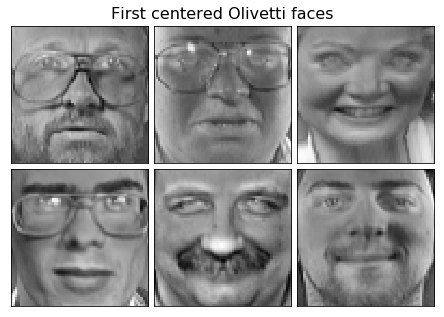

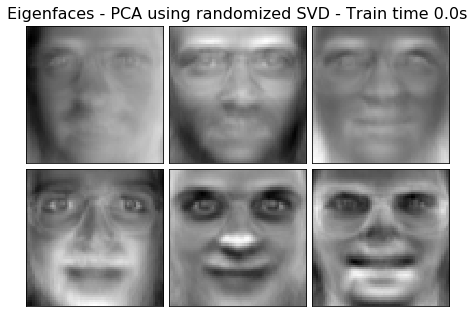

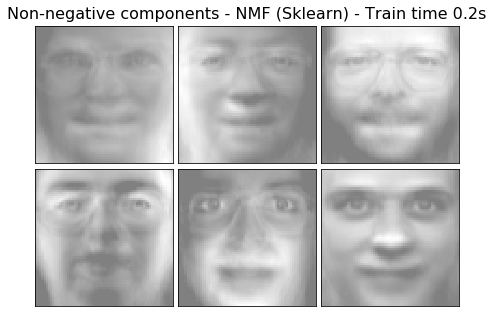

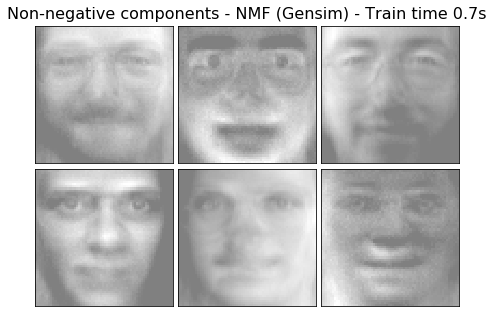

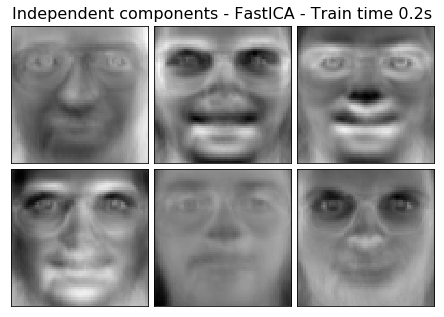

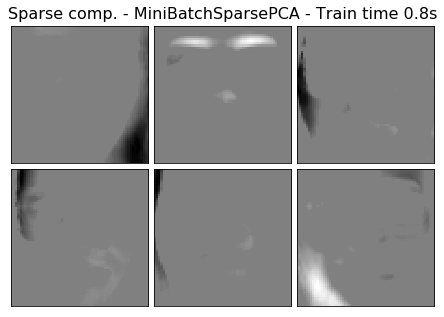

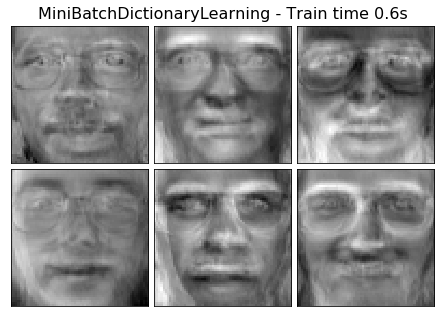

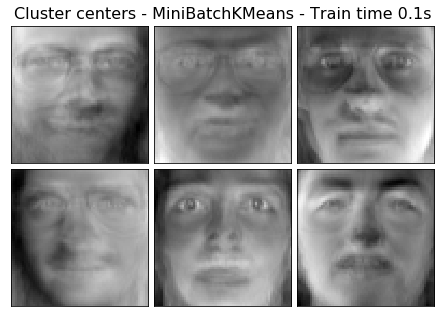

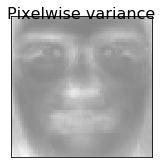

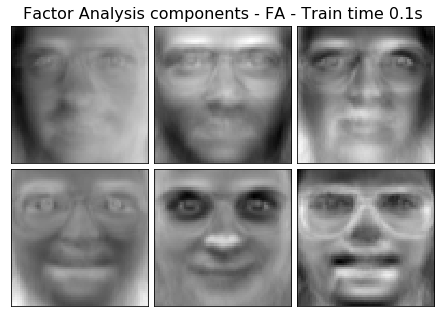

In [24]:
"""
============================
Faces dataset decompositions
============================

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .

"""
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 claus

n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)


# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF (Sklearn)',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Non-negative components - NMF (Gensim)',
     NmfWrapper(
         bow_matrix=faces.T,
         chunksize=3,
         eval_every=400,
         passes=2,
         id2word={idx: idx for idx in range(faces.shape[1])},
         num_topics=n_components,
         minimum_probability=0,
         random_state=42,
     ),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
     decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                               n_iter=50, batch_size=3,
                                               random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
     MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                     max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]

# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time.time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time.time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

As you can see, Gensim's NMF implementation is slower than Sklearn's on **dense** vectors, while achieving comparable quality.

# Conclusion

Gensim NMF is an extremely fast and memory-optimized model. Use it to obtain interpretable topics, as an alternative to SVD / LDA.

---

The NMF implementation in Gensim was created by [Timofey Yefimov](https://github.com/anotherbugmaster/) as a part of his [RARE Technologies Student Incubator](https://rare-technologies.com/incubator/) graduation project.